In [1]:
# !pip install xgboost
# !conda install -c conda-forge -y lightgbm
# !pip install catboost
# !pip install optuna
# !pip install hyperopt
# !pip install IPython 
# !pip install mlxtend

### path

In [27]:
import os

# 파일이 있는 현재 위치를 path로 지정
current_directory = os.getcwd()
path = current_directory.replace('\\', '/')
path += '/' if not path.endswith('/') else ''

data_path = path + "data/"
print("Data_path :", data_path)

img_path = path + "img/"
print("IMG_path :", img_path)

#필요시 path 재조정
# path = 'C:/Users/sook7/미래에솦_주피터/본선코드정리/'
# data_path = path + "data/"
# img_path = path + "img/"

Data_path : C:/Users/sook7/미래에솦_주피터/[빅데이터_미래에솦]소스코드/data/
IMG_path : C:/Users/sook7/미래에솦_주피터/[빅데이터_미래에솦]소스코드/img/


### 글꼴

In [28]:
#windows 실행시
from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
# 디렉토리 및 파일 이름에 맞추어 변경
font_location = path + 'NanumGothic.ttf'
# 폰트 설정
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

#MAC 실행시
# plt.rcParams["font.family"] = "Arial Unicode MS"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE

import optuna
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import GridSearchCV

import itertools
import joblib
import os

from IPython.display import Image
from tqdm import tqdm
import warnings


# 경고 메시지 무시 설정
warnings.filterwarnings("ignore")

# 모든 칼럼 출력
pd.set_option('display.max_columns', None)

Data_path : /Users/Goo/미래에셋/data/
IMG_path : /Users/Goo/미래에셋/img/


In [3]:
model_df = pd.read_csv(data_path + 'data_전처리_model_df_ver2.csv')
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   종목코드       755 non-null    int64  
 1   종목명        755 non-null    object 
 2   매출액 증감율    755 non-null    float64
 3   영업이익 증감율   755 non-null    float64
 4   EPS 증감율    755 non-null    float64
 5   자산비율       755 non-null    float64
 6   부채비율       755 non-null    float64
 7   유동비율       755 non-null    float64
 8   순운전자비율     755 non-null    float64
 9   예상 시가총액    755 non-null    float64
 10  PBR        755 non-null    float64
 11  PSR        755 non-null    float64
 12  ROE        755 non-null    float64
 13  ROA        755 non-null    float64
 14  OPM        755 non-null    float64
 15  시초/공모(%)   755 non-null    float64
 16  nsi_5      755 non-null    float64
 17  업황         755 non-null    float64
 18  공모주 시장 동향  755 non-null    float64
 19  유통가능물량비율   755 non-null    float64
 20  기관경쟁률     

# 이상치 처리 

- 재무정보의 특성상 이상치가 많았고 이상치는 모델에 악영향을 줄 것이라 판단
- 3 * IQR 범위 밖에 존재하는 값들을 이상치로 정의하여 이상치를 포괄적으로 정의
- 2009년 이후의 공모주를 모두 크롤링 하였지만 종목이 755개로 sample size가 작아 이상치를 제거하지 않고 클리핑(cliping)하기로 결정
- lower_bound(Q1 - 3 * IQR) 이하의 값들은 lower_bound, upper_bound(Q3 + 3 * IQR) 이상의 값들은 upper_bound로 클리핑 해주어 이상치가 모델 학습에 부정적인 영향을 미치는것을 방지해주고 데이터 분포를 안정화

### 1. 연속형 변수 분포 확인

In [ ]:
continuous_columns = ['매출액 증감율', '영업이익 증감율', 'EPS 증감율', '자산비율', '부채비율', '유동비율', '순운전자비율', '예상 시가총액', 'PBR', 'PSR', 'ROE', 'ROA', 'OPM','nsi_5', '업황', '공모주 시장 동향', '유통가능물량비율', '기관경쟁률', '의무보유확약비율', '공모금액', '공모밴드비율']
skewed_columns = []

n_rows = 5
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))

for i, column in enumerate(continuous_columns):
    row = i // n_cols
    col = i % n_cols
    sns.histplot(data=model_df, x=column, bins=30, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'{column} 분포')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('빈도')

# 빈 서브플롯은 숨김처리
for i in range(len(continuous_columns), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

### 2. IQR 이상치 대체 : cliping

In [ ]:
def replace_outliers_with_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # 이상치 개수 카운트
    num_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    # 이상치를 3 * IQR 값으로 대체
    df[column] = np.where(df[column] < lower_bound, Q1 - 3 * IQR, df[column])
    df[column] = np.where(df[column] > upper_bound, Q3 + 3 * IQR, df[column])
    
    # 이상치 개수 출력
    print(f'칼럼 {column}에서 이상치 개수: {num_outliers}')

# 각 칼럼에 대해 이상치 대체 적용
for column in continuous_columns:
    replace_outliers_with_iqr(model_df, column)
    

n_rows = 5
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))

for i, column in enumerate(continuous_columns):
    row = i // n_cols
    col = i % n_cols
    sns.histplot(data=model_df, x=column, bins=30, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'{column} 분포')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('빈도')

# 빈 서브플롯은 숨김처리
for i in range(len(continuous_columns), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

칼럼 매출액 증감율에서 이상치 개수: 45
칼럼 영업이익 증감율에서 이상치 개수: 48
칼럼 EPS 증감율에서 이상치 개수: 62
칼럼 자산비율에서 이상치 개수: 36
칼럼 부채비율에서 이상치 개수: 36
칼럼 유동비율에서 이상치 개수: 39
칼럼 순운전자비율에서 이상치 개수: 7
칼럼 예상 시가총액에서 이상치 개수: 56
칼럼 PBR에서 이상치 개수: 57
칼럼 PSR에서 이상치 개수: 94
칼럼 ROE에서 이상치 개수: 72
칼럼 ROA에서 이상치 개수: 70
칼럼 OPM에서 이상치 개수: 93
칼럼 nsi_5에서 이상치 개수: 0
칼럼 업황에서 이상치 개수: 5
칼럼 공모주 시장 동향에서 이상치 개수: 0
칼럼 유통가능물량비율에서 이상치 개수: 0
칼럼 기관경쟁률에서 이상치 개수: 0
칼럼 의무보유확약비율에서 이상치 개수: 38
칼럼 공모금액에서 이상치 개수: 53
칼럼 공모밴드비율에서 이상치 개수: 0


#### 이상치를 클리핑(대체) 한것이 분산 안정화에 기여했음을 직관적으로 알 수 있다.

# <공모주 규정 변경>
23년 7월부로 신규상장일 시초/공모(%) 결정 기준이 변경되었다.

## 신규상장일 시초/공모(%) 결정 기준
- 과거 : 공모가 기준 -10% ~ 100%
- 현재 : 공모가 기준 -40% ~ 400%

공모주 수익률에 대한 과거 선행 연구는 단순한 2진분류를 통해 수익을 볼 수 있을지 없을지에 대한 예측만을 진행하였다. 또한 공모주 시초가 상단이 100%인 공모주 변경전의 연구들 밖에 없기에 본 프로젝트에서 4가지 level로 범주를 나눠 공모주의 시초/공모(%) 범주를 예측해보려한다.

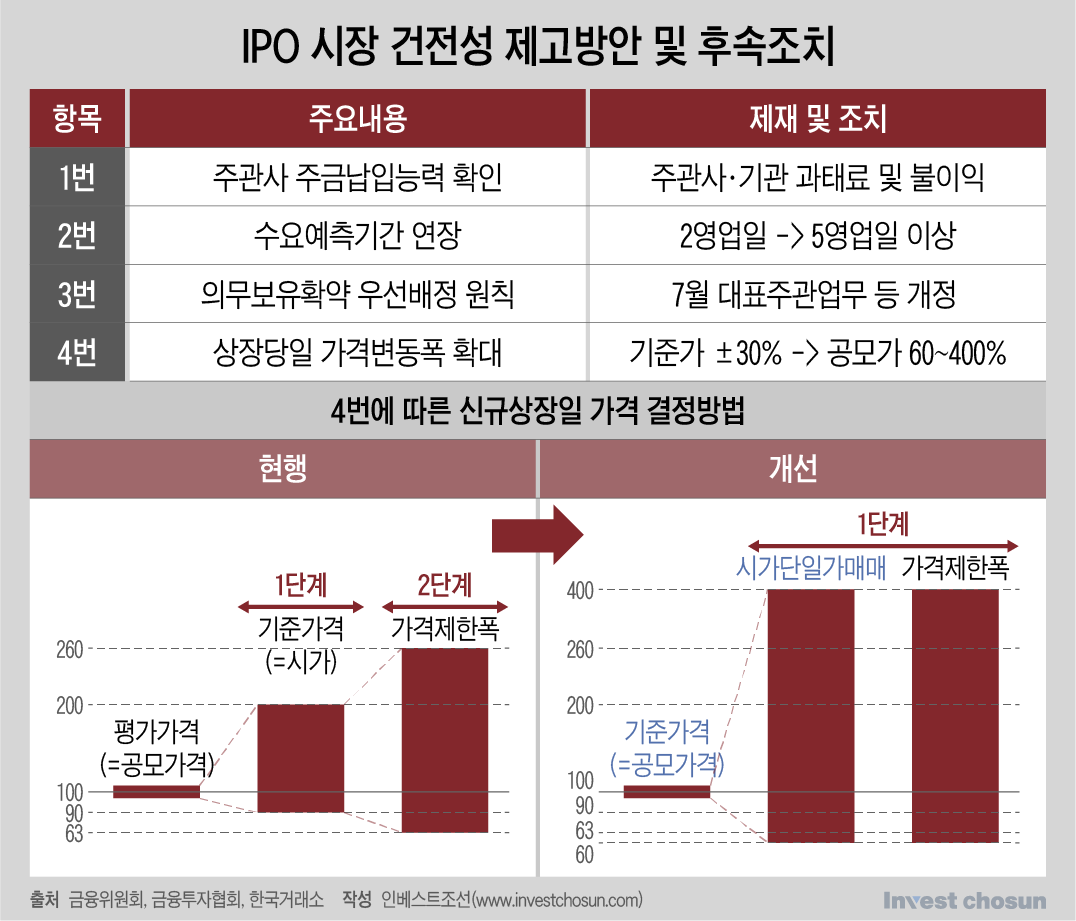

In [6]:
Image(filename = img_path +'공모주규정변경.png')

## 공모주 규정 변경 이유
-> 허수성 청약 방지 등 IPO 시장 건전성 제고방안의 후속조치로서 가격제한폭을 넓혀 적정가격을 찾도록 하는 것이 목표이다.

따라서 미래에솦팀은 공모주 규정 변경전 가격제한폭으로 인해 신규상장 첫날 적정한 가격을 찾지 못한 기업을 따로 분류하여 마지막 범주에 포함시켜주자 했다.

#### 따라서 시초/공모(%) == 100이면서, 종가/공모(%) > 158(따상)이라면 마지막 범주에 포함시켜 변경된 공모주 규정 또한 반영한 모델을 구성하였다.
- 본 프로젝트는 공모가 대비 시초가의 수익률을 예측하는 프로젝트이므로 따상이 아니라면 공모주 규정 변경 이후 마지막 범주로서 반영하기에 무리가 있다고 판단하여 따상인 158을 기준으로 정하였다.
- 아직은 새로운 규정이 적용된지 얼마 되지 않아 sample size가 매우 적어 부족한 측면이있지만 시간이 흘러 신규 상장하는 종목이 많아진다면 정확도는 점점 올라갈 것이다.
- 또한 160% 이상의 범주 또한 고려가 가능해져 향후 5개의 level에 대한 분류 모델을 만들 수 있을것으로 기대된다.

#### 공모주 규정 변경전 가격제한폭으로 인해 신규상장 첫날 적정한 가격을 찾지 못하는 기업을 분류해주기위해 종가/공모(%) 변수를 data_크롤링_38_신규상장.csv에서 가져왔다.

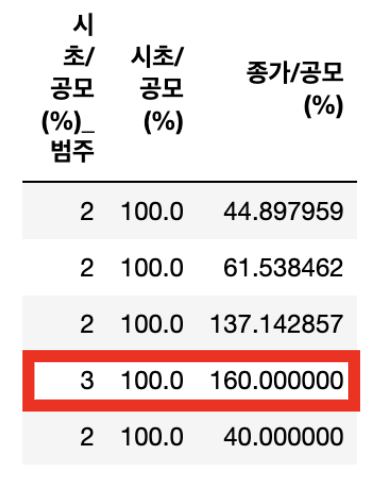

In [7]:
Image(filename = img_path +'시초공모(%)범주변경.png')

In [8]:
closing_price = pd.read_csv(data_path + 'data_크롤링_38_신규상장.csv')

# merge 하기위해 변수명 통일
closing_price.rename(columns = {'기업명' : '종목명'}, inplace=True)

# numeric 타입으로 형변환
closing_price['시초/공모(%)'] = pd.to_numeric(closing_price['시초/공모(%)'].str.replace('%', ''), errors='coerce')
closing_price['시초가(원)'] = pd.to_numeric(closing_price['시초가(원)'].str.replace(',', ''), errors='coerce')
closing_price['공모가(원)'] = pd.to_numeric(closing_price['공모가(원)'].str.replace(',', ''), errors='coerce')
closing_price['첫날종가(원)'] = pd.to_numeric(closing_price['첫날종가(원)'].str.replace(',', ''), errors='coerce')

closing_price['종가/공모(%)'] = (closing_price['첫날종가(원)'] - closing_price['공모가(원)']) / closing_price['공모가(원)'] * 100
closing_price[closing_price['종가/공모(%)'] == 160]

# 수작업으로 null값 채우기 (스팩 제외)
closing_price.loc[34, '첫날종가(원)'] = 41600
closing_price.loc[70, '첫날종가(원)'] = 15600

closing_price.loc[34, '종가/공모(%)'] = (closing_price.loc[34, '첫날종가(원)'] - closing_price.loc[34, '공모가(원)']) / closing_price.loc[34, '첫날종가(원)'] * 100
closing_price.loc[70, '종가/공모(%)'] = (closing_price.loc[70, '첫날종가(원)'] - closing_price.loc[70, '공모가(원)']) / closing_price.loc[70, '첫날종가(원)'] * 100

# 따상 종목은 마지막 범주로 라벨링 하기 위해, model_df와 closing_price 합치기
model_df = pd.merge(model_df, closing_price[['종목명','종가/공모(%)']], on='종목명', how='left')

# 기업명과 종목코드를 별도의 데이터프레임으로 저장
company_info_df = model_df[['종목명', '종목코드']]

# 기업명과 종목코드를 제외한 데이터프레임 생성
model_df = model_df.drop(['종목명', '종목코드'], axis=1)

<Axes: ylabel='count'>

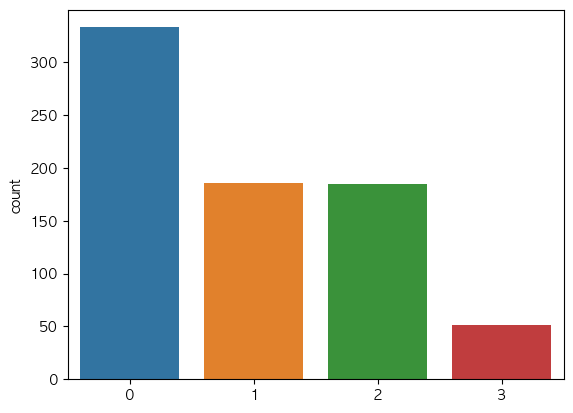

In [9]:
#다중분류 4개 범주

def split_multi_y(row):
    if row['시초/공모(%)'] <= 20:
        return 0
    elif row['시초/공모(%)'] <= 60:
        return 1
    elif row['시초/공모(%)'] < 100:
        return 2
    elif row['시초/공모(%)'] == 100:
        if not row['종가/공모(%)'] > 158:  ## 따상 고려
            return 2
        else:
            return 3
    # 시초/공모(%)가 100을 넘는 경우(기준 개편 이후)
    else:
        return 3

y = model_df.apply(split_multi_y, axis=1)                                       
X = model_df.drop(['시초/공모(%)','종가/공모(%)'], axis=1)

sns.countplot(x=y, order=[0, 1, 2, 3])

# 1. Modeling
- 이상치 대체

### 1) 이상치 대체  
XGBClassifier
- accuracy = 0.63
- recall = 0.54

In [10]:
# import random
# random_state = random.randint(1, 1000)
# print(random_state)

723


### random_state : 723 고정

In [11]:
# 다중 분류 Class의 수
num_class = 4
# 결과 재현성 및 모델 평가의 일관성을 위해 random_state 지정
random_state = 723
# 클래스의 불균형이 있어 데이터 분할시 클래스 레이블 분포를 유지하기 위해 stratify=y 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=random_state)

# 다중분류 모델 설정
models = [
    ("Logistic Regression", LogisticRegression(multi_class='multinomial', max_iter=1000, random_state = random_state)),
    ("Support Vector Machines", SVC(decision_function_shape='ovr', random_state = random_state)),
    ("Random Forest", RandomForestClassifier(random_state = random_state)),
    ("XGBClassifier", XGBClassifier(objective='multi:softmax', num_class=num_class, random_state = random_state)),
    ("LGBMClassifier", LGBMClassifier(objective='multiclass', num_class=num_class, random_state = random_state)),
    ("CatBoostClassifier", CatBoostClassifier(random_state = random_state))
]
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

Logistic Regression - Accuracy: 0.4370860927152318
              precision    recall  f1-score   support

           0       0.45      0.97      0.61        67
           1       0.00      0.00      0.00        37
           2       0.17      0.03      0.05        37
           3       0.00      0.00      0.00        10

    accuracy                           0.44       151
   macro avg       0.15      0.25      0.16       151
weighted avg       0.24      0.44      0.28       151

Support Vector Machines - Accuracy: 0.44370860927152317
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        67
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        10

    accuracy                           0.44       151
   macro avg       0.11      0.25      0.15       151
weighted avg       0.20      0.44      0.27       151

Random Forest - Accurac

122:	learn: 0.5240118	total: 383ms	remaining: 2.73s
123:	learn: 0.5218928	total: 385ms	remaining: 2.72s
124:	learn: 0.5183927	total: 388ms	remaining: 2.71s
125:	learn: 0.5160205	total: 390ms	remaining: 2.71s
126:	learn: 0.5133966	total: 393ms	remaining: 2.7s
127:	learn: 0.5099869	total: 396ms	remaining: 2.69s
128:	learn: 0.5079171	total: 398ms	remaining: 2.69s
129:	learn: 0.5051769	total: 401ms	remaining: 2.68s
130:	learn: 0.5029630	total: 403ms	remaining: 2.67s
131:	learn: 0.5007972	total: 406ms	remaining: 2.67s
132:	learn: 0.4988346	total: 409ms	remaining: 2.66s
133:	learn: 0.4963943	total: 411ms	remaining: 2.66s
134:	learn: 0.4933036	total: 414ms	remaining: 2.65s
135:	learn: 0.4912027	total: 416ms	remaining: 2.65s
136:	learn: 0.4879151	total: 419ms	remaining: 2.64s
137:	learn: 0.4857966	total: 421ms	remaining: 2.63s
138:	learn: 0.4834799	total: 424ms	remaining: 2.63s
139:	learn: 0.4809149	total: 427ms	remaining: 2.62s
140:	learn: 0.4782003	total: 430ms	remaining: 2.62s
141:	learn: 0

356:	learn: 0.1978881	total: 982ms	remaining: 1.77s
357:	learn: 0.1970857	total: 985ms	remaining: 1.76s
358:	learn: 0.1965354	total: 987ms	remaining: 1.76s
359:	learn: 0.1959777	total: 990ms	remaining: 1.76s
360:	learn: 0.1955496	total: 993ms	remaining: 1.76s
361:	learn: 0.1949272	total: 995ms	remaining: 1.75s
362:	learn: 0.1941497	total: 998ms	remaining: 1.75s
363:	learn: 0.1937116	total: 1s	remaining: 1.75s
364:	learn: 0.1930190	total: 1s	remaining: 1.75s
365:	learn: 0.1923408	total: 1s	remaining: 1.74s
366:	learn: 0.1915459	total: 1.01s	remaining: 1.74s
367:	learn: 0.1909769	total: 1.01s	remaining: 1.74s
368:	learn: 0.1904526	total: 1.01s	remaining: 1.73s
369:	learn: 0.1897535	total: 1.02s	remaining: 1.73s
370:	learn: 0.1892395	total: 1.02s	remaining: 1.73s
371:	learn: 0.1885668	total: 1.02s	remaining: 1.72s
372:	learn: 0.1882128	total: 1.02s	remaining: 1.72s
373:	learn: 0.1875952	total: 1.03s	remaining: 1.72s
374:	learn: 0.1868842	total: 1.03s	remaining: 1.72s
375:	learn: 0.1864168

587:	learn: 0.1040501	total: 1.58s	remaining: 1.11s
588:	learn: 0.1038804	total: 1.58s	remaining: 1.1s
589:	learn: 0.1035842	total: 1.58s	remaining: 1.1s
590:	learn: 0.1033516	total: 1.59s	remaining: 1.1s
591:	learn: 0.1031121	total: 1.59s	remaining: 1.09s
592:	learn: 0.1028351	total: 1.59s	remaining: 1.09s
593:	learn: 0.1026076	total: 1.59s	remaining: 1.09s
594:	learn: 0.1024564	total: 1.6s	remaining: 1.09s
595:	learn: 0.1022183	total: 1.6s	remaining: 1.08s
596:	learn: 0.1019777	total: 1.6s	remaining: 1.08s
597:	learn: 0.1016995	total: 1.6s	remaining: 1.08s
598:	learn: 0.1015187	total: 1.61s	remaining: 1.08s
599:	learn: 0.1013129	total: 1.61s	remaining: 1.07s
600:	learn: 0.1010953	total: 1.61s	remaining: 1.07s
601:	learn: 0.1010345	total: 1.62s	remaining: 1.07s
602:	learn: 0.1006983	total: 1.62s	remaining: 1.06s
603:	learn: 0.1003803	total: 1.62s	remaining: 1.06s
604:	learn: 0.1001492	total: 1.62s	remaining: 1.06s
605:	learn: 0.0999956	total: 1.63s	remaining: 1.06s
606:	learn: 0.09976

746:	learn: 0.0748688	total: 1.98s	remaining: 671ms
747:	learn: 0.0746990	total: 1.98s	remaining: 668ms
748:	learn: 0.0745581	total: 1.99s	remaining: 666ms
749:	learn: 0.0744598	total: 1.99s	remaining: 663ms
750:	learn: 0.0742857	total: 1.99s	remaining: 660ms
751:	learn: 0.0741394	total: 1.99s	remaining: 657ms
752:	learn: 0.0740111	total: 2s	remaining: 655ms
753:	learn: 0.0738468	total: 2s	remaining: 652ms
754:	learn: 0.0737241	total: 2s	remaining: 650ms
755:	learn: 0.0735586	total: 2s	remaining: 647ms
756:	learn: 0.0734793	total: 2.01s	remaining: 644ms
757:	learn: 0.0733195	total: 2.01s	remaining: 642ms
758:	learn: 0.0731754	total: 2.01s	remaining: 639ms
759:	learn: 0.0730610	total: 2.01s	remaining: 636ms
760:	learn: 0.0729343	total: 2.02s	remaining: 634ms
761:	learn: 0.0728280	total: 2.02s	remaining: 631ms
762:	learn: 0.0726714	total: 2.02s	remaining: 628ms
763:	learn: 0.0725367	total: 2.02s	remaining: 626ms
764:	learn: 0.0724390	total: 2.03s	remaining: 623ms
765:	learn: 0.0723166	to

984:	learn: 0.0498953	total: 2.58s	remaining: 39.3ms
985:	learn: 0.0498187	total: 2.58s	remaining: 36.7ms
986:	learn: 0.0497325	total: 2.59s	remaining: 34.1ms
987:	learn: 0.0496760	total: 2.59s	remaining: 31.4ms
988:	learn: 0.0496101	total: 2.59s	remaining: 28.8ms
989:	learn: 0.0494824	total: 2.59s	remaining: 26.2ms
990:	learn: 0.0494100	total: 2.6s	remaining: 23.6ms
991:	learn: 0.0493242	total: 2.6s	remaining: 21ms
992:	learn: 0.0492570	total: 2.6s	remaining: 18.3ms
993:	learn: 0.0491870	total: 2.6s	remaining: 15.7ms
994:	learn: 0.0491347	total: 2.61s	remaining: 13.1ms
995:	learn: 0.0490844	total: 2.61s	remaining: 10.5ms
996:	learn: 0.0490166	total: 2.62s	remaining: 7.89ms
997:	learn: 0.0489417	total: 2.63s	remaining: 5.26ms
998:	learn: 0.0488943	total: 2.63s	remaining: 2.63ms
999:	learn: 0.0488217	total: 2.63s	remaining: 0us
CatBoostClassifier - Accuracy: 0.6357615894039735
              precision    recall  f1-score   support

           0       0.72      0.88      0.79        67
  

# Data processing
## 1-1. 변수 선택 
### 독립변수간 피어슨 상관계수를 확인하고 변수 선택 (0.45 이상)
- 영업이익 증감율, 부채비율, 순운전자비율, PBR, ROA, OPM, 공모금액, 공모밴드비율 삭제

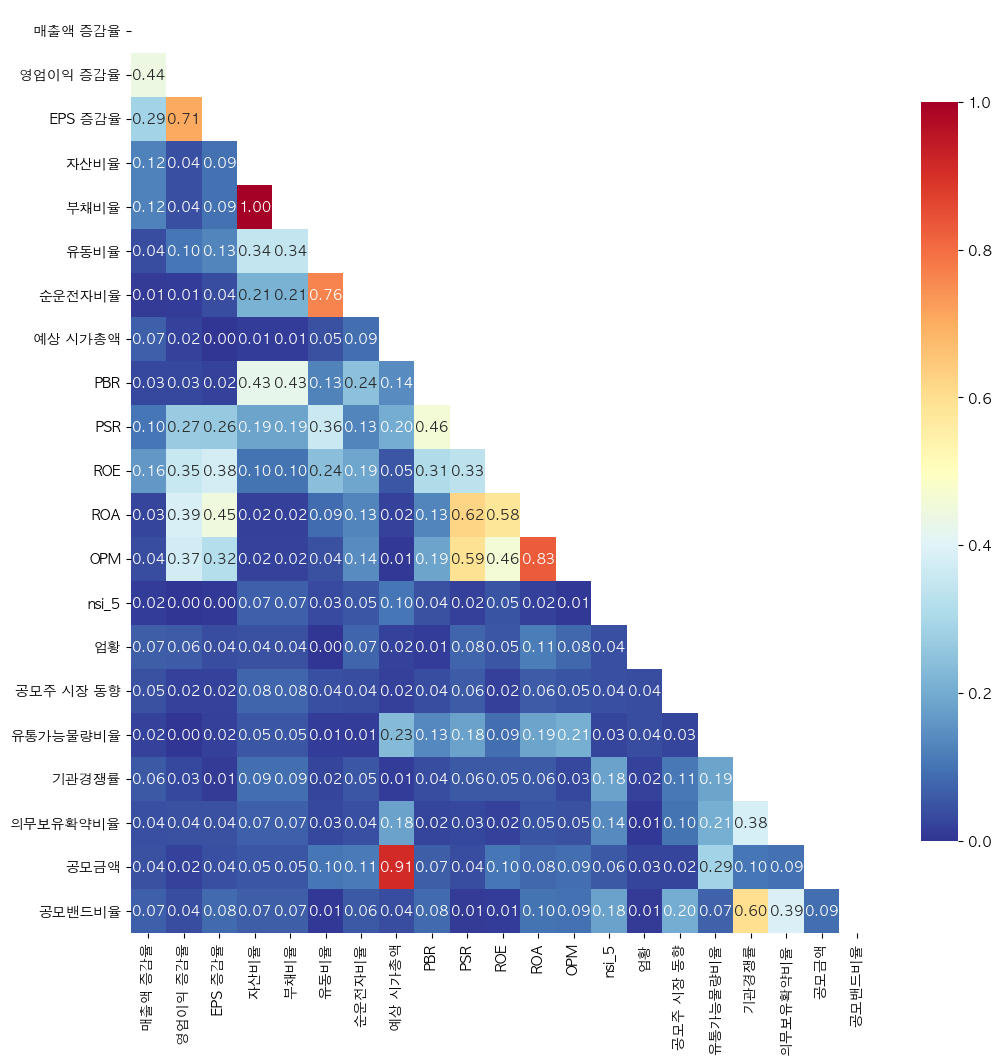

In [12]:
#변수간 상관관계 확인
df = X
corr = X.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdYlBu_r',
            cbar_kws={"shrink": .8}, vmin=0, vmax=1)

plt.yticks(rotation=0)
plt.show()

In [13]:
# 독립변수 설정
X = model_df.drop(['시초/공모(%)', '종가/공모(%)','영업이익 증감율', '부채비율', '순운전자비율', 'PBR', 'ROA', 'OPM', '공모금액', "공모밴드비율"], axis=1)

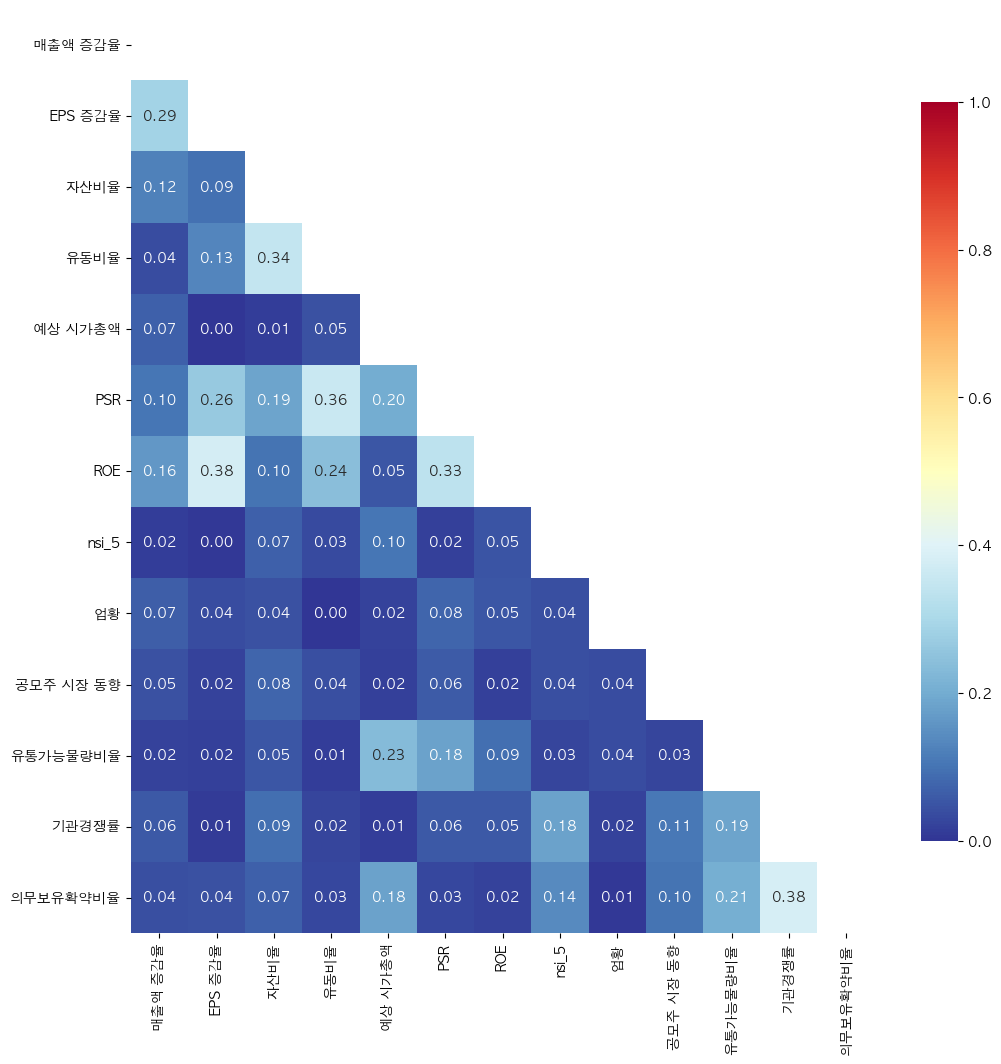

In [14]:
# 변수간 상관관계 확인
df = X
corr = X.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdYlBu_r',
            cbar_kws={"shrink": .8}, vmin=0, vmax=1)

plt.yticks(rotation=0)
plt.show()

## 1-2. 표준화
 - 3 * IQR로 이상치 대체를 했지만 전통적 IQR 이상치 처리에 따른다면 아직도 이상치가 다수 존재. 따라서 표준화를 통해 이상치 영향을 추가적으로 완화해주고자 표준화를 진행
- SVM과 같은 알고리즘은 거리 기반으로 작동하며, 특성 간의 스케일 차이가 크면 올바르게 작동하지 않기에 표준화 적용

In [15]:
# 표준화
scaler = StandardScaler()
columns_to_scale = X.columns
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# 클래스의 불균형이 있어 데이터 분할시 클래스 레이블 분포를 유지하기 위해 stratify=y 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=random_state)

## 1-3. Borderline-SMOTE (Over sampling)
: 다른 class와의 경계(borderline)에 있는 데이터를 증감함으로써 분류하기 더 어려운 부분에 집중한 oversampling 기법

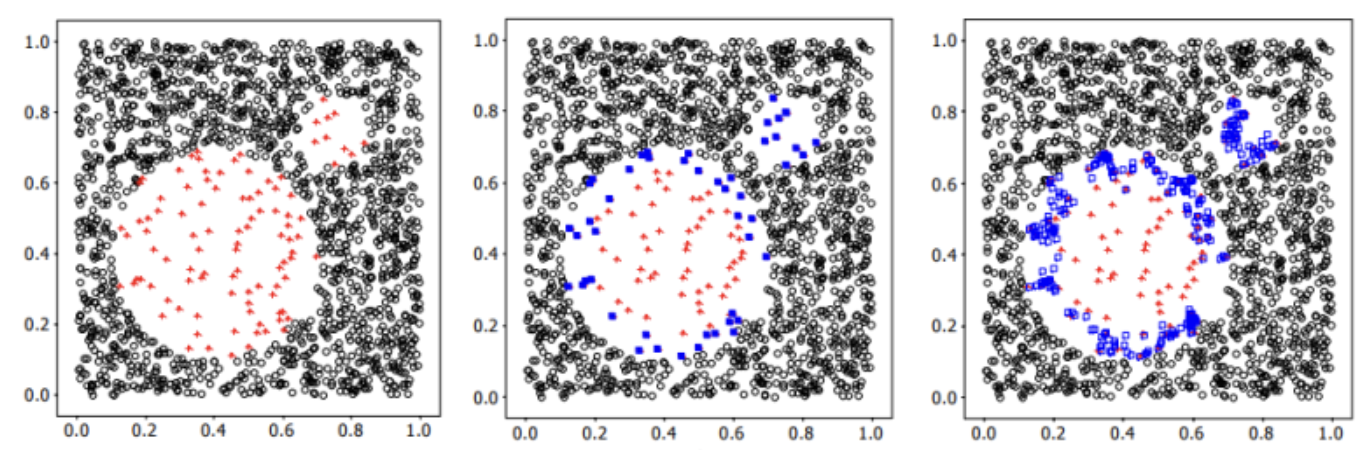

In [16]:
Image(filename = img_path +'BorderlineSMOTE.png')

### 데이터 증강 사용 이유
- 변경된 공모주 규정을 반영하기 위해 만든 3번 클래스의 개수가 적어 생긴 데이터 불균형 문제를 해결하기 위해 사용함

### Boderline-SMOTE 선택 이유
- 경계 데이터에 집중 : Borderline-SMOTE는 소수 클래스 데이터 증강 과정에서 주로 경계 부근에 있는 데이터를 활용하므로, 합성된 데이터가 소수 클래스의 중요한 특성을 잘 반영함
- 모델의 일반화 성능 향상 : Borderline-SMOTE는 주로 소수 클래스와 다수 클래스의 경계에 있는 데이터를 합성하므로, 합성된 데이터가 경계 부근에 몰리고 노이즈가 적게 생성됨. 이로 인해 모델의 일반화 성능 향상

Borderline-SMOTE 적용 후 값의 분포:
 0    266
2    266
1    266
3    266
dtype: int64


<Axes: ylabel='count'>

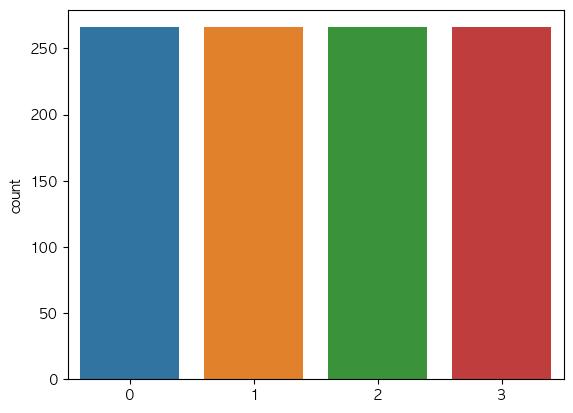

In [17]:
# Borderline-SMOTE를 사용하여 오버샘플링
borderline_smote = BorderlineSMOTE(random_state = random_state)
X_resampled, y_resampled = borderline_smote.fit_resample(X_train, y_train)

# 데이터 증강이 되었는지 확인
print('Borderline-SMOTE 적용 후 값의 분포:\n', pd.Series(y_resampled).value_counts())
sns.countplot(x=y_resampled, order=[0, 1, 2, 3])

#### 향후 상장할 기업에 대한 model input을  계속 갱신받을 csv를 생성
- 해당 csv를 기반으로 향후 상장할 기업에 대한 input을 계속 업데이트하여 재학습 및 분류를 진행할 예정

In [18]:
# company_info_df = company_info_df[["종목코드", "종목명"]]

# data_전처리_final = pd.concat([company_info_df, X], axis=1)
# data_전처리_final = pd.concat([data_전처리_final, y], axis=1)
# data_전처리_final.rename(columns={0: "범주"}, inplace=True)
# data_전처리_final

#data_전처리_final.to_csv(data_path + "data_전처리_model_final.csv", index=False)

### 향후 들어온 model input(신규상장 종목 벡터)에 같은 scale을 적용해주기위해 scaler 저장

#### Scaler 저장 이유
- 훈련데이터와 테스트 데이터를 동일한 스케일로 조정하여 일관성을 유지하고 모델의 일반화 성능을 향상 시킬 수 있다.
- 모델을 학습한 후 model input(신규상장 종목 벡터)에 대한 예측을 수행할때, model input에 동일한 스케일을 적용하지 않는다면 예측결과가 부정확해질 수 있어 예측의 일관성을 위해 저장


-> (Jupyter)code_모델링_input_자동화_6.ipynb에서 load 할 예정

In [19]:
# joblib.dump(scaler, path + 'scaler.pkl')

# 2. Modeling
- 이상치 대체 + 변수선택 + 표준화 + Boderline-SMOTE

#### 1) 이상치 대체  
XGBClassifier
- accuracy = 0.63
- recall = 0.54

#### 2) 이상치 대체  + 변수선택  + 표준화 + Borederlin-SMOTE
XGBClassifier
- accuracy = 0.69
- recall = 0.61

-> 정확도와 재현율이 모두 향상되었음을 알 수 있다.

In [20]:
# 다중분류 모델 설정
models = [
    ("Logistic Regression", LogisticRegression(multi_class='multinomial', max_iter=1000, random_state = random_state)),
    ("Support Vector Machines", SVC(decision_function_shape='ovr', random_state = random_state)),
    ("Random Forest", RandomForestClassifier(random_state = random_state)),
    ("XGBClassifier", XGBClassifier(objective='multi:softmax', num_class=num_class, random_state = random_state)),
    ("LGBMClassifier", LGBMClassifier(objective='multiclass', num_class=num_class, random_state = random_state)),
    ("CatBoostClassifier", CatBoostClassifier(random_state = random_state))
]

for name, model in models:
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

Logistic Regression - Accuracy: 0.5231788079470199
              precision    recall  f1-score   support

           0       0.69      0.70      0.70        67
           1       0.26      0.24      0.25        37
           2       0.62      0.49      0.55        37
           3       0.25      0.50      0.33        10

    accuracy                           0.52       151
   macro avg       0.46      0.48      0.46       151
weighted avg       0.54      0.52      0.53       151

Support Vector Machines - Accuracy: 0.4900662251655629
              precision    recall  f1-score   support

           0       0.62      0.60      0.61        67
           1       0.26      0.27      0.27        37
           2       0.54      0.57      0.55        37
           3       0.30      0.30      0.30        10

    accuracy                           0.49       151
   macro avg       0.43      0.43      0.43       151
weighted avg       0.49      0.49      0.49       151

Random Forest - Accuracy

184:	learn: 0.3398812	total: 397ms	remaining: 1.75s
185:	learn: 0.3389158	total: 400ms	remaining: 1.75s
186:	learn: 0.3376437	total: 401ms	remaining: 1.75s
187:	learn: 0.3360030	total: 403ms	remaining: 1.74s
188:	learn: 0.3351153	total: 405ms	remaining: 1.74s
189:	learn: 0.3333266	total: 407ms	remaining: 1.74s
190:	learn: 0.3314977	total: 409ms	remaining: 1.73s
191:	learn: 0.3298555	total: 411ms	remaining: 1.73s
192:	learn: 0.3287356	total: 413ms	remaining: 1.73s
193:	learn: 0.3273782	total: 416ms	remaining: 1.73s
194:	learn: 0.3256894	total: 418ms	remaining: 1.72s
195:	learn: 0.3246552	total: 420ms	remaining: 1.72s
196:	learn: 0.3225854	total: 422ms	remaining: 1.72s
197:	learn: 0.3214786	total: 424ms	remaining: 1.72s
198:	learn: 0.3200339	total: 426ms	remaining: 1.71s
199:	learn: 0.3189225	total: 428ms	remaining: 1.71s
200:	learn: 0.3173837	total: 430ms	remaining: 1.71s
201:	learn: 0.3168533	total: 432ms	remaining: 1.7s
202:	learn: 0.3145856	total: 434ms	remaining: 1.7s
203:	learn: 0.

381:	learn: 0.1688264	total: 798ms	remaining: 1.29s
382:	learn: 0.1681528	total: 801ms	remaining: 1.29s
383:	learn: 0.1677992	total: 803ms	remaining: 1.29s
384:	learn: 0.1674568	total: 805ms	remaining: 1.28s
385:	learn: 0.1670744	total: 807ms	remaining: 1.28s
386:	learn: 0.1665293	total: 809ms	remaining: 1.28s
387:	learn: 0.1662904	total: 811ms	remaining: 1.28s
388:	learn: 0.1658221	total: 813ms	remaining: 1.28s
389:	learn: 0.1654561	total: 816ms	remaining: 1.27s
390:	learn: 0.1648518	total: 818ms	remaining: 1.27s
391:	learn: 0.1640337	total: 820ms	remaining: 1.27s
392:	learn: 0.1634007	total: 823ms	remaining: 1.27s
393:	learn: 0.1626812	total: 825ms	remaining: 1.27s
394:	learn: 0.1622611	total: 827ms	remaining: 1.27s
395:	learn: 0.1617090	total: 829ms	remaining: 1.26s
396:	learn: 0.1612171	total: 831ms	remaining: 1.26s
397:	learn: 0.1605630	total: 834ms	remaining: 1.26s
398:	learn: 0.1599549	total: 836ms	remaining: 1.26s
399:	learn: 0.1597283	total: 839ms	remaining: 1.26s
400:	learn: 

577:	learn: 0.0999442	total: 1.2s	remaining: 874ms
578:	learn: 0.0997450	total: 1.2s	remaining: 872ms
579:	learn: 0.0994960	total: 1.2s	remaining: 870ms
580:	learn: 0.0992232	total: 1.2s	remaining: 868ms
581:	learn: 0.0989558	total: 1.21s	remaining: 866ms
582:	learn: 0.0987618	total: 1.21s	remaining: 864ms
583:	learn: 0.0984847	total: 1.21s	remaining: 862ms
584:	learn: 0.0982089	total: 1.21s	remaining: 860ms
585:	learn: 0.0981224	total: 1.21s	remaining: 858ms
586:	learn: 0.0979658	total: 1.22s	remaining: 856ms
587:	learn: 0.0977738	total: 1.22s	remaining: 854ms
588:	learn: 0.0975516	total: 1.22s	remaining: 852ms
589:	learn: 0.0973119	total: 1.22s	remaining: 850ms
590:	learn: 0.0971195	total: 1.22s	remaining: 848ms
591:	learn: 0.0969701	total: 1.23s	remaining: 846ms
592:	learn: 0.0968398	total: 1.23s	remaining: 844ms
593:	learn: 0.0966209	total: 1.23s	remaining: 842ms
594:	learn: 0.0964121	total: 1.23s	remaining: 840ms
595:	learn: 0.0962487	total: 1.24s	remaining: 838ms
596:	learn: 0.09

768:	learn: 0.0679011	total: 1.6s	remaining: 480ms
769:	learn: 0.0678247	total: 1.6s	remaining: 478ms
770:	learn: 0.0676667	total: 1.6s	remaining: 476ms
771:	learn: 0.0676040	total: 1.6s	remaining: 473ms
772:	learn: 0.0675320	total: 1.6s	remaining: 471ms
773:	learn: 0.0674075	total: 1.61s	remaining: 469ms
774:	learn: 0.0672991	total: 1.61s	remaining: 467ms
775:	learn: 0.0671173	total: 1.61s	remaining: 465ms
776:	learn: 0.0670153	total: 1.61s	remaining: 463ms
777:	learn: 0.0668806	total: 1.61s	remaining: 461ms
778:	learn: 0.0666500	total: 1.62s	remaining: 459ms
779:	learn: 0.0664844	total: 1.62s	remaining: 457ms
780:	learn: 0.0663295	total: 1.62s	remaining: 455ms
781:	learn: 0.0661734	total: 1.62s	remaining: 452ms
782:	learn: 0.0659503	total: 1.63s	remaining: 450ms
783:	learn: 0.0658913	total: 1.63s	remaining: 448ms
784:	learn: 0.0658065	total: 1.63s	remaining: 446ms
785:	learn: 0.0657154	total: 1.63s	remaining: 444ms
786:	learn: 0.0655345	total: 1.63s	remaining: 442ms
787:	learn: 0.065

964:	learn: 0.0490187	total: 1.99s	remaining: 72.4ms
965:	learn: 0.0489696	total: 2s	remaining: 70.3ms
966:	learn: 0.0488858	total: 2s	remaining: 68.2ms
967:	learn: 0.0488193	total: 2s	remaining: 66.2ms
968:	learn: 0.0487463	total: 2s	remaining: 64.1ms
969:	learn: 0.0486693	total: 2.01s	remaining: 62ms
970:	learn: 0.0485741	total: 2.01s	remaining: 60ms
971:	learn: 0.0485034	total: 2.01s	remaining: 57.9ms
972:	learn: 0.0484179	total: 2.01s	remaining: 55.8ms
973:	learn: 0.0483262	total: 2.01s	remaining: 53.8ms
974:	learn: 0.0482529	total: 2.02s	remaining: 51.7ms
975:	learn: 0.0482113	total: 2.02s	remaining: 49.6ms
976:	learn: 0.0481431	total: 2.02s	remaining: 47.6ms
977:	learn: 0.0480906	total: 2.02s	remaining: 45.5ms
978:	learn: 0.0480141	total: 2.02s	remaining: 43.4ms
979:	learn: 0.0479349	total: 2.03s	remaining: 41.4ms
980:	learn: 0.0479000	total: 2.03s	remaining: 39.3ms
981:	learn: 0.0478141	total: 2.03s	remaining: 37.2ms
982:	learn: 0.0477456	total: 2.03s	remaining: 35.1ms
983:	lear

# 3. Modeling
- 이상치 대체 + 변수선택 + 표준화 + Boderline-SMOTE + Hyperparameter Tunning

#### 1) 이상치 대체  
XGBClassifier
- accuracy = 0.63
- recall = 0.54

#### 2) 이상치 대체  + 변수선택  + 표준화 + Borederlin-SMOTE
XGBClassifier
- accuracy = 0.69
- recall = 0.61

#### 3) 이상치 대체  + 변수선택  + 표준화 + Borederlin-SMOTE + Hyperparameter Tunning
XGBClassifier
- accuracy = 0.74
- recall = 0.64

-> 정확도와 재현율이 모두 향상되었음을 알 수 있다.

# i) GridSearch

## 1. LogisticRegression : softmax

In [21]:
logreg = LogisticRegression(multi_class='multinomial', random_state = random_state)

# 파라미터 범위
param_grid = {
    'C': [0.005, 0.01, 0.04],                 # 규제 강도 파라미터
    'penalty': ['l1', 'l2'],                  # 규제 유형 (L1 또는 L2)
    'max_iter': [150, 200, 250],              # 최대 반복 횟수
    'class_weight': [None, 'balanced'],       # 클래스별 가중치
    'solver': ['lbfgs', 'sag', 'newton-cg'],  # 최적화 알고리즘
}


grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

logreg_best = grid_search.best_estimator_
y_pred = logreg_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="macro")

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)
print("Test Recall:", recall)

Best Parameters: {'C': 0.04, 'class_weight': 'balanced', 'max_iter': 150, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy: 0.5231788079470199
Test Recall: 0.47372932634126663


#### Ensemble에 쓰일 모델
- logreg_best

In [22]:
# 모델 저장
# joblib.dump(logreg_best, data_path + 'logreg_52_47.pkl')

## 2. Support Vector Machines : SVC

#### SVM의 다중 클래스 분류  
i) ovr : One-vs-Rest
- 각 클래스마다 하나의 이진 분류 모델 생성
- 클래스 A를 양성 클래스로 나머지 클래스를 음성 클래스로 간주하여 이진분류
- 모든 클래스에 대한 이진 분류를 수행하여 클래스 수만큼의 이진 분류 모델 생성
- 예측시, 모든 이진 분류 모델의 결정 함수 값을 계산하여 가장 높은 값을 가진 클래스 선택

ii) ovo : One-vs-One
- 각 클래스 조합마다 하나의 이진 분류 모델 생성
- 예측시, 모든 이진 분류 모델의 결정 함수 값을 계산하여 가장 높은 값을 가진 클래스 선택

In [23]:
# ovr : One-vs-Rest가 ovo와 성능은 차이가 없는데 계산량이 월등히 빨라 ovr을 선택
svc = SVC(decision_function_shape='ovr', probability=True)

# 파라미터 범위
param_grid = {
    'C': [0.1, 1, 10,100],           # 규제 파라미터
    'kernel': ['linear', 'rbf'],     # 커널 종류
    'gamma': ['scale', 'auto']       # gamma 값
}

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(X_resampled, y_resampled)

svc_best = grid_search.best_estimator_
y_pred = svc_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)
print("Test Recall:", recall)

Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy: 0.4900662251655629
Test Recall: 0.4063937071399758


#### Ensemble에 쓰일 모델
- svc_best

In [24]:
# 모델 저장
# joblib.dump(svc_best, data_path + 'svc_49_41.pkl')

## 3. RandomForest : Bagging

In [ ]:
rf = RandomForestClassifier(criterion = 'entropy',  class_weight = 'balanced', n_jobs=-1, random_state=random_state)

# 파라미터 범위
param_grid = {
    'n_estimators': [150, 200, 250, 300, 350], # 결정 트리의 개수
    'max_depth': [15, 20, 25, 30],             # 트리의 최대 깊이
    'min_samples_split': [1, 2, 3],            # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1,2,3],               # 리프 노드의 최소 샘플 수
    'max_features': ['sqrt']                   # 최대 피처 개수
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_resampled, y_resampled)

rf_best = grid_search.best_estimator_
y_pred = rf_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average = 'macro')

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)
print("Test Recall:", recall)

#### Ensemble에 쓰일 모델
- rf_best

In [ ]:
# 모델 저장
# joblib.dump(rf_best, data_path + 'rf_67_59.pkl')

## ii) HyperOpt, Optuna :  베이지안 최적화 기반
- GridSearch의 경우 튜닝해야할 파라미터 개수가 많은 경우 최적화 수행시간이 오래 걸린다는 단점이 있음
- 부스팅 계열의 모델들은 튜닝해야할 파라미터의 개수가 많고 GridSearch로 하이퍼파라미터를 튜닝하기엔 연산량이 너무 많고 시간이 오래걸림

#### 베이지안 최적화 : 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식

## 4. XGBClassifier : xgboost

### i) HyperOpt

In [ ]:
# space 범위
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]
space = {
    'max_depth': hp.quniform("max_depth", 5, 15, 1),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.05, 0.005),
    'reg_alpha': hp.choice('reg_alpha', reg_candidate),
    'reg_lambda': hp.choice('reg_lambda', reg_candidate),
    'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 1, 0.05),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 200, 1500, 100)
}

# 목적 함수 정의 (정확도와 재현율 기준)
def hyperparameter_tuning(space):
    model = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        random_state=random_state,
        objective='multi:softmax',
        num_class=num_class,
    )

    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')

    return {'loss': -recall, 'status': STATUS_OK, 'model': model, 'accuracy': accuracy, 'recall': recall}


trials = Trials()

# 하이퍼파라미터 최적화 수행
best = fmin(fn=hyperparameter_tuning,  # 목적 함수
            space=space,               # 하이퍼파라미터 탐색 공간
            algo=tpe.suggest,          # 최적화 알고리즘
            max_evals=100,             # 평가 횟수
            trials=trials)             # Trials

xgb_best = hyperparameter_tuning(best)['model']

best_params = {
    'n_estimators': xgb_best.get_params()['n_estimators'],
    'max_depth': xgb_best.get_params()['max_depth'],
    'learning_rate': xgb_best.get_params()['learning_rate'],
    'reg_alpha': xgb_best.get_params()['reg_alpha'],
    'reg_lambda': xgb_best.get_params()['reg_lambda'],
    'subsample': xgb_best.get_params()['subsample'],
    'colsample_bytree': xgb_best.get_params()['colsample_bytree'],
    'min_child_weight': xgb_best.get_params()['min_child_weight'],
    'random_state': xgb_best.get_params()['random_state'],
    'objective': 'multi:softmax',
    'num_class': num_class
}

xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_resampled, y_resampled)
y_pred_best = xgb_best.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best, average='macro')

print("Best parameters:", best)
print("Test Accuracy:", accuracy_best)
print("Test Recall:", recall_best)

### ii) Optuna

In [ ]:
best_recall = 0.0

# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'max_depth': trial.suggest_int('max_depth', 30, 35),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10),
        'objective': 'multi:softmax',
        'num_class': num_class
    }


    model = XGBClassifier(**params, random_state = random_state)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)


    global best_recall
    accuracy = accuracy_score(y_test, y_pred)
    best_recall = recall_score(y_test, y_pred, average='macro')

    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_trials=300)

print("Test parameters:", xgb_study.best_params)
print("Test Accuracy:", xgb_study.best_value)
print("Test Recall:", best_recall)

### XGB : HyperOpt보다 Optuna의 성능이 더 좋아 Optuna를 사용한 모델 저장
#### Ensemble에 쓰일 모델
- xgb_best

In [261]:
xgb_best = XGBClassifier(**xgb_study.best_params, random_state = random_state)
xgb_best.fit(X_resampled, y_resampled)
y_pred = xgb_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')

print("Test Accuracy:", accuracy)
print("Test Recall:", recall)

Test Accuracy: 0.7350993377483444
Test Recall: 0.6444735780556676


In [262]:
# 모델 저장
# joblib.dump(xgb_best, data_path + 'xgb_74_64.pkl')

['/Users/Goo/미래에셋/data/xgb_74_64.pkl']

## 5. LGBClassifier : lightgbm

### i) HyperOpt

In [225]:
# space 범위
space = {
    'max_depth': hp.quniform("max_depth", 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'min_child_samples': hp.quniform('min_child_samples', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-5), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-5), np.log(10)),
    'objective': 'multiclass',
    'num_class': num_class
}

# 목적 함수 정의 (정확도와 재현율 기준)
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_samples'] = int(params['min_child_samples'])
    params['max_depth'] = int(params['max_depth'])
    
    model = LGBMClassifier(**params, random_state=random_state)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')

    return -recall


trials = Trials()

# 하이퍼파라미터 최적화 수행
best = fmin(fn=objective,      # 목적 함수
            space=space,       # 하이퍼파라미터 탐색 공간
            algo=tpe.suggest,  # 최적화 알고리즘
            max_evals=100,     # 평가 횟수
            trials=trials)     # Trials

best_params = {
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'n_estimators': int(best['n_estimators']),
    'min_child_samples': int(best['min_child_samples']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'objective': 'multiclass',
    'num_class': num_class,
    'random_state': random_state
}

lgbm_best = LGBMClassifier(**best_params)
lgbm_best.fit(X_resampled, y_resampled)
y_pred = lgbm_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')

print("Best parameters:", best)
print("Test Accuracy:", accuracy)
print("Test Recall:", recall)

100%|██████| 100/100 [01:11<00:00,  1.40trial/s, best loss: -0.6123033481242436]
Best parameters: {'colsample_bytree': 0.9994378619652624, 'learning_rate': 0.010265284768878148, 'max_depth': 10.0, 'min_child_samples': 6.0, 'n_estimators': 440.0, 'reg_alpha': 0.021112402991708867, 'reg_lambda': 0.04255400412668233, 'subsample': 0.9401552515040422}
Test Accuracy: 0.6887417218543046
Test Recall: 0.6123033481242436


### ii) Optuna

In [227]:
best_recall = 0.0

# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10),
        'objective': 'multiclass',
        'num_class': num_class
    }

    model = LGBMClassifier(**params, random_state=random_state)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)

    global best_recall
    accuracy = accuracy_score(y_test, y_pred)
    best_recall = recall_score(y_test, y_pred, average='macro')

    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(objective, n_trials=300)

print("Test parameters:", lgbm_study.best_params)
print("Test Accuracy:", lgbm_study.best_value)
print("Test Recall:", best_recall)

[I 2023-09-10 03:27:16,492] A new study created in memory with name: no-name-1c9f0069-e67b-4776-a0b3-cb02c0e6dcc5
[I 2023-09-10 03:27:16,965] Trial 0 finished with value: 0.6357615894039735 and parameters: {'max_depth': 35, 'learning_rate': 0.06398518235686683, 'n_estimators': 465, 'min_child_samples': 3, 'subsample': 0.653210575989809, 'colsample_bytree': 0.8024784728963628, 'reg_alpha': 4.347162183817597, 'reg_lambda': 4.665924224067869}. Best is trial 0 with value: 0.6357615894039735.
[I 2023-09-10 03:27:17,124] Trial 1 finished with value: 0.5629139072847682 and parameters: {'max_depth': 3, 'learning_rate': 0.03632869643891526, 'n_estimators': 373, 'min_child_samples': 4, 'subsample': 0.5873404849701838, 'colsample_bytree': 0.5438977972608507, 'reg_alpha': 6.666036493276743, 'reg_lambda': 0.12747260070148084}. Best is trial 0 with value: 0.6357615894039735.
[I 2023-09-10 03:27:17,341] Trial 2 finished with value: 0.6291390728476821 and parameters: {'max_depth': 14, 'learning_rate':

[I 2023-09-10 03:27:32,266] Trial 22 finished with value: 0.6821192052980133 and parameters: {'max_depth': 36, 'learning_rate': 0.027005677940095247, 'n_estimators': 628, 'min_child_samples': 10, 'subsample': 0.8010070676555371, 'colsample_bytree': 0.9004057543569771, 'reg_alpha': 2.6843008356874574, 'reg_lambda': 2.9281097220149213}. Best is trial 21 with value: 0.6821192052980133.
[I 2023-09-10 03:27:32,912] Trial 23 finished with value: 0.6821192052980133 and parameters: {'max_depth': 39, 'learning_rate': 0.028190417586937685, 'n_estimators': 718, 'min_child_samples': 10, 'subsample': 0.8126523702390873, 'colsample_bytree': 0.9193265842760237, 'reg_alpha': 2.315879158628964, 'reg_lambda': 1.8582372548168906}. Best is trial 21 with value: 0.6821192052980133.
[I 2023-09-10 03:27:33,453] Trial 24 finished with value: 0.6754966887417219 and parameters: {'max_depth': 42, 'learning_rate': 0.026992266709696906, 'n_estimators': 778, 'min_child_samples': 10, 'subsample': 0.8056766442263074, 

[I 2023-09-10 03:27:47,588] Trial 44 finished with value: 0.6622516556291391 and parameters: {'max_depth': 29, 'learning_rate': 0.018361484913676878, 'n_estimators': 573, 'min_child_samples': 6, 'subsample': 0.7815687190741453, 'colsample_bytree': 0.830927428305502, 'reg_alpha': 1.1777092244731249, 'reg_lambda': 2.283943554903146}. Best is trial 41 with value: 0.7152317880794702.
[I 2023-09-10 03:27:48,750] Trial 45 finished with value: 0.695364238410596 and parameters: {'max_depth': 19, 'learning_rate': 0.01460361303371496, 'n_estimators': 761, 'min_child_samples': 8, 'subsample': 0.7295158011685864, 'colsample_bytree': 0.7870538749252022, 'reg_alpha': 2.661561075541284, 'reg_lambda': 1.350213592784258}. Best is trial 41 with value: 0.7152317880794702.
[I 2023-09-10 03:27:50,863] Trial 46 finished with value: 0.6754966887417219 and parameters: {'max_depth': 16, 'learning_rate': 0.014239744663172786, 'n_estimators': 859, 'min_child_samples': 7, 'subsample': 0.7375341942958643, 'colsamp

[I 2023-09-10 03:28:10,982] Trial 66 finished with value: 0.7019867549668874 and parameters: {'max_depth': 49, 'learning_rate': 0.020286375412597223, 'n_estimators': 683, 'min_child_samples': 4, 'subsample': 0.7375739126061684, 'colsample_bytree': 0.8138776177360485, 'reg_alpha': 3.073778181909947, 'reg_lambda': 0.8767173939032986}. Best is trial 41 with value: 0.7152317880794702.
[I 2023-09-10 03:28:11,813] Trial 67 finished with value: 0.6821192052980133 and parameters: {'max_depth': 50, 'learning_rate': 0.020210223251087622, 'n_estimators': 678, 'min_child_samples': 3, 'subsample': 0.7190375214655128, 'colsample_bytree': 0.8136909002559217, 'reg_alpha': 3.1658212764194973, 'reg_lambda': 0.9228783193752819}. Best is trial 41 with value: 0.7152317880794702.
[I 2023-09-10 03:28:13,355] Trial 68 finished with value: 0.695364238410596 and parameters: {'max_depth': 40, 'learning_rate': 0.01290574460821525, 'n_estimators': 750, 'min_child_samples': 3, 'subsample': 0.7055410334147194, 'cols

[I 2023-09-10 03:28:32,757] Trial 88 finished with value: 0.6887417218543046 and parameters: {'max_depth': 38, 'learning_rate': 0.029075991799504167, 'n_estimators': 554, 'min_child_samples': 3, 'subsample': 0.8663836351922708, 'colsample_bytree': 0.8870548442887971, 'reg_alpha': 1.684164896995056, 'reg_lambda': 2.0060595227401223}. Best is trial 41 with value: 0.7152317880794702.
[I 2023-09-10 03:28:33,487] Trial 89 finished with value: 0.6821192052980133 and parameters: {'max_depth': 36, 'learning_rate': 0.017384862327529928, 'n_estimators': 486, 'min_child_samples': 2, 'subsample': 0.8268990863854099, 'colsample_bytree': 0.8569820930888304, 'reg_alpha': 3.8380105673582126, 'reg_lambda': 1.661880950062931}. Best is trial 41 with value: 0.7152317880794702.
[I 2023-09-10 03:28:34,500] Trial 90 finished with value: 0.7218543046357616 and parameters: {'max_depth': 46, 'learning_rate': 0.012354495728412093, 'n_estimators': 524, 'min_child_samples': 6, 'subsample': 0.7882850910848848, 'col

[I 2023-09-10 03:28:52,723] Trial 110 finished with value: 0.7019867549668874 and parameters: {'max_depth': 44, 'learning_rate': 0.01415888029757757, 'n_estimators': 617, 'min_child_samples': 7, 'subsample': 0.8313629324194562, 'colsample_bytree': 0.8448601879582772, 'reg_alpha': 2.6195907247475057, 'reg_lambda': 2.602255244792206}. Best is trial 90 with value: 0.7218543046357616.
[I 2023-09-10 03:28:53,613] Trial 111 finished with value: 0.6821192052980133 and parameters: {'max_depth': 36, 'learning_rate': 0.0175116408789704, 'n_estimators': 653, 'min_child_samples': 5, 'subsample': 0.8000984486546467, 'colsample_bytree': 0.8532055938191877, 'reg_alpha': 2.700806113881052, 'reg_lambda': 1.575466264941219}. Best is trial 90 with value: 0.7218543046357616.
[I 2023-09-10 03:28:54,627] Trial 112 finished with value: 0.7019867549668874 and parameters: {'max_depth': 38, 'learning_rate': 0.015353170393415798, 'n_estimators': 628, 'min_child_samples': 6, 'subsample': 0.8188852810914626, 'cols

[I 2023-09-10 03:29:16,002] Trial 132 finished with value: 0.6887417218543046 and parameters: {'max_depth': 47, 'learning_rate': 0.013859281235477099, 'n_estimators': 699, 'min_child_samples': 5, 'subsample': 0.7821087796006105, 'colsample_bytree': 0.8349385197613326, 'reg_alpha': 2.538472846384687, 'reg_lambda': 1.202587430759928}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:29:16,515] Trial 133 finished with value: 0.6688741721854304 and parameters: {'max_depth': 44, 'learning_rate': 0.017094047756487166, 'n_estimators': 235, 'min_child_samples': 5, 'subsample': 0.8009750500887769, 'colsample_bytree': 0.8533180353575386, 'reg_alpha': 2.371144353205539, 'reg_lambda': 1.935593915967258}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:29:17,450] Trial 134 finished with value: 0.7086092715231788 and parameters: {'max_depth': 42, 'learning_rate': 0.01575301311673083, 'n_estimators': 722, 'min_child_samples': 5, 'subsample': 0.7552612999930025, 'c

[I 2023-09-10 03:29:37,989] Trial 154 finished with value: 0.6887417218543046 and parameters: {'max_depth': 46, 'learning_rate': 0.01389713487811822, 'n_estimators': 656, 'min_child_samples': 5, 'subsample': 0.7893863374866621, 'colsample_bytree': 0.819621915573979, 'reg_alpha': 1.9292987336218892, 'reg_lambda': 2.0548443140409}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:29:38,828] Trial 155 finished with value: 0.6821192052980133 and parameters: {'max_depth': 42, 'learning_rate': 0.02264110696282627, 'n_estimators': 694, 'min_child_samples': 6, 'subsample': 0.8073732324001762, 'colsample_bytree': 0.8651096924031444, 'reg_alpha': 2.559213829478392, 'reg_lambda': 1.144239981888749}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:29:40,153] Trial 156 finished with value: 0.7019867549668874 and parameters: {'max_depth': 45, 'learning_rate': 0.01650749413097827, 'n_estimators': 816, 'min_child_samples': 8, 'subsample': 0.7935845196294157, 'colsa

[I 2023-09-10 03:30:01,408] Trial 176 finished with value: 0.7284768211920529 and parameters: {'max_depth': 49, 'learning_rate': 0.01286679732033779, 'n_estimators': 685, 'min_child_samples': 5, 'subsample': 0.8188625540446816, 'colsample_bytree': 0.8196742458305938, 'reg_alpha': 2.8769344823627057, 'reg_lambda': 1.992779591821058}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:30:02,319] Trial 177 finished with value: 0.6887417218543046 and parameters: {'max_depth': 46, 'learning_rate': 0.017368938934124847, 'n_estimators': 696, 'min_child_samples': 5, 'subsample': 0.8234569342051488, 'colsample_bytree': 0.8169047558341853, 'reg_alpha': 3.2812314128866076, 'reg_lambda': 2.3600026579368483}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:30:03,289] Trial 178 finished with value: 0.695364238410596 and parameters: {'max_depth': 42, 'learning_rate': 0.01834616570739949, 'n_estimators': 715, 'min_child_samples': 5, 'subsample': 0.8690105991361945, '

[I 2023-09-10 03:30:24,061] Trial 198 finished with value: 0.7019867549668874 and parameters: {'max_depth': 41, 'learning_rate': 0.027405266529167506, 'n_estimators': 689, 'min_child_samples': 5, 'subsample': 0.7926884908810254, 'colsample_bytree': 0.8411297368280076, 'reg_alpha': 3.163726088451261, 'reg_lambda': 1.071372567035028}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:30:25,282] Trial 199 finished with value: 0.7086092715231788 and parameters: {'max_depth': 48, 'learning_rate': 0.014256420746779927, 'n_estimators': 665, 'min_child_samples': 6, 'subsample': 0.7486294658092532, 'colsample_bytree': 0.8818700664240504, 'reg_alpha': 2.8907360607385506, 'reg_lambda': 0.7945296831583006}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:30:26,739] Trial 200 finished with value: 0.6821192052980133 and parameters: {'max_depth': 46, 'learning_rate': 0.011946132251359284, 'n_estimators': 710, 'min_child_samples': 5, 'subsample': 0.5001694798685471,

[I 2023-09-10 03:30:47,817] Trial 220 finished with value: 0.6754966887417219 and parameters: {'max_depth': 46, 'learning_rate': 0.016427620820742613, 'n_estimators': 718, 'min_child_samples': 6, 'subsample': 0.7734212091252078, 'colsample_bytree': 0.831255333823259, 'reg_alpha': 2.2407359704741725, 'reg_lambda': 1.7389996088083846}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:30:49,029] Trial 221 finished with value: 0.7086092715231788 and parameters: {'max_depth': 47, 'learning_rate': 0.013486193864549379, 'n_estimators': 617, 'min_child_samples': 6, 'subsample': 0.7866321413199637, 'colsample_bytree': 0.843373180503854, 'reg_alpha': 2.7663457060088286, 'reg_lambda': 2.074955276830342}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:30:50,392] Trial 222 finished with value: 0.6754966887417219 and parameters: {'max_depth': 48, 'learning_rate': 0.010043081211936322, 'n_estimators': 597, 'min_child_samples': 6, 'subsample': 0.799731975125173, '

[I 2023-09-10 03:31:10,540] Trial 242 finished with value: 0.6887417218543046 and parameters: {'max_depth': 43, 'learning_rate': 0.015158052292305468, 'n_estimators': 709, 'min_child_samples': 5, 'subsample': 0.773016020630957, 'colsample_bytree': 0.8419697879740597, 'reg_alpha': 2.0951459631155473, 'reg_lambda': 2.1213898904417676}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:31:11,498] Trial 243 finished with value: 0.6887417218543046 and parameters: {'max_depth': 40, 'learning_rate': 0.02004680274553386, 'n_estimators': 992, 'min_child_samples': 5, 'subsample': 0.7916298278127679, 'colsample_bytree': 0.8285300047428427, 'reg_alpha': 2.37053059065005, 'reg_lambda': 1.7175669703901}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:31:12,479] Trial 244 finished with value: 0.6754966887417219 and parameters: {'max_depth': 34, 'learning_rate': 0.0168540499333008, 'n_estimators': 756, 'min_child_samples': 6, 'subsample': 0.7667826877690359, 'colsa

[I 2023-09-10 03:31:30,906] Trial 264 finished with value: 0.6158940397350994 and parameters: {'max_depth': 45, 'learning_rate': 0.017050859801463845, 'n_estimators': 700, 'min_child_samples': 5, 'subsample': 0.8428023312223183, 'colsample_bytree': 0.6664635440481134, 'reg_alpha': 5.127386024390687, 'reg_lambda': 0.6061184417845206}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:31:32,216] Trial 265 finished with value: 0.7019867549668874 and parameters: {'max_depth': 48, 'learning_rate': 0.015445865868378778, 'n_estimators': 591, 'min_child_samples': 5, 'subsample': 0.7698238445523753, 'colsample_bytree': 0.9256154379358552, 'reg_alpha': 2.5320754226420443, 'reg_lambda': 2.2308009282819965}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:31:32,698] Trial 266 finished with value: 0.6821192052980133 and parameters: {'max_depth': 41, 'learning_rate': 0.03825015666005356, 'n_estimators': 650, 'min_child_samples': 3, 'subsample': 0.7923824005098441,

[I 2023-09-10 03:31:53,697] Trial 286 finished with value: 0.7152317880794702 and parameters: {'max_depth': 35, 'learning_rate': 0.01581837736267095, 'n_estimators': 703, 'min_child_samples': 5, 'subsample': 0.8093869234830928, 'colsample_bytree': 0.8082284410791248, 'reg_alpha': 2.7202866422269874, 'reg_lambda': 2.083190980130302}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:31:54,912] Trial 287 finished with value: 0.695364238410596 and parameters: {'max_depth': 35, 'learning_rate': 0.01642870434975193, 'n_estimators': 713, 'min_child_samples': 5, 'subsample': 0.8205126207708181, 'colsample_bytree': 0.7464641445370147, 'reg_alpha': 2.200957637791783, 'reg_lambda': 2.0919675700222067}. Best is trial 116 with value: 0.7284768211920529.
[I 2023-09-10 03:31:55,946] Trial 288 finished with value: 0.6423841059602649 and parameters: {'max_depth': 35, 'learning_rate': 0.0192969907185429, 'n_estimators': 703, 'min_child_samples': 5, 'subsample': 0.8082219884336106, 'col

Test parameters: {'max_depth': 40, 'learning_rate': 0.01591506214980852, 'n_estimators': 699, 'min_child_samples': 5, 'subsample': 0.8333634314220879, 'colsample_bytree': 0.8643087176947566, 'reg_alpha': 2.8235858576965684, 'reg_lambda': 1.7647303408209742}
Test Accuracy: 0.7284768211920529
Test Recall: 0.5934449374747882


### LGBM : HyperOpt보다 Optuna의 성능이 더 좋아 Optuna를 사용한 모델 저장
#### Ensemble에 쓰일 모델
- lgbm_best

In [232]:
lgbm_best = LGBMClassifier(**lgbm_study.best_params, random_state = random_state)
lgbm_best.fit(X_resampled, y_resampled)
y_pred = lgbm_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')

print("Test Accuracy:", accuracy)
print("Test Recall:", recall)

Test Accuracy: 0.7284768211920529
Test Recall: 0.6407422347720855


In [245]:
# 모델 저장
# joblib.dump(lgbm_best, data_path + 'lgbm_73_64.pkl')

['/Users/Goo/미래에셋/data/lgbm_73_64.pkl']

## 6. CatBoostClassifier : catboost

### i) HyperOpt

In [254]:
# space 범위
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 100),
    'depth': hp.quniform('depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, 3),
    'border_count': hp.quniform('border_count', 32, 255, 1),
    'random_strength': hp.loguniform('random_strength', -6, 3)
}

# 목적 함수 정의 (정확도와 재현율 기준)
def objective(space):
    model = CatBoostClassifier(
        iterations=int(space['iterations']),
        depth=int(space['depth']),
        learning_rate=space['learning_rate'],
        l2_leaf_reg=space['l2_leaf_reg'],
        border_count=int(space['border_count']),
        random_strength=space['random_strength'],
        verbose=0,
        random_state=random_state
    )

    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()

# 하이퍼파라미터 최적화 수행
best = fmin(fn=objective,      # 목적 함수
            space=space,       # 하이퍼파라미터 탐색 공간
            algo=tpe.suggest,  # 최적화 알고리즘
            max_evals=100,     # 평가 횟수
            trials=trials)     # Trials

cb_best = CatBoostClassifier(
    iterations=int(best['iterations']),
    depth=int(best['depth']),
    learning_rate=best['learning_rate'],
    l2_leaf_reg=best['l2_leaf_reg'],
    border_count=int(best['border_count']),
    random_strength=best['random_strength'],
    verbose=0
)

cb_best.fit(X_resampled, y_resampled)
y_pred = cb_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')

print("Best Hyperparameters:", best)
print("Test Accuracy:", accuracy)
print("Test Recall:", recall)

100%|██████| 100/100 [02:51<00:00,  1.71s/trial, best loss: -0.6821192052980133]
Best Hyperparameters: {'border_count': 114.0, 'depth': 5.0, 'iterations': 1000.0, 'l2_leaf_reg': 3.2476992767383535, 'learning_rate': 0.11055050108761844, 'random_strength': 0.015669569796047226}
Test Accuracy: 0.6291390728476821
Test Recall: 0.5362747075433641


### ii) Optuna

In [237]:
best_recall = 0.0

# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
         # 부트스트랩 유형 변경
        'bootstrap_type': 'Bayesian',
    }

    model = CatBoostClassifier(**params, verbose=False, random_state=random_state)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)


    global best_recall
    accuracy = accuracy_score(y_test, y_pred)
    best_recall = recall_score(y_test, y_pred, average='macro')

    return accuracy


# Optuna 스터디 생성 및 실행 (정확도 최대화)
cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(objective, n_trials=100)


print("Best parameters:", cat_study.best_params)
print("Test Accuracy:", cat_study.best_value)
print("Test Recall:", best_recall)

[I 2023-09-10 04:00:01,433] A new study created in memory with name: no-name-fcb08b64-c16b-471e-9370-13e9a15e8afd
[I 2023-09-10 04:00:01,747] Trial 0 finished with value: 0.6357615894039735 and parameters: {'depth': 5, 'learning_rate': 0.05635578381017377, 'iterations': 237, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.9228358774898691, 'l2_leaf_reg': 0.01056837070442155}. Best is trial 0 with value: 0.6357615894039735.
[I 2023-09-10 04:00:03,228] Trial 1 finished with value: 0.6225165562913907 and parameters: {'depth': 6, 'learning_rate': 0.045334108438322245, 'iterations': 720, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.6198334349384507, 'l2_leaf_reg': 0.00012884525471493975}. Best is trial 0 with value: 0.6357615894039735.
[I 2023-09-10 04:00:03,580] Trial 2 finished with value: 0.5761589403973509 and parameters: {'depth': 3, 'learning_rate': 0.07386620795043457, 'iterations': 625, 'min_data_in_leaf': 9, 'colsample_bylevel': 0.8999215739982753, 'l2_leaf_reg': 6.26240913170977e-0

[I 2023-09-10 04:00:36,066] Trial 26 finished with value: 0.6357615894039735 and parameters: {'depth': 6, 'learning_rate': 0.0986320759617104, 'iterations': 593, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.9674393448507406, 'l2_leaf_reg': 0.0011577574750107741}. Best is trial 4 with value: 0.6556291390728477.
[I 2023-09-10 04:00:38,206] Trial 27 finished with value: 0.6158940397350994 and parameters: {'depth': 7, 'learning_rate': 0.07517393639038394, 'iterations': 474, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.9246395491876924, 'l2_leaf_reg': 0.003642158530214059}. Best is trial 4 with value: 0.6556291390728477.
[I 2023-09-10 04:00:38,329] Trial 28 finished with value: 0.5960264900662252 and parameters: {'depth': 4, 'learning_rate': 0.08930987586740474, 'iterations': 154, 'min_data_in_leaf': 5, 'colsample_bylevel': 0.7242662815528058, 'l2_leaf_reg': 2.391324670273888e-05}. Best is trial 4 with value: 0.6556291390728477.
[I 2023-09-10 04:00:39,788] Trial 29 finished with value: 0.

[I 2023-09-10 04:01:09,682] Trial 53 finished with value: 0.6026490066225165 and parameters: {'depth': 5, 'learning_rate': 0.08768219411449228, 'iterations': 326, 'min_data_in_leaf': 5, 'colsample_bylevel': 0.8481065646802074, 'l2_leaf_reg': 0.005189050071922665}. Best is trial 4 with value: 0.6556291390728477.
[I 2023-09-10 04:01:09,778] Trial 54 finished with value: 0.5894039735099338 and parameters: {'depth': 4, 'learning_rate': 0.08287262498465023, 'iterations': 103, 'min_data_in_leaf': 3, 'colsample_bylevel': 0.9712055722808756, 'l2_leaf_reg': 0.008835343862866937}. Best is trial 4 with value: 0.6556291390728477.
[I 2023-09-10 04:01:10,321] Trial 55 finished with value: 0.6225165562913907 and parameters: {'depth': 6, 'learning_rate': 0.09718619696171407, 'iterations': 245, 'min_data_in_leaf': 2, 'colsample_bylevel': 0.8261147058985682, 'l2_leaf_reg': 0.0002784642820617718}. Best is trial 4 with value: 0.6556291390728477.
[I 2023-09-10 04:01:11,661] Trial 56 finished with value: 0.

[I 2023-09-10 04:01:47,417] Trial 80 finished with value: 0.609271523178808 and parameters: {'depth': 7, 'learning_rate': 0.07185042743047475, 'iterations': 411, 'min_data_in_leaf': 5, 'colsample_bylevel': 0.8072241526211827, 'l2_leaf_reg': 0.005723672882869932}. Best is trial 56 with value: 0.6688741721854304.
[I 2023-09-10 04:01:48,011] Trial 81 finished with value: 0.6556291390728477 and parameters: {'depth': 5, 'learning_rate': 0.09008037812534347, 'iterations': 479, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.8745906745139694, 'l2_leaf_reg': 1.3422946388457166e-05}. Best is trial 56 with value: 0.6688741721854304.
[I 2023-09-10 04:01:48,767] Trial 82 finished with value: 0.6291390728476821 and parameters: {'depth': 5, 'learning_rate': 0.09040595353033751, 'iterations': 528, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.8913349079031075, 'l2_leaf_reg': 1.604398019973473e-05}. Best is trial 56 with value: 0.6688741721854304.
[I 2023-09-10 04:01:49,230] Trial 83 finished with value

Best parameters: {'depth': 7, 'learning_rate': 0.0921759981014617, 'iterations': 287, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.8719392385891769, 'l2_leaf_reg': 0.002802995897344629}
Test Accuracy: 0.6688741721854304
Test Recall: 0.5393001210165389


### Catboost : HyperOpt보다 Optuna의 성능이 더 좋아 Optuna를 사용한 모델 저장
#### Ensemble에 쓰일 모델
- cat_best

In [255]:
cat_best = CatBoostClassifier(**cat_study.best_params, random_state = random_state)
cat_best.fit(X_resampled, y_resampled)
y_pred = cat_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')

print("Test Accuracy:", accuracy)
print("Test Recall:", recall)

0:	learn: 1.3024124	total: 12ms	remaining: 3.43s
1:	learn: 1.2312916	total: 18.9ms	remaining: 2.7s
2:	learn: 1.1623667	total: 26.2ms	remaining: 2.48s
3:	learn: 1.1084790	total: 32.6ms	remaining: 2.31s
4:	learn: 1.0475975	total: 38.9ms	remaining: 2.19s
5:	learn: 1.0037849	total: 44.9ms	remaining: 2.1s
6:	learn: 0.9578987	total: 51ms	remaining: 2.04s
7:	learn: 0.9184147	total: 56.6ms	remaining: 1.98s
8:	learn: 0.8835759	total: 62.3ms	remaining: 1.93s
9:	learn: 0.8541844	total: 67.3ms	remaining: 1.86s
10:	learn: 0.8270879	total: 71.1ms	remaining: 1.78s
11:	learn: 0.8003124	total: 76ms	remaining: 1.74s
12:	learn: 0.7743547	total: 80.8ms	remaining: 1.7s
13:	learn: 0.7475328	total: 85.1ms	remaining: 1.66s
14:	learn: 0.7162272	total: 89.8ms	remaining: 1.63s
15:	learn: 0.6990734	total: 94.1ms	remaining: 1.59s
16:	learn: 0.6830854	total: 98.5ms	remaining: 1.56s
17:	learn: 0.6584539	total: 103ms	remaining: 1.54s
18:	learn: 0.6351978	total: 108ms	remaining: 1.52s
19:	learn: 0.6180672	total: 112ms

174:	learn: 0.0350342	total: 819ms	remaining: 524ms
175:	learn: 0.0345706	total: 824ms	remaining: 520ms
176:	learn: 0.0341774	total: 828ms	remaining: 515ms
177:	learn: 0.0334710	total: 832ms	remaining: 510ms
178:	learn: 0.0329920	total: 837ms	remaining: 505ms
179:	learn: 0.0326420	total: 841ms	remaining: 500ms
180:	learn: 0.0320722	total: 845ms	remaining: 495ms
181:	learn: 0.0312697	total: 850ms	remaining: 490ms
182:	learn: 0.0308871	total: 855ms	remaining: 486ms
183:	learn: 0.0301466	total: 860ms	remaining: 481ms
184:	learn: 0.0295316	total: 864ms	remaining: 476ms
185:	learn: 0.0289392	total: 868ms	remaining: 471ms
186:	learn: 0.0285290	total: 872ms	remaining: 466ms
187:	learn: 0.0278902	total: 877ms	remaining: 462ms
188:	learn: 0.0274901	total: 881ms	remaining: 457ms
189:	learn: 0.0271319	total: 886ms	remaining: 452ms
190:	learn: 0.0269150	total: 890ms	remaining: 447ms
191:	learn: 0.0264871	total: 894ms	remaining: 442ms
192:	learn: 0.0261788	total: 899ms	remaining: 438ms
193:	learn: 

In [258]:
# 모델 저장
# joblib.dump(cat_best, data_path + 'cb_67_58.pkl')

['/Users/Goo/미래에셋/data/cb_67_58.pkl']

# 4. Ensemble modeling
- 이상치 대체 + 변수선택 + 표준화 + Boderline-SMOTE + Hyperparameter Tunning + Ensemble

-> bagging과 stacking도 모두 시도해보았지만, bagging은 성능과 연산량면에서 좋지 않아 기각하였고 stacking으로 학습된 모델은 predict_proba() method를 이용한 지표 산출 과정에서 soft_voting보다 성능이 좋지 않아 제외하였습니다.

#### 1) 이상치 대체  
XGBClassifier
- accuracy = 0.63
- recall = 0.54

#### 2) 이상치 대체  + 변수선택  + 표준화 + Borederlin-SMOTE
XGBClassifier
- accuracy = 0.69
- recall = 0.61

#### 3) 이상치 대체  + 변수선택  + 표준화 + Borederlin-SMOTE + Hyperparameter Tunning
XGBClassifier
- accuracy = 0.74
- recall = 0.64

#### 4) 이상치 대체  + 변수선택  + 표준화 + Borederlin-SMOTE + Hyperparameter Tunning + Ensemble
Soft Voting : XGBClassifier, RandomForest
- accuracy = 0.74
- recall = 0.65

-> Soft Voting 후 정확도와 재현율이 상승했음을 알 수 있다.

In [39]:
# 모델 로드하기
logreg_52_47 = joblib.load(data_path + 'logreg_52_47.pkl')
svc_49_41 = joblib.load(data_path + 'svc_49_41.pkl')
rf_67_59 = joblib.load(data_path + 'rf_67_59.pkl')
xgb_74_64 = joblib.load(data_path + 'xgb_74_64.pkl')
lgbm_73_64 = joblib.load(data_path + 'lgbm_73_64.pkl')
cb_73_64 = joblib.load(data_path + 'cb_67_58.pkl')

In [40]:
# 개별 파라미터 튜닝된 모델들
all_estimators = [
    ("Logistic Regression", logreg_52_47),
    ("Support Vector Machines", svc_49_41),
    ("Random Forest", rf_67_59),
    ("XGBClassifier", xgb_74_64),
    ("LGBMClassifier", lgbm_73_64),
    ("CatBoostClassifier", cb_73_64)
]

## Voting : soft

In [67]:
best_combo = None
best_accuracy = 0.0
best_recall = 0.0

# 가능한 모든 조합 생성
combinations = []
for r in range(1, len(all_estimators) + 1):
    combinations.extend(itertools.combinations(all_estimators, r))

# 모든 조합에 대한 Soft Voting
for combo in tqdm(combinations):
    combo_name = "_".join([est_name for est_name, _ in combo])
    
    # 해당 조합으로 보팅 분류기 정의
    estimators = list(combo)
    soft_voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft'
    )

    soft_voting_model.fit(X_resampled, y_resampled)
    soft_pred = soft_voting_model.predict(X_test)

    soft_accuracy = accuracy_score(y_test, soft_pred)
    soft_recall = recall_score(y_test, soft_pred, average='macro')
    
    # 현재 조합의 결과 출력
    print(f"Combination: {combo_name}")
    print("Soft voting accuracy: ", soft_accuracy)
    print("Soft voting recall: ", soft_recall)
    print("=" * 40)
    
    # 최고의 조합 업데이트
    if soft_accuracy > best_accuracy:
        best_combo = combo
        best_accuracy = soft_accuracy
        best_recall = soft_recall

# 최고의 조합과 결과 출력
print("Best Combination:", best_combo)
print("Test Soft Voting Accuracy:", best_accuracy)
print("Test Soft Voting Recall:", best_recall)

  3%|█▍                                          | 2/63 [00:00<00:05, 11.43it/s]

Combination: Logistic Regression
Soft voting accuracy:  0.5231788079470199
Soft voting recall:  0.47372932634126663
Combination: Support Vector Machines
Soft voting accuracy:  0.4966887417218543
Soft voting recall:  0.41920129084308183
Combination: Random Forest
Soft voting accuracy:  0.6688741721854304
Soft voting recall:  0.5920330778539734


  6%|██▊                                         | 4/63 [00:02<00:37,  1.57it/s]

Combination: XGBClassifier
Soft voting accuracy:  0.7350993377483444
Soft voting recall:  0.6444735780556676


  8%|███▍                                        | 5/63 [00:03<00:44,  1.30it/s]

Combination: LGBMClassifier
Soft voting accuracy:  0.7284768211920529
Soft voting recall:  0.6407422347720855
0:	learn: 1.3024124	total: 6.52ms	remaining: 1.86s
1:	learn: 1.2312916	total: 11.9ms	remaining: 1.69s
2:	learn: 1.1623667	total: 17.7ms	remaining: 1.67s
3:	learn: 1.1084790	total: 22.8ms	remaining: 1.61s
4:	learn: 1.0475975	total: 28.1ms	remaining: 1.58s
5:	learn: 1.0037849	total: 33ms	remaining: 1.55s
6:	learn: 0.9578987	total: 37.7ms	remaining: 1.51s
7:	learn: 0.9184147	total: 42ms	remaining: 1.46s
8:	learn: 0.8835759	total: 47ms	remaining: 1.45s
9:	learn: 0.8541844	total: 51.9ms	remaining: 1.44s
10:	learn: 0.8270879	total: 56.3ms	remaining: 1.41s
11:	learn: 0.8003124	total: 61.5ms	remaining: 1.41s
12:	learn: 0.7743547	total: 66.6ms	remaining: 1.4s
13:	learn: 0.7475328	total: 70.3ms	remaining: 1.37s
14:	learn: 0.7162272	total: 75.2ms	remaining: 1.36s
15:	learn: 0.6990734	total: 79.9ms	remaining: 1.35s
16:	learn: 0.6830854	total: 84.8ms	remaining: 1.35s
17:	learn: 0.6584539	to

175:	learn: 0.0345706	total: 798ms	remaining: 504ms
176:	learn: 0.0341774	total: 803ms	remaining: 499ms
177:	learn: 0.0334710	total: 807ms	remaining: 494ms
178:	learn: 0.0329920	total: 811ms	remaining: 489ms
179:	learn: 0.0326420	total: 816ms	remaining: 485ms
180:	learn: 0.0320722	total: 820ms	remaining: 480ms
181:	learn: 0.0312697	total: 825ms	remaining: 476ms
182:	learn: 0.0308871	total: 829ms	remaining: 471ms
183:	learn: 0.0301466	total: 834ms	remaining: 467ms
184:	learn: 0.0295316	total: 838ms	remaining: 462ms
185:	learn: 0.0289392	total: 842ms	remaining: 457ms
186:	learn: 0.0285290	total: 846ms	remaining: 453ms
187:	learn: 0.0278902	total: 851ms	remaining: 448ms
188:	learn: 0.0274901	total: 855ms	remaining: 443ms
189:	learn: 0.0271319	total: 860ms	remaining: 439ms
190:	learn: 0.0269150	total: 864ms	remaining: 434ms
191:	learn: 0.0264871	total: 868ms	remaining: 429ms
192:	learn: 0.0261788	total: 872ms	remaining: 425ms
193:	learn: 0.0257825	total: 877ms	remaining: 421ms
194:	learn: 

 10%|████▏                                       | 6/63 [00:04<00:53,  1.07it/s]

266:	learn: 0.0082513	total: 1.21s	remaining: 90.3ms
267:	learn: 0.0080879	total: 1.21s	remaining: 85.8ms
268:	learn: 0.0079866	total: 1.22s	remaining: 81.3ms
269:	learn: 0.0078485	total: 1.22s	remaining: 76.8ms
270:	learn: 0.0077737	total: 1.22s	remaining: 72.3ms
271:	learn: 0.0077075	total: 1.23s	remaining: 67.8ms
272:	learn: 0.0075511	total: 1.23s	remaining: 63.3ms
273:	learn: 0.0074446	total: 1.24s	remaining: 58.8ms
274:	learn: 0.0073538	total: 1.24s	remaining: 54.2ms
275:	learn: 0.0072360	total: 1.25s	remaining: 49.7ms
276:	learn: 0.0071053	total: 1.25s	remaining: 45.1ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.6ms
278:	learn: 0.0068395	total: 1.26s	remaining: 36.1ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.6ms
280:	learn: 0.0065822	total: 1.27s	remaining: 27.1ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.6ms
282:	learn: 0.0063612	total: 1.28s	remaining: 18ms
283:	learn: 0.0062536	total: 1.28s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.29s	remaining: 9.

 11%|████▉                                       | 7/63 [00:04<00:39,  1.43it/s]

Combination: Logistic Regression_Support Vector Machines
Soft voting accuracy:  0.5695364238410596
Soft voting recall:  0.4724384832593788


 13%|█████▌                                      | 8/63 [00:05<00:31,  1.77it/s]

Combination: Logistic Regression_Random Forest
Soft voting accuracy:  0.609271523178808
Soft voting recall:  0.5524909237595805


 14%|██████▎                                     | 9/63 [00:05<00:35,  1.51it/s]

Combination: Logistic Regression_XGBClassifier
Soft voting accuracy:  0.6556291390728477
Soft voting recall:  0.5937373941105284


 16%|██████▊                                    | 10/63 [00:07<00:42,  1.25it/s]

Combination: Logistic Regression_LGBMClassifier
Soft voting accuracy:  0.6357615894039735
Soft voting recall:  0.5582492940701896
0:	learn: 1.3024124	total: 5.54ms	remaining: 1.58s
1:	learn: 1.2312916	total: 9.8ms	remaining: 1.4s
2:	learn: 1.1623667	total: 15.5ms	remaining: 1.47s
3:	learn: 1.1084790	total: 20.1ms	remaining: 1.42s
4:	learn: 1.0475975	total: 24.8ms	remaining: 1.4s
5:	learn: 1.0037849	total: 29.1ms	remaining: 1.36s
6:	learn: 0.9578987	total: 33.8ms	remaining: 1.35s
7:	learn: 0.9184147	total: 38ms	remaining: 1.33s
8:	learn: 0.8835759	total: 42.8ms	remaining: 1.32s
9:	learn: 0.8541844	total: 47.4ms	remaining: 1.31s
10:	learn: 0.8270879	total: 51.7ms	remaining: 1.3s
11:	learn: 0.8003124	total: 56.1ms	remaining: 1.28s
12:	learn: 0.7743547	total: 61.3ms	remaining: 1.29s
13:	learn: 0.7475328	total: 65.3ms	remaining: 1.27s
14:	learn: 0.7162272	total: 69.8ms	remaining: 1.26s
15:	learn: 0.6990734	total: 74.6ms	remaining: 1.26s
16:	learn: 0.6830854	total: 79.7ms	remaining: 1.26s
17

177:	learn: 0.0334710	total: 800ms	remaining: 490ms
178:	learn: 0.0329920	total: 804ms	remaining: 485ms
179:	learn: 0.0326420	total: 808ms	remaining: 480ms
180:	learn: 0.0320722	total: 813ms	remaining: 476ms
181:	learn: 0.0312697	total: 818ms	remaining: 472ms
182:	learn: 0.0308871	total: 822ms	remaining: 467ms
183:	learn: 0.0301466	total: 826ms	remaining: 463ms
184:	learn: 0.0295316	total: 831ms	remaining: 458ms
185:	learn: 0.0289392	total: 835ms	remaining: 453ms
186:	learn: 0.0285290	total: 839ms	remaining: 449ms
187:	learn: 0.0278902	total: 843ms	remaining: 444ms
188:	learn: 0.0274901	total: 847ms	remaining: 439ms
189:	learn: 0.0271319	total: 852ms	remaining: 435ms
190:	learn: 0.0269150	total: 856ms	remaining: 430ms
191:	learn: 0.0264871	total: 860ms	remaining: 425ms
192:	learn: 0.0261788	total: 864ms	remaining: 421ms
193:	learn: 0.0257825	total: 869ms	remaining: 417ms
194:	learn: 0.0255108	total: 873ms	remaining: 412ms
195:	learn: 0.0248198	total: 877ms	remaining: 407ms
196:	learn: 

 17%|███████▌                                   | 11/63 [00:08<00:49,  1.05it/s]

268:	learn: 0.0079866	total: 1.2s	remaining: 80.6ms
269:	learn: 0.0078485	total: 1.21s	remaining: 76.1ms
270:	learn: 0.0077737	total: 1.21s	remaining: 71.6ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.2ms
272:	learn: 0.0075511	total: 1.22s	remaining: 62.7ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.2ms
274:	learn: 0.0073538	total: 1.23s	remaining: 53.7ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.2ms
276:	learn: 0.0071053	total: 1.24s	remaining: 44.8ms
277:	learn: 0.0069801	total: 1.24s	remaining: 40.3ms
278:	learn: 0.0068395	total: 1.25s	remaining: 35.8ms
279:	learn: 0.0067308	total: 1.25s	remaining: 31.4ms
280:	learn: 0.0065822	total: 1.26s	remaining: 26.9ms
281:	learn: 0.0064400	total: 1.26s	remaining: 22.4ms
282:	learn: 0.0063612	total: 1.27s	remaining: 17.9ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.4ms
284:	learn: 0.0062224	total: 1.28s	remaining: 8.96ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.48ms
286:	learn: 0.0060545	total: 1.28s	remaining: 0

 19%|████████▏                                  | 12/63 [00:08<00:39,  1.28it/s]

Combination: Support Vector Machines_Random Forest
Soft voting accuracy:  0.5827814569536424
Soft voting recall:  0.47375958047599837


 21%|████████▊                                  | 13/63 [00:09<00:42,  1.17it/s]

Combination: Support Vector Machines_XGBClassifier
Soft voting accuracy:  0.6357615894039735
Soft voting recall:  0.5157119806373538


 22%|█████████▌                                 | 14/63 [00:10<00:45,  1.08it/s]

Combination: Support Vector Machines_LGBMClassifier
Soft voting accuracy:  0.6357615894039735
Soft voting recall:  0.5157119806373538
0:	learn: 1.3024124	total: 5.26ms	remaining: 1.5s
1:	learn: 1.2312916	total: 9.06ms	remaining: 1.29s
2:	learn: 1.1623667	total: 14.4ms	remaining: 1.36s
3:	learn: 1.1084790	total: 18.8ms	remaining: 1.33s
4:	learn: 1.0475975	total: 23.3ms	remaining: 1.31s
5:	learn: 1.0037849	total: 27.9ms	remaining: 1.31s
6:	learn: 0.9578987	total: 33ms	remaining: 1.32s
7:	learn: 0.9184147	total: 37.4ms	remaining: 1.3s
8:	learn: 0.8835759	total: 42.4ms	remaining: 1.31s
9:	learn: 0.8541844	total: 47ms	remaining: 1.3s
10:	learn: 0.8270879	total: 50.4ms	remaining: 1.26s
11:	learn: 0.8003124	total: 55.7ms	remaining: 1.28s
12:	learn: 0.7743547	total: 60.1ms	remaining: 1.27s
13:	learn: 0.7475328	total: 64.5ms	remaining: 1.26s
14:	learn: 0.7162272	total: 69.3ms	remaining: 1.26s
15:	learn: 0.6990734	total: 73.9ms	remaining: 1.25s
16:	learn: 0.6830854	total: 78.4ms	remaining: 1.24s

192:	learn: 0.0261788	total: 856ms	remaining: 417ms
193:	learn: 0.0257825	total: 860ms	remaining: 412ms
194:	learn: 0.0255108	total: 865ms	remaining: 408ms
195:	learn: 0.0248198	total: 869ms	remaining: 403ms
196:	learn: 0.0243582	total: 873ms	remaining: 399ms
197:	learn: 0.0239922	total: 878ms	remaining: 395ms
198:	learn: 0.0236888	total: 882ms	remaining: 390ms
199:	learn: 0.0232454	total: 886ms	remaining: 385ms
200:	learn: 0.0229833	total: 890ms	remaining: 381ms
201:	learn: 0.0227120	total: 895ms	remaining: 376ms
202:	learn: 0.0224586	total: 899ms	remaining: 372ms
203:	learn: 0.0220976	total: 903ms	remaining: 367ms
204:	learn: 0.0216638	total: 908ms	remaining: 363ms
205:	learn: 0.0213283	total: 912ms	remaining: 359ms
206:	learn: 0.0210258	total: 916ms	remaining: 354ms
207:	learn: 0.0207561	total: 920ms	remaining: 349ms
208:	learn: 0.0202104	total: 924ms	remaining: 345ms
209:	learn: 0.0199035	total: 929ms	remaining: 341ms
210:	learn: 0.0195221	total: 933ms	remaining: 336ms
211:	learn: 

 24%|██████████▏                                | 15/63 [00:12<00:51,  1.08s/it]

283:	learn: 0.0062536	total: 1.26s	remaining: 13.3ms
284:	learn: 0.0062224	total: 1.26s	remaining: 8.85ms
285:	learn: 0.0061331	total: 1.26s	remaining: 4.42ms
286:	learn: 0.0060545	total: 1.27s	remaining: 0us
Combination: Support Vector Machines_CatBoostClassifier
Soft voting accuracy:  0.6556291390728477
Soft voting recall:  0.5390076643807987


 25%|██████████▉                                | 16/63 [00:13<00:51,  1.09s/it]

Combination: Random Forest_XGBClassifier
Soft voting accuracy:  0.7417218543046358
Soft voting recall:  0.6512303348124243


 27%|███████████▌                               | 17/63 [00:14<00:51,  1.11s/it]

Combination: Random Forest_LGBMClassifier
Soft voting accuracy:  0.7019867549668874
Soft voting recall:  0.6137152077450585
0:	learn: 1.3024124	total: 5.48ms	remaining: 1.57s
1:	learn: 1.2312916	total: 9.18ms	remaining: 1.31s
2:	learn: 1.1623667	total: 14ms	remaining: 1.33s
3:	learn: 1.1084790	total: 18.7ms	remaining: 1.32s
4:	learn: 1.0475975	total: 23ms	remaining: 1.3s
5:	learn: 1.0037849	total: 27.6ms	remaining: 1.29s
6:	learn: 0.9578987	total: 32.1ms	remaining: 1.28s
7:	learn: 0.9184147	total: 36.4ms	remaining: 1.27s
8:	learn: 0.8835759	total: 40.9ms	remaining: 1.26s
9:	learn: 0.8541844	total: 45.3ms	remaining: 1.25s
10:	learn: 0.8270879	total: 49.6ms	remaining: 1.24s
11:	learn: 0.8003124	total: 53.9ms	remaining: 1.24s
12:	learn: 0.7743547	total: 58.6ms	remaining: 1.24s
13:	learn: 0.7475328	total: 62.8ms	remaining: 1.22s
14:	learn: 0.7162272	total: 67.6ms	remaining: 1.23s
15:	learn: 0.6990734	total: 72.2ms	remaining: 1.22s
16:	learn: 0.6830854	total: 76.4ms	remaining: 1.21s
17:	lea

185:	learn: 0.0289392	total: 815ms	remaining: 442ms
186:	learn: 0.0285290	total: 819ms	remaining: 438ms
187:	learn: 0.0278902	total: 823ms	remaining: 433ms
188:	learn: 0.0274901	total: 827ms	remaining: 429ms
189:	learn: 0.0271319	total: 831ms	remaining: 424ms
190:	learn: 0.0269150	total: 836ms	remaining: 420ms
191:	learn: 0.0264871	total: 841ms	remaining: 416ms
192:	learn: 0.0261788	total: 845ms	remaining: 412ms
193:	learn: 0.0257825	total: 849ms	remaining: 407ms
194:	learn: 0.0255108	total: 854ms	remaining: 403ms
195:	learn: 0.0248198	total: 858ms	remaining: 398ms
196:	learn: 0.0243582	total: 862ms	remaining: 394ms
197:	learn: 0.0239922	total: 866ms	remaining: 389ms
198:	learn: 0.0236888	total: 871ms	remaining: 385ms
199:	learn: 0.0232454	total: 875ms	remaining: 381ms
200:	learn: 0.0229833	total: 880ms	remaining: 377ms
201:	learn: 0.0227120	total: 884ms	remaining: 372ms
202:	learn: 0.0224586	total: 888ms	remaining: 368ms
203:	learn: 0.0220976	total: 893ms	remaining: 363ms
204:	learn: 

 29%|████████████▎                              | 18/63 [00:16<00:57,  1.27s/it]

277:	learn: 0.0069801	total: 1.22s	remaining: 39.4ms
278:	learn: 0.0068395	total: 1.22s	remaining: 35.1ms
279:	learn: 0.0067308	total: 1.23s	remaining: 30.7ms
280:	learn: 0.0065822	total: 1.23s	remaining: 26.3ms
281:	learn: 0.0064400	total: 1.24s	remaining: 21.9ms
282:	learn: 0.0063612	total: 1.24s	remaining: 17.5ms
283:	learn: 0.0062536	total: 1.25s	remaining: 13.2ms
284:	learn: 0.0062224	total: 1.25s	remaining: 8.78ms
285:	learn: 0.0061331	total: 1.25s	remaining: 4.39ms
286:	learn: 0.0060545	total: 1.26s	remaining: 0us
Combination: Random Forest_CatBoostClassifier
Soft voting accuracy:  0.6688741721854304
Soft voting recall:  0.5798406615570795


 30%|████████████▉                              | 19/63 [00:18<01:04,  1.46s/it]

Combination: XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.7284768211920529
Soft voting recall:  0.6377168212989108
0:	learn: 1.3024124	total: 5.28ms	remaining: 1.51s
1:	learn: 1.2312916	total: 10.3ms	remaining: 1.47s
2:	learn: 1.1623667	total: 14.9ms	remaining: 1.41s
3:	learn: 1.1084790	total: 19.7ms	remaining: 1.4s
4:	learn: 1.0475975	total: 23.9ms	remaining: 1.35s
5:	learn: 1.0037849	total: 28.7ms	remaining: 1.34s
6:	learn: 0.9578987	total: 33.3ms	remaining: 1.33s
7:	learn: 0.9184147	total: 37.6ms	remaining: 1.31s
8:	learn: 0.8835759	total: 42.5ms	remaining: 1.31s
9:	learn: 0.8541844	total: 47ms	remaining: 1.3s
10:	learn: 0.8270879	total: 50.6ms	remaining: 1.27s
11:	learn: 0.8003124	total: 55.6ms	remaining: 1.27s
12:	learn: 0.7743547	total: 60.9ms	remaining: 1.28s
13:	learn: 0.7475328	total: 65.1ms	remaining: 1.27s
14:	learn: 0.7162272	total: 69.5ms	remaining: 1.26s
15:	learn: 0.6990734	total: 74.4ms	remaining: 1.26s
16:	learn: 0.6830854	total: 79.3ms	remaining: 1.26s
17:	le

180:	learn: 0.0320722	total: 811ms	remaining: 475ms
181:	learn: 0.0312697	total: 816ms	remaining: 471ms
182:	learn: 0.0308871	total: 820ms	remaining: 466ms
183:	learn: 0.0301466	total: 825ms	remaining: 462ms
184:	learn: 0.0295316	total: 830ms	remaining: 457ms
185:	learn: 0.0289392	total: 835ms	remaining: 454ms
186:	learn: 0.0285290	total: 840ms	remaining: 449ms
187:	learn: 0.0278902	total: 845ms	remaining: 445ms
188:	learn: 0.0274901	total: 849ms	remaining: 440ms
189:	learn: 0.0271319	total: 854ms	remaining: 436ms
190:	learn: 0.0269150	total: 859ms	remaining: 432ms
191:	learn: 0.0264871	total: 863ms	remaining: 427ms
192:	learn: 0.0261788	total: 867ms	remaining: 422ms
193:	learn: 0.0257825	total: 872ms	remaining: 418ms
194:	learn: 0.0255108	total: 876ms	remaining: 413ms
195:	learn: 0.0248198	total: 880ms	remaining: 409ms
196:	learn: 0.0243582	total: 884ms	remaining: 404ms
197:	learn: 0.0239922	total: 889ms	remaining: 400ms
198:	learn: 0.0236888	total: 893ms	remaining: 395ms
199:	learn: 

 32%|█████████████▋                             | 20/63 [00:20<01:14,  1.73s/it]

269:	learn: 0.0078485	total: 1.21s	remaining: 76.4ms
270:	learn: 0.0077737	total: 1.22s	remaining: 71.9ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.4ms
272:	learn: 0.0075511	total: 1.23s	remaining: 62.9ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.5ms
274:	learn: 0.0073538	total: 1.24s	remaining: 54ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.5ms
276:	learn: 0.0071053	total: 1.25s	remaining: 45ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.5ms
278:	learn: 0.0068395	total: 1.25s	remaining: 36ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.5ms
280:	learn: 0.0065822	total: 1.27s	remaining: 27ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.5ms
282:	learn: 0.0063612	total: 1.27s	remaining: 18ms
283:	learn: 0.0062536	total: 1.28s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 9.02ms
285:	learn: 0.0061331	total: 1.29s	remaining: 4.51ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: XGBClassifier_CatBoostClassifier
Soft voting a

175:	learn: 0.0345706	total: 811ms	remaining: 511ms
176:	learn: 0.0341774	total: 815ms	remaining: 507ms
177:	learn: 0.0334710	total: 820ms	remaining: 502ms
178:	learn: 0.0329920	total: 825ms	remaining: 498ms
179:	learn: 0.0326420	total: 829ms	remaining: 493ms
180:	learn: 0.0320722	total: 835ms	remaining: 489ms
181:	learn: 0.0312697	total: 840ms	remaining: 484ms
182:	learn: 0.0308871	total: 844ms	remaining: 479ms
183:	learn: 0.0301466	total: 848ms	remaining: 475ms
184:	learn: 0.0295316	total: 853ms	remaining: 470ms
185:	learn: 0.0289392	total: 858ms	remaining: 466ms
186:	learn: 0.0285290	total: 862ms	remaining: 461ms
187:	learn: 0.0278902	total: 867ms	remaining: 456ms
188:	learn: 0.0274901	total: 871ms	remaining: 452ms
189:	learn: 0.0271319	total: 876ms	remaining: 447ms
190:	learn: 0.0269150	total: 880ms	remaining: 443ms
191:	learn: 0.0264871	total: 885ms	remaining: 438ms
192:	learn: 0.0261788	total: 890ms	remaining: 433ms
193:	learn: 0.0257825	total: 894ms	remaining: 429ms
194:	learn: 

 33%|██████████████▎                            | 21/63 [00:22<01:21,  1.95s/it]

264:	learn: 0.0084733	total: 1.22s	remaining: 101ms
265:	learn: 0.0083535	total: 1.22s	remaining: 96.4ms
266:	learn: 0.0082513	total: 1.23s	remaining: 91.8ms
267:	learn: 0.0080879	total: 1.23s	remaining: 87.3ms
268:	learn: 0.0079866	total: 1.24s	remaining: 82.7ms
269:	learn: 0.0078485	total: 1.24s	remaining: 78.1ms
270:	learn: 0.0077737	total: 1.24s	remaining: 73.4ms
271:	learn: 0.0077075	total: 1.25s	remaining: 68.9ms
272:	learn: 0.0075511	total: 1.25s	remaining: 64.3ms
273:	learn: 0.0074446	total: 1.26s	remaining: 59.7ms
274:	learn: 0.0073538	total: 1.26s	remaining: 55.1ms
275:	learn: 0.0072360	total: 1.27s	remaining: 50.5ms
276:	learn: 0.0071053	total: 1.27s	remaining: 45.9ms
277:	learn: 0.0069801	total: 1.27s	remaining: 41.3ms
278:	learn: 0.0068395	total: 1.28s	remaining: 36.7ms
279:	learn: 0.0067308	total: 1.28s	remaining: 32.1ms
280:	learn: 0.0065822	total: 1.29s	remaining: 27.5ms
281:	learn: 0.0064400	total: 1.29s	remaining: 22.9ms
282:	learn: 0.0063612	total: 1.3s	remaining: 18

 35%|███████████████                            | 22/63 [00:23<01:00,  1.48s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest
Soft voting accuracy:  0.6158940397350994
Soft voting recall:  0.5076341266639773


 37%|███████████████▋                           | 23/63 [00:24<00:54,  1.37s/it]

Combination: Logistic Regression_Support Vector Machines_XGBClassifier
Soft voting accuracy:  0.695364238410596
Soft voting recall:  0.6069584509883017


 38%|████████████████▍                          | 24/63 [00:25<00:50,  1.30s/it]

Combination: Logistic Regression_Support Vector Machines_LGBMClassifier
Soft voting accuracy:  0.6622516556291391
Soft voting recall:  0.5762000806776927
0:	learn: 1.3024124	total: 5.9ms	remaining: 1.69s
1:	learn: 1.2312916	total: 11.3ms	remaining: 1.6s
2:	learn: 1.1623667	total: 16.2ms	remaining: 1.53s
3:	learn: 1.1084790	total: 20.3ms	remaining: 1.44s
4:	learn: 1.0475975	total: 25.5ms	remaining: 1.44s
5:	learn: 1.0037849	total: 30.1ms	remaining: 1.41s
6:	learn: 0.9578987	total: 34.9ms	remaining: 1.39s
7:	learn: 0.9184147	total: 39.3ms	remaining: 1.37s
8:	learn: 0.8835759	total: 43.5ms	remaining: 1.34s
9:	learn: 0.8541844	total: 48ms	remaining: 1.33s
10:	learn: 0.8270879	total: 52.6ms	remaining: 1.32s
11:	learn: 0.8003124	total: 57.2ms	remaining: 1.31s
12:	learn: 0.7743547	total: 62ms	remaining: 1.3s
13:	learn: 0.7475328	total: 66.4ms	remaining: 1.29s
14:	learn: 0.7162272	total: 71.3ms	remaining: 1.29s
15:	learn: 0.6990734	total: 75.6ms	remaining: 1.28s
16:	learn: 0.6830854	total: 80m

191:	learn: 0.0264871	total: 852ms	remaining: 422ms
192:	learn: 0.0261788	total: 857ms	remaining: 417ms
193:	learn: 0.0257825	total: 861ms	remaining: 413ms
194:	learn: 0.0255108	total: 865ms	remaining: 408ms
195:	learn: 0.0248198	total: 870ms	remaining: 404ms
196:	learn: 0.0243582	total: 874ms	remaining: 399ms
197:	learn: 0.0239922	total: 879ms	remaining: 395ms
198:	learn: 0.0236888	total: 884ms	remaining: 391ms
199:	learn: 0.0232454	total: 888ms	remaining: 386ms
200:	learn: 0.0229833	total: 893ms	remaining: 382ms
201:	learn: 0.0227120	total: 897ms	remaining: 377ms
202:	learn: 0.0224586	total: 902ms	remaining: 373ms
203:	learn: 0.0220976	total: 906ms	remaining: 369ms
204:	learn: 0.0216638	total: 911ms	remaining: 364ms
205:	learn: 0.0213283	total: 915ms	remaining: 360ms
206:	learn: 0.0210258	total: 919ms	remaining: 355ms
207:	learn: 0.0207561	total: 923ms	remaining: 351ms
208:	learn: 0.0202104	total: 928ms	remaining: 346ms
209:	learn: 0.0199035	total: 932ms	remaining: 342ms
210:	learn: 

 40%|█████████████████                          | 25/63 [00:27<00:51,  1.34s/it]

282:	learn: 0.0063612	total: 1.25s	remaining: 17.7ms
283:	learn: 0.0062536	total: 1.26s	remaining: 13.3ms
284:	learn: 0.0062224	total: 1.26s	remaining: 8.85ms
285:	learn: 0.0061331	total: 1.26s	remaining: 4.43ms
286:	learn: 0.0060545	total: 1.27s	remaining: 0us
Combination: Logistic Regression_Support Vector Machines_CatBoostClassifier
Soft voting accuracy:  0.6490066225165563
Soft voting recall:  0.5535195643404599


 41%|█████████████████▋                         | 26/63 [00:28<00:47,  1.28s/it]

Combination: Logistic Regression_Random Forest_XGBClassifier
Soft voting accuracy:  0.6490066225165563
Soft voting recall:  0.5687373941105285


 43%|██████████████████▍                        | 27/63 [00:29<00:44,  1.24s/it]

Combination: Logistic Regression_Random Forest_LGBMClassifier
Soft voting accuracy:  0.6423841059602649
Soft voting recall:  0.568031464300121
0:	learn: 1.3024124	total: 5.26ms	remaining: 1.5s
1:	learn: 1.2312916	total: 9.74ms	remaining: 1.39s
2:	learn: 1.1623667	total: 14.6ms	remaining: 1.38s
3:	learn: 1.1084790	total: 19.2ms	remaining: 1.35s
4:	learn: 1.0475975	total: 23.8ms	remaining: 1.34s
5:	learn: 1.0037849	total: 28.3ms	remaining: 1.32s
6:	learn: 0.9578987	total: 32.5ms	remaining: 1.3s
7:	learn: 0.9184147	total: 36.6ms	remaining: 1.28s
8:	learn: 0.8835759	total: 41.2ms	remaining: 1.27s
9:	learn: 0.8541844	total: 45.7ms	remaining: 1.26s
10:	learn: 0.8270879	total: 49.8ms	remaining: 1.25s
11:	learn: 0.8003124	total: 54.1ms	remaining: 1.24s
12:	learn: 0.7743547	total: 59ms	remaining: 1.24s
13:	learn: 0.7475328	total: 63.3ms	remaining: 1.23s
14:	learn: 0.7162272	total: 67.6ms	remaining: 1.23s
15:	learn: 0.6990734	total: 72.1ms	remaining: 1.22s
16:	learn: 0.6830854	total: 76.4ms	rema

181:	learn: 0.0312697	total: 813ms	remaining: 469ms
182:	learn: 0.0308871	total: 818ms	remaining: 465ms
183:	learn: 0.0301466	total: 823ms	remaining: 460ms
184:	learn: 0.0295316	total: 827ms	remaining: 456ms
185:	learn: 0.0289392	total: 832ms	remaining: 452ms
186:	learn: 0.0285290	total: 837ms	remaining: 447ms
187:	learn: 0.0278902	total: 841ms	remaining: 443ms
188:	learn: 0.0274901	total: 845ms	remaining: 438ms
189:	learn: 0.0271319	total: 849ms	remaining: 433ms
190:	learn: 0.0269150	total: 853ms	remaining: 429ms
191:	learn: 0.0264871	total: 857ms	remaining: 424ms
192:	learn: 0.0261788	total: 861ms	remaining: 419ms
193:	learn: 0.0257825	total: 866ms	remaining: 415ms
194:	learn: 0.0255108	total: 870ms	remaining: 411ms
195:	learn: 0.0248198	total: 875ms	remaining: 406ms
196:	learn: 0.0243582	total: 879ms	remaining: 401ms
197:	learn: 0.0239922	total: 884ms	remaining: 397ms
198:	learn: 0.0236888	total: 888ms	remaining: 393ms
199:	learn: 0.0232454	total: 893ms	remaining: 388ms
200:	learn: 

 44%|███████████████████                        | 28/63 [00:30<00:46,  1.33s/it]

272:	learn: 0.0075511	total: 1.22s	remaining: 62.4ms
273:	learn: 0.0074446	total: 1.22s	remaining: 57.9ms
274:	learn: 0.0073538	total: 1.23s	remaining: 53.5ms
275:	learn: 0.0072360	total: 1.23s	remaining: 49ms
276:	learn: 0.0071053	total: 1.23s	remaining: 44.6ms
277:	learn: 0.0069801	total: 1.24s	remaining: 40.1ms
278:	learn: 0.0068395	total: 1.24s	remaining: 35.7ms
279:	learn: 0.0067308	total: 1.25s	remaining: 31.2ms
280:	learn: 0.0065822	total: 1.25s	remaining: 26.8ms
281:	learn: 0.0064400	total: 1.26s	remaining: 22.3ms
282:	learn: 0.0063612	total: 1.26s	remaining: 17.8ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.4ms
284:	learn: 0.0062224	total: 1.27s	remaining: 8.92ms
285:	learn: 0.0061331	total: 1.27s	remaining: 4.46ms
286:	learn: 0.0060545	total: 1.28s	remaining: 0us
Combination: Logistic Regression_Random Forest_CatBoostClassifier
Soft voting accuracy:  0.6490066225165563
Soft voting recall:  0.580839048003227


 46%|███████████████████▊                       | 29/63 [00:32<00:51,  1.52s/it]

Combination: Logistic Regression_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.6754966887417219
Soft voting recall:  0.5927390076643808
0:	learn: 1.3024124	total: 5.43ms	remaining: 1.55s
1:	learn: 1.2312916	total: 10.2ms	remaining: 1.46s
2:	learn: 1.1623667	total: 14.6ms	remaining: 1.38s
3:	learn: 1.1084790	total: 19.1ms	remaining: 1.35s
4:	learn: 1.0475975	total: 23.9ms	remaining: 1.35s
5:	learn: 1.0037849	total: 28.8ms	remaining: 1.35s
6:	learn: 0.9578987	total: 33.6ms	remaining: 1.34s
7:	learn: 0.9184147	total: 38.6ms	remaining: 1.34s
8:	learn: 0.8835759	total: 43.5ms	remaining: 1.34s
9:	learn: 0.8541844	total: 48.4ms	remaining: 1.34s
10:	learn: 0.8270879	total: 51.9ms	remaining: 1.3s
11:	learn: 0.8003124	total: 56.6ms	remaining: 1.3s
12:	learn: 0.7743547	total: 61.5ms	remaining: 1.3s
13:	learn: 0.7475328	total: 66ms	remaining: 1.29s
14:	learn: 0.7162272	total: 70.4ms	remaining: 1.28s
15:	learn: 0.6990734	total: 75.4ms	remaining: 1.28s
16:	learn: 0.6830854	total: 80.8ms	rema

177:	learn: 0.0334710	total: 811ms	remaining: 496ms
178:	learn: 0.0329920	total: 815ms	remaining: 492ms
179:	learn: 0.0326420	total: 819ms	remaining: 487ms
180:	learn: 0.0320722	total: 824ms	remaining: 483ms
181:	learn: 0.0312697	total: 829ms	remaining: 478ms
182:	learn: 0.0308871	total: 833ms	remaining: 473ms
183:	learn: 0.0301466	total: 838ms	remaining: 469ms
184:	learn: 0.0295316	total: 842ms	remaining: 464ms
185:	learn: 0.0289392	total: 847ms	remaining: 460ms
186:	learn: 0.0285290	total: 851ms	remaining: 455ms
187:	learn: 0.0278902	total: 856ms	remaining: 451ms
188:	learn: 0.0274901	total: 860ms	remaining: 446ms
189:	learn: 0.0271319	total: 865ms	remaining: 441ms
190:	learn: 0.0269150	total: 868ms	remaining: 436ms
191:	learn: 0.0264871	total: 873ms	remaining: 432ms
192:	learn: 0.0261788	total: 877ms	remaining: 427ms
193:	learn: 0.0257825	total: 882ms	remaining: 423ms
194:	learn: 0.0255108	total: 886ms	remaining: 418ms
195:	learn: 0.0248198	total: 891ms	remaining: 413ms
196:	learn: 

 48%|████████████████████▍                      | 30/63 [00:35<00:58,  1.78s/it]

266:	learn: 0.0082513	total: 1.21s	remaining: 91ms
267:	learn: 0.0080879	total: 1.22s	remaining: 86.5ms
268:	learn: 0.0079866	total: 1.22s	remaining: 81.9ms
269:	learn: 0.0078485	total: 1.23s	remaining: 77.4ms
270:	learn: 0.0077737	total: 1.23s	remaining: 72.8ms
271:	learn: 0.0077075	total: 1.24s	remaining: 68.3ms
272:	learn: 0.0075511	total: 1.24s	remaining: 63.7ms
273:	learn: 0.0074446	total: 1.25s	remaining: 59.2ms
274:	learn: 0.0073538	total: 1.25s	remaining: 54.6ms
275:	learn: 0.0072360	total: 1.25s	remaining: 50ms
276:	learn: 0.0071053	total: 1.26s	remaining: 45.5ms
277:	learn: 0.0069801	total: 1.26s	remaining: 40.9ms
278:	learn: 0.0068395	total: 1.27s	remaining: 36.4ms
279:	learn: 0.0067308	total: 1.27s	remaining: 31.8ms
280:	learn: 0.0065822	total: 1.28s	remaining: 27.3ms
281:	learn: 0.0064400	total: 1.28s	remaining: 22.7ms
282:	learn: 0.0063612	total: 1.29s	remaining: 18.2ms
283:	learn: 0.0062536	total: 1.29s	remaining: 13.6ms
284:	learn: 0.0062224	total: 1.29s	remaining: 9.08

135:	learn: 0.0638143	total: 612ms	remaining: 679ms
136:	learn: 0.0632313	total: 616ms	remaining: 675ms
137:	learn: 0.0617034	total: 620ms	remaining: 670ms
138:	learn: 0.0607147	total: 625ms	remaining: 665ms
139:	learn: 0.0593473	total: 629ms	remaining: 661ms
140:	learn: 0.0582958	total: 634ms	remaining: 657ms
141:	learn: 0.0578278	total: 639ms	remaining: 652ms
142:	learn: 0.0573099	total: 644ms	remaining: 648ms
143:	learn: 0.0556747	total: 648ms	remaining: 644ms
144:	learn: 0.0546591	total: 652ms	remaining: 639ms
145:	learn: 0.0540785	total: 657ms	remaining: 635ms
146:	learn: 0.0532327	total: 662ms	remaining: 630ms
147:	learn: 0.0526998	total: 666ms	remaining: 625ms
148:	learn: 0.0518443	total: 670ms	remaining: 621ms
149:	learn: 0.0507584	total: 675ms	remaining: 616ms
150:	learn: 0.0501558	total: 679ms	remaining: 612ms
151:	learn: 0.0492290	total: 684ms	remaining: 607ms
152:	learn: 0.0480407	total: 688ms	remaining: 602ms
153:	learn: 0.0472395	total: 692ms	remaining: 598ms
154:	learn: 

 49%|█████████████████████▏                     | 31/63 [00:37<01:02,  1.95s/it]

270:	learn: 0.0077737	total: 1.22s	remaining: 71.8ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.4ms
272:	learn: 0.0075511	total: 1.23s	remaining: 62.9ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.4ms
274:	learn: 0.0073538	total: 1.24s	remaining: 53.9ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.4ms
276:	learn: 0.0071053	total: 1.24s	remaining: 44.9ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.4ms
278:	learn: 0.0068395	total: 1.25s	remaining: 35.9ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.4ms
280:	learn: 0.0065822	total: 1.26s	remaining: 27ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.5ms
282:	learn: 0.0063612	total: 1.27s	remaining: 18ms
283:	learn: 0.0062536	total: 1.28s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 8.99ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.49ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: Logistic Regression_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.64238410596026

 51%|█████████████████████▊                     | 32/63 [00:38<00:54,  1.75s/it]

Combination: Support Vector Machines_Random Forest_XGBClassifier
Soft voting accuracy:  0.6688741721854304
Soft voting recall:  0.5616881807180314


 52%|██████████████████████▌                    | 33/63 [00:40<00:50,  1.70s/it]

Combination: Support Vector Machines_Random Forest_LGBMClassifier
Soft voting accuracy:  0.6490066225165563
Soft voting recall:  0.523174667204518
0:	learn: 1.3024124	total: 6.57ms	remaining: 1.88s
1:	learn: 1.2312916	total: 11.6ms	remaining: 1.65s
2:	learn: 1.1623667	total: 17.4ms	remaining: 1.65s
3:	learn: 1.1084790	total: 22ms	remaining: 1.56s
4:	learn: 1.0475975	total: 26.9ms	remaining: 1.52s
5:	learn: 1.0037849	total: 31.6ms	remaining: 1.48s
6:	learn: 0.9578987	total: 36.4ms	remaining: 1.46s
7:	learn: 0.9184147	total: 40.7ms	remaining: 1.42s
8:	learn: 0.8835759	total: 45.7ms	remaining: 1.41s
9:	learn: 0.8541844	total: 49.9ms	remaining: 1.38s
10:	learn: 0.8270879	total: 54.2ms	remaining: 1.36s
11:	learn: 0.8003124	total: 58.8ms	remaining: 1.35s
12:	learn: 0.7743547	total: 63.7ms	remaining: 1.34s
13:	learn: 0.7475328	total: 67.1ms	remaining: 1.31s
14:	learn: 0.7162272	total: 71.8ms	remaining: 1.3s
15:	learn: 0.6990734	total: 76.4ms	remaining: 1.29s
16:	learn: 0.6830854	total: 81ms	r

179:	learn: 0.0326420	total: 810ms	remaining: 481ms
180:	learn: 0.0320722	total: 814ms	remaining: 477ms
181:	learn: 0.0312697	total: 818ms	remaining: 472ms
182:	learn: 0.0308871	total: 823ms	remaining: 468ms
183:	learn: 0.0301466	total: 828ms	remaining: 464ms
184:	learn: 0.0295316	total: 832ms	remaining: 459ms
185:	learn: 0.0289392	total: 837ms	remaining: 455ms
186:	learn: 0.0285290	total: 842ms	remaining: 450ms
187:	learn: 0.0278902	total: 847ms	remaining: 446ms
188:	learn: 0.0274901	total: 851ms	remaining: 441ms
189:	learn: 0.0271319	total: 855ms	remaining: 437ms
190:	learn: 0.0269150	total: 859ms	remaining: 432ms
191:	learn: 0.0264871	total: 864ms	remaining: 427ms
192:	learn: 0.0261788	total: 868ms	remaining: 423ms
193:	learn: 0.0257825	total: 872ms	remaining: 418ms
194:	learn: 0.0255108	total: 877ms	remaining: 414ms
195:	learn: 0.0248198	total: 881ms	remaining: 409ms
196:	learn: 0.0243582	total: 885ms	remaining: 405ms
197:	learn: 0.0239922	total: 890ms	remaining: 400ms
198:	learn: 

 54%|███████████████████████▏                   | 34/63 [00:42<00:49,  1.70s/it]

270:	learn: 0.0077737	total: 1.22s	remaining: 71.8ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.3ms
272:	learn: 0.0075511	total: 1.22s	remaining: 62.8ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.3ms
274:	learn: 0.0073538	total: 1.23s	remaining: 53.8ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.3ms
276:	learn: 0.0071053	total: 1.24s	remaining: 44.8ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.4ms
278:	learn: 0.0068395	total: 1.25s	remaining: 35.9ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.4ms
280:	learn: 0.0065822	total: 1.26s	remaining: 26.9ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.4ms
282:	learn: 0.0063612	total: 1.27s	remaining: 18ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 8.98ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.49ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: Support Vector Machines_Random Forest_CatBoostClassifier
Soft voting accuracy:  0.642384105

 56%|███████████████████████▉                   | 35/63 [00:44<00:53,  1.91s/it]

Combination: Support Vector Machines_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.7019867549668874
Soft voting recall:  0.6106897942718839
0:	learn: 1.3024124	total: 4.87ms	remaining: 1.39s
1:	learn: 1.2312916	total: 9.16ms	remaining: 1.3s
2:	learn: 1.1623667	total: 14.4ms	remaining: 1.36s
3:	learn: 1.1084790	total: 19.4ms	remaining: 1.38s
4:	learn: 1.0475975	total: 24.2ms	remaining: 1.36s
5:	learn: 1.0037849	total: 28.5ms	remaining: 1.33s
6:	learn: 0.9578987	total: 33.5ms	remaining: 1.34s
7:	learn: 0.9184147	total: 37.8ms	remaining: 1.32s
8:	learn: 0.8835759	total: 42.7ms	remaining: 1.32s
9:	learn: 0.8541844	total: 47.1ms	remaining: 1.3s
10:	learn: 0.8270879	total: 51.7ms	remaining: 1.3s
11:	learn: 0.8003124	total: 56.4ms	remaining: 1.29s
12:	learn: 0.7743547	total: 61ms	remaining: 1.28s
13:	learn: 0.7475328	total: 64.7ms	remaining: 1.26s
14:	learn: 0.7162272	total: 69.5ms	remaining: 1.26s
15:	learn: 0.6990734	total: 74.1ms	remaining: 1.25s
16:	learn: 0.6830854	total: 78.9ms	

180:	learn: 0.0320722	total: 811ms	remaining: 475ms
181:	learn: 0.0312697	total: 816ms	remaining: 471ms
182:	learn: 0.0308871	total: 821ms	remaining: 467ms
183:	learn: 0.0301466	total: 826ms	remaining: 462ms
184:	learn: 0.0295316	total: 830ms	remaining: 458ms
185:	learn: 0.0289392	total: 834ms	remaining: 453ms
186:	learn: 0.0285290	total: 839ms	remaining: 449ms
187:	learn: 0.0278902	total: 843ms	remaining: 444ms
188:	learn: 0.0274901	total: 847ms	remaining: 439ms
189:	learn: 0.0271319	total: 852ms	remaining: 435ms
190:	learn: 0.0269150	total: 856ms	remaining: 430ms
191:	learn: 0.0264871	total: 860ms	remaining: 425ms
192:	learn: 0.0261788	total: 864ms	remaining: 421ms
193:	learn: 0.0257825	total: 869ms	remaining: 417ms
194:	learn: 0.0255108	total: 873ms	remaining: 412ms
195:	learn: 0.0248198	total: 877ms	remaining: 407ms
196:	learn: 0.0243582	total: 881ms	remaining: 403ms
197:	learn: 0.0239922	total: 886ms	remaining: 398ms
198:	learn: 0.0236888	total: 891ms	remaining: 394ms
199:	learn: 

 57%|████████████████████████▌                  | 36/63 [00:46<00:56,  2.09s/it]

270:	learn: 0.0077737	total: 1.21s	remaining: 71.6ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.2ms
272:	learn: 0.0075511	total: 1.22s	remaining: 62.7ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.2ms
274:	learn: 0.0073538	total: 1.23s	remaining: 53.7ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.2ms
276:	learn: 0.0071053	total: 1.24s	remaining: 44.8ms
277:	learn: 0.0069801	total: 1.24s	remaining: 40.3ms
278:	learn: 0.0068395	total: 1.25s	remaining: 35.8ms
279:	learn: 0.0067308	total: 1.25s	remaining: 31.3ms
280:	learn: 0.0065822	total: 1.26s	remaining: 26.9ms
281:	learn: 0.0064400	total: 1.26s	remaining: 22.4ms
282:	learn: 0.0063612	total: 1.27s	remaining: 17.9ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.4ms
284:	learn: 0.0062224	total: 1.28s	remaining: 8.96ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.48ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: Support Vector Machines_XGBClassifier_CatBoostClassifier
Soft voting accuracy:  0.6754966

174:	learn: 0.0350342	total: 810ms	remaining: 518ms
175:	learn: 0.0345706	total: 815ms	remaining: 514ms
176:	learn: 0.0341774	total: 819ms	remaining: 509ms
177:	learn: 0.0334710	total: 823ms	remaining: 504ms
178:	learn: 0.0329920	total: 828ms	remaining: 499ms
179:	learn: 0.0326420	total: 832ms	remaining: 495ms
180:	learn: 0.0320722	total: 837ms	remaining: 490ms
181:	learn: 0.0312697	total: 841ms	remaining: 485ms
182:	learn: 0.0308871	total: 846ms	remaining: 481ms
183:	learn: 0.0301466	total: 850ms	remaining: 476ms
184:	learn: 0.0295316	total: 855ms	remaining: 471ms
185:	learn: 0.0289392	total: 860ms	remaining: 467ms
186:	learn: 0.0285290	total: 864ms	remaining: 462ms
187:	learn: 0.0278902	total: 868ms	remaining: 457ms
188:	learn: 0.0274901	total: 873ms	remaining: 453ms
189:	learn: 0.0271319	total: 877ms	remaining: 448ms
190:	learn: 0.0269150	total: 881ms	remaining: 443ms
191:	learn: 0.0264871	total: 886ms	remaining: 438ms
192:	learn: 0.0261788	total: 890ms	remaining: 434ms
193:	learn: 

 59%|█████████████████████████▎                 | 37/63 [00:49<00:58,  2.23s/it]

261:	learn: 0.0088675	total: 1.22s	remaining: 116ms
262:	learn: 0.0087607	total: 1.22s	remaining: 111ms
263:	learn: 0.0086857	total: 1.22s	remaining: 107ms
264:	learn: 0.0084733	total: 1.23s	remaining: 102ms
265:	learn: 0.0083535	total: 1.23s	remaining: 97.3ms
266:	learn: 0.0082513	total: 1.24s	remaining: 92.7ms
267:	learn: 0.0080879	total: 1.24s	remaining: 88ms
268:	learn: 0.0079866	total: 1.25s	remaining: 83.4ms
269:	learn: 0.0078485	total: 1.25s	remaining: 78.7ms
270:	learn: 0.0077737	total: 1.25s	remaining: 74.1ms
271:	learn: 0.0077075	total: 1.26s	remaining: 69.5ms
272:	learn: 0.0075511	total: 1.26s	remaining: 64.8ms
273:	learn: 0.0074446	total: 1.27s	remaining: 60.2ms
274:	learn: 0.0073538	total: 1.27s	remaining: 55.6ms
275:	learn: 0.0072360	total: 1.28s	remaining: 50.9ms
276:	learn: 0.0071053	total: 1.28s	remaining: 46.3ms
277:	learn: 0.0069801	total: 1.29s	remaining: 41.6ms
278:	learn: 0.0068395	total: 1.29s	remaining: 37ms
279:	learn: 0.0067308	total: 1.29s	remaining: 32.4ms
2

 60%|█████████████████████████▉                 | 38/63 [00:51<00:56,  2.27s/it]

Combination: Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.7284768211920529
Soft voting recall:  0.6377168212989108
0:	learn: 1.3024124	total: 5.82ms	remaining: 1.66s
1:	learn: 1.2312916	total: 10.3ms	remaining: 1.46s
2:	learn: 1.1623667	total: 15.2ms	remaining: 1.44s
3:	learn: 1.1084790	total: 20.3ms	remaining: 1.44s
4:	learn: 1.0475975	total: 25ms	remaining: 1.41s
5:	learn: 1.0037849	total: 29.5ms	remaining: 1.38s
6:	learn: 0.9578987	total: 34.7ms	remaining: 1.39s
7:	learn: 0.9184147	total: 39ms	remaining: 1.36s
8:	learn: 0.8835759	total: 43.8ms	remaining: 1.35s
9:	learn: 0.8541844	total: 48.5ms	remaining: 1.34s
10:	learn: 0.8270879	total: 52.3ms	remaining: 1.31s
11:	learn: 0.8003124	total: 57ms	remaining: 1.31s
12:	learn: 0.7743547	total: 61.7ms	remaining: 1.3s
13:	learn: 0.7475328	total: 65.5ms	remaining: 1.28s
14:	learn: 0.7162272	total: 70.5ms	remaining: 1.28s
15:	learn: 0.6990734	total: 75ms	remaining: 1.27s
16:	learn: 0.6830854	total: 80ms	remaining: 1.27s

178:	learn: 0.0329920	total: 814ms	remaining: 491ms
179:	learn: 0.0326420	total: 818ms	remaining: 486ms
180:	learn: 0.0320722	total: 823ms	remaining: 482ms
181:	learn: 0.0312697	total: 827ms	remaining: 477ms
182:	learn: 0.0308871	total: 832ms	remaining: 473ms
183:	learn: 0.0301466	total: 836ms	remaining: 468ms
184:	learn: 0.0295316	total: 840ms	remaining: 463ms
185:	learn: 0.0289392	total: 845ms	remaining: 459ms
186:	learn: 0.0285290	total: 849ms	remaining: 454ms
187:	learn: 0.0278902	total: 853ms	remaining: 449ms
188:	learn: 0.0274901	total: 858ms	remaining: 445ms
189:	learn: 0.0271319	total: 862ms	remaining: 440ms
190:	learn: 0.0269150	total: 866ms	remaining: 435ms
191:	learn: 0.0264871	total: 870ms	remaining: 430ms
192:	learn: 0.0261788	total: 874ms	remaining: 426ms
193:	learn: 0.0257825	total: 879ms	remaining: 421ms
194:	learn: 0.0255108	total: 883ms	remaining: 417ms
195:	learn: 0.0248198	total: 887ms	remaining: 412ms
196:	learn: 0.0243582	total: 891ms	remaining: 407ms
197:	learn: 

 62%|██████████████████████████▌                | 39/63 [00:54<00:57,  2.38s/it]

266:	learn: 0.0082513	total: 1.22s	remaining: 91.1ms
267:	learn: 0.0080879	total: 1.22s	remaining: 86.5ms
268:	learn: 0.0079866	total: 1.23s	remaining: 82ms
269:	learn: 0.0078485	total: 1.23s	remaining: 77.4ms
270:	learn: 0.0077737	total: 1.23s	remaining: 72.9ms
271:	learn: 0.0077075	total: 1.24s	remaining: 68.3ms
272:	learn: 0.0075511	total: 1.24s	remaining: 63.7ms
273:	learn: 0.0074446	total: 1.25s	remaining: 59.2ms
274:	learn: 0.0073538	total: 1.25s	remaining: 54.6ms
275:	learn: 0.0072360	total: 1.26s	remaining: 50.1ms
276:	learn: 0.0071053	total: 1.26s	remaining: 45.5ms
277:	learn: 0.0069801	total: 1.26s	remaining: 41ms
278:	learn: 0.0068395	total: 1.27s	remaining: 36.4ms
279:	learn: 0.0067308	total: 1.27s	remaining: 31.9ms
280:	learn: 0.0065822	total: 1.28s	remaining: 27.3ms
281:	learn: 0.0064400	total: 1.28s	remaining: 22.8ms
282:	learn: 0.0063612	total: 1.29s	remaining: 18.2ms
283:	learn: 0.0062536	total: 1.29s	remaining: 13.7ms
284:	learn: 0.0062224	total: 1.3s	remaining: 9.11m

179:	learn: 0.0326420	total: 811ms	remaining: 482ms
180:	learn: 0.0320722	total: 816ms	remaining: 478ms
181:	learn: 0.0312697	total: 820ms	remaining: 473ms
182:	learn: 0.0308871	total: 825ms	remaining: 469ms
183:	learn: 0.0301466	total: 829ms	remaining: 464ms
184:	learn: 0.0295316	total: 833ms	remaining: 459ms
185:	learn: 0.0289392	total: 838ms	remaining: 455ms
186:	learn: 0.0285290	total: 843ms	remaining: 451ms
187:	learn: 0.0278902	total: 847ms	remaining: 446ms
188:	learn: 0.0274901	total: 851ms	remaining: 441ms
189:	learn: 0.0271319	total: 856ms	remaining: 437ms
190:	learn: 0.0269150	total: 860ms	remaining: 432ms
191:	learn: 0.0264871	total: 864ms	remaining: 428ms
192:	learn: 0.0261788	total: 869ms	remaining: 423ms
193:	learn: 0.0257825	total: 874ms	remaining: 419ms
194:	learn: 0.0255108	total: 879ms	remaining: 414ms
195:	learn: 0.0248198	total: 883ms	remaining: 410ms
196:	learn: 0.0243582	total: 887ms	remaining: 405ms
197:	learn: 0.0239922	total: 891ms	remaining: 401ms
198:	learn: 

 63%|███████████████████████████▎               | 40/63 [00:57<00:56,  2.45s/it]

268:	learn: 0.0079866	total: 1.22s	remaining: 81.3ms
269:	learn: 0.0078485	total: 1.22s	remaining: 76.8ms
270:	learn: 0.0077737	total: 1.22s	remaining: 72.3ms
271:	learn: 0.0077075	total: 1.23s	remaining: 67.8ms
272:	learn: 0.0075511	total: 1.23s	remaining: 63.3ms
273:	learn: 0.0074446	total: 1.24s	remaining: 58.7ms
274:	learn: 0.0073538	total: 1.24s	remaining: 54.2ms
275:	learn: 0.0072360	total: 1.25s	remaining: 49.7ms
276:	learn: 0.0071053	total: 1.25s	remaining: 45.2ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.6ms
278:	learn: 0.0068395	total: 1.26s	remaining: 36.1ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.6ms
280:	learn: 0.0065822	total: 1.27s	remaining: 27.1ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.6ms
282:	learn: 0.0063612	total: 1.28s	remaining: 18.1ms
283:	learn: 0.0062536	total: 1.28s	remaining: 13.6ms
284:	learn: 0.0062224	total: 1.29s	remaining: 9.04ms
285:	learn: 0.0061331	total: 1.29s	remaining: 4.52ms
286:	learn: 0.0060545	total: 1.3s	remaining: 0

179:	learn: 0.0326420	total: 810ms	remaining: 482ms
180:	learn: 0.0320722	total: 815ms	remaining: 477ms
181:	learn: 0.0312697	total: 819ms	remaining: 473ms
182:	learn: 0.0308871	total: 824ms	remaining: 468ms
183:	learn: 0.0301466	total: 829ms	remaining: 464ms
184:	learn: 0.0295316	total: 833ms	remaining: 459ms
185:	learn: 0.0289392	total: 838ms	remaining: 455ms
186:	learn: 0.0285290	total: 842ms	remaining: 450ms
187:	learn: 0.0278902	total: 847ms	remaining: 446ms
188:	learn: 0.0274901	total: 851ms	remaining: 441ms
189:	learn: 0.0271319	total: 856ms	remaining: 437ms
190:	learn: 0.0269150	total: 860ms	remaining: 432ms
191:	learn: 0.0264871	total: 864ms	remaining: 428ms
192:	learn: 0.0261788	total: 869ms	remaining: 423ms
193:	learn: 0.0257825	total: 873ms	remaining: 419ms
194:	learn: 0.0255108	total: 878ms	remaining: 414ms
195:	learn: 0.0248198	total: 882ms	remaining: 409ms
196:	learn: 0.0243582	total: 886ms	remaining: 405ms
197:	learn: 0.0239922	total: 891ms	remaining: 400ms
198:	learn: 

 65%|███████████████████████████▉               | 41/63 [01:00<01:00,  2.75s/it]

268:	learn: 0.0079866	total: 1.21s	remaining: 81.1ms
269:	learn: 0.0078485	total: 1.22s	remaining: 76.6ms
270:	learn: 0.0077737	total: 1.22s	remaining: 72.1ms
271:	learn: 0.0077075	total: 1.23s	remaining: 67.6ms
272:	learn: 0.0075511	total: 1.23s	remaining: 63.1ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.6ms
274:	learn: 0.0073538	total: 1.24s	remaining: 54.1ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.5ms
276:	learn: 0.0071053	total: 1.25s	remaining: 45ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.5ms
278:	learn: 0.0068395	total: 1.26s	remaining: 36ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.5ms
280:	learn: 0.0065822	total: 1.26s	remaining: 27ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.5ms
282:	learn: 0.0063612	total: 1.27s	remaining: 18ms
283:	learn: 0.0062536	total: 1.28s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 9.01ms
285:	learn: 0.0061331	total: 1.29s	remaining: 4.5ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combi

 67%|████████████████████████████▋              | 42/63 [01:01<00:48,  2.32s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier
Soft voting accuracy:  0.695364238410596
Soft voting recall:  0.6039330375151271


 68%|█████████████████████████████▎             | 43/63 [01:03<00:41,  2.06s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_LGBMClassifier
Soft voting accuracy:  0.6754966887417219
Soft voting recall:  0.5866881807180314
0:	learn: 1.3024124	total: 4.98ms	remaining: 1.42s
1:	learn: 1.2312916	total: 10.1ms	remaining: 1.44s
2:	learn: 1.1623667	total: 15.3ms	remaining: 1.44s
3:	learn: 1.1084790	total: 20.6ms	remaining: 1.46s
4:	learn: 1.0475975	total: 25.3ms	remaining: 1.43s
5:	learn: 1.0037849	total: 29.7ms	remaining: 1.39s
6:	learn: 0.9578987	total: 34.5ms	remaining: 1.38s
7:	learn: 0.9184147	total: 38.7ms	remaining: 1.35s
8:	learn: 0.8835759	total: 43.6ms	remaining: 1.35s
9:	learn: 0.8541844	total: 48.2ms	remaining: 1.34s
10:	learn: 0.8270879	total: 52.5ms	remaining: 1.32s
11:	learn: 0.8003124	total: 56.8ms	remaining: 1.3s
12:	learn: 0.7743547	total: 62.1ms	remaining: 1.31s
13:	learn: 0.7475328	total: 66.3ms	remaining: 1.29s
14:	learn: 0.7162272	total: 70.6ms	remaining: 1.28s
15:	learn: 0.6990734	total: 74.9ms	remaining: 1.27s
16:	learn: 

172:	learn: 0.0360177	total: 815ms	remaining: 537ms
173:	learn: 0.0355691	total: 819ms	remaining: 532ms
174:	learn: 0.0350342	total: 824ms	remaining: 528ms
175:	learn: 0.0345706	total: 829ms	remaining: 523ms
176:	learn: 0.0341774	total: 834ms	remaining: 518ms
177:	learn: 0.0334710	total: 838ms	remaining: 513ms
178:	learn: 0.0329920	total: 843ms	remaining: 509ms
179:	learn: 0.0326420	total: 847ms	remaining: 504ms
180:	learn: 0.0320722	total: 852ms	remaining: 499ms
181:	learn: 0.0312697	total: 857ms	remaining: 495ms
182:	learn: 0.0308871	total: 862ms	remaining: 490ms
183:	learn: 0.0301466	total: 867ms	remaining: 485ms
184:	learn: 0.0295316	total: 871ms	remaining: 480ms
185:	learn: 0.0289392	total: 876ms	remaining: 476ms
186:	learn: 0.0285290	total: 880ms	remaining: 471ms
187:	learn: 0.0278902	total: 885ms	remaining: 466ms
188:	learn: 0.0274901	total: 890ms	remaining: 461ms
189:	learn: 0.0271319	total: 894ms	remaining: 456ms
190:	learn: 0.0269150	total: 898ms	remaining: 451ms
191:	learn: 

 70%|██████████████████████████████             | 44/63 [01:05<00:37,  1.97s/it]

257:	learn: 0.0094208	total: 1.22s	remaining: 137ms
258:	learn: 0.0093014	total: 1.22s	remaining: 132ms
259:	learn: 0.0092143	total: 1.23s	remaining: 127ms
260:	learn: 0.0090120	total: 1.23s	remaining: 123ms
261:	learn: 0.0088675	total: 1.24s	remaining: 118ms
262:	learn: 0.0087607	total: 1.24s	remaining: 113ms
263:	learn: 0.0086857	total: 1.25s	remaining: 109ms
264:	learn: 0.0084733	total: 1.25s	remaining: 104ms
265:	learn: 0.0083535	total: 1.25s	remaining: 99ms
266:	learn: 0.0082513	total: 1.26s	remaining: 94.3ms
267:	learn: 0.0080879	total: 1.26s	remaining: 89.6ms
268:	learn: 0.0079866	total: 1.27s	remaining: 84.8ms
269:	learn: 0.0078485	total: 1.27s	remaining: 80.2ms
270:	learn: 0.0077737	total: 1.28s	remaining: 75.4ms
271:	learn: 0.0077075	total: 1.28s	remaining: 70.7ms
272:	learn: 0.0075511	total: 1.29s	remaining: 66ms
273:	learn: 0.0074446	total: 1.29s	remaining: 61.2ms
274:	learn: 0.0073538	total: 1.29s	remaining: 56.5ms
275:	learn: 0.0072360	total: 1.3s	remaining: 51.8ms
276:	l

 71%|██████████████████████████████▋            | 45/63 [01:07<00:36,  2.05s/it]

Combination: Logistic Regression_Support Vector Machines_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.7152317880794702
Soft voting recall:  0.6211778943122227
0:	learn: 1.3024124	total: 5.7ms	remaining: 1.63s
1:	learn: 1.2312916	total: 9.71ms	remaining: 1.38s
2:	learn: 1.1623667	total: 14.5ms	remaining: 1.37s
3:	learn: 1.1084790	total: 19.2ms	remaining: 1.35s
4:	learn: 1.0475975	total: 23.7ms	remaining: 1.34s
5:	learn: 1.0037849	total: 28.7ms	remaining: 1.34s
6:	learn: 0.9578987	total: 33.5ms	remaining: 1.34s
7:	learn: 0.9184147	total: 37.9ms	remaining: 1.32s
8:	learn: 0.8835759	total: 42.6ms	remaining: 1.31s
9:	learn: 0.8541844	total: 47.1ms	remaining: 1.3s
10:	learn: 0.8270879	total: 50.8ms	remaining: 1.27s
11:	learn: 0.8003124	total: 55ms	remaining: 1.26s
12:	learn: 0.7743547	total: 60.4ms	remaining: 1.27s
13:	learn: 0.7475328	total: 64.7ms	remaining: 1.26s
14:	learn: 0.7162272	total: 69.7ms	remaining: 1.26s
15:	learn: 0.6990734	total: 74.6ms	remaining: 1.26s
16:	learn: 0.6

179:	learn: 0.0326420	total: 813ms	remaining: 483ms
180:	learn: 0.0320722	total: 818ms	remaining: 479ms
181:	learn: 0.0312697	total: 823ms	remaining: 475ms
182:	learn: 0.0308871	total: 828ms	remaining: 471ms
183:	learn: 0.0301466	total: 833ms	remaining: 466ms
184:	learn: 0.0295316	total: 837ms	remaining: 461ms
185:	learn: 0.0289392	total: 841ms	remaining: 457ms
186:	learn: 0.0285290	total: 845ms	remaining: 452ms
187:	learn: 0.0278902	total: 850ms	remaining: 447ms
188:	learn: 0.0274901	total: 854ms	remaining: 443ms
189:	learn: 0.0271319	total: 859ms	remaining: 438ms
190:	learn: 0.0269150	total: 863ms	remaining: 434ms
191:	learn: 0.0264871	total: 867ms	remaining: 429ms
192:	learn: 0.0261788	total: 871ms	remaining: 424ms
193:	learn: 0.0257825	total: 876ms	remaining: 420ms
194:	learn: 0.0255108	total: 881ms	remaining: 415ms
195:	learn: 0.0248198	total: 885ms	remaining: 411ms
196:	learn: 0.0243582	total: 889ms	remaining: 406ms
197:	learn: 0.0239922	total: 894ms	remaining: 402ms
198:	learn: 

 73%|███████████████████████████████▍           | 46/63 [01:09<00:36,  2.15s/it]

269:	learn: 0.0078485	total: 1.22s	remaining: 76.6ms
270:	learn: 0.0077737	total: 1.22s	remaining: 72ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.5ms
272:	learn: 0.0075511	total: 1.23s	remaining: 63ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.5ms
274:	learn: 0.0073538	total: 1.24s	remaining: 54ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.5ms
276:	learn: 0.0071053	total: 1.25s	remaining: 45ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.5ms
278:	learn: 0.0068395	total: 1.26s	remaining: 36ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.5ms
280:	learn: 0.0065822	total: 1.26s	remaining: 27ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.5ms
282:	learn: 0.0063612	total: 1.27s	remaining: 18ms
283:	learn: 0.0062536	total: 1.28s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 9.02ms
285:	learn: 0.0061331	total: 1.29s	remaining: 4.51ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: Logistic Regression_Support Vector Machines_XGBCla

178:	learn: 0.0329920	total: 807ms	remaining: 487ms
179:	learn: 0.0326420	total: 811ms	remaining: 482ms
180:	learn: 0.0320722	total: 816ms	remaining: 478ms
181:	learn: 0.0312697	total: 820ms	remaining: 473ms
182:	learn: 0.0308871	total: 825ms	remaining: 469ms
183:	learn: 0.0301466	total: 829ms	remaining: 464ms
184:	learn: 0.0295316	total: 833ms	remaining: 459ms
185:	learn: 0.0289392	total: 837ms	remaining: 455ms
186:	learn: 0.0285290	total: 841ms	remaining: 450ms
187:	learn: 0.0278902	total: 845ms	remaining: 445ms
188:	learn: 0.0274901	total: 850ms	remaining: 441ms
189:	learn: 0.0271319	total: 854ms	remaining: 436ms
190:	learn: 0.0269150	total: 858ms	remaining: 431ms
191:	learn: 0.0264871	total: 862ms	remaining: 427ms
192:	learn: 0.0261788	total: 867ms	remaining: 422ms
193:	learn: 0.0257825	total: 872ms	remaining: 418ms
194:	learn: 0.0255108	total: 876ms	remaining: 413ms
195:	learn: 0.0248198	total: 880ms	remaining: 409ms
196:	learn: 0.0243582	total: 884ms	remaining: 404ms
197:	learn: 

 75%|████████████████████████████████           | 47/63 [01:12<00:35,  2.22s/it]

269:	learn: 0.0078485	total: 1.21s	remaining: 76.3ms
270:	learn: 0.0077737	total: 1.22s	remaining: 71.8ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.3ms
272:	learn: 0.0075511	total: 1.22s	remaining: 62.8ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.3ms
274:	learn: 0.0073538	total: 1.23s	remaining: 53.9ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.4ms
276:	learn: 0.0071053	total: 1.24s	remaining: 44.9ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.4ms
278:	learn: 0.0068395	total: 1.25s	remaining: 35.9ms
279:	learn: 0.0067308	total: 1.25s	remaining: 31.4ms
280:	learn: 0.0065822	total: 1.26s	remaining: 26.9ms
281:	learn: 0.0064400	total: 1.26s	remaining: 22.4ms
282:	learn: 0.0063612	total: 1.27s	remaining: 17.9ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 8.97ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.49ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: Logistic Regression_Support Vector M

 76%|████████████████████████████████▊          | 48/63 [01:14<00:33,  2.22s/it]

Combination: Logistic Regression_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.6821192052980133
Soft voting recall:  0.5994957644211376
0:	learn: 1.3024124	total: 5.38ms	remaining: 1.54s
1:	learn: 1.2312916	total: 10ms	remaining: 1.43s
2:	learn: 1.1623667	total: 14.5ms	remaining: 1.37s
3:	learn: 1.1084790	total: 19.4ms	remaining: 1.37s
4:	learn: 1.0475975	total: 23.8ms	remaining: 1.34s
5:	learn: 1.0037849	total: 29.1ms	remaining: 1.36s
6:	learn: 0.9578987	total: 33.6ms	remaining: 1.34s
7:	learn: 0.9184147	total: 37.7ms	remaining: 1.31s
8:	learn: 0.8835759	total: 42.6ms	remaining: 1.32s
9:	learn: 0.8541844	total: 47.1ms	remaining: 1.3s
10:	learn: 0.8270879	total: 51.8ms	remaining: 1.3s
11:	learn: 0.8003124	total: 56.3ms	remaining: 1.29s
12:	learn: 0.7743547	total: 61.4ms	remaining: 1.29s
13:	learn: 0.7475328	total: 65ms	remaining: 1.27s
14:	learn: 0.7162272	total: 69.6ms	remaining: 1.26s
15:	learn: 0.6990734	total: 74.2ms	remaining: 1.26s
16:	learn: 0.6830854	total

178:	learn: 0.0329920	total: 818ms	remaining: 494ms
179:	learn: 0.0326420	total: 832ms	remaining: 495ms
180:	learn: 0.0320722	total: 839ms	remaining: 492ms
181:	learn: 0.0312697	total: 846ms	remaining: 488ms
182:	learn: 0.0308871	total: 851ms	remaining: 484ms
183:	learn: 0.0301466	total: 856ms	remaining: 479ms
184:	learn: 0.0295316	total: 862ms	remaining: 475ms
185:	learn: 0.0289392	total: 867ms	remaining: 471ms
186:	learn: 0.0285290	total: 871ms	remaining: 466ms
187:	learn: 0.0278902	total: 876ms	remaining: 461ms
188:	learn: 0.0274901	total: 880ms	remaining: 456ms
189:	learn: 0.0271319	total: 884ms	remaining: 452ms
190:	learn: 0.0269150	total: 888ms	remaining: 446ms
191:	learn: 0.0264871	total: 893ms	remaining: 442ms
192:	learn: 0.0261788	total: 897ms	remaining: 437ms
193:	learn: 0.0257825	total: 902ms	remaining: 433ms
194:	learn: 0.0255108	total: 907ms	remaining: 428ms
195:	learn: 0.0248198	total: 911ms	remaining: 423ms
196:	learn: 0.0243582	total: 915ms	remaining: 418ms
197:	learn: 

 78%|█████████████████████████████████▍         | 49/63 [01:16<00:32,  2.32s/it]

263:	learn: 0.0086857	total: 1.22s	remaining: 106ms
264:	learn: 0.0084733	total: 1.23s	remaining: 102ms
265:	learn: 0.0083535	total: 1.23s	remaining: 97.2ms
266:	learn: 0.0082513	total: 1.24s	remaining: 92.6ms
267:	learn: 0.0080879	total: 1.24s	remaining: 88ms
268:	learn: 0.0079866	total: 1.25s	remaining: 83.4ms
269:	learn: 0.0078485	total: 1.25s	remaining: 78.8ms
270:	learn: 0.0077737	total: 1.25s	remaining: 74.1ms
271:	learn: 0.0077075	total: 1.26s	remaining: 69.5ms
272:	learn: 0.0075511	total: 1.26s	remaining: 64.9ms
273:	learn: 0.0074446	total: 1.27s	remaining: 60.3ms
274:	learn: 0.0073538	total: 1.27s	remaining: 55.6ms
275:	learn: 0.0072360	total: 1.28s	remaining: 51ms
276:	learn: 0.0071053	total: 1.28s	remaining: 46.4ms
277:	learn: 0.0069801	total: 1.29s	remaining: 41.7ms
278:	learn: 0.0068395	total: 1.29s	remaining: 37.1ms
279:	learn: 0.0067308	total: 1.3s	remaining: 32.5ms
280:	learn: 0.0065822	total: 1.3s	remaining: 27.8ms
281:	learn: 0.0064400	total: 1.31s	remaining: 23.2ms
2

134:	learn: 0.0649084	total: 609ms	remaining: 686ms
135:	learn: 0.0638143	total: 614ms	remaining: 682ms
136:	learn: 0.0632313	total: 619ms	remaining: 677ms
137:	learn: 0.0617034	total: 623ms	remaining: 672ms
138:	learn: 0.0607147	total: 627ms	remaining: 668ms
139:	learn: 0.0593473	total: 632ms	remaining: 664ms
140:	learn: 0.0582958	total: 637ms	remaining: 660ms
141:	learn: 0.0578278	total: 642ms	remaining: 655ms
142:	learn: 0.0573099	total: 646ms	remaining: 651ms
143:	learn: 0.0556747	total: 651ms	remaining: 647ms
144:	learn: 0.0546591	total: 655ms	remaining: 642ms
145:	learn: 0.0540785	total: 660ms	remaining: 637ms
146:	learn: 0.0532327	total: 664ms	remaining: 633ms
147:	learn: 0.0526998	total: 669ms	remaining: 628ms
148:	learn: 0.0518443	total: 673ms	remaining: 623ms
149:	learn: 0.0507584	total: 678ms	remaining: 619ms
150:	learn: 0.0501558	total: 682ms	remaining: 614ms
151:	learn: 0.0492290	total: 687ms	remaining: 610ms
152:	learn: 0.0480407	total: 691ms	remaining: 605ms
153:	learn: 

 79%|██████████████████████████████████▏        | 50/63 [01:19<00:31,  2.41s/it]

265:	learn: 0.0083535	total: 1.21s	remaining: 95.6ms
266:	learn: 0.0082513	total: 1.22s	remaining: 91.1ms
267:	learn: 0.0080879	total: 1.22s	remaining: 86.5ms
268:	learn: 0.0079866	total: 1.23s	remaining: 82ms
269:	learn: 0.0078485	total: 1.23s	remaining: 77.5ms
270:	learn: 0.0077737	total: 1.23s	remaining: 72.9ms
271:	learn: 0.0077075	total: 1.24s	remaining: 68.4ms
272:	learn: 0.0075511	total: 1.24s	remaining: 63.8ms
273:	learn: 0.0074446	total: 1.25s	remaining: 59.2ms
274:	learn: 0.0073538	total: 1.25s	remaining: 54.7ms
275:	learn: 0.0072360	total: 1.26s	remaining: 50.1ms
276:	learn: 0.0071053	total: 1.26s	remaining: 45.5ms
277:	learn: 0.0069801	total: 1.26s	remaining: 41ms
278:	learn: 0.0068395	total: 1.27s	remaining: 36.4ms
279:	learn: 0.0067308	total: 1.27s	remaining: 31.9ms
280:	learn: 0.0065822	total: 1.28s	remaining: 27.3ms
281:	learn: 0.0064400	total: 1.28s	remaining: 22.8ms
282:	learn: 0.0063612	total: 1.29s	remaining: 18.2ms
283:	learn: 0.0062536	total: 1.29s	remaining: 13.7

176:	learn: 0.0341774	total: 809ms	remaining: 503ms
177:	learn: 0.0334710	total: 814ms	remaining: 498ms
178:	learn: 0.0329920	total: 818ms	remaining: 494ms
179:	learn: 0.0326420	total: 822ms	remaining: 489ms
180:	learn: 0.0320722	total: 827ms	remaining: 484ms
181:	learn: 0.0312697	total: 832ms	remaining: 480ms
182:	learn: 0.0308871	total: 836ms	remaining: 475ms
183:	learn: 0.0301466	total: 841ms	remaining: 471ms
184:	learn: 0.0295316	total: 846ms	remaining: 466ms
185:	learn: 0.0289392	total: 851ms	remaining: 462ms
186:	learn: 0.0285290	total: 855ms	remaining: 457ms
187:	learn: 0.0278902	total: 860ms	remaining: 453ms
188:	learn: 0.0274901	total: 865ms	remaining: 448ms
189:	learn: 0.0271319	total: 869ms	remaining: 444ms
190:	learn: 0.0269150	total: 873ms	remaining: 439ms
191:	learn: 0.0264871	total: 877ms	remaining: 434ms
192:	learn: 0.0261788	total: 882ms	remaining: 429ms
193:	learn: 0.0257825	total: 887ms	remaining: 425ms
194:	learn: 0.0255108	total: 891ms	remaining: 420ms
195:	learn: 

 81%|██████████████████████████████████▊        | 51/63 [01:23<00:33,  2.78s/it]

265:	learn: 0.0083535	total: 1.21s	remaining: 95.8ms
266:	learn: 0.0082513	total: 1.22s	remaining: 91.3ms
267:	learn: 0.0080879	total: 1.22s	remaining: 86.7ms
268:	learn: 0.0079866	total: 1.23s	remaining: 82.1ms
269:	learn: 0.0078485	total: 1.23s	remaining: 77.6ms
270:	learn: 0.0077737	total: 1.24s	remaining: 72.9ms
271:	learn: 0.0077075	total: 1.24s	remaining: 68.4ms
272:	learn: 0.0075511	total: 1.24s	remaining: 63.8ms
273:	learn: 0.0074446	total: 1.25s	remaining: 59.2ms
274:	learn: 0.0073538	total: 1.25s	remaining: 54.7ms
275:	learn: 0.0072360	total: 1.26s	remaining: 50.1ms
276:	learn: 0.0071053	total: 1.26s	remaining: 45.5ms
277:	learn: 0.0069801	total: 1.26s	remaining: 41ms
278:	learn: 0.0068395	total: 1.27s	remaining: 36.4ms
279:	learn: 0.0067308	total: 1.27s	remaining: 31.9ms
280:	learn: 0.0065822	total: 1.28s	remaining: 27.3ms
281:	learn: 0.0064400	total: 1.28s	remaining: 22.8ms
282:	learn: 0.0063612	total: 1.29s	remaining: 18.2ms
283:	learn: 0.0062536	total: 1.29s	remaining: 13

 83%|███████████████████████████████████▍       | 52/63 [01:25<00:29,  2.69s/it]

Combination: Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.7019867549668874
Soft voting recall:  0.6106897942718839
0:	learn: 1.3024124	total: 6.07ms	remaining: 1.74s
1:	learn: 1.2312916	total: 10.6ms	remaining: 1.51s
2:	learn: 1.1623667	total: 15.6ms	remaining: 1.48s
3:	learn: 1.1084790	total: 20.5ms	remaining: 1.45s
4:	learn: 1.0475975	total: 25.2ms	remaining: 1.42s
5:	learn: 1.0037849	total: 29.6ms	remaining: 1.39s
6:	learn: 0.9578987	total: 34.3ms	remaining: 1.37s
7:	learn: 0.9184147	total: 38.5ms	remaining: 1.34s
8:	learn: 0.8835759	total: 43.4ms	remaining: 1.34s
9:	learn: 0.8541844	total: 47.8ms	remaining: 1.32s
10:	learn: 0.8270879	total: 52.1ms	remaining: 1.31s
11:	learn: 0.8003124	total: 56.6ms	remaining: 1.3s
12:	learn: 0.7743547	total: 62.1ms	remaining: 1.31s
13:	learn: 0.7475328	total: 66.2ms	remaining: 1.29s
14:	learn: 0.7162272	total: 70.8ms	remaining: 1.28s
15:	learn: 0.6990734	total: 75.1ms	remaining: 1.27s
16:	learn: 0.6830

178:	learn: 0.0329920	total: 812ms	remaining: 490ms
179:	learn: 0.0326420	total: 816ms	remaining: 485ms
180:	learn: 0.0320722	total: 820ms	remaining: 480ms
181:	learn: 0.0312697	total: 825ms	remaining: 476ms
182:	learn: 0.0308871	total: 830ms	remaining: 472ms
183:	learn: 0.0301466	total: 834ms	remaining: 467ms
184:	learn: 0.0295316	total: 839ms	remaining: 462ms
185:	learn: 0.0289392	total: 843ms	remaining: 458ms
186:	learn: 0.0285290	total: 847ms	remaining: 453ms
187:	learn: 0.0278902	total: 852ms	remaining: 449ms
188:	learn: 0.0274901	total: 857ms	remaining: 444ms
189:	learn: 0.0271319	total: 861ms	remaining: 440ms
190:	learn: 0.0269150	total: 865ms	remaining: 435ms
191:	learn: 0.0264871	total: 869ms	remaining: 430ms
192:	learn: 0.0261788	total: 873ms	remaining: 425ms
193:	learn: 0.0257825	total: 878ms	remaining: 421ms
194:	learn: 0.0255108	total: 882ms	remaining: 416ms
195:	learn: 0.0248198	total: 886ms	remaining: 412ms
196:	learn: 0.0243582	total: 890ms	remaining: 407ms
197:	learn: 

 84%|████████████████████████████████████▏      | 53/63 [01:28<00:26,  2.67s/it]

269:	learn: 0.0078485	total: 1.22s	remaining: 76.5ms
270:	learn: 0.0077737	total: 1.22s	remaining: 72ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.5ms
272:	learn: 0.0075511	total: 1.23s	remaining: 63ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.5ms
274:	learn: 0.0073538	total: 1.24s	remaining: 54ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.5ms
276:	learn: 0.0071053	total: 1.25s	remaining: 45ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.5ms
278:	learn: 0.0068395	total: 1.25s	remaining: 36ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.5ms
280:	learn: 0.0065822	total: 1.26s	remaining: 27ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.5ms
282:	learn: 0.0063612	total: 1.27s	remaining: 18ms
283:	learn: 0.0062536	total: 1.28s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 9ms
285:	learn: 0.0061331	total: 1.29s	remaining: 4.5ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: Support Vector Machines_Random Forest_XGBClassifier_Ca

177:	learn: 0.0334710	total: 814ms	remaining: 498ms
178:	learn: 0.0329920	total: 818ms	remaining: 493ms
179:	learn: 0.0326420	total: 822ms	remaining: 489ms
180:	learn: 0.0320722	total: 826ms	remaining: 484ms
181:	learn: 0.0312697	total: 831ms	remaining: 480ms
182:	learn: 0.0308871	total: 836ms	remaining: 475ms
183:	learn: 0.0301466	total: 840ms	remaining: 470ms
184:	learn: 0.0295316	total: 844ms	remaining: 466ms
185:	learn: 0.0289392	total: 849ms	remaining: 461ms
186:	learn: 0.0285290	total: 853ms	remaining: 456ms
187:	learn: 0.0278902	total: 857ms	remaining: 452ms
188:	learn: 0.0274901	total: 862ms	remaining: 447ms
189:	learn: 0.0271319	total: 867ms	remaining: 442ms
190:	learn: 0.0269150	total: 870ms	remaining: 437ms
191:	learn: 0.0264871	total: 875ms	remaining: 433ms
192:	learn: 0.0261788	total: 879ms	remaining: 428ms
193:	learn: 0.0257825	total: 885ms	remaining: 424ms
194:	learn: 0.0255108	total: 889ms	remaining: 420ms
195:	learn: 0.0248198	total: 894ms	remaining: 415ms
196:	learn: 

 86%|████████████████████████████████████▊      | 54/63 [01:30<00:23,  2.66s/it]

266:	learn: 0.0082513	total: 1.22s	remaining: 91.1ms
267:	learn: 0.0080879	total: 1.22s	remaining: 86.5ms
268:	learn: 0.0079866	total: 1.22s	remaining: 81.9ms
269:	learn: 0.0078485	total: 1.23s	remaining: 77.4ms
270:	learn: 0.0077737	total: 1.23s	remaining: 72.8ms
271:	learn: 0.0077075	total: 1.24s	remaining: 68.3ms
272:	learn: 0.0075511	total: 1.24s	remaining: 63.7ms
273:	learn: 0.0074446	total: 1.25s	remaining: 59.2ms
274:	learn: 0.0073538	total: 1.25s	remaining: 54.7ms
275:	learn: 0.0072360	total: 1.26s	remaining: 50.1ms
276:	learn: 0.0071053	total: 1.26s	remaining: 45.5ms
277:	learn: 0.0069801	total: 1.26s	remaining: 41ms
278:	learn: 0.0068395	total: 1.27s	remaining: 36.4ms
279:	learn: 0.0067308	total: 1.27s	remaining: 31.9ms
280:	learn: 0.0065822	total: 1.28s	remaining: 27.3ms
281:	learn: 0.0064400	total: 1.28s	remaining: 22.8ms
282:	learn: 0.0063612	total: 1.29s	remaining: 18.2ms
283:	learn: 0.0062536	total: 1.29s	remaining: 13.7ms
284:	learn: 0.0062224	total: 1.3s	remaining: 9.1

179:	learn: 0.0326420	total: 812ms	remaining: 483ms
180:	learn: 0.0320722	total: 817ms	remaining: 478ms
181:	learn: 0.0312697	total: 821ms	remaining: 474ms
182:	learn: 0.0308871	total: 826ms	remaining: 470ms
183:	learn: 0.0301466	total: 831ms	remaining: 465ms
184:	learn: 0.0295316	total: 835ms	remaining: 460ms
185:	learn: 0.0289392	total: 840ms	remaining: 456ms
186:	learn: 0.0285290	total: 844ms	remaining: 451ms
187:	learn: 0.0278902	total: 848ms	remaining: 447ms
188:	learn: 0.0274901	total: 853ms	remaining: 442ms
189:	learn: 0.0271319	total: 857ms	remaining: 438ms
190:	learn: 0.0269150	total: 861ms	remaining: 433ms
191:	learn: 0.0264871	total: 865ms	remaining: 428ms
192:	learn: 0.0261788	total: 870ms	remaining: 424ms
193:	learn: 0.0257825	total: 874ms	remaining: 419ms
194:	learn: 0.0255108	total: 878ms	remaining: 414ms
195:	learn: 0.0248198	total: 883ms	remaining: 410ms
196:	learn: 0.0243582	total: 887ms	remaining: 405ms
197:	learn: 0.0239922	total: 891ms	remaining: 401ms
198:	learn: 

 87%|█████████████████████████████████████▌     | 55/63 [01:34<00:23,  2.91s/it]

269:	learn: 0.0078485	total: 1.22s	remaining: 76.5ms
270:	learn: 0.0077737	total: 1.22s	remaining: 72ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.5ms
272:	learn: 0.0075511	total: 1.23s	remaining: 63ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.5ms
274:	learn: 0.0073538	total: 1.24s	remaining: 54ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.5ms
276:	learn: 0.0071053	total: 1.25s	remaining: 44.9ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.4ms
278:	learn: 0.0068395	total: 1.25s	remaining: 35.9ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.5ms
280:	learn: 0.0065822	total: 1.26s	remaining: 27ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.5ms
282:	learn: 0.0063612	total: 1.27s	remaining: 18ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 8.99ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.49ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: Support Vector Machines_XGBClassifier_LGBMClas

179:	learn: 0.0326420	total: 809ms	remaining: 481ms
180:	learn: 0.0320722	total: 813ms	remaining: 476ms
181:	learn: 0.0312697	total: 817ms	remaining: 472ms
182:	learn: 0.0308871	total: 822ms	remaining: 467ms
183:	learn: 0.0301466	total: 826ms	remaining: 462ms
184:	learn: 0.0295316	total: 831ms	remaining: 458ms
185:	learn: 0.0289392	total: 835ms	remaining: 454ms
186:	learn: 0.0285290	total: 840ms	remaining: 449ms
187:	learn: 0.0278902	total: 844ms	remaining: 445ms
188:	learn: 0.0274901	total: 848ms	remaining: 440ms
189:	learn: 0.0271319	total: 853ms	remaining: 435ms
190:	learn: 0.0269150	total: 857ms	remaining: 431ms
191:	learn: 0.0264871	total: 861ms	remaining: 426ms
192:	learn: 0.0261788	total: 866ms	remaining: 422ms
193:	learn: 0.0257825	total: 870ms	remaining: 417ms
194:	learn: 0.0255108	total: 874ms	remaining: 413ms
195:	learn: 0.0248198	total: 879ms	remaining: 408ms
196:	learn: 0.0243582	total: 883ms	remaining: 404ms
197:	learn: 0.0239922	total: 888ms	remaining: 399ms
198:	learn: 

 89%|██████████████████████████████████████▏    | 56/63 [01:38<00:21,  3.10s/it]

269:	learn: 0.0078485	total: 1.21s	remaining: 76.3ms
270:	learn: 0.0077737	total: 1.22s	remaining: 71.8ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.3ms
272:	learn: 0.0075511	total: 1.23s	remaining: 62.8ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.3ms
274:	learn: 0.0073538	total: 1.23s	remaining: 53.9ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.4ms
276:	learn: 0.0071053	total: 1.24s	remaining: 44.9ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.4ms
278:	learn: 0.0068395	total: 1.25s	remaining: 35.9ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.4ms
280:	learn: 0.0065822	total: 1.26s	remaining: 26.9ms
281:	learn: 0.0064400	total: 1.26s	remaining: 22.4ms
282:	learn: 0.0063612	total: 1.27s	remaining: 18ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 8.98ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.49ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: Random Forest_XGBClassifier_LGBMClassi

 90%|██████████████████████████████████████▉    | 57/63 [01:40<00:17,  2.88s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.7019867549668874
Soft voting recall:  0.6137152077450585
0:	learn: 1.3024124	total: 5.3ms	remaining: 1.51s
1:	learn: 1.2312916	total: 9.33ms	remaining: 1.33s
2:	learn: 1.1623667	total: 14.6ms	remaining: 1.38s
3:	learn: 1.1084790	total: 19.3ms	remaining: 1.37s
4:	learn: 1.0475975	total: 24.1ms	remaining: 1.36s
5:	learn: 1.0037849	total: 28.5ms	remaining: 1.33s
6:	learn: 0.9578987	total: 33ms	remaining: 1.32s
7:	learn: 0.9184147	total: 37.3ms	remaining: 1.3s
8:	learn: 0.8835759	total: 42.3ms	remaining: 1.31s
9:	learn: 0.8541844	total: 47.2ms	remaining: 1.31s
10:	learn: 0.8270879	total: 51.1ms	remaining: 1.28s
11:	learn: 0.8003124	total: 55.9ms	remaining: 1.28s
12:	learn: 0.7743547	total: 60.8ms	remaining: 1.28s
13:	learn: 0.7475328	total: 65.6ms	remaining: 1.28s
14:	learn: 0.7162272	total: 70.7ms	remaining: 1.28s
15:	learn: 0.6990734	total: 75.5ms	remaining: 1.28s


180:	learn: 0.0320722	total: 808ms	remaining: 473ms
181:	learn: 0.0312697	total: 813ms	remaining: 469ms
182:	learn: 0.0308871	total: 817ms	remaining: 464ms
183:	learn: 0.0301466	total: 821ms	remaining: 460ms
184:	learn: 0.0295316	total: 826ms	remaining: 455ms
185:	learn: 0.0289392	total: 830ms	remaining: 451ms
186:	learn: 0.0285290	total: 834ms	remaining: 446ms
187:	learn: 0.0278902	total: 839ms	remaining: 442ms
188:	learn: 0.0274901	total: 844ms	remaining: 437ms
189:	learn: 0.0271319	total: 848ms	remaining: 433ms
190:	learn: 0.0269150	total: 852ms	remaining: 428ms
191:	learn: 0.0264871	total: 856ms	remaining: 424ms
192:	learn: 0.0261788	total: 861ms	remaining: 419ms
193:	learn: 0.0257825	total: 866ms	remaining: 415ms
194:	learn: 0.0255108	total: 870ms	remaining: 411ms
195:	learn: 0.0248198	total: 874ms	remaining: 406ms
196:	learn: 0.0243582	total: 878ms	remaining: 401ms
197:	learn: 0.0239922	total: 883ms	remaining: 397ms
198:	learn: 0.0236888	total: 887ms	remaining: 392ms
199:	learn: 

 92%|███████████████████████████████████████▌   | 58/63 [01:42<00:13,  2.80s/it]

270:	learn: 0.0077737	total: 1.21s	remaining: 71.4ms
271:	learn: 0.0077075	total: 1.21s	remaining: 66.9ms
272:	learn: 0.0075511	total: 1.22s	remaining: 62.5ms
273:	learn: 0.0074446	total: 1.22s	remaining: 58ms
274:	learn: 0.0073538	total: 1.23s	remaining: 53.5ms
275:	learn: 0.0072360	total: 1.23s	remaining: 49.1ms
276:	learn: 0.0071053	total: 1.24s	remaining: 44.6ms
277:	learn: 0.0069801	total: 1.24s	remaining: 40.1ms
278:	learn: 0.0068395	total: 1.24s	remaining: 35.7ms
279:	learn: 0.0067308	total: 1.25s	remaining: 31.2ms
280:	learn: 0.0065822	total: 1.25s	remaining: 26.8ms
281:	learn: 0.0064400	total: 1.26s	remaining: 22.3ms
282:	learn: 0.0063612	total: 1.26s	remaining: 17.9ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.4ms
284:	learn: 0.0062224	total: 1.27s	remaining: 8.93ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.46ms
286:	learn: 0.0060545	total: 1.28s	remaining: 0us
Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier_CatBoostClassifier


177:	learn: 0.0334710	total: 809ms	remaining: 495ms
178:	learn: 0.0329920	total: 814ms	remaining: 491ms
179:	learn: 0.0326420	total: 818ms	remaining: 486ms
180:	learn: 0.0320722	total: 822ms	remaining: 481ms
181:	learn: 0.0312697	total: 827ms	remaining: 477ms
182:	learn: 0.0308871	total: 831ms	remaining: 472ms
183:	learn: 0.0301466	total: 836ms	remaining: 468ms
184:	learn: 0.0295316	total: 840ms	remaining: 463ms
185:	learn: 0.0289392	total: 846ms	remaining: 459ms
186:	learn: 0.0285290	total: 850ms	remaining: 454ms
187:	learn: 0.0278902	total: 854ms	remaining: 450ms
188:	learn: 0.0274901	total: 859ms	remaining: 445ms
189:	learn: 0.0271319	total: 863ms	remaining: 441ms
190:	learn: 0.0269150	total: 868ms	remaining: 436ms
191:	learn: 0.0264871	total: 873ms	remaining: 432ms
192:	learn: 0.0261788	total: 878ms	remaining: 428ms
193:	learn: 0.0257825	total: 883ms	remaining: 423ms
194:	learn: 0.0255108	total: 888ms	remaining: 419ms
195:	learn: 0.0248198	total: 893ms	remaining: 415ms
196:	learn: 

 94%|████████████████████████████████████████▎  | 59/63 [01:45<00:11,  2.80s/it]

265:	learn: 0.0083535	total: 1.21s	remaining: 95.7ms
266:	learn: 0.0082513	total: 1.22s	remaining: 91.1ms
267:	learn: 0.0080879	total: 1.22s	remaining: 86.5ms
268:	learn: 0.0079866	total: 1.22s	remaining: 82ms
269:	learn: 0.0078485	total: 1.23s	remaining: 77.4ms
270:	learn: 0.0077737	total: 1.23s	remaining: 72.9ms
271:	learn: 0.0077075	total: 1.24s	remaining: 68.3ms
272:	learn: 0.0075511	total: 1.24s	remaining: 63.7ms
273:	learn: 0.0074446	total: 1.25s	remaining: 59.2ms
274:	learn: 0.0073538	total: 1.25s	remaining: 54.6ms
275:	learn: 0.0072360	total: 1.25s	remaining: 50ms
276:	learn: 0.0071053	total: 1.26s	remaining: 45.5ms
277:	learn: 0.0069801	total: 1.26s	remaining: 40.9ms
278:	learn: 0.0068395	total: 1.27s	remaining: 36.4ms
279:	learn: 0.0067308	total: 1.27s	remaining: 31.8ms
280:	learn: 0.0065822	total: 1.28s	remaining: 27.3ms
281:	learn: 0.0064400	total: 1.28s	remaining: 22.7ms
282:	learn: 0.0063612	total: 1.29s	remaining: 18.2ms
283:	learn: 0.0062536	total: 1.29s	remaining: 13.7

135:	learn: 0.0638143	total: 615ms	remaining: 683ms
136:	learn: 0.0632313	total: 620ms	remaining: 678ms
137:	learn: 0.0617034	total: 624ms	remaining: 674ms
138:	learn: 0.0607147	total: 628ms	remaining: 669ms
139:	learn: 0.0593473	total: 633ms	remaining: 665ms
140:	learn: 0.0582958	total: 638ms	remaining: 660ms
141:	learn: 0.0578278	total: 643ms	remaining: 656ms
142:	learn: 0.0573099	total: 647ms	remaining: 652ms
143:	learn: 0.0556747	total: 652ms	remaining: 648ms
144:	learn: 0.0546591	total: 656ms	remaining: 643ms
145:	learn: 0.0540785	total: 661ms	remaining: 638ms
146:	learn: 0.0532327	total: 665ms	remaining: 634ms
147:	learn: 0.0526998	total: 670ms	remaining: 629ms
148:	learn: 0.0518443	total: 675ms	remaining: 625ms
149:	learn: 0.0507584	total: 679ms	remaining: 620ms
150:	learn: 0.0501558	total: 683ms	remaining: 615ms
151:	learn: 0.0492290	total: 688ms	remaining: 611ms
152:	learn: 0.0480407	total: 692ms	remaining: 606ms
153:	learn: 0.0472395	total: 696ms	remaining: 601ms
154:	learn: 

 95%|████████████████████████████████████████▉  | 60/63 [01:49<00:09,  3.06s/it]

267:	learn: 0.0080879	total: 1.22s	remaining: 86.4ms
268:	learn: 0.0079866	total: 1.22s	remaining: 81.9ms
269:	learn: 0.0078485	total: 1.23s	remaining: 77.3ms
270:	learn: 0.0077737	total: 1.23s	remaining: 72.8ms
271:	learn: 0.0077075	total: 1.24s	remaining: 68.2ms
272:	learn: 0.0075511	total: 1.24s	remaining: 63.7ms
273:	learn: 0.0074446	total: 1.25s	remaining: 59.2ms
274:	learn: 0.0073538	total: 1.25s	remaining: 54.6ms
275:	learn: 0.0072360	total: 1.25s	remaining: 50ms
276:	learn: 0.0071053	total: 1.26s	remaining: 45.5ms
277:	learn: 0.0069801	total: 1.26s	remaining: 40.9ms
278:	learn: 0.0068395	total: 1.27s	remaining: 36.4ms
279:	learn: 0.0067308	total: 1.27s	remaining: 31.8ms
280:	learn: 0.0065822	total: 1.28s	remaining: 27.3ms
281:	learn: 0.0064400	total: 1.28s	remaining: 22.7ms
282:	learn: 0.0063612	total: 1.29s	remaining: 18.2ms
283:	learn: 0.0062536	total: 1.29s	remaining: 13.6ms
284:	learn: 0.0062224	total: 1.3s	remaining: 9.1ms
285:	learn: 0.0061331	total: 1.3s	remaining: 4.55m

173:	learn: 0.0355691	total: 813ms	remaining: 528ms
174:	learn: 0.0350342	total: 817ms	remaining: 523ms
175:	learn: 0.0345706	total: 822ms	remaining: 518ms
176:	learn: 0.0341774	total: 826ms	remaining: 513ms
177:	learn: 0.0334710	total: 830ms	remaining: 508ms
178:	learn: 0.0329920	total: 834ms	remaining: 503ms
179:	learn: 0.0326420	total: 838ms	remaining: 498ms
180:	learn: 0.0320722	total: 843ms	remaining: 493ms
181:	learn: 0.0312697	total: 848ms	remaining: 489ms
182:	learn: 0.0308871	total: 852ms	remaining: 484ms
183:	learn: 0.0301466	total: 856ms	remaining: 479ms
184:	learn: 0.0295316	total: 861ms	remaining: 475ms
185:	learn: 0.0289392	total: 865ms	remaining: 470ms
186:	learn: 0.0285290	total: 869ms	remaining: 465ms
187:	learn: 0.0278902	total: 874ms	remaining: 460ms
188:	learn: 0.0274901	total: 887ms	remaining: 460ms
189:	learn: 0.0271319	total: 894ms	remaining: 456ms
190:	learn: 0.0269150	total: 899ms	remaining: 452ms
191:	learn: 0.0264871	total: 904ms	remaining: 447ms
192:	learn: 

 97%|█████████████████████████████████████████▋ | 61/63 [01:53<00:06,  3.29s/it]

259:	learn: 0.0092143	total: 1.21s	remaining: 126ms
260:	learn: 0.0090120	total: 1.22s	remaining: 121ms
261:	learn: 0.0088675	total: 1.22s	remaining: 117ms
262:	learn: 0.0087607	total: 1.23s	remaining: 112ms
263:	learn: 0.0086857	total: 1.23s	remaining: 107ms
264:	learn: 0.0084733	total: 1.23s	remaining: 103ms
265:	learn: 0.0083535	total: 1.24s	remaining: 97.8ms
266:	learn: 0.0082513	total: 1.24s	remaining: 93.2ms
267:	learn: 0.0080879	total: 1.25s	remaining: 88.5ms
268:	learn: 0.0079866	total: 1.25s	remaining: 83.8ms
269:	learn: 0.0078485	total: 1.26s	remaining: 79.1ms
270:	learn: 0.0077737	total: 1.26s	remaining: 74.4ms
271:	learn: 0.0077075	total: 1.26s	remaining: 69.8ms
272:	learn: 0.0075511	total: 1.27s	remaining: 65.1ms
273:	learn: 0.0074446	total: 1.27s	remaining: 60.4ms
274:	learn: 0.0073538	total: 1.28s	remaining: 55.8ms
275:	learn: 0.0072360	total: 1.28s	remaining: 51.1ms
276:	learn: 0.0071053	total: 1.29s	remaining: 46.5ms
277:	learn: 0.0069801	total: 1.29s	remaining: 41.8ms

132:	learn: 0.0672610	total: 610ms	remaining: 706ms
133:	learn: 0.0662412	total: 614ms	remaining: 701ms
134:	learn: 0.0649084	total: 618ms	remaining: 696ms
135:	learn: 0.0638143	total: 624ms	remaining: 692ms
136:	learn: 0.0632313	total: 628ms	remaining: 688ms
137:	learn: 0.0617034	total: 632ms	remaining: 682ms
138:	learn: 0.0607147	total: 637ms	remaining: 678ms
139:	learn: 0.0593473	total: 641ms	remaining: 673ms
140:	learn: 0.0582958	total: 646ms	remaining: 669ms
141:	learn: 0.0578278	total: 650ms	remaining: 664ms
142:	learn: 0.0573099	total: 656ms	remaining: 661ms
143:	learn: 0.0556747	total: 661ms	remaining: 657ms
144:	learn: 0.0546591	total: 666ms	remaining: 652ms
145:	learn: 0.0540785	total: 670ms	remaining: 647ms
146:	learn: 0.0532327	total: 674ms	remaining: 642ms
147:	learn: 0.0526998	total: 679ms	remaining: 638ms
148:	learn: 0.0518443	total: 683ms	remaining: 633ms
149:	learn: 0.0507584	total: 687ms	remaining: 628ms
150:	learn: 0.0501558	total: 692ms	remaining: 623ms
151:	learn: 

 98%|██████████████████████████████████████████▎| 62/63 [01:57<00:03,  3.51s/it]

269:	learn: 0.0078485	total: 1.21s	remaining: 76.4ms
270:	learn: 0.0077737	total: 1.22s	remaining: 71.9ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.4ms
272:	learn: 0.0075511	total: 1.23s	remaining: 62.9ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.4ms
274:	learn: 0.0073538	total: 1.24s	remaining: 53.9ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.4ms
276:	learn: 0.0071053	total: 1.24s	remaining: 44.9ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.4ms
278:	learn: 0.0068395	total: 1.25s	remaining: 35.9ms
279:	learn: 0.0067308	total: 1.26s	remaining: 31.4ms
280:	learn: 0.0065822	total: 1.26s	remaining: 27ms
281:	learn: 0.0064400	total: 1.27s	remaining: 22.5ms
282:	learn: 0.0063612	total: 1.27s	remaining: 18ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.5ms
284:	learn: 0.0062224	total: 1.28s	remaining: 8.98ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.49ms
286:	learn: 0.0060545	total: 1.29s	remaining: 0us
Combination: Support Vector Machines_Random Forest_XG

177:	learn: 0.0334710	total: 810ms	remaining: 496ms
178:	learn: 0.0329920	total: 815ms	remaining: 492ms
179:	learn: 0.0326420	total: 819ms	remaining: 487ms
180:	learn: 0.0320722	total: 823ms	remaining: 482ms
181:	learn: 0.0312697	total: 827ms	remaining: 477ms
182:	learn: 0.0308871	total: 831ms	remaining: 472ms
183:	learn: 0.0301466	total: 837ms	remaining: 468ms
184:	learn: 0.0295316	total: 841ms	remaining: 464ms
185:	learn: 0.0289392	total: 845ms	remaining: 459ms
186:	learn: 0.0285290	total: 849ms	remaining: 454ms
187:	learn: 0.0278902	total: 854ms	remaining: 450ms
188:	learn: 0.0274901	total: 858ms	remaining: 445ms
189:	learn: 0.0271319	total: 862ms	remaining: 440ms
190:	learn: 0.0269150	total: 866ms	remaining: 435ms
191:	learn: 0.0264871	total: 871ms	remaining: 431ms
192:	learn: 0.0261788	total: 875ms	remaining: 426ms
193:	learn: 0.0257825	total: 880ms	remaining: 422ms
194:	learn: 0.0255108	total: 884ms	remaining: 417ms
195:	learn: 0.0248198	total: 888ms	remaining: 412ms
196:	learn: 

100%|███████████████████████████████████████████| 63/63 [02:01<00:00,  1.92s/it]

269:	learn: 0.0078485	total: 1.21s	remaining: 76.3ms
270:	learn: 0.0077737	total: 1.22s	remaining: 71.8ms
271:	learn: 0.0077075	total: 1.22s	remaining: 67.3ms
272:	learn: 0.0075511	total: 1.22s	remaining: 62.8ms
273:	learn: 0.0074446	total: 1.23s	remaining: 58.3ms
274:	learn: 0.0073538	total: 1.23s	remaining: 53.8ms
275:	learn: 0.0072360	total: 1.24s	remaining: 49.3ms
276:	learn: 0.0071053	total: 1.24s	remaining: 44.8ms
277:	learn: 0.0069801	total: 1.25s	remaining: 40.3ms
278:	learn: 0.0068395	total: 1.25s	remaining: 35.9ms
279:	learn: 0.0067308	total: 1.25s	remaining: 31.4ms
280:	learn: 0.0065822	total: 1.26s	remaining: 26.9ms
281:	learn: 0.0064400	total: 1.26s	remaining: 22.4ms
282:	learn: 0.0063612	total: 1.27s	remaining: 17.9ms
283:	learn: 0.0062536	total: 1.27s	remaining: 13.4ms
284:	learn: 0.0062224	total: 1.28s	remaining: 8.96ms
285:	learn: 0.0061331	total: 1.28s	remaining: 4.48ms
286:	learn: 0.0060545	total: 1.28s	remaining: 0us
Combination: Logistic Regression_Support Vector M

## Final model - Final_voting
- RandomForest, XGBClassifier

In [69]:
# 최고 조합의 voting 모델 저장
Final_voting_estimators = [(est_name, est) for est_name, est in best_combo]
Final_voting = VotingClassifier(estimators=Final_voting_estimators, voting='soft')
Final_voting.fit(X_resampled, y_resampled)

#joblib.dump(Final_voting, data_path + 'Final_voting.pkl')

['/Users/Goo/미래에셋/data/Final_voting.pkl']

## 단계별 모델링 평가지표 변화
- step1 : 이상치 대체
- step2 : 이상치 대체 + 변수선택 + 표준화 + Borderline SMOTE
- step3 : 이상치 대체 + 변수선택 + 표준화 + Borderline SMOTE + Hyperparameter Tunnung
- step4 : 이상치 대체 + 변수선택 + 표준화 + Borderline SMOTE + Hyperparameter Tunnung + Enssemble

매 단계마다 평가지표가 상승하고 있음을 알 수 있다.

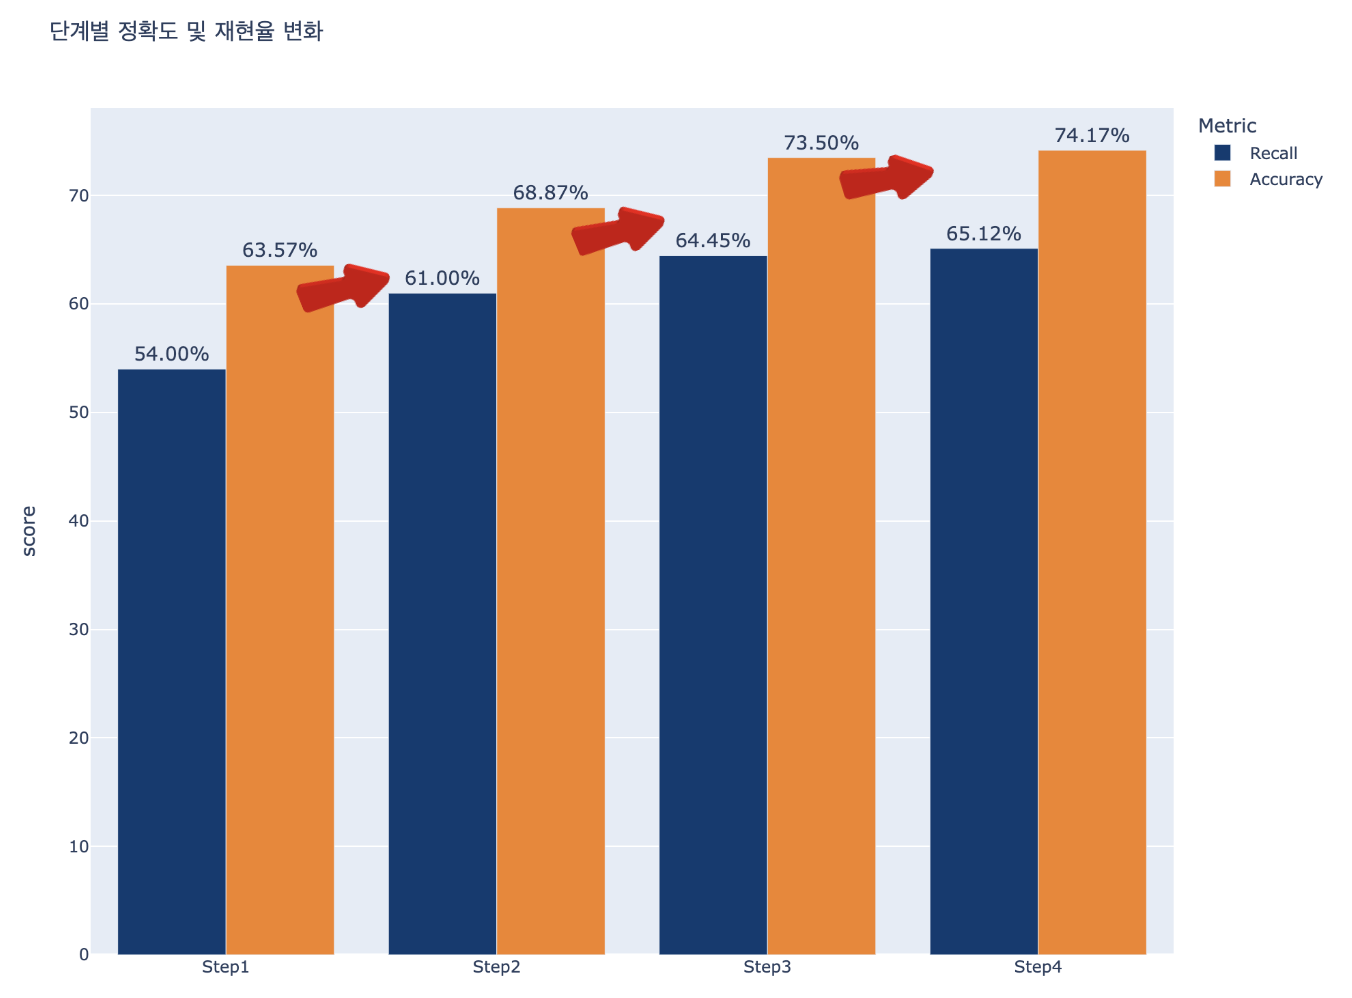

In [63]:
Image(filename = img_path +'모델링_평가지표.png')

# F, T, A 지표 modeling : Addtional Service

- 공모주 청약판단을 위한 투자 종합점수는 Final_model로 생성
- F, T, A의 각 변수들로만 시초/공모(%)에 대한 모델링을 진행하여 F, T, A의 각 score를 산출


#### 공모주의 투자판단 여부 : Final_model
#### F, T, A score : 부가 서비스에 활용 ex) 과거 유사한 종목 찾기, FTA 중 어떤 분야에 강점을 가진 기업인지 파악
#### 실제 Final_model에 사용한 변수
- F_feature = '매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR', 'ROE'
- T_feature = 'nsi_5', '업황','공모주 시장 동향'  
- A_feature = '유통가능물량비율', '기관경쟁률', '의무보유확약비율'

In [140]:
# F, T, A에 해당하는 변수 할당
F_feature = model_df[['매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR', 'ROE']]
T_feature = model_df[['nsi_5', '업황','공모주 시장 동향']]
A_feature = model_df[['유통가능물량비율', '기관경쟁률', '의무보유확약비율']]

# 1. F : Finance
- F_feature = '매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR', 'ROE'

In [141]:
F_feature.head(3)

매출액 증감율     EPS 증감율        자산비율        유동비율       예상 시가총액        PSR  \
0  37.513947 -226.171093  173.679148  210.541089  1.424822e+11   4.784407   
1   0.000000   48.434818  104.518626  919.636636  1.808655e+11  25.655490   
2  41.682254    5.516230  161.882346  166.827428  1.686400e+11  25.655490   

         ROE  
0  -5.158176  
1 -14.170600  
2 -10.327581

Borderline-SMOTE 적용 후 값의 분포:
 0    264
1    264
2    264
3    264
dtype: int64


<Axes: ylabel='count'>

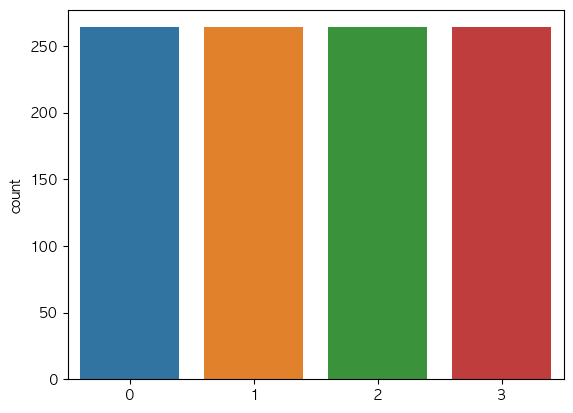

In [142]:
# 표준화
scaler = StandardScaler()
columns_to_scale = F_feature.columns
F_feature[columns_to_scale] = scaler.fit_transform(F_feature[columns_to_scale])

# F score
F_train, F_test, y_train, y_test = train_test_split(F_feature, y, test_size=0.2, random_state=random_state)

# Borderline-SMOTE를 사용하여 오버샘플링
borderline_smote = BorderlineSMOTE(random_state = random_state)
F_resampled, y_resampled = borderline_smote.fit_resample(F_train, y_train)

# 데이터 증강이 되었는지 확인
print('Borderline-SMOTE 적용 후 값의 분포:\n', pd.Series(y_resampled).value_counts())
sns.countplot(x=y_resampled, order=[0, 1, 2, 3])

In [143]:
# 다중분류 모델 설정
models = [
    ("Logistic Regression", LogisticRegression(multi_class='multinomial', max_iter=1000, random_state = random_state)),
    ("Support Vector Machines", SVC(decision_function_shape='ovr', random_state = random_state)),
    ("Random Forest", RandomForestClassifier(random_state = random_state)),
    ("XGBClassifier", XGBClassifier(objective='multi:softmax', num_class=num_class, random_state = random_state)),
    ("LGBMClassifier", LGBMClassifier(objective='multiclass', num_class=num_class, random_state = random_state)),
    ("CatBoostClassifier", CatBoostClassifier(random_state = random_state))
]

for name, model in models:
    model.fit(F_resampled, y_resampled)
    y_pred = model.predict(F_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}")

Logistic Regression - Accuracy: 0.33112582781456956
Support Vector Machines - Accuracy: 0.3443708609271523
Random Forest - Accuracy: 0.4503311258278146
XGBClassifier - Accuracy: 0.3708609271523179
LGBMClassifier - Accuracy: 0.40397350993377484
Learning rate set to 0.079347
0:	learn: 1.3641816	total: 1.63ms	remaining: 1.63s
1:	learn: 1.3397591	total: 3.19ms	remaining: 1.59s
2:	learn: 1.3175281	total: 4.72ms	remaining: 1.57s
3:	learn: 1.3004085	total: 6.21ms	remaining: 1.54s
4:	learn: 1.2847213	total: 7.82ms	remaining: 1.56s
5:	learn: 1.2698427	total: 9.27ms	remaining: 1.53s
6:	learn: 1.2514938	total: 10.8ms	remaining: 1.53s
7:	learn: 1.2377042	total: 12.2ms	remaining: 1.52s
8:	learn: 1.2258598	total: 13.7ms	remaining: 1.5s
9:	learn: 1.2137177	total: 15.3ms	remaining: 1.51s
10:	learn: 1.2009151	total: 16.9ms	remaining: 1.52s
11:	learn: 1.1878793	total: 18.4ms	remaining: 1.52s
12:	learn: 1.1768861	total: 20.1ms	remaining: 1.52s
13:	learn: 1.1672362	total: 21.5ms	remaining: 1.52s
14:	learn

265:	learn: 0.4479529	total: 396ms	remaining: 1.09s
266:	learn: 0.4459535	total: 398ms	remaining: 1.09s
267:	learn: 0.4446660	total: 400ms	remaining: 1.09s
268:	learn: 0.4436238	total: 402ms	remaining: 1.09s
269:	learn: 0.4424312	total: 403ms	remaining: 1.09s
270:	learn: 0.4406751	total: 405ms	remaining: 1.09s
271:	learn: 0.4397201	total: 407ms	remaining: 1.09s
272:	learn: 0.4383008	total: 409ms	remaining: 1.09s
273:	learn: 0.4372254	total: 410ms	remaining: 1.09s
274:	learn: 0.4356097	total: 412ms	remaining: 1.08s
275:	learn: 0.4348182	total: 413ms	remaining: 1.08s
276:	learn: 0.4338640	total: 415ms	remaining: 1.08s
277:	learn: 0.4328476	total: 416ms	remaining: 1.08s
278:	learn: 0.4320904	total: 417ms	remaining: 1.08s
279:	learn: 0.4306294	total: 419ms	remaining: 1.08s
280:	learn: 0.4293555	total: 420ms	remaining: 1.07s
281:	learn: 0.4279671	total: 422ms	remaining: 1.07s
282:	learn: 0.4268561	total: 423ms	remaining: 1.07s
283:	learn: 0.4258511	total: 424ms	remaining: 1.07s
284:	learn: 

534:	learn: 0.2365604	total: 795ms	remaining: 691ms
535:	learn: 0.2361810	total: 797ms	remaining: 690ms
536:	learn: 0.2359256	total: 799ms	remaining: 689ms
537:	learn: 0.2356169	total: 801ms	remaining: 688ms
538:	learn: 0.2352653	total: 802ms	remaining: 686ms
539:	learn: 0.2348001	total: 804ms	remaining: 685ms
540:	learn: 0.2341690	total: 806ms	remaining: 683ms
541:	learn: 0.2336388	total: 808ms	remaining: 683ms
542:	learn: 0.2329104	total: 810ms	remaining: 681ms
543:	learn: 0.2322749	total: 812ms	remaining: 680ms
544:	learn: 0.2319075	total: 814ms	remaining: 679ms
545:	learn: 0.2313019	total: 815ms	remaining: 678ms
546:	learn: 0.2309959	total: 817ms	remaining: 677ms
547:	learn: 0.2302212	total: 819ms	remaining: 676ms
548:	learn: 0.2296975	total: 821ms	remaining: 674ms
549:	learn: 0.2291916	total: 822ms	remaining: 673ms
550:	learn: 0.2287190	total: 824ms	remaining: 672ms
551:	learn: 0.2283668	total: 826ms	remaining: 670ms
552:	learn: 0.2281363	total: 827ms	remaining: 669ms
553:	learn: 

800:	learn: 0.1490603	total: 1.19s	remaining: 296ms
801:	learn: 0.1488208	total: 1.19s	remaining: 295ms
802:	learn: 0.1486699	total: 1.2s	remaining: 293ms
803:	learn: 0.1484686	total: 1.2s	remaining: 292ms
804:	learn: 0.1482627	total: 1.2s	remaining: 290ms
805:	learn: 0.1479434	total: 1.2s	remaining: 289ms
806:	learn: 0.1477403	total: 1.2s	remaining: 287ms
807:	learn: 0.1474636	total: 1.2s	remaining: 286ms
808:	learn: 0.1473510	total: 1.21s	remaining: 285ms
809:	learn: 0.1471660	total: 1.21s	remaining: 283ms
810:	learn: 0.1469067	total: 1.21s	remaining: 282ms
811:	learn: 0.1466201	total: 1.21s	remaining: 280ms
812:	learn: 0.1463717	total: 1.21s	remaining: 279ms
813:	learn: 0.1462309	total: 1.21s	remaining: 277ms
814:	learn: 0.1459808	total: 1.21s	remaining: 276ms
815:	learn: 0.1457847	total: 1.22s	remaining: 274ms
816:	learn: 0.1455650	total: 1.22s	remaining: 273ms
817:	learn: 0.1452984	total: 1.22s	remaining: 271ms
818:	learn: 0.1451270	total: 1.22s	remaining: 270ms
819:	learn: 0.1446

## 1) LogisticRegression : softmax

In [144]:
logreg = LogisticRegression(multi_class='multinomial', random_state = random_state)

# 파라미터 범위
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],           # 규제 강도 파라미터
    'penalty': ['l1', 'l2'],                  # 규제 유형 (L1 또는 L2)
    'max_iter': [150, 200, 250, 300],         # 최대 반복 횟수
    'class_weight': [None, 'balanced'],       # 클래스별 가중치
    'solver': ['lbfgs', 'sag', 'newton-cg'],  # 최적화 알고리즘
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(F_resampled, y_resampled)

logreg_F = grid_search.best_estimator_
y_pred = logreg_F.predict(F_test)

accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 150, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy: 0.33112582781456956


## 2) Support Vector Machines : SVC

In [145]:
# ovr : One-vs-Rest가 ovo와 성능은 차이가 없는데 계산량이 월등히 빨라 ovr을 선택
svc = SVC(decision_function_shape='ovr', probability=True)

# 파라미터 범위
param_grid = {
    'C': [0.1, 1, 10,100],           # 규제 파라미터
    'kernel': ['linear', 'rbf'],     # 커널 종류
    'gamma': ['scale', 'auto']       # gamma 값
}

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(F_resampled, y_resampled)

svc_F = grid_search.best_estimator_
y_pred = svc_F.predict(F_test)

accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.3576158940397351


## 3) RandomForest : Bagging

In [146]:
rf = RandomForestClassifier(criterion = 'entropy', class_weight = 'balanced', n_jobs=-1, random_state=random_state)

# 파라미터 범위
param_grid = {
    'n_estimators': [200, 250, 300, 350, 400],  # 결정 트리의 개수
    'max_depth': [15, 20, 25, 30, 35],          # 트리의 최대 깊이
    'min_samples_split': [1, 2, 3],             # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1],                    # 리프 노드의 최소 샘플 수
    'max_features': ['sqrt']                    # 최대 피처 개수
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(F_resampled, y_resampled)

rf_F = grid_search.best_estimator_
y_pred = rf_F.predict(F_test)

accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Test Accuracy: 0.41721854304635764


## 4) XGBClassifier : xgboost

In [147]:
# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'max_depth': trial.suggest_int('max_depth', 30, 35),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10),
        'objective': 'multi:softmax',
        'num_class': num_class
    }


    model = XGBClassifier(**params, random_state = random_state)
    model.fit(F_resampled, y_resampled)
    y_pred = model.predict(F_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
xgb_F = optuna.create_study(direction='maximize')
xgb_F.optimize(objective, n_trials=300)

print("Test parameters:", xgb_F.best_params)
print("Test Accuracy:", xgb_F.best_value)

[I 2023-09-10 21:00:06,904] A new study created in memory with name: no-name-e91fde70-afc0-458f-ab23-2e6636cacb34
[I 2023-09-10 21:00:07,704] Trial 0 finished with value: 0.3973509933774834 and parameters: {'max_depth': 30, 'learning_rate': 0.06970282255300517, 'n_estimators': 838, 'min_child_weight': 2, 'subsample': 0.679293019685125, 'colsample_bytree': 0.7039203484409462, 'reg_alpha': 8.876988638188672, 'reg_lambda': 7.406171621260242}. Best is trial 0 with value: 0.3973509933774834.
[I 2023-09-10 21:00:08,221] Trial 1 finished with value: 0.41721854304635764 and parameters: {'max_depth': 33, 'learning_rate': 0.053413176649264045, 'n_estimators': 247, 'min_child_weight': 1, 'subsample': 0.9174543686339082, 'colsample_bytree': 0.6689809386457496, 'reg_alpha': 4.882633218969673, 'reg_lambda': 8.621628574369936}. Best is trial 1 with value: 0.41721854304635764.
[I 2023-09-10 21:00:09,537] Trial 2 finished with value: 0.40397350993377484 and parameters: {'max_depth': 30, 'learning_rate'

[I 2023-09-10 21:00:26,613] Trial 22 finished with value: 0.4304635761589404 and parameters: {'max_depth': 33, 'learning_rate': 0.07986803930078457, 'n_estimators': 632, 'min_child_weight': 2, 'subsample': 0.6553765894571842, 'colsample_bytree': 0.8855353116512299, 'reg_alpha': 7.964376013826161, 'reg_lambda': 5.167042611503845}. Best is trial 16 with value: 0.44370860927152317.
[I 2023-09-10 21:00:27,455] Trial 23 finished with value: 0.4304635761589404 and parameters: {'max_depth': 32, 'learning_rate': 0.07532184054679561, 'n_estimators': 773, 'min_child_weight': 2, 'subsample': 0.7440719058414539, 'colsample_bytree': 0.9186091004444349, 'reg_alpha': 8.954311827707194, 'reg_lambda': 6.7036535889393525}. Best is trial 16 with value: 0.44370860927152317.
[I 2023-09-10 21:00:28,423] Trial 24 finished with value: 0.4304635761589404 and parameters: {'max_depth': 34, 'learning_rate': 0.06525282060631282, 'n_estimators': 647, 'min_child_weight': 1, 'subsample': 0.7082860581744975, 'colsampl

[I 2023-09-10 21:00:48,179] Trial 44 finished with value: 0.4304635761589404 and parameters: {'max_depth': 35, 'learning_rate': 0.04956510097209678, 'n_estimators': 565, 'min_child_weight': 1, 'subsample': 0.8179671591290478, 'colsample_bytree': 0.9398911719148553, 'reg_alpha': 9.797377057793607, 'reg_lambda': 5.1328388825894375}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:00:49,273] Trial 45 finished with value: 0.44370860927152317 and parameters: {'max_depth': 35, 'learning_rate': 0.04620468856525484, 'n_estimators': 849, 'min_child_weight': 1, 'subsample': 0.7821225653690963, 'colsample_bytree': 0.9700430537713265, 'reg_alpha': 8.648118515631351, 'reg_lambda': 2.0238602118208524}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:00:49,911] Trial 46 finished with value: 0.45695364238410596 and parameters: {'max_depth': 34, 'learning_rate': 0.06089680973061504, 'n_estimators': 317, 'min_child_weight': 1, 'subsample': 0.8347679134541997, 'colsa

[I 2023-09-10 21:01:00,445] Trial 66 finished with value: 0.4370860927152318 and parameters: {'max_depth': 34, 'learning_rate': 0.06062677726098687, 'n_estimators': 306, 'min_child_weight': 1, 'subsample': 0.867102545918381, 'colsample_bytree': 0.9599861793412561, 'reg_alpha': 7.657951423819311, 'reg_lambda': 3.520162681106274}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:01:00,919] Trial 67 finished with value: 0.4503311258278146 and parameters: {'max_depth': 34, 'learning_rate': 0.06478359394598032, 'n_estimators': 215, 'min_child_weight': 1, 'subsample': 0.8437584656522255, 'colsample_bytree': 0.9431751670093673, 'reg_alpha': 6.5632943016235, 'reg_lambda': 4.000970138185259}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:01:01,501] Trial 68 finished with value: 0.423841059602649 and parameters: {'max_depth': 33, 'learning_rate': 0.0687469459553725, 'n_estimators': 365, 'min_child_weight': 2, 'subsample': 0.8281642311336946, 'colsample_bytr

[I 2023-09-10 21:01:18,799] Trial 88 finished with value: 0.44370860927152317 and parameters: {'max_depth': 35, 'learning_rate': 0.05881269017949531, 'n_estimators': 300, 'min_child_weight': 1, 'subsample': 0.8280743020513307, 'colsample_bytree': 0.9532786502953653, 'reg_alpha': 7.1859807665548985, 'reg_lambda': 3.8869255662862723}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:01:19,452] Trial 89 finished with value: 0.3973509933774834 and parameters: {'max_depth': 30, 'learning_rate': 0.067858105487352, 'n_estimators': 227, 'min_child_weight': 3, 'subsample': 0.7505880668515681, 'colsample_bytree': 0.8995759142746648, 'reg_alpha': 6.986171945623323, 'reg_lambda': 4.180782546376361}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:01:20,167] Trial 90 finished with value: 0.4370860927152318 and parameters: {'max_depth': 34, 'learning_rate': 0.07290334588966056, 'n_estimators': 332, 'min_child_weight': 1, 'subsample': 0.8017619018502795, 'colsampl

[I 2023-09-10 21:01:34,276] Trial 110 finished with value: 0.4105960264900662 and parameters: {'max_depth': 34, 'learning_rate': 0.05775577656637138, 'n_estimators': 235, 'min_child_weight': 1, 'subsample': 0.8224283554859915, 'colsample_bytree': 0.9106704982944178, 'reg_alpha': 9.171656024916427, 'reg_lambda': 4.806576588653204}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:01:34,685] Trial 111 finished with value: 0.4370860927152318 and parameters: {'max_depth': 33, 'learning_rate': 0.07026118642443605, 'n_estimators': 218, 'min_child_weight': 1, 'subsample': 0.8205364776622459, 'colsample_bytree': 0.9041542275383531, 'reg_alpha': 8.60669792117885, 'reg_lambda': 4.298407282293673}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:01:35,068] Trial 112 finished with value: 0.4503311258278146 and parameters: {'max_depth': 33, 'learning_rate': 0.06685049695087115, 'n_estimators': 192, 'min_child_weight': 1, 'subsample': 0.8310355844057572, 'colsamp

[I 2023-09-10 21:01:49,787] Trial 132 finished with value: 0.4370860927152318 and parameters: {'max_depth': 33, 'learning_rate': 0.053085840487386106, 'n_estimators': 220, 'min_child_weight': 1, 'subsample': 0.8314443243609739, 'colsample_bytree': 0.9331996510202287, 'reg_alpha': 8.838013466444524, 'reg_lambda': 4.132264112034028}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:01:50,179] Trial 133 finished with value: 0.4304635761589404 and parameters: {'max_depth': 33, 'learning_rate': 0.061080718269468544, 'n_estimators': 178, 'min_child_weight': 1, 'subsample': 0.8489320085508019, 'colsample_bytree': 0.9234551391551736, 'reg_alpha': 9.320328365625292, 'reg_lambda': 5.399284829022847}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:01:50,672] Trial 134 finished with value: 0.4503311258278146 and parameters: {'max_depth': 33, 'learning_rate': 0.06315977788025755, 'n_estimators': 244, 'min_child_weight': 1, 'subsample': 0.8247334543210418, 'cols

[I 2023-09-10 21:02:06,761] Trial 154 finished with value: 0.4503311258278146 and parameters: {'max_depth': 35, 'learning_rate': 0.05117670529956631, 'n_estimators': 211, 'min_child_weight': 1, 'subsample': 0.8254987944872522, 'colsample_bytree': 0.8916359139270291, 'reg_alpha': 8.772641185006252, 'reg_lambda': 2.9448276402853497}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:02:07,313] Trial 155 finished with value: 0.44370860927152317 and parameters: {'max_depth': 35, 'learning_rate': 0.05263225546916582, 'n_estimators': 278, 'min_child_weight': 1, 'subsample': 0.8599170255240911, 'colsample_bytree': 0.9029601956174976, 'reg_alpha': 7.849244591689742, 'reg_lambda': 3.7116540342497295}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:02:08,357] Trial 156 finished with value: 0.423841059602649 and parameters: {'max_depth': 34, 'learning_rate': 0.061311019164700636, 'n_estimators': 760, 'min_child_weight': 1, 'subsample': 0.8809601106350123, 'col

[I 2023-09-10 21:02:25,684] Trial 176 finished with value: 0.45695364238410596 and parameters: {'max_depth': 31, 'learning_rate': 0.052173879489298886, 'n_estimators': 923, 'min_child_weight': 1, 'subsample': 0.8169933057167991, 'colsample_bytree': 0.8881765738547742, 'reg_alpha': 6.975577803089483, 'reg_lambda': 4.907651045741675}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:02:26,156] Trial 177 finished with value: 0.44370860927152317 and parameters: {'max_depth': 32, 'learning_rate': 0.05961784698332308, 'n_estimators': 273, 'min_child_weight': 1, 'subsample': 0.8380821551572467, 'colsample_bytree': 0.8648544833486049, 'reg_alpha': 8.987346681402652, 'reg_lambda': 4.155814079556752}. Best is trial 37 with value: 0.46357615894039733.
[I 2023-09-10 21:02:26,881] Trial 178 finished with value: 0.46357615894039733 and parameters: {'max_depth': 35, 'learning_rate': 0.067853533179133, 'n_estimators': 491, 'min_child_weight': 1, 'subsample': 0.8525018484527562, 'cols

[I 2023-09-10 21:02:41,234] Trial 198 finished with value: 0.4503311258278146 and parameters: {'max_depth': 34, 'learning_rate': 0.06945805101304173, 'n_estimators': 591, 'min_child_weight': 1, 'subsample': 0.826479270248026, 'colsample_bytree': 0.9199328228728477, 'reg_alpha': 7.949296949936454, 'reg_lambda': 4.548631045231529}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:02:42,170] Trial 199 finished with value: 0.4304635761589404 and parameters: {'max_depth': 34, 'learning_rate': 0.07208299313828921, 'n_estimators': 776, 'min_child_weight': 1, 'subsample': 0.7828468227667873, 'colsample_bytree': 0.9081566438140534, 'reg_alpha': 8.217769213793238, 'reg_lambda': 4.874366299131052}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:02:42,976] Trial 200 finished with value: 0.4370860927152318 and parameters: {'max_depth': 34, 'learning_rate': 0.06753796472661083, 'n_estimators': 661, 'min_child_weight': 1, 'subsample': 0.8667620628911861, 'colsa

[I 2023-09-10 21:03:00,683] Trial 220 finished with value: 0.4370860927152318 and parameters: {'max_depth': 35, 'learning_rate': 0.05870614263756782, 'n_estimators': 210, 'min_child_weight': 1, 'subsample': 0.8284158281687207, 'colsample_bytree': 0.9576036889764497, 'reg_alpha': 9.13214477155485, 'reg_lambda': 3.249512025674981}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:03:01,232] Trial 221 finished with value: 0.4503311258278146 and parameters: {'max_depth': 35, 'learning_rate': 0.05606111456004104, 'n_estimators': 296, 'min_child_weight': 1, 'subsample': 0.8441333142142411, 'colsample_bytree': 0.886182198330037, 'reg_alpha': 8.44442107328385, 'reg_lambda': 3.631523926823146}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:03:01,759] Trial 222 finished with value: 0.44370860927152317 and parameters: {'max_depth': 35, 'learning_rate': 0.05377520200843071, 'n_estimators': 273, 'min_child_weight': 1, 'subsample': 0.8487711546723362, 'colsam

[I 2023-09-10 21:03:20,106] Trial 242 finished with value: 0.44370860927152317 and parameters: {'max_depth': 35, 'learning_rate': 0.05121179166775906, 'n_estimators': 982, 'min_child_weight': 1, 'subsample': 0.8302569996720434, 'colsample_bytree': 0.9335086136530748, 'reg_alpha': 9.514054277521412, 'reg_lambda': 4.7585691606876415}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:03:21,261] Trial 243 finished with value: 0.4503311258278146 and parameters: {'max_depth': 35, 'learning_rate': 0.05432148407654931, 'n_estimators': 942, 'min_child_weight': 1, 'subsample': 0.8414413426378137, 'colsample_bytree': 0.9873520970621472, 'reg_alpha': 8.762173825911567, 'reg_lambda': 4.297856322617948}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:03:22,585] Trial 244 finished with value: 0.4503311258278146 and parameters: {'max_depth': 35, 'learning_rate': 0.048565404171404404, 'n_estimators': 986, 'min_child_weight': 1, 'subsample': 0.8336750356174819, 'c

[I 2023-09-10 21:03:40,969] Trial 264 finished with value: 0.46357615894039733 and parameters: {'max_depth': 35, 'learning_rate': 0.09721740723735817, 'n_estimators': 727, 'min_child_weight': 1, 'subsample': 0.7909290643454745, 'colsample_bytree': 0.8734892536217507, 'reg_alpha': 7.275820940838341, 'reg_lambda': 5.138417276203456}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:03:42,065] Trial 265 finished with value: 0.4304635761589404 and parameters: {'max_depth': 35, 'learning_rate': 0.07540428240108712, 'n_estimators': 800, 'min_child_weight': 1, 'subsample': 0.793183924345253, 'colsample_bytree': 0.8690052766654557, 'reg_alpha': 7.268780030089305, 'reg_lambda': 5.1772054936808125}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:03:43,081] Trial 266 finished with value: 0.4370860927152318 and parameters: {'max_depth': 34, 'learning_rate': 0.08479289367053543, 'n_estimators': 724, 'min_child_weight': 1, 'subsample': 0.8029259823756412, 'col

[I 2023-09-10 21:03:58,893] Trial 286 finished with value: 0.4503311258278146 and parameters: {'max_depth': 35, 'learning_rate': 0.08933920777514878, 'n_estimators': 179, 'min_child_weight': 1, 'subsample': 0.8385511837364082, 'colsample_bytree': 0.8832707172700556, 'reg_alpha': 8.228905557506874, 'reg_lambda': 4.4536770137439}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:03:59,776] Trial 287 finished with value: 0.4503311258278146 and parameters: {'max_depth': 35, 'learning_rate': 0.09842451411399572, 'n_estimators': 855, 'min_child_weight': 1, 'subsample': 0.8148390407520711, 'colsample_bytree': 0.872988637834906, 'reg_alpha': 8.737240411373415, 'reg_lambda': 3.940723701681921}. Best is trial 191 with value: 0.47019867549668876.
[I 2023-09-10 21:04:00,510] Trial 288 finished with value: 0.4304635761589404 and parameters: {'max_depth': 33, 'learning_rate': 0.08210057568227383, 'n_estimators': 597, 'min_child_weight': 1, 'subsample': 0.8890968651069188, 'colsamp

Test parameters: {'max_depth': 34, 'learning_rate': 0.07085637678851092, 'n_estimators': 618, 'min_child_weight': 1, 'subsample': 0.8524794959563199, 'colsample_bytree': 0.8993923163309002, 'reg_alpha': 8.424588128828642, 'reg_lambda': 4.229851449040308}
Test Accuracy: 0.47019867549668876


## 5) LGBClassifier : lightgbm

In [148]:
# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10),
        'objective': 'multiclass',
        'num_class': num_class
    }

    model = LGBMClassifier(**params, random_state=random_state)
    model.fit(F_resampled, y_resampled)
    y_pred = model.predict(F_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
lgbm_F = optuna.create_study(direction='maximize')
lgbm_F.optimize(objective, n_trials=300)

print("Test parameters:", lgbm_F.best_params)
print("Test Accuracy:", lgbm_F.best_value)

[I 2023-09-10 21:04:09,874] A new study created in memory with name: no-name-9816a2be-f65b-4c99-90af-66a69df70cdd
[I 2023-09-10 21:04:10,247] Trial 0 finished with value: 0.3973509933774834 and parameters: {'max_depth': 4, 'learning_rate': 0.07245431562764515, 'n_estimators': 246, 'min_child_samples': 5, 'subsample': 0.8058428776596562, 'colsample_bytree': 0.9605567023034052, 'reg_alpha': 1.065376182228603, 'reg_lambda': 2.7200159490133218}. Best is trial 0 with value: 0.3973509933774834.
[I 2023-09-10 21:04:11,252] Trial 1 finished with value: 0.4304635761589404 and parameters: {'max_depth': 44, 'learning_rate': 0.026618347262046503, 'n_estimators': 581, 'min_child_samples': 8, 'subsample': 0.8899563395827015, 'colsample_bytree': 0.9605887432555483, 'reg_alpha': 2.2618426587598868, 'reg_lambda': 6.754755527488519}. Best is trial 1 with value: 0.4304635761589404.
[I 2023-09-10 21:04:11,439] Trial 2 finished with value: 0.3973509933774834 and parameters: {'max_depth': 14, 'learning_rate

[I 2023-09-10 21:04:26,214] Trial 22 finished with value: 0.4370860927152318 and parameters: {'max_depth': 29, 'learning_rate': 0.05510672608524381, 'n_estimators': 891, 'min_child_samples': 6, 'subsample': 0.8140836393656946, 'colsample_bytree': 0.9451876812113681, 'reg_alpha': 3.2364851362980342, 'reg_lambda': 4.284880163776806}. Best is trial 21 with value: 0.4370860927152318.
[I 2023-09-10 21:04:26,578] Trial 23 finished with value: 0.4370860927152318 and parameters: {'max_depth': 21, 'learning_rate': 0.05624681051511983, 'n_estimators': 915, 'min_child_samples': 6, 'subsample': 0.8827154823438103, 'colsample_bytree': 0.927720623730899, 'reg_alpha': 3.851576832427217, 'reg_lambda': 3.699181397643963}. Best is trial 21 with value: 0.4370860927152318.
[I 2023-09-10 21:04:26,964] Trial 24 finished with value: 0.44370860927152317 and parameters: {'max_depth': 18, 'learning_rate': 0.05644499955308497, 'n_estimators': 890, 'min_child_samples': 4, 'subsample': 0.7922135826260303, 'colsamp

[I 2023-09-10 21:04:33,255] Trial 44 finished with value: 0.39072847682119205 and parameters: {'max_depth': 6, 'learning_rate': 0.06124821747328226, 'n_estimators': 939, 'min_child_samples': 4, 'subsample': 0.7548962258140317, 'colsample_bytree': 0.8893091203229444, 'reg_alpha': 7.714915275504031, 'reg_lambda': 5.2675601528602165}. Best is trial 28 with value: 0.45695364238410596.
[I 2023-09-10 21:04:33,771] Trial 45 finished with value: 0.41721854304635764 and parameters: {'max_depth': 23, 'learning_rate': 0.04479493773037512, 'n_estimators': 887, 'min_child_samples': 5, 'subsample': 0.7828882919937158, 'colsample_bytree': 0.8392298687423244, 'reg_alpha': 3.828258226832928, 'reg_lambda': 3.1928235757089634}. Best is trial 28 with value: 0.45695364238410596.
[I 2023-09-10 21:04:34,160] Trial 46 finished with value: 0.44370860927152317 and parameters: {'max_depth': 9, 'learning_rate': 0.05357411907766468, 'n_estimators': 806, 'min_child_samples': 3, 'subsample': 0.7340983986045778, 'col

[I 2023-09-10 21:04:40,051] Trial 66 finished with value: 0.45695364238410596 and parameters: {'max_depth': 37, 'learning_rate': 0.08067439455562915, 'n_estimators': 862, 'min_child_samples': 3, 'subsample': 0.7245585897367343, 'colsample_bytree': 0.8838355349013075, 'reg_alpha': 4.881349163013025, 'reg_lambda': 1.7856922350235915}. Best is trial 28 with value: 0.45695364238410596.
[I 2023-09-10 21:04:40,275] Trial 67 finished with value: 0.4370860927152318 and parameters: {'max_depth': 39, 'learning_rate': 0.08301887376045075, 'n_estimators': 901, 'min_child_samples': 3, 'subsample': 0.6853431890242072, 'colsample_bytree': 0.8772248680894131, 'reg_alpha': 4.832920549576213, 'reg_lambda': 1.4952092468989981}. Best is trial 28 with value: 0.45695364238410596.
[I 2023-09-10 21:04:40,516] Trial 68 finished with value: 0.4503311258278146 and parameters: {'max_depth': 44, 'learning_rate': 0.0749638419526981, 'n_estimators': 865, 'min_child_samples': 2, 'subsample': 0.7675168740916382, 'cols

[I 2023-09-10 21:04:45,816] Trial 88 finished with value: 0.423841059602649 and parameters: {'max_depth': 14, 'learning_rate': 0.06191653697120869, 'n_estimators': 917, 'min_child_samples': 2, 'subsample': 0.6879916935580773, 'colsample_bytree': 0.7880277561869005, 'reg_alpha': 3.544207932105444, 'reg_lambda': 3.2715548451984615}. Best is trial 87 with value: 0.46357615894039733.
[I 2023-09-10 21:04:46,146] Trial 89 finished with value: 0.44370860927152317 and parameters: {'max_depth': 17, 'learning_rate': 0.05720430743381471, 'n_estimators': 977, 'min_child_samples': 1, 'subsample': 0.6753060270243221, 'colsample_bytree': 0.8179067916684233, 'reg_alpha': 4.623470914928677, 'reg_lambda': 3.7254004209584357}. Best is trial 87 with value: 0.46357615894039733.
[I 2023-09-10 21:04:46,517] Trial 90 finished with value: 0.4370860927152318 and parameters: {'max_depth': 10, 'learning_rate': 0.053118737179991174, 'n_estimators': 854, 'min_child_samples': 2, 'subsample': 0.7461507509747116, 'col

[I 2023-09-10 21:04:52,113] Trial 110 finished with value: 0.4503311258278146 and parameters: {'max_depth': 13, 'learning_rate': 0.05464930010046489, 'n_estimators': 833, 'min_child_samples': 2, 'subsample': 0.759330518655109, 'colsample_bytree': 0.8359722676534306, 'reg_alpha': 5.133286635183402, 'reg_lambda': 2.24738669003369}. Best is trial 87 with value: 0.46357615894039733.
[I 2023-09-10 21:04:52,411] Trial 111 finished with value: 0.4304635761589404 and parameters: {'max_depth': 17, 'learning_rate': 0.064488660845338, 'n_estimators': 946, 'min_child_samples': 3, 'subsample': 0.7306174247229634, 'colsample_bytree': 0.90690302134419, 'reg_alpha': 4.353729294162287, 'reg_lambda': 2.669338768737777}. Best is trial 87 with value: 0.46357615894039733.
[I 2023-09-10 21:04:52,681] Trial 112 finished with value: 0.45695364238410596 and parameters: {'max_depth': 20, 'learning_rate': 0.07116285999054525, 'n_estimators': 985, 'min_child_samples': 3, 'subsample': 0.7399564269517397, 'colsampl

[I 2023-09-10 21:04:58,272] Trial 132 finished with value: 0.3973509933774834 and parameters: {'max_depth': 5, 'learning_rate': 0.050501231033599936, 'n_estimators': 855, 'min_child_samples': 5, 'subsample': 0.6936315388017381, 'colsample_bytree': 0.8854433008249964, 'reg_alpha': 4.710127699030945, 'reg_lambda': 2.1286303322498266}. Best is trial 87 with value: 0.46357615894039733.
[I 2023-09-10 21:04:58,601] Trial 133 finished with value: 0.4370860927152318 and parameters: {'max_depth': 21, 'learning_rate': 0.04555471778909357, 'n_estimators': 883, 'min_child_samples': 3, 'subsample': 0.7562756237570324, 'colsample_bytree': 0.8958421248719497, 'reg_alpha': 4.859869680178927, 'reg_lambda': 1.6504744899578767}. Best is trial 87 with value: 0.46357615894039733.
[I 2023-09-10 21:04:58,832] Trial 134 finished with value: 0.3973509933774834 and parameters: {'max_depth': 42, 'learning_rate': 0.06855381350452669, 'n_estimators': 744, 'min_child_samples': 6, 'subsample': 0.719133399412478, 'co

[I 2023-09-10 21:05:04,622] Trial 154 finished with value: 0.4370860927152318 and parameters: {'max_depth': 16, 'learning_rate': 0.06247874120346202, 'n_estimators': 918, 'min_child_samples': 5, 'subsample': 0.7003926394512457, 'colsample_bytree': 0.9052191529313096, 'reg_alpha': 4.73967673082274, 'reg_lambda': 3.789342275933656}. Best is trial 87 with value: 0.46357615894039733.
[I 2023-09-10 21:05:05,008] Trial 155 finished with value: 0.44370860927152317 and parameters: {'max_depth': 27, 'learning_rate': 0.06577622687625474, 'n_estimators': 904, 'min_child_samples': 3, 'subsample': 0.7264894822650176, 'colsample_bytree': 0.9601313771483785, 'reg_alpha': 3.458011594243597, 'reg_lambda': 2.266489242131448}. Best is trial 87 with value: 0.46357615894039733.
[I 2023-09-10 21:05:05,266] Trial 156 finished with value: 0.4105960264900662 and parameters: {'max_depth': 36, 'learning_rate': 0.06805937661095354, 'n_estimators': 806, 'min_child_samples': 2, 'subsample': 0.7513160281162338, 'col

[I 2023-09-10 21:05:10,393] Trial 176 finished with value: 0.4304635761589404 and parameters: {'max_depth': 29, 'learning_rate': 0.08115717046089777, 'n_estimators': 882, 'min_child_samples': 3, 'subsample': 0.6637896669956603, 'colsample_bytree': 0.8299859428430034, 'reg_alpha': 5.059410883038974, 'reg_lambda': 2.470581017481301}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:10,720] Trial 177 finished with value: 0.39072847682119205 and parameters: {'max_depth': 33, 'learning_rate': 0.04757198176992866, 'n_estimators': 899, 'min_child_samples': 3, 'subsample': 0.641884788201319, 'colsample_bytree': 0.774205651462477, 'reg_alpha': 5.480399460365452, 'reg_lambda': 4.35291518934947}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:10,948] Trial 178 finished with value: 0.44370860927152317 and parameters: {'max_depth': 26, 'learning_rate': 0.09502948034769729, 'n_estimators': 853, 'min_child_samples': 3, 'subsample': 0.6860234343692516, 'co

[I 2023-09-10 21:05:16,456] Trial 198 finished with value: 0.4304635761589404 and parameters: {'max_depth': 38, 'learning_rate': 0.08251843678935288, 'n_estimators': 869, 'min_child_samples': 3, 'subsample': 0.757108175449511, 'colsample_bytree': 0.8156070757907374, 'reg_alpha': 5.0900135033315586, 'reg_lambda': 2.02100363495526}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:16,653] Trial 199 finished with value: 0.41721854304635764 and parameters: {'max_depth': 37, 'learning_rate': 0.0890341809825144, 'n_estimators': 893, 'min_child_samples': 3, 'subsample': 0.7914089423973132, 'colsample_bytree': 0.8417176402519705, 'reg_alpha': 5.665661728922412, 'reg_lambda': 1.3191966907915693}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:16,860] Trial 200 finished with value: 0.423841059602649 and parameters: {'max_depth': 40, 'learning_rate': 0.08580122330621248, 'n_estimators': 820, 'min_child_samples': 2, 'subsample': 0.7714301456665602, 'co

[I 2023-09-10 21:05:22,455] Trial 220 finished with value: 0.44370860927152317 and parameters: {'max_depth': 22, 'learning_rate': 0.04170753822606792, 'n_estimators': 830, 'min_child_samples': 3, 'subsample': 0.7490406292581029, 'colsample_bytree': 0.8587552633930307, 'reg_alpha': 5.2482897056209845, 'reg_lambda': 1.343610709874501}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:22,924] Trial 221 finished with value: 0.4370860927152318 and parameters: {'max_depth': 21, 'learning_rate': 0.04332575079339351, 'n_estimators': 798, 'min_child_samples': 3, 'subsample': 0.727719075206927, 'colsample_bytree': 0.8852678046841167, 'reg_alpha': 4.830752411445797, 'reg_lambda': 1.4300797245595422}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:23,327] Trial 222 finished with value: 0.44370860927152317 and parameters: {'max_depth': 19, 'learning_rate': 0.044160264052550156, 'n_estimators': 872, 'min_child_samples': 3, 'subsample': 0.7602140798220637

[I 2023-09-10 21:05:30,299] Trial 242 finished with value: 0.44370860927152317 and parameters: {'max_depth': 27, 'learning_rate': 0.028440385466889016, 'n_estimators': 708, 'min_child_samples': 3, 'subsample': 0.7333919048701426, 'colsample_bytree': 0.8491071670706084, 'reg_alpha': 4.679400234221257, 'reg_lambda': 1.8746710906365345}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:30,552] Trial 243 finished with value: 0.4304635761589404 and parameters: {'max_depth': 29, 'learning_rate': 0.07585971524409679, 'n_estimators': 860, 'min_child_samples': 3, 'subsample': 0.723365581411579, 'colsample_bytree': 0.8926909944068393, 'reg_alpha': 5.130478483382774, 'reg_lambda': 2.412476752180721}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:30,783] Trial 244 finished with value: 0.4304635761589404 and parameters: {'max_depth': 28, 'learning_rate': 0.07186434339750251, 'n_estimators': 728, 'min_child_samples': 3, 'subsample': 0.7416128127475341, 

[I 2023-09-10 21:05:37,582] Trial 264 finished with value: 0.39072847682119205 and parameters: {'max_depth': 39, 'learning_rate': 0.049174613834737264, 'n_estimators': 866, 'min_child_samples': 3, 'subsample': 0.7614093766009268, 'colsample_bytree': 0.7673590316246749, 'reg_alpha': 4.564092939275055, 'reg_lambda': 1.0420468206340578}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:37,923] Trial 265 finished with value: 0.4304635761589404 and parameters: {'max_depth': 19, 'learning_rate': 0.04552111603335886, 'n_estimators': 887, 'min_child_samples': 2, 'subsample': 0.716956307667265, 'colsample_bytree': 0.9262141702076626, 'reg_alpha': 4.886306806344593, 'reg_lambda': 1.8991275698978611}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:38,211] Trial 266 finished with value: 0.41721854304635764 and parameters: {'max_depth': 34, 'learning_rate': 0.06159418085058383, 'n_estimators': 933, 'min_child_samples': 7, 'subsample': 0.6839348978553602

[I 2023-09-10 21:05:44,674] Trial 286 finished with value: 0.4370860927152318 and parameters: {'max_depth': 36, 'learning_rate': 0.08686772690825446, 'n_estimators': 868, 'min_child_samples': 3, 'subsample': 0.7938650330960192, 'colsample_bytree': 0.9188109445103567, 'reg_alpha': 4.941611820895693, 'reg_lambda': 2.7356141416381377}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:44,923] Trial 287 finished with value: 0.4304635761589404 and parameters: {'max_depth': 19, 'learning_rate': 0.08030504366091377, 'n_estimators': 803, 'min_child_samples': 2, 'subsample': 0.7524250224410912, 'colsample_bytree': 0.8775900095474654, 'reg_alpha': 4.69599940106791, 'reg_lambda': 0.24440196977164952}. Best is trial 168 with value: 0.47019867549668876.
[I 2023-09-10 21:05:45,444] Trial 288 finished with value: 0.4370860927152318 and parameters: {'max_depth': 18, 'learning_rate': 0.037722931665944155, 'n_estimators': 922, 'min_child_samples': 3, 'subsample': 0.6312608174872203,

Test parameters: {'max_depth': 31, 'learning_rate': 0.05041590458848316, 'n_estimators': 893, 'min_child_samples': 3, 'subsample': 0.6406380825598429, 'colsample_bytree': 0.8111556908615422, 'reg_alpha': 4.749425712641653, 'reg_lambda': 2.6935319889207943}
Test Accuracy: 0.47019867549668876


## 6) CatBoostClassifier : catboost

In [149]:
# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
         # 부트스트랩 유형 변경
        'bootstrap_type': 'Bayesian',
    }

    model = CatBoostClassifier(**params, verbose=False, random_state=random_state)
    model.fit(F_resampled, y_resampled)
    y_pred = model.predict(F_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
cat_F = optuna.create_study(direction='maximize')
cat_F.optimize(objective, n_trials=100)

print("Best parameters:", cat_F.best_params)
print("Test Accuracy:", cat_F.best_value)

[I 2023-09-10 21:05:49,017] A new study created in memory with name: no-name-0891b0e4-2bf3-4371-926f-53aa7be4db22
[I 2023-09-10 21:05:49,214] Trial 0 finished with value: 0.3973509933774834 and parameters: {'depth': 4, 'learning_rate': 0.06845714602164135, 'iterations': 276, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.8005882379328222, 'l2_leaf_reg': 0.0020918429616692906}. Best is trial 0 with value: 0.3973509933774834.
[I 2023-09-10 21:05:51,737] Trial 1 finished with value: 0.3973509933774834 and parameters: {'depth': 8, 'learning_rate': 0.027126990420753172, 'iterations': 679, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.854293343091404, 'l2_leaf_reg': 0.0008777441222575015}. Best is trial 0 with value: 0.3973509933774834.
[I 2023-09-10 21:05:55,908] Trial 2 finished with value: 0.4105960264900662 and parameters: {'depth': 9, 'learning_rate': 0.06804268721757677, 'iterations': 665, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.737629689690953, 'l2_leaf_reg': 0.02764152191819108}

[I 2023-09-10 21:07:25,837] Trial 26 finished with value: 0.4105960264900662 and parameters: {'depth': 8, 'learning_rate': 0.08353154459023207, 'iterations': 742, 'min_data_in_leaf': 1, 'colsample_bylevel': 0.8448382362735096, 'l2_leaf_reg': 1.030428824134671}. Best is trial 8 with value: 0.4304635761589404.
[I 2023-09-10 21:07:32,141] Trial 27 finished with value: 0.3841059602649007 and parameters: {'depth': 9, 'learning_rate': 0.0630056140047664, 'iterations': 921, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.887291822172541, 'l2_leaf_reg': 0.05368595962181795}. Best is trial 8 with value: 0.4304635761589404.
[I 2023-09-10 21:07:32,473] Trial 28 finished with value: 0.39072847682119205 and parameters: {'depth': 4, 'learning_rate': 0.07723066932468245, 'iterations': 533, 'min_data_in_leaf': 2, 'colsample_bylevel': 0.953856869540345, 'l2_leaf_reg': 2.5995593055992625}. Best is trial 8 with value: 0.4304635761589404.
[I 2023-09-10 21:07:32,730] Trial 29 finished with value: 0.384105960

[I 2023-09-10 21:08:33,564] Trial 53 finished with value: 0.4105960264900662 and parameters: {'depth': 9, 'learning_rate': 0.052910691245970774, 'iterations': 822, 'min_data_in_leaf': 2, 'colsample_bylevel': 0.927313134098549, 'l2_leaf_reg': 4.960911957332251e-05}. Best is trial 8 with value: 0.4304635761589404.
[I 2023-09-10 21:08:43,504] Trial 54 finished with value: 0.40397350993377484 and parameters: {'depth': 10, 'learning_rate': 0.07612006007647977, 'iterations': 752, 'min_data_in_leaf': 1, 'colsample_bylevel': 0.9054746326362979, 'l2_leaf_reg': 1.4028350787179157e-05}. Best is trial 8 with value: 0.4304635761589404.
[I 2023-09-10 21:08:49,735] Trial 55 finished with value: 0.41721854304635764 and parameters: {'depth': 9, 'learning_rate': 0.07003999658566902, 'iterations': 869, 'min_data_in_leaf': 2, 'colsample_bylevel': 0.9589388917802966, 'l2_leaf_reg': 1.8188144344438447e-05}. Best is trial 8 with value: 0.4304635761589404.
[I 2023-09-10 21:08:57,803] Trial 56 finished with va

[I 2023-09-10 21:10:51,320] Trial 80 finished with value: 0.44370860927152317 and parameters: {'depth': 7, 'learning_rate': 0.06561682164062514, 'iterations': 646, 'min_data_in_leaf': 3, 'colsample_bylevel': 0.9502809472466918, 'l2_leaf_reg': 0.0051606532312527984}. Best is trial 80 with value: 0.44370860927152317.
[I 2023-09-10 21:10:53,135] Trial 81 finished with value: 0.423841059602649 and parameters: {'depth': 7, 'learning_rate': 0.07153767992603606, 'iterations': 647, 'min_data_in_leaf': 3, 'colsample_bylevel': 0.9380019848521468, 'l2_leaf_reg': 0.011479244257471766}. Best is trial 80 with value: 0.44370860927152317.
[I 2023-09-10 21:10:54,696] Trial 82 finished with value: 0.4304635761589404 and parameters: {'depth': 7, 'learning_rate': 0.06477235179039371, 'iterations': 575, 'min_data_in_leaf': 3, 'colsample_bylevel': 0.959458249549752, 'l2_leaf_reg': 0.00588533901033002}. Best is trial 80 with value: 0.44370860927152317.
[I 2023-09-10 21:10:56,320] Trial 83 finished with value

Best parameters: {'depth': 7, 'learning_rate': 0.06561682164062514, 'iterations': 646, 'min_data_in_leaf': 3, 'colsample_bylevel': 0.9502809472466918, 'l2_leaf_reg': 0.0051606532312527984}
Test Accuracy: 0.44370860927152317


# Ensemble modeling

In [150]:
# 개별 파라미터 튜닝된 모델들
all_estimators = [
    ("Logistic Regression", logreg_F),
    ("Support Vector Machines", svc_F),
    ("Random Forest", RandomForestClassifier(random_state=random_state)),
    ("XGBClassifier", XGBClassifier(**xgb_F.best_params, random_state=random_state)),
    ("LGBMClassifier", LGBMClassifier(**lgbm_F.best_params, random_state=random_state)),
    ("CatBoostClassifier", CatBoostClassifier(**cat_F.best_params, random_state=random_state))
]

## 1) Voting : soft

In [151]:
best_combo = None
best_accuracy = 0.0

# 가능한 모든 조합 생성
combinations = []
for r in range(1, len(all_estimators) + 1):
    combinations.extend(itertools.combinations(all_estimators, r))

# 모든 조합에 대한 Soft Voting
for combo in tqdm(combinations):
    combo_name = "_".join([est_name for est_name, _ in combo])
    
    # 해당 조합으로 보팅 분류기 정의
    estimators = list(combo)
    soft_voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft'
    )

    soft_voting_model.fit(F_resampled, y_resampled)
    soft_pred = soft_voting_model.predict(F_test)

    soft_accuracy = accuracy_score(y_test, soft_pred)
    
    # 현재 조합의 결과 출력
    print(f"Combination: {combo_name}")
    print("Soft voting accuracy: ", soft_accuracy)
    print("=" * 40)
    
    # 최고의 조합 업데이트
    if soft_accuracy > best_accuracy:
        best_combo = combo
        best_accuracy = soft_accuracy

# 최고의 조합과 결과 출력
print("Best Combination:", best_combo)
print("Test Soft Voting Accuracy:", best_accuracy)

  0%|                                                    | 0/63 [00:00<?, ?it/s]

Combination: Logistic Regression
Soft voting accuracy:  0.33112582781456956


  5%|██                                          | 3/63 [00:00<00:07,  8.17it/s]

Combination: Support Vector Machines
Soft voting accuracy:  0.3576158940397351
Combination: Random Forest
Soft voting accuracy:  0.4503311258278146


  6%|██▊                                         | 4/63 [00:01<00:23,  2.54it/s]

Combination: XGBClassifier
Soft voting accuracy:  0.47019867549668876


  8%|███▍                                        | 5/63 [00:01<00:25,  2.27it/s]

Combination: LGBMClassifier
Soft voting accuracy:  0.47019867549668876
0:	learn: 1.3519571	total: 2.88ms	remaining: 1.86s
1:	learn: 1.3261065	total: 5.69ms	remaining: 1.83s
2:	learn: 1.2921519	total: 8.57ms	remaining: 1.84s
3:	learn: 1.2618521	total: 12.1ms	remaining: 1.94s
4:	learn: 1.2379373	total: 15.2ms	remaining: 1.95s
5:	learn: 1.2172797	total: 19ms	remaining: 2.02s
6:	learn: 1.1924614	total: 21.7ms	remaining: 1.98s
7:	learn: 1.1657007	total: 24.7ms	remaining: 1.97s
8:	learn: 1.1483277	total: 27.5ms	remaining: 1.95s
9:	learn: 1.1302788	total: 30.3ms	remaining: 1.93s
10:	learn: 1.1111789	total: 33.1ms	remaining: 1.91s
11:	learn: 1.0936719	total: 36.1ms	remaining: 1.91s
12:	learn: 1.0762617	total: 39.1ms	remaining: 1.9s
13:	learn: 1.0578246	total: 42.2ms	remaining: 1.9s
14:	learn: 1.0434450	total: 45.1ms	remaining: 1.9s
15:	learn: 1.0256200	total: 47.9ms	remaining: 1.89s
16:	learn: 1.0081858	total: 50.6ms	remaining: 1.87s
17:	learn: 0.9938186	total: 53.3ms	remaining: 1.86s
18:	lear

208:	learn: 0.1697092	total: 597ms	remaining: 1.25s
209:	learn: 0.1679877	total: 599ms	remaining: 1.24s
210:	learn: 0.1667520	total: 602ms	remaining: 1.24s
211:	learn: 0.1657298	total: 604ms	remaining: 1.24s
212:	learn: 0.1639949	total: 607ms	remaining: 1.23s
213:	learn: 0.1628712	total: 609ms	remaining: 1.23s
214:	learn: 0.1611035	total: 612ms	remaining: 1.23s
215:	learn: 0.1604329	total: 615ms	remaining: 1.22s
216:	learn: 0.1594288	total: 617ms	remaining: 1.22s
217:	learn: 0.1583917	total: 620ms	remaining: 1.22s
218:	learn: 0.1574614	total: 623ms	remaining: 1.22s
219:	learn: 0.1559044	total: 627ms	remaining: 1.21s
220:	learn: 0.1547601	total: 629ms	remaining: 1.21s
221:	learn: 0.1538807	total: 631ms	remaining: 1.21s
222:	learn: 0.1526438	total: 634ms	remaining: 1.2s
223:	learn: 0.1511083	total: 637ms	remaining: 1.2s
224:	learn: 0.1491897	total: 639ms	remaining: 1.2s
225:	learn: 0.1485566	total: 642ms	remaining: 1.19s
226:	learn: 0.1474174	total: 644ms	remaining: 1.19s
227:	learn: 0.1

434:	learn: 0.0362058	total: 1.2s	remaining: 582ms
435:	learn: 0.0359262	total: 1.2s	remaining: 580ms
436:	learn: 0.0356755	total: 1.21s	remaining: 577ms
437:	learn: 0.0354753	total: 1.21s	remaining: 574ms
438:	learn: 0.0353292	total: 1.21s	remaining: 571ms
439:	learn: 0.0351806	total: 1.21s	remaining: 568ms
440:	learn: 0.0349587	total: 1.22s	remaining: 566ms
441:	learn: 0.0346995	total: 1.22s	remaining: 563ms
442:	learn: 0.0345451	total: 1.22s	remaining: 560ms
443:	learn: 0.0344619	total: 1.22s	remaining: 557ms
444:	learn: 0.0342913	total: 1.23s	remaining: 554ms
445:	learn: 0.0340462	total: 1.23s	remaining: 552ms
446:	learn: 0.0338587	total: 1.23s	remaining: 549ms
447:	learn: 0.0336342	total: 1.24s	remaining: 546ms
448:	learn: 0.0334926	total: 1.24s	remaining: 544ms
449:	learn: 0.0333603	total: 1.24s	remaining: 541ms
450:	learn: 0.0330927	total: 1.24s	remaining: 538ms
451:	learn: 0.0329106	total: 1.25s	remaining: 535ms
452:	learn: 0.0327575	total: 1.25s	remaining: 532ms
453:	learn: 0.

 10%|████▏                                       | 6/63 [00:03<00:50,  1.13it/s]

584:	learn: 0.0142674	total: 1.6s	remaining: 167ms
585:	learn: 0.0141063	total: 1.6s	remaining: 164ms
586:	learn: 0.0140578	total: 1.61s	remaining: 162ms
587:	learn: 0.0139393	total: 1.61s	remaining: 159ms
588:	learn: 0.0138501	total: 1.61s	remaining: 156ms
589:	learn: 0.0137432	total: 1.61s	remaining: 153ms
590:	learn: 0.0136688	total: 1.62s	remaining: 151ms
591:	learn: 0.0136025	total: 1.62s	remaining: 148ms
592:	learn: 0.0135127	total: 1.62s	remaining: 145ms
593:	learn: 0.0133967	total: 1.63s	remaining: 142ms
594:	learn: 0.0132734	total: 1.63s	remaining: 140ms
595:	learn: 0.0132307	total: 1.63s	remaining: 137ms
596:	learn: 0.0131625	total: 1.63s	remaining: 134ms
597:	learn: 0.0130743	total: 1.64s	remaining: 131ms
598:	learn: 0.0130043	total: 1.64s	remaining: 129ms
599:	learn: 0.0129285	total: 1.64s	remaining: 126ms
600:	learn: 0.0128438	total: 1.64s	remaining: 123ms
601:	learn: 0.0127881	total: 1.65s	remaining: 120ms
602:	learn: 0.0127492	total: 1.65s	remaining: 118ms
603:	learn: 0.

 13%|█████▌                                      | 8/63 [00:03<00:27,  1.98it/s]

Combination: Logistic Regression_Support Vector Machines
Soft voting accuracy:  0.3509933774834437
Combination: Logistic Regression_Random Forest
Soft voting accuracy:  0.4966887417218543


 14%|██████▎                                     | 9/63 [00:04<00:32,  1.64it/s]

Combination: Logistic Regression_XGBClassifier
Soft voting accuracy:  0.4304635761589404


 16%|██████▊                                    | 10/63 [00:05<00:30,  1.73it/s]

Combination: Logistic Regression_LGBMClassifier
Soft voting accuracy:  0.47019867549668876
0:	learn: 1.3519571	total: 2.68ms	remaining: 1.73s
1:	learn: 1.3261065	total: 6.04ms	remaining: 1.94s
2:	learn: 1.2921519	total: 8.69ms	remaining: 1.86s
3:	learn: 1.2618521	total: 11.6ms	remaining: 1.86s
4:	learn: 1.2379373	total: 14.9ms	remaining: 1.9s
5:	learn: 1.2172797	total: 17.5ms	remaining: 1.87s
6:	learn: 1.1924614	total: 20.7ms	remaining: 1.89s
7:	learn: 1.1657007	total: 23.5ms	remaining: 1.88s
8:	learn: 1.1483277	total: 26.1ms	remaining: 1.85s
9:	learn: 1.1302788	total: 29ms	remaining: 1.84s
10:	learn: 1.1111789	total: 32ms	remaining: 1.85s
11:	learn: 1.0936719	total: 34.9ms	remaining: 1.84s
12:	learn: 1.0762617	total: 37.6ms	remaining: 1.83s
13:	learn: 1.0578246	total: 40.8ms	remaining: 1.84s
14:	learn: 1.0434450	total: 44.1ms	remaining: 1.86s
15:	learn: 1.0256200	total: 47ms	remaining: 1.85s
16:	learn: 1.0081858	total: 49.5ms	remaining: 1.83s
17:	learn: 0.9938186	total: 52.3ms	remaini

214:	learn: 0.1611035	total: 594ms	remaining: 1.19s
215:	learn: 0.1604329	total: 596ms	remaining: 1.19s
216:	learn: 0.1594288	total: 599ms	remaining: 1.18s
217:	learn: 0.1583917	total: 602ms	remaining: 1.18s
218:	learn: 0.1574614	total: 604ms	remaining: 1.18s
219:	learn: 0.1559044	total: 607ms	remaining: 1.18s
220:	learn: 0.1547601	total: 610ms	remaining: 1.17s
221:	learn: 0.1538807	total: 612ms	remaining: 1.17s
222:	learn: 0.1526438	total: 615ms	remaining: 1.17s
223:	learn: 0.1511083	total: 618ms	remaining: 1.16s
224:	learn: 0.1491897	total: 620ms	remaining: 1.16s
225:	learn: 0.1485566	total: 623ms	remaining: 1.16s
226:	learn: 0.1474174	total: 625ms	remaining: 1.15s
227:	learn: 0.1464022	total: 628ms	remaining: 1.15s
228:	learn: 0.1452777	total: 631ms	remaining: 1.15s
229:	learn: 0.1446252	total: 634ms	remaining: 1.15s
230:	learn: 0.1437280	total: 637ms	remaining: 1.14s
231:	learn: 0.1429960	total: 639ms	remaining: 1.14s
232:	learn: 0.1414753	total: 642ms	remaining: 1.14s
233:	learn: 

440:	learn: 0.0349587	total: 1.19s	remaining: 555ms
441:	learn: 0.0346995	total: 1.2s	remaining: 553ms
442:	learn: 0.0345451	total: 1.2s	remaining: 550ms
443:	learn: 0.0344619	total: 1.2s	remaining: 547ms
444:	learn: 0.0342913	total: 1.21s	remaining: 545ms
445:	learn: 0.0340462	total: 1.21s	remaining: 542ms
446:	learn: 0.0338587	total: 1.21s	remaining: 539ms
447:	learn: 0.0336342	total: 1.21s	remaining: 536ms
448:	learn: 0.0334926	total: 1.22s	remaining: 534ms
449:	learn: 0.0333603	total: 1.22s	remaining: 531ms
450:	learn: 0.0330927	total: 1.22s	remaining: 528ms
451:	learn: 0.0329106	total: 1.22s	remaining: 525ms
452:	learn: 0.0327575	total: 1.23s	remaining: 523ms
453:	learn: 0.0325306	total: 1.23s	remaining: 520ms
454:	learn: 0.0323178	total: 1.23s	remaining: 517ms
455:	learn: 0.0320792	total: 1.24s	remaining: 515ms
456:	learn: 0.0318567	total: 1.24s	remaining: 512ms
457:	learn: 0.0317000	total: 1.24s	remaining: 510ms
458:	learn: 0.0314503	total: 1.24s	remaining: 507ms
459:	learn: 0.0

 17%|███████▌                                   | 11/63 [00:06<00:48,  1.06it/s]

592:	learn: 0.0135127	total: 1.59s	remaining: 142ms
593:	learn: 0.0133967	total: 1.6s	remaining: 140ms
594:	learn: 0.0132734	total: 1.6s	remaining: 137ms
595:	learn: 0.0132307	total: 1.6s	remaining: 134ms
596:	learn: 0.0131625	total: 1.6s	remaining: 132ms
597:	learn: 0.0130743	total: 1.6s	remaining: 129ms
598:	learn: 0.0130043	total: 1.61s	remaining: 126ms
599:	learn: 0.0129285	total: 1.61s	remaining: 123ms
600:	learn: 0.0128438	total: 1.61s	remaining: 121ms
601:	learn: 0.0127881	total: 1.61s	remaining: 118ms
602:	learn: 0.0127492	total: 1.62s	remaining: 115ms
603:	learn: 0.0127019	total: 1.62s	remaining: 113ms
604:	learn: 0.0126205	total: 1.62s	remaining: 110ms
605:	learn: 0.0125777	total: 1.63s	remaining: 107ms
606:	learn: 0.0125360	total: 1.63s	remaining: 105ms
607:	learn: 0.0124518	total: 1.63s	remaining: 102ms
608:	learn: 0.0123655	total: 1.63s	remaining: 99.3ms
609:	learn: 0.0122803	total: 1.64s	remaining: 96.6ms
610:	learn: 0.0122061	total: 1.64s	remaining: 94ms
611:	learn: 0.01

 19%|████████▏                                  | 12/63 [00:07<00:38,  1.31it/s]

Combination: Support Vector Machines_Random Forest
Soft voting accuracy:  0.41721854304635764


 21%|████████▊                                  | 13/63 [00:08<00:41,  1.21it/s]

Combination: Support Vector Machines_XGBClassifier
Soft voting accuracy:  0.4105960264900662


 22%|█████████▌                                 | 14/63 [00:08<00:36,  1.35it/s]

Combination: Support Vector Machines_LGBMClassifier
Soft voting accuracy:  0.4370860927152318
0:	learn: 1.3519571	total: 2.74ms	remaining: 1.77s
1:	learn: 1.3261065	total: 5.55ms	remaining: 1.79s
2:	learn: 1.2921519	total: 7.95ms	remaining: 1.7s
3:	learn: 1.2618521	total: 10.9ms	remaining: 1.74s
4:	learn: 1.2379373	total: 14ms	remaining: 1.79s
5:	learn: 1.2172797	total: 17.1ms	remaining: 1.82s
6:	learn: 1.1924614	total: 20ms	remaining: 1.83s
7:	learn: 1.1657007	total: 23ms	remaining: 1.83s
8:	learn: 1.1483277	total: 25.8ms	remaining: 1.82s
9:	learn: 1.1302788	total: 28.1ms	remaining: 1.79s
10:	learn: 1.1111789	total: 30.5ms	remaining: 1.76s
11:	learn: 1.0936719	total: 33.6ms	remaining: 1.78s
12:	learn: 1.0762617	total: 36ms	remaining: 1.75s
13:	learn: 1.0578246	total: 39.1ms	remaining: 1.77s
14:	learn: 1.0434450	total: 41.7ms	remaining: 1.75s
15:	learn: 1.0256200	total: 44.5ms	remaining: 1.75s
16:	learn: 1.0081858	total: 47.4ms	remaining: 1.75s
17:	learn: 0.9938186	total: 49.8ms	remain

227:	learn: 0.1464022	total: 606ms	remaining: 1.11s
228:	learn: 0.1452777	total: 609ms	remaining: 1.11s
229:	learn: 0.1446252	total: 611ms	remaining: 1.1s
230:	learn: 0.1437280	total: 614ms	remaining: 1.1s
231:	learn: 0.1429960	total: 617ms	remaining: 1.1s
232:	learn: 0.1414753	total: 620ms	remaining: 1.1s
233:	learn: 0.1404852	total: 622ms	remaining: 1.09s
234:	learn: 0.1393063	total: 625ms	remaining: 1.09s
235:	learn: 0.1386738	total: 627ms	remaining: 1.09s
236:	learn: 0.1380356	total: 631ms	remaining: 1.09s
237:	learn: 0.1372334	total: 633ms	remaining: 1.08s
238:	learn: 0.1362907	total: 635ms	remaining: 1.08s
239:	learn: 0.1355129	total: 638ms	remaining: 1.08s
240:	learn: 0.1348569	total: 640ms	remaining: 1.07s
241:	learn: 0.1339217	total: 642ms	remaining: 1.07s
242:	learn: 0.1322100	total: 645ms	remaining: 1.07s
243:	learn: 0.1311384	total: 648ms	remaining: 1.07s
244:	learn: 0.1299340	total: 651ms	remaining: 1.06s
245:	learn: 0.1292942	total: 654ms	remaining: 1.06s
246:	learn: 0.12

454:	learn: 0.0323178	total: 1.21s	remaining: 507ms
455:	learn: 0.0320792	total: 1.21s	remaining: 504ms
456:	learn: 0.0318567	total: 1.21s	remaining: 501ms
457:	learn: 0.0317000	total: 1.22s	remaining: 499ms
458:	learn: 0.0314503	total: 1.22s	remaining: 496ms
459:	learn: 0.0312835	total: 1.22s	remaining: 493ms
460:	learn: 0.0311591	total: 1.22s	remaining: 491ms
461:	learn: 0.0309607	total: 1.23s	remaining: 488ms
462:	learn: 0.0308142	total: 1.23s	remaining: 485ms
463:	learn: 0.0306623	total: 1.23s	remaining: 483ms
464:	learn: 0.0304457	total: 1.23s	remaining: 480ms
465:	learn: 0.0302006	total: 1.24s	remaining: 478ms
466:	learn: 0.0298877	total: 1.24s	remaining: 475ms
467:	learn: 0.0297004	total: 1.24s	remaining: 473ms
468:	learn: 0.0295622	total: 1.24s	remaining: 470ms
469:	learn: 0.0293136	total: 1.25s	remaining: 467ms
470:	learn: 0.0290514	total: 1.25s	remaining: 464ms
471:	learn: 0.0288607	total: 1.25s	remaining: 461ms
472:	learn: 0.0287518	total: 1.25s	remaining: 459ms
473:	learn: 

 24%|██████████▏                                | 15/63 [00:10<00:53,  1.12s/it]

604:	learn: 0.0126205	total: 1.6s	remaining: 109ms
605:	learn: 0.0125777	total: 1.61s	remaining: 106ms
606:	learn: 0.0125360	total: 1.61s	remaining: 103ms
607:	learn: 0.0124518	total: 1.61s	remaining: 101ms
608:	learn: 0.0123655	total: 1.61s	remaining: 98.1ms
609:	learn: 0.0122803	total: 1.62s	remaining: 95.5ms
610:	learn: 0.0122061	total: 1.62s	remaining: 92.8ms
611:	learn: 0.0121356	total: 1.62s	remaining: 90.1ms
612:	learn: 0.0120197	total: 1.63s	remaining: 87.5ms
613:	learn: 0.0119501	total: 1.63s	remaining: 84.8ms
614:	learn: 0.0118967	total: 1.63s	remaining: 82.2ms
615:	learn: 0.0118618	total: 1.63s	remaining: 79.5ms
616:	learn: 0.0117942	total: 1.64s	remaining: 76.9ms
617:	learn: 0.0117510	total: 1.64s	remaining: 74.2ms
618:	learn: 0.0117228	total: 1.64s	remaining: 71.6ms
619:	learn: 0.0116405	total: 1.64s	remaining: 68.9ms
620:	learn: 0.0115641	total: 1.65s	remaining: 66.3ms
621:	learn: 0.0114796	total: 1.65s	remaining: 63.6ms
622:	learn: 0.0113926	total: 1.65s	remaining: 61ms


 25%|██████████▉                                | 16/63 [00:11<00:49,  1.05s/it]

Combination: Random Forest_XGBClassifier
Soft voting accuracy:  0.46357615894039733


 27%|███████████▌                               | 17/63 [00:12<00:40,  1.13it/s]

Combination: Random Forest_LGBMClassifier
Soft voting accuracy:  0.4370860927152318
0:	learn: 1.3519571	total: 2.82ms	remaining: 1.82s
1:	learn: 1.3261065	total: 5.87ms	remaining: 1.89s
2:	learn: 1.2921519	total: 8.61ms	remaining: 1.84s
3:	learn: 1.2618521	total: 11.8ms	remaining: 1.9s
4:	learn: 1.2379373	total: 14.6ms	remaining: 1.87s
5:	learn: 1.2172797	total: 17.3ms	remaining: 1.84s
6:	learn: 1.1924614	total: 19.9ms	remaining: 1.81s
7:	learn: 1.1657007	total: 22.6ms	remaining: 1.8s
8:	learn: 1.1483277	total: 25.4ms	remaining: 1.8s
9:	learn: 1.1302788	total: 28ms	remaining: 1.78s
10:	learn: 1.1111789	total: 30.6ms	remaining: 1.77s
11:	learn: 1.0936719	total: 34.2ms	remaining: 1.8s
12:	learn: 1.0762617	total: 37.1ms	remaining: 1.8s
13:	learn: 1.0578246	total: 39.9ms	remaining: 1.8s
14:	learn: 1.0434450	total: 42.6ms	remaining: 1.79s
15:	learn: 1.0256200	total: 45ms	remaining: 1.77s
16:	learn: 1.0081858	total: 47.5ms	remaining: 1.76s
17:	learn: 0.9938186	total: 51.2ms	remaining: 1.79s


159:	learn: 0.2530931	total: 440ms	remaining: 1.34s
160:	learn: 0.2516322	total: 444ms	remaining: 1.34s
161:	learn: 0.2491931	total: 447ms	remaining: 1.33s
162:	learn: 0.2473538	total: 449ms	remaining: 1.33s
163:	learn: 0.2457036	total: 452ms	remaining: 1.33s
164:	learn: 0.2440501	total: 454ms	remaining: 1.32s
165:	learn: 0.2414738	total: 457ms	remaining: 1.32s
166:	learn: 0.2386699	total: 459ms	remaining: 1.32s
167:	learn: 0.2362950	total: 462ms	remaining: 1.31s
168:	learn: 0.2338235	total: 464ms	remaining: 1.31s
169:	learn: 0.2319226	total: 467ms	remaining: 1.31s
170:	learn: 0.2301212	total: 470ms	remaining: 1.3s
171:	learn: 0.2290363	total: 472ms	remaining: 1.3s
172:	learn: 0.2278997	total: 475ms	remaining: 1.3s
173:	learn: 0.2259919	total: 478ms	remaining: 1.29s
174:	learn: 0.2242333	total: 480ms	remaining: 1.29s
175:	learn: 0.2216766	total: 483ms	remaining: 1.29s
176:	learn: 0.2201728	total: 486ms	remaining: 1.29s
177:	learn: 0.2179474	total: 489ms	remaining: 1.28s
178:	learn: 0.2

385:	learn: 0.0505708	total: 1.04s	remaining: 701ms
386:	learn: 0.0502432	total: 1.04s	remaining: 699ms
387:	learn: 0.0497269	total: 1.05s	remaining: 696ms
388:	learn: 0.0493640	total: 1.05s	remaining: 693ms
389:	learn: 0.0491927	total: 1.05s	remaining: 690ms
390:	learn: 0.0488288	total: 1.05s	remaining: 687ms
391:	learn: 0.0484748	total: 1.06s	remaining: 685ms
392:	learn: 0.0480426	total: 1.06s	remaining: 682ms
393:	learn: 0.0475491	total: 1.06s	remaining: 679ms
394:	learn: 0.0469561	total: 1.06s	remaining: 676ms
395:	learn: 0.0467578	total: 1.07s	remaining: 674ms
396:	learn: 0.0465219	total: 1.07s	remaining: 671ms
397:	learn: 0.0462624	total: 1.07s	remaining: 669ms
398:	learn: 0.0460508	total: 1.07s	remaining: 666ms
399:	learn: 0.0458041	total: 1.08s	remaining: 664ms
400:	learn: 0.0456606	total: 1.08s	remaining: 661ms
401:	learn: 0.0453019	total: 1.08s	remaining: 658ms
402:	learn: 0.0451047	total: 1.09s	remaining: 655ms
403:	learn: 0.0448220	total: 1.09s	remaining: 653ms
404:	learn: 

 29%|████████████▎                              | 18/63 [00:14<00:53,  1.20s/it]

610:	learn: 0.0122061	total: 1.64s	remaining: 94ms
611:	learn: 0.0121356	total: 1.64s	remaining: 91.3ms
612:	learn: 0.0120197	total: 1.65s	remaining: 88.6ms
613:	learn: 0.0119501	total: 1.65s	remaining: 85.9ms
614:	learn: 0.0118967	total: 1.65s	remaining: 83.2ms
615:	learn: 0.0118618	total: 1.65s	remaining: 80.5ms
616:	learn: 0.0117942	total: 1.66s	remaining: 77.8ms
617:	learn: 0.0117510	total: 1.66s	remaining: 75.1ms
618:	learn: 0.0117228	total: 1.66s	remaining: 72.5ms
619:	learn: 0.0116405	total: 1.66s	remaining: 69.8ms
620:	learn: 0.0115641	total: 1.67s	remaining: 67.1ms
621:	learn: 0.0114796	total: 1.67s	remaining: 64.4ms
622:	learn: 0.0113926	total: 1.67s	remaining: 61.7ms
623:	learn: 0.0112950	total: 1.67s	remaining: 59ms
624:	learn: 0.0112522	total: 1.68s	remaining: 56.4ms
625:	learn: 0.0111924	total: 1.68s	remaining: 53.7ms
626:	learn: 0.0111118	total: 1.68s	remaining: 51ms
627:	learn: 0.0110261	total: 1.69s	remaining: 48.3ms
628:	learn: 0.0109393	total: 1.69s	remaining: 45.7ms

 30%|████████████▉                              | 19/63 [00:15<00:53,  1.21s/it]

Combination: XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.44370860927152317
0:	learn: 1.3519571	total: 3.18ms	remaining: 2.05s
1:	learn: 1.3261065	total: 6.61ms	remaining: 2.13s
2:	learn: 1.2921519	total: 9.31ms	remaining: 2s
3:	learn: 1.2618521	total: 11.9ms	remaining: 1.92s
4:	learn: 1.2379373	total: 14.9ms	remaining: 1.92s
5:	learn: 1.2172797	total: 17.4ms	remaining: 1.85s
6:	learn: 1.1924614	total: 20.4ms	remaining: 1.86s
7:	learn: 1.1657007	total: 23.3ms	remaining: 1.86s
8:	learn: 1.1483277	total: 25.9ms	remaining: 1.83s
9:	learn: 1.1302788	total: 28.7ms	remaining: 1.83s
10:	learn: 1.1111789	total: 31.6ms	remaining: 1.82s
11:	learn: 1.0936719	total: 34.2ms	remaining: 1.81s
12:	learn: 1.0762617	total: 37.1ms	remaining: 1.8s
13:	learn: 1.0578246	total: 40.1ms	remaining: 1.81s
14:	learn: 1.0434450	total: 43ms	remaining: 1.81s
15:	learn: 1.0256200	total: 45.7ms	remaining: 1.8s
16:	learn: 1.0081858	total: 48.6ms	remaining: 1.8s
17:	learn: 0.9938186	total: 51.6ms	remaining: 1.8

218:	learn: 0.1574614	total: 604ms	remaining: 1.18s
219:	learn: 0.1559044	total: 607ms	remaining: 1.18s
220:	learn: 0.1547601	total: 609ms	remaining: 1.17s
221:	learn: 0.1538807	total: 612ms	remaining: 1.17s
222:	learn: 0.1526438	total: 614ms	remaining: 1.17s
223:	learn: 0.1511083	total: 617ms	remaining: 1.16s
224:	learn: 0.1491897	total: 620ms	remaining: 1.16s
225:	learn: 0.1485566	total: 623ms	remaining: 1.16s
226:	learn: 0.1474174	total: 625ms	remaining: 1.15s
227:	learn: 0.1464022	total: 628ms	remaining: 1.15s
228:	learn: 0.1452777	total: 631ms	remaining: 1.15s
229:	learn: 0.1446252	total: 634ms	remaining: 1.15s
230:	learn: 0.1437280	total: 637ms	remaining: 1.14s
231:	learn: 0.1429960	total: 640ms	remaining: 1.14s
232:	learn: 0.1414753	total: 643ms	remaining: 1.14s
233:	learn: 0.1404852	total: 646ms	remaining: 1.14s
234:	learn: 0.1393063	total: 648ms	remaining: 1.13s
235:	learn: 0.1386738	total: 651ms	remaining: 1.13s
236:	learn: 0.1380356	total: 654ms	remaining: 1.13s
237:	learn: 

444:	learn: 0.0342913	total: 1.21s	remaining: 546ms
445:	learn: 0.0340462	total: 1.21s	remaining: 543ms
446:	learn: 0.0338587	total: 1.21s	remaining: 540ms
447:	learn: 0.0336342	total: 1.22s	remaining: 537ms
448:	learn: 0.0334926	total: 1.22s	remaining: 535ms
449:	learn: 0.0333603	total: 1.22s	remaining: 532ms
450:	learn: 0.0330927	total: 1.22s	remaining: 529ms
451:	learn: 0.0329106	total: 1.23s	remaining: 526ms
452:	learn: 0.0327575	total: 1.23s	remaining: 524ms
453:	learn: 0.0325306	total: 1.23s	remaining: 521ms
454:	learn: 0.0323178	total: 1.23s	remaining: 518ms
455:	learn: 0.0320792	total: 1.24s	remaining: 515ms
456:	learn: 0.0318567	total: 1.24s	remaining: 513ms
457:	learn: 0.0317000	total: 1.24s	remaining: 510ms
458:	learn: 0.0314503	total: 1.24s	remaining: 507ms
459:	learn: 0.0312835	total: 1.25s	remaining: 504ms
460:	learn: 0.0311591	total: 1.25s	remaining: 501ms
461:	learn: 0.0309607	total: 1.25s	remaining: 499ms
462:	learn: 0.0308142	total: 1.25s	remaining: 496ms
463:	learn: 

 32%|█████████████▋                             | 20/63 [00:18<01:10,  1.64s/it]

596:	learn: 0.0131625	total: 1.61s	remaining: 132ms
597:	learn: 0.0130743	total: 1.61s	remaining: 129ms
598:	learn: 0.0130043	total: 1.61s	remaining: 127ms
599:	learn: 0.0129285	total: 1.62s	remaining: 124ms
600:	learn: 0.0128438	total: 1.62s	remaining: 121ms
601:	learn: 0.0127881	total: 1.62s	remaining: 118ms
602:	learn: 0.0127492	total: 1.62s	remaining: 116ms
603:	learn: 0.0127019	total: 1.63s	remaining: 113ms
604:	learn: 0.0126205	total: 1.63s	remaining: 110ms
605:	learn: 0.0125777	total: 1.63s	remaining: 108ms
606:	learn: 0.0125360	total: 1.64s	remaining: 105ms
607:	learn: 0.0124518	total: 1.64s	remaining: 102ms
608:	learn: 0.0123655	total: 1.64s	remaining: 99.6ms
609:	learn: 0.0122803	total: 1.64s	remaining: 96.9ms
610:	learn: 0.0122061	total: 1.65s	remaining: 94.3ms
611:	learn: 0.0121356	total: 1.65s	remaining: 91.6ms
612:	learn: 0.0120197	total: 1.65s	remaining: 88.9ms
613:	learn: 0.0119501	total: 1.65s	remaining: 86.2ms
614:	learn: 0.0118967	total: 1.66s	remaining: 83.5ms
615:	

142:	learn: 0.2935353	total: 404ms	remaining: 1.42s
143:	learn: 0.2904339	total: 407ms	remaining: 1.42s
144:	learn: 0.2885578	total: 409ms	remaining: 1.41s
145:	learn: 0.2875992	total: 411ms	remaining: 1.41s
146:	learn: 0.2843213	total: 414ms	remaining: 1.4s
147:	learn: 0.2828668	total: 417ms	remaining: 1.4s
148:	learn: 0.2805080	total: 420ms	remaining: 1.4s
149:	learn: 0.2770023	total: 423ms	remaining: 1.4s
150:	learn: 0.2743493	total: 425ms	remaining: 1.39s
151:	learn: 0.2717845	total: 428ms	remaining: 1.39s
152:	learn: 0.2698576	total: 430ms	remaining: 1.39s
153:	learn: 0.2670405	total: 433ms	remaining: 1.38s
154:	learn: 0.2634773	total: 436ms	remaining: 1.38s
155:	learn: 0.2619694	total: 438ms	remaining: 1.38s
156:	learn: 0.2602176	total: 440ms	remaining: 1.37s
157:	learn: 0.2573543	total: 444ms	remaining: 1.37s
158:	learn: 0.2549945	total: 446ms	remaining: 1.37s
159:	learn: 0.2530931	total: 449ms	remaining: 1.36s
160:	learn: 0.2516322	total: 452ms	remaining: 1.36s
161:	learn: 0.24

368:	learn: 0.0559374	total: 1.01s	remaining: 756ms
369:	learn: 0.0556177	total: 1.01s	remaining: 754ms
370:	learn: 0.0552125	total: 1.01s	remaining: 750ms
371:	learn: 0.0547562	total: 1.01s	remaining: 748ms
372:	learn: 0.0545436	total: 1.02s	remaining: 745ms
373:	learn: 0.0539635	total: 1.02s	remaining: 742ms
374:	learn: 0.0537560	total: 1.02s	remaining: 739ms
375:	learn: 0.0533770	total: 1.03s	remaining: 737ms
376:	learn: 0.0530659	total: 1.03s	remaining: 734ms
377:	learn: 0.0527487	total: 1.03s	remaining: 732ms
378:	learn: 0.0524352	total: 1.03s	remaining: 729ms
379:	learn: 0.0521804	total: 1.04s	remaining: 726ms
380:	learn: 0.0518021	total: 1.04s	remaining: 723ms
381:	learn: 0.0515448	total: 1.04s	remaining: 720ms
382:	learn: 0.0512759	total: 1.04s	remaining: 718ms
383:	learn: 0.0509839	total: 1.05s	remaining: 715ms
384:	learn: 0.0507181	total: 1.05s	remaining: 712ms
385:	learn: 0.0505708	total: 1.05s	remaining: 709ms
386:	learn: 0.0502432	total: 1.06s	remaining: 707ms
387:	learn: 

 33%|██████████████▎                            | 21/63 [00:20<01:16,  1.82s/it]

594:	learn: 0.0132734	total: 1.61s	remaining: 138ms
595:	learn: 0.0132307	total: 1.61s	remaining: 135ms
596:	learn: 0.0131625	total: 1.61s	remaining: 133ms
597:	learn: 0.0130743	total: 1.62s	remaining: 130ms
598:	learn: 0.0130043	total: 1.62s	remaining: 127ms
599:	learn: 0.0129285	total: 1.62s	remaining: 124ms
600:	learn: 0.0128438	total: 1.62s	remaining: 122ms
601:	learn: 0.0127881	total: 1.63s	remaining: 119ms
602:	learn: 0.0127492	total: 1.63s	remaining: 116ms
603:	learn: 0.0127019	total: 1.63s	remaining: 114ms
604:	learn: 0.0126205	total: 1.64s	remaining: 111ms
605:	learn: 0.0125777	total: 1.64s	remaining: 108ms
606:	learn: 0.0125360	total: 1.64s	remaining: 105ms
607:	learn: 0.0124518	total: 1.64s	remaining: 103ms
608:	learn: 0.0123655	total: 1.64s	remaining: 99.9ms
609:	learn: 0.0122803	total: 1.65s	remaining: 97.2ms
610:	learn: 0.0122061	total: 1.65s	remaining: 94.5ms
611:	learn: 0.0121356	total: 1.65s	remaining: 91.8ms
612:	learn: 0.0120197	total: 1.65s	remaining: 89.1ms
613:	le

 35%|███████████████                            | 22/63 [00:20<00:57,  1.39s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest
Soft voting accuracy:  0.423841059602649


 37%|███████████████▋                           | 23/63 [00:21<00:50,  1.26s/it]

Combination: Logistic Regression_Support Vector Machines_XGBClassifier
Soft voting accuracy:  0.40397350993377484


 38%|████████████████▍                          | 24/63 [00:22<00:40,  1.05s/it]

Combination: Logistic Regression_Support Vector Machines_LGBMClassifier
Soft voting accuracy:  0.4370860927152318
0:	learn: 1.3519571	total: 2.5ms	remaining: 1.61s
1:	learn: 1.3261065	total: 5.88ms	remaining: 1.89s
2:	learn: 1.2921519	total: 8.23ms	remaining: 1.76s
3:	learn: 1.2618521	total: 10.7ms	remaining: 1.72s
4:	learn: 1.2379373	total: 13.2ms	remaining: 1.69s
5:	learn: 1.2172797	total: 15.7ms	remaining: 1.67s
6:	learn: 1.1924614	total: 18.9ms	remaining: 1.72s
7:	learn: 1.1657007	total: 22.1ms	remaining: 1.76s
8:	learn: 1.1483277	total: 24.3ms	remaining: 1.72s
9:	learn: 1.1302788	total: 26.8ms	remaining: 1.7s
10:	learn: 1.1111789	total: 29.1ms	remaining: 1.68s
11:	learn: 1.0936719	total: 31.5ms	remaining: 1.66s
12:	learn: 1.0762617	total: 34.3ms	remaining: 1.67s
13:	learn: 1.0578246	total: 36.8ms	remaining: 1.66s
14:	learn: 1.0434450	total: 39.5ms	remaining: 1.66s
15:	learn: 1.0256200	total: 41.8ms	remaining: 1.65s
16:	learn: 1.0081858	total: 44.6ms	remaining: 1.65s
17:	learn: 0.9

225:	learn: 0.1485566	total: 603ms	remaining: 1.12s
226:	learn: 0.1474174	total: 605ms	remaining: 1.12s
227:	learn: 0.1464022	total: 608ms	remaining: 1.11s
228:	learn: 0.1452777	total: 611ms	remaining: 1.11s
229:	learn: 0.1446252	total: 614ms	remaining: 1.11s
230:	learn: 0.1437280	total: 616ms	remaining: 1.11s
231:	learn: 0.1429960	total: 619ms	remaining: 1.1s
232:	learn: 0.1414753	total: 622ms	remaining: 1.1s
233:	learn: 0.1404852	total: 624ms	remaining: 1.1s
234:	learn: 0.1393063	total: 627ms	remaining: 1.1s
235:	learn: 0.1386738	total: 630ms	remaining: 1.09s
236:	learn: 0.1380356	total: 633ms	remaining: 1.09s
237:	learn: 0.1372334	total: 635ms	remaining: 1.09s
238:	learn: 0.1362907	total: 638ms	remaining: 1.09s
239:	learn: 0.1355129	total: 640ms	remaining: 1.08s
240:	learn: 0.1348569	total: 643ms	remaining: 1.08s
241:	learn: 0.1339217	total: 646ms	remaining: 1.08s
242:	learn: 0.1322100	total: 648ms	remaining: 1.07s
243:	learn: 0.1311384	total: 651ms	remaining: 1.07s
244:	learn: 0.12

451:	learn: 0.0329106	total: 1.21s	remaining: 517ms
452:	learn: 0.0327575	total: 1.21s	remaining: 515ms
453:	learn: 0.0325306	total: 1.21s	remaining: 512ms
454:	learn: 0.0323178	total: 1.21s	remaining: 509ms
455:	learn: 0.0320792	total: 1.22s	remaining: 507ms
456:	learn: 0.0318567	total: 1.22s	remaining: 504ms
457:	learn: 0.0317000	total: 1.22s	remaining: 501ms
458:	learn: 0.0314503	total: 1.22s	remaining: 499ms
459:	learn: 0.0312835	total: 1.23s	remaining: 496ms
460:	learn: 0.0311591	total: 1.23s	remaining: 493ms
461:	learn: 0.0309607	total: 1.23s	remaining: 490ms
462:	learn: 0.0308142	total: 1.23s	remaining: 488ms
463:	learn: 0.0306623	total: 1.24s	remaining: 485ms
464:	learn: 0.0304457	total: 1.24s	remaining: 483ms
465:	learn: 0.0302006	total: 1.24s	remaining: 480ms
466:	learn: 0.0298877	total: 1.25s	remaining: 477ms
467:	learn: 0.0297004	total: 1.25s	remaining: 475ms
468:	learn: 0.0295622	total: 1.25s	remaining: 472ms
469:	learn: 0.0293136	total: 1.25s	remaining: 469ms
470:	learn: 

 40%|█████████████████                          | 25/63 [00:24<00:50,  1.33s/it]

603:	learn: 0.0127019	total: 1.6s	remaining: 112ms
604:	learn: 0.0126205	total: 1.61s	remaining: 109ms
605:	learn: 0.0125777	total: 1.61s	remaining: 106ms
606:	learn: 0.0125360	total: 1.61s	remaining: 104ms
607:	learn: 0.0124518	total: 1.61s	remaining: 101ms
608:	learn: 0.0123655	total: 1.62s	remaining: 98.2ms
609:	learn: 0.0122803	total: 1.62s	remaining: 95.5ms
610:	learn: 0.0122061	total: 1.62s	remaining: 92.9ms
611:	learn: 0.0121356	total: 1.62s	remaining: 90.2ms
612:	learn: 0.0120197	total: 1.63s	remaining: 87.6ms
613:	learn: 0.0119501	total: 1.63s	remaining: 84.9ms
614:	learn: 0.0118967	total: 1.63s	remaining: 82.3ms
615:	learn: 0.0118618	total: 1.64s	remaining: 79.7ms
616:	learn: 0.0117942	total: 1.64s	remaining: 77ms
617:	learn: 0.0117510	total: 1.64s	remaining: 74.3ms
618:	learn: 0.0117228	total: 1.64s	remaining: 71.7ms
619:	learn: 0.0116405	total: 1.65s	remaining: 69ms
620:	learn: 0.0115641	total: 1.65s	remaining: 66.4ms
621:	learn: 0.0114796	total: 1.65s	remaining: 63.7ms
622

 41%|█████████████████▋                         | 26/63 [00:25<00:44,  1.20s/it]

Combination: Logistic Regression_Random Forest_XGBClassifier
Soft voting accuracy:  0.47019867549668876


 43%|██████████████████▍                        | 27/63 [00:25<00:35,  1.01it/s]

Combination: Logistic Regression_Random Forest_LGBMClassifier
Soft voting accuracy:  0.48344370860927155
0:	learn: 1.3519571	total: 2.56ms	remaining: 1.65s
1:	learn: 1.3261065	total: 5.14ms	remaining: 1.66s
2:	learn: 1.2921519	total: 7.76ms	remaining: 1.66s
3:	learn: 1.2618521	total: 10.5ms	remaining: 1.69s
4:	learn: 1.2379373	total: 13ms	remaining: 1.67s
5:	learn: 1.2172797	total: 15.9ms	remaining: 1.7s
6:	learn: 1.1924614	total: 18.8ms	remaining: 1.71s
7:	learn: 1.1657007	total: 21.5ms	remaining: 1.71s
8:	learn: 1.1483277	total: 24.2ms	remaining: 1.71s
9:	learn: 1.1302788	total: 26.8ms	remaining: 1.71s
10:	learn: 1.1111789	total: 29.6ms	remaining: 1.71s
11:	learn: 1.0936719	total: 32.6ms	remaining: 1.72s
12:	learn: 1.0762617	total: 35.2ms	remaining: 1.71s
13:	learn: 1.0578246	total: 38.1ms	remaining: 1.72s
14:	learn: 1.0434450	total: 40.9ms	remaining: 1.72s
15:	learn: 1.0256200	total: 43.3ms	remaining: 1.71s
16:	learn: 1.0081858	total: 46ms	remaining: 1.7s
17:	learn: 0.9938186	total:

160:	learn: 0.2516322	total: 439ms	remaining: 1.32s
161:	learn: 0.2491931	total: 442ms	remaining: 1.32s
162:	learn: 0.2473538	total: 445ms	remaining: 1.32s
163:	learn: 0.2457036	total: 447ms	remaining: 1.31s
164:	learn: 0.2440501	total: 450ms	remaining: 1.31s
165:	learn: 0.2414738	total: 452ms	remaining: 1.31s
166:	learn: 0.2386699	total: 455ms	remaining: 1.3s
167:	learn: 0.2362950	total: 458ms	remaining: 1.3s
168:	learn: 0.2338235	total: 460ms	remaining: 1.3s
169:	learn: 0.2319226	total: 462ms	remaining: 1.29s
170:	learn: 0.2301212	total: 465ms	remaining: 1.29s
171:	learn: 0.2290363	total: 468ms	remaining: 1.29s
172:	learn: 0.2278997	total: 471ms	remaining: 1.29s
173:	learn: 0.2259919	total: 473ms	remaining: 1.28s
174:	learn: 0.2242333	total: 476ms	remaining: 1.28s
175:	learn: 0.2216766	total: 478ms	remaining: 1.28s
176:	learn: 0.2201728	total: 481ms	remaining: 1.27s
177:	learn: 0.2179474	total: 484ms	remaining: 1.27s
178:	learn: 0.2154283	total: 487ms	remaining: 1.27s
179:	learn: 0.2

386:	learn: 0.0502432	total: 1.04s	remaining: 698ms
387:	learn: 0.0497269	total: 1.04s	remaining: 695ms
388:	learn: 0.0493640	total: 1.05s	remaining: 693ms
389:	learn: 0.0491927	total: 1.05s	remaining: 690ms
390:	learn: 0.0488288	total: 1.05s	remaining: 687ms
391:	learn: 0.0484748	total: 1.06s	remaining: 684ms
392:	learn: 0.0480426	total: 1.06s	remaining: 682ms
393:	learn: 0.0475491	total: 1.06s	remaining: 679ms
394:	learn: 0.0469561	total: 1.06s	remaining: 676ms
395:	learn: 0.0467578	total: 1.07s	remaining: 674ms
396:	learn: 0.0465219	total: 1.07s	remaining: 671ms
397:	learn: 0.0462624	total: 1.07s	remaining: 668ms
398:	learn: 0.0460508	total: 1.07s	remaining: 665ms
399:	learn: 0.0458041	total: 1.08s	remaining: 663ms
400:	learn: 0.0456606	total: 1.08s	remaining: 660ms
401:	learn: 0.0453019	total: 1.08s	remaining: 657ms
402:	learn: 0.0451047	total: 1.08s	remaining: 654ms
403:	learn: 0.0448220	total: 1.09s	remaining: 651ms
404:	learn: 0.0445428	total: 1.09s	remaining: 648ms
405:	learn: 

 44%|███████████████████                        | 28/63 [00:27<00:44,  1.27s/it]

612:	learn: 0.0120197	total: 1.65s	remaining: 88.6ms
613:	learn: 0.0119501	total: 1.65s	remaining: 85.9ms
614:	learn: 0.0118967	total: 1.65s	remaining: 83.2ms
615:	learn: 0.0118618	total: 1.65s	remaining: 80.6ms
616:	learn: 0.0117942	total: 1.66s	remaining: 77.9ms
617:	learn: 0.0117510	total: 1.66s	remaining: 75.1ms
618:	learn: 0.0117228	total: 1.66s	remaining: 72.5ms
619:	learn: 0.0116405	total: 1.66s	remaining: 69.8ms
620:	learn: 0.0115641	total: 1.67s	remaining: 67.1ms
621:	learn: 0.0114796	total: 1.67s	remaining: 64.4ms
622:	learn: 0.0113926	total: 1.67s	remaining: 61.7ms
623:	learn: 0.0112950	total: 1.67s	remaining: 59ms
624:	learn: 0.0112522	total: 1.68s	remaining: 56.4ms
625:	learn: 0.0111924	total: 1.68s	remaining: 53.7ms
626:	learn: 0.0111118	total: 1.68s	remaining: 51ms
627:	learn: 0.0110261	total: 1.69s	remaining: 48.3ms
628:	learn: 0.0109393	total: 1.69s	remaining: 45.6ms
629:	learn: 0.0108593	total: 1.69s	remaining: 42.9ms
630:	learn: 0.0107966	total: 1.69s	remaining: 40.3

 46%|███████████████████▊                       | 29/63 [00:28<00:42,  1.26s/it]

Combination: Logistic Regression_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4900662251655629
0:	learn: 1.3519571	total: 2.58ms	remaining: 1.67s
1:	learn: 1.3261065	total: 5.46ms	remaining: 1.76s
2:	learn: 1.2921519	total: 8.21ms	remaining: 1.76s
3:	learn: 1.2618521	total: 11.1ms	remaining: 1.78s
4:	learn: 1.2379373	total: 13.9ms	remaining: 1.78s
5:	learn: 1.2172797	total: 16.6ms	remaining: 1.76s
6:	learn: 1.1924614	total: 19.3ms	remaining: 1.76s
7:	learn: 1.1657007	total: 22.3ms	remaining: 1.78s
8:	learn: 1.1483277	total: 24.9ms	remaining: 1.76s
9:	learn: 1.1302788	total: 27.9ms	remaining: 1.77s
10:	learn: 1.1111789	total: 30.4ms	remaining: 1.76s
11:	learn: 1.0936719	total: 33.1ms	remaining: 1.75s
12:	learn: 1.0762617	total: 36ms	remaining: 1.75s
13:	learn: 1.0578246	total: 39.1ms	remaining: 1.76s
14:	learn: 1.0434450	total: 42ms	remaining: 1.77s
15:	learn: 1.0256200	total: 45ms	remaining: 1.77s
16:	learn: 1.0081858	total: 47.9ms	remaining: 1.77s
17:	learn: 0.9938186	total: 

211:	learn: 0.1657298	total: 606ms	remaining: 1.24s
212:	learn: 0.1639949	total: 609ms	remaining: 1.24s
213:	learn: 0.1628712	total: 611ms	remaining: 1.23s
214:	learn: 0.1611035	total: 614ms	remaining: 1.23s
215:	learn: 0.1604329	total: 616ms	remaining: 1.23s
216:	learn: 0.1594288	total: 618ms	remaining: 1.22s
217:	learn: 0.1583917	total: 620ms	remaining: 1.22s
218:	learn: 0.1574614	total: 623ms	remaining: 1.21s
219:	learn: 0.1559044	total: 626ms	remaining: 1.21s
220:	learn: 0.1547601	total: 629ms	remaining: 1.21s
221:	learn: 0.1538807	total: 631ms	remaining: 1.21s
222:	learn: 0.1526438	total: 634ms	remaining: 1.2s
223:	learn: 0.1511083	total: 636ms	remaining: 1.2s
224:	learn: 0.1491897	total: 639ms	remaining: 1.2s
225:	learn: 0.1485566	total: 642ms	remaining: 1.19s
226:	learn: 0.1474174	total: 644ms	remaining: 1.19s
227:	learn: 0.1464022	total: 647ms	remaining: 1.19s
228:	learn: 0.1452777	total: 650ms	remaining: 1.18s
229:	learn: 0.1446252	total: 653ms	remaining: 1.18s
230:	learn: 0.1

434:	learn: 0.0362058	total: 1.21s	remaining: 585ms
435:	learn: 0.0359262	total: 1.21s	remaining: 583ms
436:	learn: 0.0356755	total: 1.21s	remaining: 579ms
437:	learn: 0.0354753	total: 1.22s	remaining: 577ms
438:	learn: 0.0353292	total: 1.22s	remaining: 574ms
439:	learn: 0.0351806	total: 1.22s	remaining: 571ms
440:	learn: 0.0349587	total: 1.22s	remaining: 568ms
441:	learn: 0.0346995	total: 1.23s	remaining: 566ms
442:	learn: 0.0345451	total: 1.23s	remaining: 563ms
443:	learn: 0.0344619	total: 1.23s	remaining: 560ms
444:	learn: 0.0342913	total: 1.23s	remaining: 557ms
445:	learn: 0.0340462	total: 1.24s	remaining: 554ms
446:	learn: 0.0338587	total: 1.24s	remaining: 551ms
447:	learn: 0.0336342	total: 1.24s	remaining: 548ms
448:	learn: 0.0334926	total: 1.24s	remaining: 546ms
449:	learn: 0.0333603	total: 1.25s	remaining: 543ms
450:	learn: 0.0330927	total: 1.25s	remaining: 540ms
451:	learn: 0.0329106	total: 1.25s	remaining: 538ms
452:	learn: 0.0327575	total: 1.25s	remaining: 535ms
453:	learn: 

 48%|████████████████████▍                      | 30/63 [00:31<00:55,  1.69s/it]

586:	learn: 0.0140578	total: 1.61s	remaining: 162ms
587:	learn: 0.0139393	total: 1.61s	remaining: 159ms
588:	learn: 0.0138501	total: 1.61s	remaining: 156ms
589:	learn: 0.0137432	total: 1.61s	remaining: 153ms
590:	learn: 0.0136688	total: 1.62s	remaining: 151ms
591:	learn: 0.0136025	total: 1.62s	remaining: 148ms
592:	learn: 0.0135127	total: 1.62s	remaining: 145ms
593:	learn: 0.0133967	total: 1.63s	remaining: 142ms
594:	learn: 0.0132734	total: 1.63s	remaining: 140ms
595:	learn: 0.0132307	total: 1.63s	remaining: 137ms
596:	learn: 0.0131625	total: 1.63s	remaining: 134ms
597:	learn: 0.0130743	total: 1.64s	remaining: 131ms
598:	learn: 0.0130043	total: 1.64s	remaining: 129ms
599:	learn: 0.0129285	total: 1.64s	remaining: 126ms
600:	learn: 0.0128438	total: 1.64s	remaining: 123ms
601:	learn: 0.0127881	total: 1.65s	remaining: 120ms
602:	learn: 0.0127492	total: 1.65s	remaining: 118ms
603:	learn: 0.0127019	total: 1.65s	remaining: 115ms
604:	learn: 0.0126205	total: 1.65s	remaining: 112ms
605:	learn: 

142:	learn: 0.2935353	total: 405ms	remaining: 1.42s
143:	learn: 0.2904339	total: 407ms	remaining: 1.42s
144:	learn: 0.2885578	total: 409ms	remaining: 1.41s
145:	learn: 0.2875992	total: 413ms	remaining: 1.41s
146:	learn: 0.2843213	total: 415ms	remaining: 1.41s
147:	learn: 0.2828668	total: 418ms	remaining: 1.41s
148:	learn: 0.2805080	total: 421ms	remaining: 1.41s
149:	learn: 0.2770023	total: 424ms	remaining: 1.4s
150:	learn: 0.2743493	total: 427ms	remaining: 1.4s
151:	learn: 0.2717845	total: 429ms	remaining: 1.39s
152:	learn: 0.2698576	total: 431ms	remaining: 1.39s
153:	learn: 0.2670405	total: 434ms	remaining: 1.39s
154:	learn: 0.2634773	total: 437ms	remaining: 1.38s
155:	learn: 0.2619694	total: 439ms	remaining: 1.38s
156:	learn: 0.2602176	total: 442ms	remaining: 1.38s
157:	learn: 0.2573543	total: 446ms	remaining: 1.38s
158:	learn: 0.2549945	total: 450ms	remaining: 1.38s
159:	learn: 0.2530931	total: 452ms	remaining: 1.37s
160:	learn: 0.2516322	total: 455ms	remaining: 1.37s
161:	learn: 0.

365:	learn: 0.0570619	total: 1.01s	remaining: 770ms
366:	learn: 0.0568359	total: 1.01s	remaining: 767ms
367:	learn: 0.0565648	total: 1.01s	remaining: 765ms
368:	learn: 0.0559374	total: 1.01s	remaining: 762ms
369:	learn: 0.0556177	total: 1.02s	remaining: 758ms
370:	learn: 0.0552125	total: 1.02s	remaining: 756ms
371:	learn: 0.0547562	total: 1.02s	remaining: 753ms
372:	learn: 0.0545436	total: 1.02s	remaining: 750ms
373:	learn: 0.0539635	total: 1.03s	remaining: 747ms
374:	learn: 0.0537560	total: 1.03s	remaining: 745ms
375:	learn: 0.0533770	total: 1.03s	remaining: 742ms
376:	learn: 0.0530659	total: 1.04s	remaining: 740ms
377:	learn: 0.0527487	total: 1.04s	remaining: 737ms
378:	learn: 0.0524352	total: 1.04s	remaining: 734ms
379:	learn: 0.0521804	total: 1.04s	remaining: 731ms
380:	learn: 0.0518021	total: 1.05s	remaining: 728ms
381:	learn: 0.0515448	total: 1.05s	remaining: 725ms
382:	learn: 0.0512759	total: 1.05s	remaining: 722ms
383:	learn: 0.0509839	total: 1.05s	remaining: 720ms
384:	learn: 

 49%|█████████████████████▏                     | 31/63 [00:33<00:59,  1.86s/it]

591:	learn: 0.0136025	total: 1.61s	remaining: 147ms
592:	learn: 0.0135127	total: 1.61s	remaining: 144ms
593:	learn: 0.0133967	total: 1.62s	remaining: 142ms
594:	learn: 0.0132734	total: 1.62s	remaining: 139ms
595:	learn: 0.0132307	total: 1.62s	remaining: 136ms
596:	learn: 0.0131625	total: 1.62s	remaining: 133ms
597:	learn: 0.0130743	total: 1.63s	remaining: 131ms
598:	learn: 0.0130043	total: 1.63s	remaining: 128ms
599:	learn: 0.0129285	total: 1.63s	remaining: 125ms
600:	learn: 0.0128438	total: 1.63s	remaining: 122ms
601:	learn: 0.0127881	total: 1.64s	remaining: 120ms
602:	learn: 0.0127492	total: 1.64s	remaining: 117ms
603:	learn: 0.0127019	total: 1.64s	remaining: 114ms
604:	learn: 0.0126205	total: 1.64s	remaining: 111ms
605:	learn: 0.0125777	total: 1.65s	remaining: 109ms
606:	learn: 0.0125360	total: 1.65s	remaining: 106ms
607:	learn: 0.0124518	total: 1.65s	remaining: 103ms
608:	learn: 0.0123655	total: 1.65s	remaining: 100ms
609:	learn: 0.0122803	total: 1.66s	remaining: 97.8ms
610:	learn:

 51%|█████████████████████▊                     | 32/63 [00:34<00:50,  1.64s/it]

Combination: Support Vector Machines_Random Forest_XGBClassifier
Soft voting accuracy:  0.41721854304635764


 52%|██████████████████████▌                    | 33/63 [00:35<00:40,  1.35s/it]

Combination: Support Vector Machines_Random Forest_LGBMClassifier
Soft voting accuracy:  0.41721854304635764
0:	learn: 1.3519571	total: 2.5ms	remaining: 1.61s
1:	learn: 1.3261065	total: 5.39ms	remaining: 1.73s
2:	learn: 1.2921519	total: 7.73ms	remaining: 1.66s
3:	learn: 1.2618521	total: 10.7ms	remaining: 1.72s
4:	learn: 1.2379373	total: 12.9ms	remaining: 1.66s
5:	learn: 1.2172797	total: 15.3ms	remaining: 1.63s
6:	learn: 1.1924614	total: 18.1ms	remaining: 1.65s
7:	learn: 1.1657007	total: 21.2ms	remaining: 1.69s
8:	learn: 1.1483277	total: 24.1ms	remaining: 1.71s
9:	learn: 1.1302788	total: 26.5ms	remaining: 1.69s
10:	learn: 1.1111789	total: 28.9ms	remaining: 1.67s
11:	learn: 1.0936719	total: 32ms	remaining: 1.69s
12:	learn: 1.0762617	total: 34.8ms	remaining: 1.7s
13:	learn: 1.0578246	total: 38.2ms	remaining: 1.73s
14:	learn: 1.0434450	total: 40.6ms	remaining: 1.71s
15:	learn: 1.0256200	total: 43.2ms	remaining: 1.7s
16:	learn: 1.0081858	total: 45.8ms	remaining: 1.7s
17:	learn: 0.9938186	to

228:	learn: 0.1452777	total: 603ms	remaining: 1.1s
229:	learn: 0.1446252	total: 606ms	remaining: 1.1s
230:	learn: 0.1437280	total: 609ms	remaining: 1.09s
231:	learn: 0.1429960	total: 612ms	remaining: 1.09s
232:	learn: 0.1414753	total: 615ms	remaining: 1.09s
233:	learn: 0.1404852	total: 617ms	remaining: 1.09s
234:	learn: 0.1393063	total: 620ms	remaining: 1.08s
235:	learn: 0.1386738	total: 622ms	remaining: 1.08s
236:	learn: 0.1380356	total: 625ms	remaining: 1.08s
237:	learn: 0.1372334	total: 627ms	remaining: 1.07s
238:	learn: 0.1362907	total: 630ms	remaining: 1.07s
239:	learn: 0.1355129	total: 633ms	remaining: 1.07s
240:	learn: 0.1348569	total: 635ms	remaining: 1.07s
241:	learn: 0.1339217	total: 638ms	remaining: 1.06s
242:	learn: 0.1322100	total: 640ms	remaining: 1.06s
243:	learn: 0.1311384	total: 643ms	remaining: 1.06s
244:	learn: 0.1299340	total: 646ms	remaining: 1.06s
245:	learn: 0.1292942	total: 649ms	remaining: 1.05s
246:	learn: 0.1286265	total: 651ms	remaining: 1.05s
247:	learn: 0.

454:	learn: 0.0323178	total: 1.21s	remaining: 506ms
455:	learn: 0.0320792	total: 1.21s	remaining: 504ms
456:	learn: 0.0318567	total: 1.21s	remaining: 501ms
457:	learn: 0.0317000	total: 1.21s	remaining: 498ms
458:	learn: 0.0314503	total: 1.22s	remaining: 495ms
459:	learn: 0.0312835	total: 1.22s	remaining: 493ms
460:	learn: 0.0311591	total: 1.22s	remaining: 490ms
461:	learn: 0.0309607	total: 1.22s	remaining: 488ms
462:	learn: 0.0308142	total: 1.23s	remaining: 485ms
463:	learn: 0.0306623	total: 1.23s	remaining: 483ms
464:	learn: 0.0304457	total: 1.23s	remaining: 480ms
465:	learn: 0.0302006	total: 1.24s	remaining: 477ms
466:	learn: 0.0298877	total: 1.24s	remaining: 474ms
467:	learn: 0.0297004	total: 1.24s	remaining: 472ms
468:	learn: 0.0295622	total: 1.24s	remaining: 469ms
469:	learn: 0.0293136	total: 1.25s	remaining: 467ms
470:	learn: 0.0290514	total: 1.25s	remaining: 464ms
471:	learn: 0.0288607	total: 1.25s	remaining: 461ms
472:	learn: 0.0287518	total: 1.25s	remaining: 459ms
473:	learn: 

 54%|███████████████████████▏                   | 34/63 [00:37<00:46,  1.59s/it]

605:	learn: 0.0125777	total: 1.61s	remaining: 106ms
606:	learn: 0.0125360	total: 1.61s	remaining: 103ms
607:	learn: 0.0124518	total: 1.61s	remaining: 101ms
608:	learn: 0.0123655	total: 1.61s	remaining: 98.1ms
609:	learn: 0.0122803	total: 1.62s	remaining: 95.4ms
610:	learn: 0.0122061	total: 1.62s	remaining: 92.8ms
611:	learn: 0.0121356	total: 1.62s	remaining: 90.2ms
612:	learn: 0.0120197	total: 1.63s	remaining: 87.5ms
613:	learn: 0.0119501	total: 1.63s	remaining: 84.8ms
614:	learn: 0.0118967	total: 1.63s	remaining: 82.2ms
615:	learn: 0.0118618	total: 1.63s	remaining: 79.6ms
616:	learn: 0.0117942	total: 1.64s	remaining: 76.9ms
617:	learn: 0.0117510	total: 1.64s	remaining: 74.2ms
618:	learn: 0.0117228	total: 1.64s	remaining: 71.6ms
619:	learn: 0.0116405	total: 1.64s	remaining: 68.9ms
620:	learn: 0.0115641	total: 1.65s	remaining: 66.3ms
621:	learn: 0.0114796	total: 1.65s	remaining: 63.6ms
622:	learn: 0.0113926	total: 1.65s	remaining: 61ms
623:	learn: 0.0112950	total: 1.65s	remaining: 58.3m

 56%|███████████████████████▉                   | 35/63 [00:39<00:43,  1.54s/it]

Combination: Support Vector Machines_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.423841059602649
0:	learn: 1.3519571	total: 2.62ms	remaining: 1.69s
1:	learn: 1.3261065	total: 5.43ms	remaining: 1.75s
2:	learn: 1.2921519	total: 8.03ms	remaining: 1.72s
3:	learn: 1.2618521	total: 11.2ms	remaining: 1.79s
4:	learn: 1.2379373	total: 14ms	remaining: 1.79s
5:	learn: 1.2172797	total: 16.5ms	remaining: 1.76s
6:	learn: 1.1924614	total: 19.5ms	remaining: 1.78s
7:	learn: 1.1657007	total: 22.3ms	remaining: 1.77s
8:	learn: 1.1483277	total: 25.8ms	remaining: 1.83s
9:	learn: 1.1302788	total: 28.5ms	remaining: 1.81s
10:	learn: 1.1111789	total: 31.1ms	remaining: 1.79s
11:	learn: 1.0936719	total: 34.8ms	remaining: 1.84s
12:	learn: 1.0762617	total: 37.7ms	remaining: 1.83s
13:	learn: 1.0578246	total: 40.6ms	remaining: 1.83s
14:	learn: 1.0434450	total: 43.5ms	remaining: 1.83s
15:	learn: 1.0256200	total: 46.5ms	remaining: 1.83s
16:	learn: 1.0081858	total: 48.9ms	remaining: 1.81s
17:	learn: 0.9938186	

218:	learn: 0.1574614	total: 605ms	remaining: 1.18s
219:	learn: 0.1559044	total: 608ms	remaining: 1.18s
220:	learn: 0.1547601	total: 611ms	remaining: 1.17s
221:	learn: 0.1538807	total: 613ms	remaining: 1.17s
222:	learn: 0.1526438	total: 616ms	remaining: 1.17s
223:	learn: 0.1511083	total: 618ms	remaining: 1.16s
224:	learn: 0.1491897	total: 621ms	remaining: 1.16s
225:	learn: 0.1485566	total: 624ms	remaining: 1.16s
226:	learn: 0.1474174	total: 626ms	remaining: 1.16s
227:	learn: 0.1464022	total: 629ms	remaining: 1.15s
228:	learn: 0.1452777	total: 632ms	remaining: 1.15s
229:	learn: 0.1446252	total: 635ms	remaining: 1.15s
230:	learn: 0.1437280	total: 638ms	remaining: 1.15s
231:	learn: 0.1429960	total: 641ms	remaining: 1.14s
232:	learn: 0.1414753	total: 643ms	remaining: 1.14s
233:	learn: 0.1404852	total: 646ms	remaining: 1.14s
234:	learn: 0.1393063	total: 649ms	remaining: 1.13s
235:	learn: 0.1386738	total: 651ms	remaining: 1.13s
236:	learn: 0.1380356	total: 653ms	remaining: 1.13s
237:	learn: 

445:	learn: 0.0340462	total: 1.21s	remaining: 542ms
446:	learn: 0.0338587	total: 1.21s	remaining: 539ms
447:	learn: 0.0336342	total: 1.21s	remaining: 537ms
448:	learn: 0.0334926	total: 1.22s	remaining: 534ms
449:	learn: 0.0333603	total: 1.22s	remaining: 531ms
450:	learn: 0.0330927	total: 1.22s	remaining: 528ms
451:	learn: 0.0329106	total: 1.22s	remaining: 525ms
452:	learn: 0.0327575	total: 1.23s	remaining: 522ms
453:	learn: 0.0325306	total: 1.23s	remaining: 520ms
454:	learn: 0.0323178	total: 1.23s	remaining: 517ms
455:	learn: 0.0320792	total: 1.23s	remaining: 514ms
456:	learn: 0.0318567	total: 1.24s	remaining: 511ms
457:	learn: 0.0317000	total: 1.24s	remaining: 509ms
458:	learn: 0.0314503	total: 1.24s	remaining: 506ms
459:	learn: 0.0312835	total: 1.24s	remaining: 503ms
460:	learn: 0.0311591	total: 1.25s	remaining: 500ms
461:	learn: 0.0309607	total: 1.25s	remaining: 498ms
462:	learn: 0.0308142	total: 1.25s	remaining: 495ms
463:	learn: 0.0306623	total: 1.25s	remaining: 493ms
464:	learn: 

 57%|████████████████████████▌                  | 36/63 [00:41<00:51,  1.91s/it]

594:	learn: 0.0132734	total: 1.61s	remaining: 138ms
595:	learn: 0.0132307	total: 1.61s	remaining: 135ms
596:	learn: 0.0131625	total: 1.61s	remaining: 132ms
597:	learn: 0.0130743	total: 1.61s	remaining: 130ms
598:	learn: 0.0130043	total: 1.62s	remaining: 127ms
599:	learn: 0.0129285	total: 1.62s	remaining: 124ms
600:	learn: 0.0128438	total: 1.62s	remaining: 122ms
601:	learn: 0.0127881	total: 1.63s	remaining: 119ms
602:	learn: 0.0127492	total: 1.63s	remaining: 116ms
603:	learn: 0.0127019	total: 1.63s	remaining: 113ms
604:	learn: 0.0126205	total: 1.63s	remaining: 111ms
605:	learn: 0.0125777	total: 1.64s	remaining: 108ms
606:	learn: 0.0125360	total: 1.64s	remaining: 105ms
607:	learn: 0.0124518	total: 1.64s	remaining: 103ms
608:	learn: 0.0123655	total: 1.64s	remaining: 99.9ms
609:	learn: 0.0122803	total: 1.65s	remaining: 97.2ms
610:	learn: 0.0122061	total: 1.65s	remaining: 94.6ms
611:	learn: 0.0121356	total: 1.65s	remaining: 91.8ms
612:	learn: 0.0120197	total: 1.66s	remaining: 89.2ms
613:	le

141:	learn: 0.2956879	total: 405ms	remaining: 1.44s
142:	learn: 0.2935353	total: 408ms	remaining: 1.43s
143:	learn: 0.2904339	total: 410ms	remaining: 1.43s
144:	learn: 0.2885578	total: 412ms	remaining: 1.43s
145:	learn: 0.2875992	total: 415ms	remaining: 1.42s
146:	learn: 0.2843213	total: 417ms	remaining: 1.42s
147:	learn: 0.2828668	total: 420ms	remaining: 1.41s
148:	learn: 0.2805080	total: 423ms	remaining: 1.41s
149:	learn: 0.2770023	total: 425ms	remaining: 1.41s
150:	learn: 0.2743493	total: 428ms	remaining: 1.4s
151:	learn: 0.2717845	total: 431ms	remaining: 1.4s
152:	learn: 0.2698576	total: 433ms	remaining: 1.4s
153:	learn: 0.2670405	total: 436ms	remaining: 1.39s
154:	learn: 0.2634773	total: 439ms	remaining: 1.39s
155:	learn: 0.2619694	total: 441ms	remaining: 1.39s
156:	learn: 0.2602176	total: 444ms	remaining: 1.38s
157:	learn: 0.2573543	total: 447ms	remaining: 1.38s
158:	learn: 0.2549945	total: 450ms	remaining: 1.38s
159:	learn: 0.2530931	total: 453ms	remaining: 1.37s
160:	learn: 0.2

367:	learn: 0.0565648	total: 1s	remaining: 760ms
368:	learn: 0.0559374	total: 1.01s	remaining: 757ms
369:	learn: 0.0556177	total: 1.01s	remaining: 754ms
370:	learn: 0.0552125	total: 1.01s	remaining: 751ms
371:	learn: 0.0547562	total: 1.02s	remaining: 748ms
372:	learn: 0.0545436	total: 1.02s	remaining: 746ms
373:	learn: 0.0539635	total: 1.02s	remaining: 743ms
374:	learn: 0.0537560	total: 1.02s	remaining: 740ms
375:	learn: 0.0533770	total: 1.03s	remaining: 738ms
376:	learn: 0.0530659	total: 1.03s	remaining: 735ms
377:	learn: 0.0527487	total: 1.03s	remaining: 732ms
378:	learn: 0.0524352	total: 1.03s	remaining: 729ms
379:	learn: 0.0521804	total: 1.04s	remaining: 726ms
380:	learn: 0.0518021	total: 1.04s	remaining: 723ms
381:	learn: 0.0515448	total: 1.04s	remaining: 720ms
382:	learn: 0.0512759	total: 1.04s	remaining: 718ms
383:	learn: 0.0509839	total: 1.05s	remaining: 715ms
384:	learn: 0.0507181	total: 1.05s	remaining: 712ms
385:	learn: 0.0505708	total: 1.05s	remaining: 709ms
386:	learn: 0.0

 59%|█████████████████████████▎                 | 37/63 [00:44<00:52,  2.03s/it]

595:	learn: 0.0132307	total: 1.61s	remaining: 135ms
596:	learn: 0.0131625	total: 1.61s	remaining: 132ms
597:	learn: 0.0130743	total: 1.61s	remaining: 130ms
598:	learn: 0.0130043	total: 1.62s	remaining: 127ms
599:	learn: 0.0129285	total: 1.62s	remaining: 124ms
600:	learn: 0.0128438	total: 1.62s	remaining: 121ms
601:	learn: 0.0127881	total: 1.62s	remaining: 119ms
602:	learn: 0.0127492	total: 1.63s	remaining: 116ms
603:	learn: 0.0127019	total: 1.63s	remaining: 113ms
604:	learn: 0.0126205	total: 1.63s	remaining: 111ms
605:	learn: 0.0125777	total: 1.64s	remaining: 108ms
606:	learn: 0.0125360	total: 1.64s	remaining: 105ms
607:	learn: 0.0124518	total: 1.64s	remaining: 103ms
608:	learn: 0.0123655	total: 1.64s	remaining: 99.9ms
609:	learn: 0.0122803	total: 1.65s	remaining: 97.2ms
610:	learn: 0.0122061	total: 1.65s	remaining: 94.5ms
611:	learn: 0.0121356	total: 1.65s	remaining: 91.8ms
612:	learn: 0.0120197	total: 1.65s	remaining: 89.1ms
613:	learn: 0.0119501	total: 1.66s	remaining: 86.4ms
614:	l

 60%|█████████████████████████▉                 | 38/63 [00:45<00:46,  1.86s/it]

Combination: Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4304635761589404
0:	learn: 1.3519571	total: 2.66ms	remaining: 1.72s
1:	learn: 1.3261065	total: 6.58ms	remaining: 2.12s
2:	learn: 1.2921519	total: 9.4ms	remaining: 2.02s
3:	learn: 1.2618521	total: 12.1ms	remaining: 1.94s
4:	learn: 1.2379373	total: 14.6ms	remaining: 1.87s
5:	learn: 1.2172797	total: 17.4ms	remaining: 1.85s
6:	learn: 1.1924614	total: 20.1ms	remaining: 1.83s
7:	learn: 1.1657007	total: 22.8ms	remaining: 1.82s
8:	learn: 1.1483277	total: 25.7ms	remaining: 1.82s
9:	learn: 1.1302788	total: 28.7ms	remaining: 1.83s
10:	learn: 1.1111789	total: 31.7ms	remaining: 1.83s
11:	learn: 1.0936719	total: 34.6ms	remaining: 1.83s
12:	learn: 1.0762617	total: 38ms	remaining: 1.85s
13:	learn: 1.0578246	total: 40.9ms	remaining: 1.85s
14:	learn: 1.0434450	total: 44ms	remaining: 1.85s
15:	learn: 1.0256200	total: 46.7ms	remaining: 1.84s
16:	learn: 1.0081858	total: 49.6ms	remaining: 1.84s
17:	learn: 0.9938186	total: 52.8m

215:	learn: 0.1604329	total: 603ms	remaining: 1.2s
216:	learn: 0.1594288	total: 606ms	remaining: 1.2s
217:	learn: 0.1583917	total: 609ms	remaining: 1.19s
218:	learn: 0.1574614	total: 611ms	remaining: 1.19s
219:	learn: 0.1559044	total: 614ms	remaining: 1.19s
220:	learn: 0.1547601	total: 616ms	remaining: 1.19s
221:	learn: 0.1538807	total: 619ms	remaining: 1.18s
222:	learn: 0.1526438	total: 622ms	remaining: 1.18s
223:	learn: 0.1511083	total: 625ms	remaining: 1.18s
224:	learn: 0.1491897	total: 627ms	remaining: 1.17s
225:	learn: 0.1485566	total: 629ms	remaining: 1.17s
226:	learn: 0.1474174	total: 632ms	remaining: 1.17s
227:	learn: 0.1464022	total: 634ms	remaining: 1.16s
228:	learn: 0.1452777	total: 638ms	remaining: 1.16s
229:	learn: 0.1446252	total: 641ms	remaining: 1.16s
230:	learn: 0.1437280	total: 644ms	remaining: 1.16s
231:	learn: 0.1429960	total: 646ms	remaining: 1.15s
232:	learn: 0.1414753	total: 650ms	remaining: 1.15s
233:	learn: 0.1404852	total: 652ms	remaining: 1.15s
234:	learn: 0.

437:	learn: 0.0354753	total: 1.21s	remaining: 574ms
438:	learn: 0.0353292	total: 1.21s	remaining: 571ms
439:	learn: 0.0351806	total: 1.21s	remaining: 568ms
440:	learn: 0.0349587	total: 1.22s	remaining: 565ms
441:	learn: 0.0346995	total: 1.22s	remaining: 562ms
442:	learn: 0.0345451	total: 1.22s	remaining: 559ms
443:	learn: 0.0344619	total: 1.22s	remaining: 557ms
444:	learn: 0.0342913	total: 1.23s	remaining: 554ms
445:	learn: 0.0340462	total: 1.23s	remaining: 551ms
446:	learn: 0.0338587	total: 1.23s	remaining: 548ms
447:	learn: 0.0336342	total: 1.23s	remaining: 545ms
448:	learn: 0.0334926	total: 1.24s	remaining: 542ms
449:	learn: 0.0333603	total: 1.24s	remaining: 540ms
450:	learn: 0.0330927	total: 1.24s	remaining: 537ms
451:	learn: 0.0329106	total: 1.25s	remaining: 534ms
452:	learn: 0.0327575	total: 1.25s	remaining: 532ms
453:	learn: 0.0325306	total: 1.25s	remaining: 529ms
454:	learn: 0.0323178	total: 1.25s	remaining: 526ms
455:	learn: 0.0320792	total: 1.25s	remaining: 523ms
456:	learn: 

 62%|██████████████████████████▌                | 39/63 [00:48<00:50,  2.12s/it]

588:	learn: 0.0138501	total: 1.61s	remaining: 156ms
589:	learn: 0.0137432	total: 1.61s	remaining: 153ms
590:	learn: 0.0136688	total: 1.61s	remaining: 150ms
591:	learn: 0.0136025	total: 1.62s	remaining: 148ms
592:	learn: 0.0135127	total: 1.62s	remaining: 145ms
593:	learn: 0.0133967	total: 1.62s	remaining: 142ms
594:	learn: 0.0132734	total: 1.63s	remaining: 139ms
595:	learn: 0.0132307	total: 1.63s	remaining: 137ms
596:	learn: 0.0131625	total: 1.63s	remaining: 134ms
597:	learn: 0.0130743	total: 1.63s	remaining: 131ms
598:	learn: 0.0130043	total: 1.64s	remaining: 128ms
599:	learn: 0.0129285	total: 1.64s	remaining: 126ms
600:	learn: 0.0128438	total: 1.64s	remaining: 123ms
601:	learn: 0.0127881	total: 1.64s	remaining: 120ms
602:	learn: 0.0127492	total: 1.65s	remaining: 117ms
603:	learn: 0.0127019	total: 1.65s	remaining: 115ms
604:	learn: 0.0126205	total: 1.65s	remaining: 112ms
605:	learn: 0.0125777	total: 1.65s	remaining: 109ms
606:	learn: 0.0125360	total: 1.66s	remaining: 106ms
607:	learn: 

141:	learn: 0.2956879	total: 403ms	remaining: 1.43s
142:	learn: 0.2935353	total: 406ms	remaining: 1.43s
143:	learn: 0.2904339	total: 408ms	remaining: 1.42s
144:	learn: 0.2885578	total: 411ms	remaining: 1.42s
145:	learn: 0.2875992	total: 414ms	remaining: 1.42s
146:	learn: 0.2843213	total: 416ms	remaining: 1.41s
147:	learn: 0.2828668	total: 419ms	remaining: 1.41s
148:	learn: 0.2805080	total: 422ms	remaining: 1.41s
149:	learn: 0.2770023	total: 425ms	remaining: 1.4s
150:	learn: 0.2743493	total: 427ms	remaining: 1.4s
151:	learn: 0.2717845	total: 430ms	remaining: 1.4s
152:	learn: 0.2698576	total: 432ms	remaining: 1.39s
153:	learn: 0.2670405	total: 435ms	remaining: 1.39s
154:	learn: 0.2634773	total: 437ms	remaining: 1.38s
155:	learn: 0.2619694	total: 439ms	remaining: 1.38s
156:	learn: 0.2602176	total: 442ms	remaining: 1.38s
157:	learn: 0.2573543	total: 445ms	remaining: 1.37s
158:	learn: 0.2549945	total: 448ms	remaining: 1.37s
159:	learn: 0.2530931	total: 450ms	remaining: 1.37s
160:	learn: 0.2

364:	learn: 0.0575950	total: 1.01s	remaining: 775ms
365:	learn: 0.0570619	total: 1.01s	remaining: 772ms
366:	learn: 0.0568359	total: 1.01s	remaining: 769ms
367:	learn: 0.0565648	total: 1.01s	remaining: 766ms
368:	learn: 0.0559374	total: 1.02s	remaining: 763ms
369:	learn: 0.0556177	total: 1.02s	remaining: 760ms
370:	learn: 0.0552125	total: 1.02s	remaining: 757ms
371:	learn: 0.0547562	total: 1.02s	remaining: 754ms
372:	learn: 0.0545436	total: 1.03s	remaining: 752ms
373:	learn: 0.0539635	total: 1.03s	remaining: 750ms
374:	learn: 0.0537560	total: 1.03s	remaining: 747ms
375:	learn: 0.0533770	total: 1.04s	remaining: 745ms
376:	learn: 0.0530659	total: 1.04s	remaining: 742ms
377:	learn: 0.0527487	total: 1.04s	remaining: 739ms
378:	learn: 0.0524352	total: 1.04s	remaining: 737ms
379:	learn: 0.0521804	total: 1.05s	remaining: 733ms
380:	learn: 0.0518021	total: 1.05s	remaining: 731ms
381:	learn: 0.0515448	total: 1.05s	remaining: 728ms
382:	learn: 0.0512759	total: 1.06s	remaining: 725ms
383:	learn: 

 63%|███████████████████████████▎               | 40/63 [00:50<00:49,  2.17s/it]

590:	learn: 0.0136688	total: 1.61s	remaining: 150ms
591:	learn: 0.0136025	total: 1.61s	remaining: 147ms
592:	learn: 0.0135127	total: 1.61s	remaining: 144ms
593:	learn: 0.0133967	total: 1.62s	remaining: 142ms
594:	learn: 0.0132734	total: 1.62s	remaining: 139ms
595:	learn: 0.0132307	total: 1.62s	remaining: 136ms
596:	learn: 0.0131625	total: 1.62s	remaining: 133ms
597:	learn: 0.0130743	total: 1.63s	remaining: 131ms
598:	learn: 0.0130043	total: 1.63s	remaining: 128ms
599:	learn: 0.0129285	total: 1.63s	remaining: 125ms
600:	learn: 0.0128438	total: 1.63s	remaining: 122ms
601:	learn: 0.0127881	total: 1.64s	remaining: 120ms
602:	learn: 0.0127492	total: 1.64s	remaining: 117ms
603:	learn: 0.0127019	total: 1.64s	remaining: 114ms
604:	learn: 0.0126205	total: 1.64s	remaining: 111ms
605:	learn: 0.0125777	total: 1.65s	remaining: 109ms
606:	learn: 0.0125360	total: 1.65s	remaining: 106ms
607:	learn: 0.0124518	total: 1.65s	remaining: 103ms
608:	learn: 0.0123655	total: 1.65s	remaining: 101ms
609:	learn: 

143:	learn: 0.2904339	total: 403ms	remaining: 1.41s
144:	learn: 0.2885578	total: 406ms	remaining: 1.4s
145:	learn: 0.2875992	total: 409ms	remaining: 1.4s
146:	learn: 0.2843213	total: 412ms	remaining: 1.4s
147:	learn: 0.2828668	total: 414ms	remaining: 1.39s
148:	learn: 0.2805080	total: 417ms	remaining: 1.39s
149:	learn: 0.2770023	total: 420ms	remaining: 1.39s
150:	learn: 0.2743493	total: 422ms	remaining: 1.38s
151:	learn: 0.2717845	total: 425ms	remaining: 1.38s
152:	learn: 0.2698576	total: 428ms	remaining: 1.38s
153:	learn: 0.2670405	total: 430ms	remaining: 1.37s
154:	learn: 0.2634773	total: 433ms	remaining: 1.37s
155:	learn: 0.2619694	total: 436ms	remaining: 1.37s
156:	learn: 0.2602176	total: 438ms	remaining: 1.36s
157:	learn: 0.2573543	total: 441ms	remaining: 1.36s
158:	learn: 0.2549945	total: 445ms	remaining: 1.36s
159:	learn: 0.2530931	total: 447ms	remaining: 1.36s
160:	learn: 0.2516322	total: 450ms	remaining: 1.35s
161:	learn: 0.2491931	total: 453ms	remaining: 1.35s
162:	learn: 0.2

366:	learn: 0.0568359	total: 1s	remaining: 764ms
367:	learn: 0.0565648	total: 1.01s	remaining: 762ms
368:	learn: 0.0559374	total: 1.01s	remaining: 759ms
369:	learn: 0.0556177	total: 1.01s	remaining: 756ms
370:	learn: 0.0552125	total: 1.01s	remaining: 753ms
371:	learn: 0.0547562	total: 1.02s	remaining: 750ms
372:	learn: 0.0545436	total: 1.02s	remaining: 747ms
373:	learn: 0.0539635	total: 1.02s	remaining: 745ms
374:	learn: 0.0537560	total: 1.03s	remaining: 742ms
375:	learn: 0.0533770	total: 1.03s	remaining: 740ms
376:	learn: 0.0530659	total: 1.03s	remaining: 737ms
377:	learn: 0.0527487	total: 1.03s	remaining: 734ms
378:	learn: 0.0524352	total: 1.04s	remaining: 731ms
379:	learn: 0.0521804	total: 1.04s	remaining: 728ms
380:	learn: 0.0518021	total: 1.04s	remaining: 726ms
381:	learn: 0.0515448	total: 1.04s	remaining: 723ms
382:	learn: 0.0512759	total: 1.05s	remaining: 720ms
383:	learn: 0.0509839	total: 1.05s	remaining: 717ms
384:	learn: 0.0507181	total: 1.05s	remaining: 714ms
385:	learn: 0.0

 65%|███████████████████████████▉               | 41/63 [00:53<00:54,  2.48s/it]

590:	learn: 0.0136688	total: 1.61s	remaining: 150ms
591:	learn: 0.0136025	total: 1.61s	remaining: 147ms
592:	learn: 0.0135127	total: 1.61s	remaining: 144ms
593:	learn: 0.0133967	total: 1.61s	remaining: 141ms
594:	learn: 0.0132734	total: 1.62s	remaining: 139ms
595:	learn: 0.0132307	total: 1.62s	remaining: 136ms
596:	learn: 0.0131625	total: 1.62s	remaining: 133ms
597:	learn: 0.0130743	total: 1.63s	remaining: 131ms
598:	learn: 0.0130043	total: 1.63s	remaining: 128ms
599:	learn: 0.0129285	total: 1.63s	remaining: 125ms
600:	learn: 0.0128438	total: 1.63s	remaining: 122ms
601:	learn: 0.0127881	total: 1.64s	remaining: 120ms
602:	learn: 0.0127492	total: 1.64s	remaining: 117ms
603:	learn: 0.0127019	total: 1.64s	remaining: 114ms
604:	learn: 0.0126205	total: 1.64s	remaining: 111ms
605:	learn: 0.0125777	total: 1.65s	remaining: 109ms
606:	learn: 0.0125360	total: 1.65s	remaining: 106ms
607:	learn: 0.0124518	total: 1.65s	remaining: 103ms
608:	learn: 0.0123655	total: 1.65s	remaining: 100ms
609:	learn: 

 67%|████████████████████████████▋              | 42/63 [00:54<00:43,  2.08s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier
Soft voting accuracy:  0.423841059602649


 68%|█████████████████████████████▎             | 43/63 [00:55<00:33,  1.66s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_LGBMClassifier
Soft voting accuracy:  0.423841059602649
0:	learn: 1.3519571	total: 2.87ms	remaining: 1.85s
1:	learn: 1.3261065	total: 6.38ms	remaining: 2.06s
2:	learn: 1.2921519	total: 8.87ms	remaining: 1.9s
3:	learn: 1.2618521	total: 11.3ms	remaining: 1.81s
4:	learn: 1.2379373	total: 13.5ms	remaining: 1.74s
5:	learn: 1.2172797	total: 16.1ms	remaining: 1.72s
6:	learn: 1.1924614	total: 18.8ms	remaining: 1.72s
7:	learn: 1.1657007	total: 21.3ms	remaining: 1.7s
8:	learn: 1.1483277	total: 24.7ms	remaining: 1.75s
9:	learn: 1.1302788	total: 27.1ms	remaining: 1.72s
10:	learn: 1.1111789	total: 29.4ms	remaining: 1.7s
11:	learn: 1.0936719	total: 32.5ms	remaining: 1.72s
12:	learn: 1.0762617	total: 35ms	remaining: 1.7s
13:	learn: 1.0578246	total: 37.5ms	remaining: 1.69s
14:	learn: 1.0434450	total: 40.4ms	remaining: 1.7s
15:	learn: 1.0256200	total: 42.9ms	remaining: 1.69s
16:	learn: 1.0081858	total: 45.2ms	remaining: 1.67s
17:	le

227:	learn: 0.1464022	total: 605ms	remaining: 1.11s
228:	learn: 0.1452777	total: 608ms	remaining: 1.11s
229:	learn: 0.1446252	total: 611ms	remaining: 1.1s
230:	learn: 0.1437280	total: 614ms	remaining: 1.1s
231:	learn: 0.1429960	total: 617ms	remaining: 1.1s
232:	learn: 0.1414753	total: 619ms	remaining: 1.1s
233:	learn: 0.1404852	total: 622ms	remaining: 1.09s
234:	learn: 0.1393063	total: 625ms	remaining: 1.09s
235:	learn: 0.1386738	total: 628ms	remaining: 1.09s
236:	learn: 0.1380356	total: 631ms	remaining: 1.09s
237:	learn: 0.1372334	total: 633ms	remaining: 1.08s
238:	learn: 0.1362907	total: 636ms	remaining: 1.08s
239:	learn: 0.1355129	total: 638ms	remaining: 1.08s
240:	learn: 0.1348569	total: 641ms	remaining: 1.08s
241:	learn: 0.1339217	total: 643ms	remaining: 1.07s
242:	learn: 0.1322100	total: 646ms	remaining: 1.07s
243:	learn: 0.1311384	total: 649ms	remaining: 1.07s
244:	learn: 0.1299340	total: 652ms	remaining: 1.07s
245:	learn: 0.1292942	total: 654ms	remaining: 1.06s
246:	learn: 0.12

449:	learn: 0.0333603	total: 1.21s	remaining: 526ms
450:	learn: 0.0330927	total: 1.21s	remaining: 523ms
451:	learn: 0.0329106	total: 1.21s	remaining: 520ms
452:	learn: 0.0327575	total: 1.22s	remaining: 518ms
453:	learn: 0.0325306	total: 1.22s	remaining: 515ms
454:	learn: 0.0323178	total: 1.22s	remaining: 512ms
455:	learn: 0.0320792	total: 1.22s	remaining: 509ms
456:	learn: 0.0318567	total: 1.23s	remaining: 507ms
457:	learn: 0.0317000	total: 1.23s	remaining: 504ms
458:	learn: 0.0314503	total: 1.23s	remaining: 502ms
459:	learn: 0.0312835	total: 1.23s	remaining: 499ms
460:	learn: 0.0311591	total: 1.24s	remaining: 496ms
461:	learn: 0.0309607	total: 1.24s	remaining: 493ms
462:	learn: 0.0308142	total: 1.24s	remaining: 491ms
463:	learn: 0.0306623	total: 1.24s	remaining: 488ms
464:	learn: 0.0304457	total: 1.25s	remaining: 486ms
465:	learn: 0.0302006	total: 1.25s	remaining: 483ms
466:	learn: 0.0298877	total: 1.25s	remaining: 480ms
467:	learn: 0.0297004	total: 1.26s	remaining: 478ms
468:	learn: 

 70%|██████████████████████████████             | 44/63 [00:57<00:34,  1.81s/it]

598:	learn: 0.0130043	total: 1.61s	remaining: 126ms
599:	learn: 0.0129285	total: 1.61s	remaining: 124ms
600:	learn: 0.0128438	total: 1.61s	remaining: 121ms
601:	learn: 0.0127881	total: 1.62s	remaining: 118ms
602:	learn: 0.0127492	total: 1.62s	remaining: 116ms
603:	learn: 0.0127019	total: 1.62s	remaining: 113ms
604:	learn: 0.0126205	total: 1.63s	remaining: 110ms
605:	learn: 0.0125777	total: 1.63s	remaining: 107ms
606:	learn: 0.0125360	total: 1.63s	remaining: 105ms
607:	learn: 0.0124518	total: 1.63s	remaining: 102ms
608:	learn: 0.0123655	total: 1.64s	remaining: 99.4ms
609:	learn: 0.0122803	total: 1.64s	remaining: 96.7ms
610:	learn: 0.0122061	total: 1.64s	remaining: 94.1ms
611:	learn: 0.0121356	total: 1.64s	remaining: 91.4ms
612:	learn: 0.0120197	total: 1.65s	remaining: 88.7ms
613:	learn: 0.0119501	total: 1.65s	remaining: 86ms
614:	learn: 0.0118967	total: 1.65s	remaining: 83.3ms
615:	learn: 0.0118618	total: 1.65s	remaining: 80.6ms
616:	learn: 0.0117942	total: 1.66s	remaining: 77.9ms
617:	

 71%|██████████████████████████████▋            | 45/63 [00:59<00:30,  1.70s/it]

Combination: Logistic Regression_Support Vector Machines_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4304635761589404
0:	learn: 1.3519571	total: 3.06ms	remaining: 1.97s
1:	learn: 1.3261065	total: 6.29ms	remaining: 2.02s
2:	learn: 1.2921519	total: 9.09ms	remaining: 1.95s
3:	learn: 1.2618521	total: 12ms	remaining: 1.93s
4:	learn: 1.2379373	total: 15.1ms	remaining: 1.94s
5:	learn: 1.2172797	total: 17.7ms	remaining: 1.89s
6:	learn: 1.1924614	total: 20.2ms	remaining: 1.84s
7:	learn: 1.1657007	total: 23.2ms	remaining: 1.85s
8:	learn: 1.1483277	total: 25.9ms	remaining: 1.83s
9:	learn: 1.1302788	total: 28.8ms	remaining: 1.83s
10:	learn: 1.1111789	total: 31.6ms	remaining: 1.82s
11:	learn: 1.0936719	total: 35ms	remaining: 1.85s
12:	learn: 1.0762617	total: 37.7ms	remaining: 1.83s
13:	learn: 1.0578246	total: 40.8ms	remaining: 1.84s
14:	learn: 1.0434450	total: 44ms	remaining: 1.85s
15:	learn: 1.0256200	total: 46.9ms	remaining: 1.84s
16:	learn: 1.0081858	total: 49.9ms	remaining: 1.85s
17:	

218:	learn: 0.1574614	total: 606ms	remaining: 1.18s
219:	learn: 0.1559044	total: 609ms	remaining: 1.18s
220:	learn: 0.1547601	total: 611ms	remaining: 1.18s
221:	learn: 0.1538807	total: 613ms	remaining: 1.17s
222:	learn: 0.1526438	total: 617ms	remaining: 1.17s
223:	learn: 0.1511083	total: 619ms	remaining: 1.17s
224:	learn: 0.1491897	total: 632ms	remaining: 1.18s
225:	learn: 0.1485566	total: 637ms	remaining: 1.18s
226:	learn: 0.1474174	total: 640ms	remaining: 1.18s
227:	learn: 0.1464022	total: 643ms	remaining: 1.18s
228:	learn: 0.1452777	total: 647ms	remaining: 1.18s
229:	learn: 0.1446252	total: 650ms	remaining: 1.18s
230:	learn: 0.1437280	total: 653ms	remaining: 1.17s
231:	learn: 0.1429960	total: 655ms	remaining: 1.17s
232:	learn: 0.1414753	total: 658ms	remaining: 1.17s
233:	learn: 0.1404852	total: 660ms	remaining: 1.16s
234:	learn: 0.1393063	total: 663ms	remaining: 1.16s
235:	learn: 0.1386738	total: 665ms	remaining: 1.16s
236:	learn: 0.1380356	total: 668ms	remaining: 1.15s
237:	learn: 

435:	learn: 0.0359262	total: 1.21s	remaining: 581ms
436:	learn: 0.0356755	total: 1.21s	remaining: 578ms
437:	learn: 0.0354753	total: 1.21s	remaining: 576ms
438:	learn: 0.0353292	total: 1.21s	remaining: 573ms
439:	learn: 0.0351806	total: 1.22s	remaining: 570ms
440:	learn: 0.0349587	total: 1.22s	remaining: 567ms
441:	learn: 0.0346995	total: 1.22s	remaining: 564ms
442:	learn: 0.0345451	total: 1.23s	remaining: 561ms
443:	learn: 0.0344619	total: 1.23s	remaining: 559ms
444:	learn: 0.0342913	total: 1.23s	remaining: 556ms
445:	learn: 0.0340462	total: 1.23s	remaining: 553ms
446:	learn: 0.0338587	total: 1.24s	remaining: 550ms
447:	learn: 0.0336342	total: 1.24s	remaining: 548ms
448:	learn: 0.0334926	total: 1.24s	remaining: 545ms
449:	learn: 0.0333603	total: 1.24s	remaining: 542ms
450:	learn: 0.0330927	total: 1.25s	remaining: 539ms
451:	learn: 0.0329106	total: 1.25s	remaining: 536ms
452:	learn: 0.0327575	total: 1.25s	remaining: 533ms
453:	learn: 0.0325306	total: 1.25s	remaining: 531ms
454:	learn: 

 73%|███████████████████████████████▍           | 46/63 [01:02<00:34,  2.02s/it]

585:	learn: 0.0141063	total: 1.61s	remaining: 165ms
586:	learn: 0.0140578	total: 1.61s	remaining: 162ms
587:	learn: 0.0139393	total: 1.61s	remaining: 159ms
588:	learn: 0.0138501	total: 1.62s	remaining: 157ms
589:	learn: 0.0137432	total: 1.62s	remaining: 154ms
590:	learn: 0.0136688	total: 1.62s	remaining: 151ms
591:	learn: 0.0136025	total: 1.63s	remaining: 148ms
592:	learn: 0.0135127	total: 1.63s	remaining: 146ms
593:	learn: 0.0133967	total: 1.63s	remaining: 143ms
594:	learn: 0.0132734	total: 1.64s	remaining: 140ms
595:	learn: 0.0132307	total: 1.64s	remaining: 137ms
596:	learn: 0.0131625	total: 1.64s	remaining: 135ms
597:	learn: 0.0130743	total: 1.64s	remaining: 132ms
598:	learn: 0.0130043	total: 1.65s	remaining: 129ms
599:	learn: 0.0129285	total: 1.65s	remaining: 126ms
600:	learn: 0.0128438	total: 1.65s	remaining: 124ms
601:	learn: 0.0127881	total: 1.65s	remaining: 121ms
602:	learn: 0.0127492	total: 1.66s	remaining: 118ms
603:	learn: 0.0127019	total: 1.66s	remaining: 115ms
604:	learn: 

143:	learn: 0.2904339	total: 405ms	remaining: 1.41s
144:	learn: 0.2885578	total: 407ms	remaining: 1.41s
145:	learn: 0.2875992	total: 410ms	remaining: 1.4s
146:	learn: 0.2843213	total: 412ms	remaining: 1.4s
147:	learn: 0.2828668	total: 415ms	remaining: 1.4s
148:	learn: 0.2805080	total: 418ms	remaining: 1.39s
149:	learn: 0.2770023	total: 421ms	remaining: 1.39s
150:	learn: 0.2743493	total: 423ms	remaining: 1.39s
151:	learn: 0.2717845	total: 426ms	remaining: 1.38s
152:	learn: 0.2698576	total: 428ms	remaining: 1.38s
153:	learn: 0.2670405	total: 430ms	remaining: 1.38s
154:	learn: 0.2634773	total: 434ms	remaining: 1.37s
155:	learn: 0.2619694	total: 436ms	remaining: 1.37s
156:	learn: 0.2602176	total: 438ms	remaining: 1.36s
157:	learn: 0.2573543	total: 442ms	remaining: 1.36s
158:	learn: 0.2549945	total: 445ms	remaining: 1.36s
159:	learn: 0.2530931	total: 447ms	remaining: 1.36s
160:	learn: 0.2516322	total: 449ms	remaining: 1.35s
161:	learn: 0.2491931	total: 452ms	remaining: 1.35s
162:	learn: 0.2

366:	learn: 0.0568359	total: 1.01s	remaining: 765ms
367:	learn: 0.0565648	total: 1.01s	remaining: 763ms
368:	learn: 0.0559374	total: 1.01s	remaining: 760ms
369:	learn: 0.0556177	total: 1.01s	remaining: 757ms
370:	learn: 0.0552125	total: 1.02s	remaining: 754ms
371:	learn: 0.0547562	total: 1.02s	remaining: 751ms
372:	learn: 0.0545436	total: 1.02s	remaining: 749ms
373:	learn: 0.0539635	total: 1.03s	remaining: 747ms
374:	learn: 0.0537560	total: 1.03s	remaining: 744ms
375:	learn: 0.0533770	total: 1.03s	remaining: 741ms
376:	learn: 0.0530659	total: 1.03s	remaining: 738ms
377:	learn: 0.0527487	total: 1.04s	remaining: 736ms
378:	learn: 0.0524352	total: 1.04s	remaining: 733ms
379:	learn: 0.0521804	total: 1.04s	remaining: 730ms
380:	learn: 0.0518021	total: 1.05s	remaining: 728ms
381:	learn: 0.0515448	total: 1.05s	remaining: 725ms
382:	learn: 0.0512759	total: 1.05s	remaining: 722ms
383:	learn: 0.0509839	total: 1.05s	remaining: 719ms
384:	learn: 0.0507181	total: 1.06s	remaining: 716ms
385:	learn: 

 75%|████████████████████████████████           | 47/63 [01:04<00:33,  2.12s/it]

589:	learn: 0.0137432	total: 1.61s	remaining: 152ms
590:	learn: 0.0136688	total: 1.61s	remaining: 150ms
591:	learn: 0.0136025	total: 1.61s	remaining: 147ms
592:	learn: 0.0135127	total: 1.61s	remaining: 144ms
593:	learn: 0.0133967	total: 1.62s	remaining: 142ms
594:	learn: 0.0132734	total: 1.62s	remaining: 139ms
595:	learn: 0.0132307	total: 1.62s	remaining: 136ms
596:	learn: 0.0131625	total: 1.63s	remaining: 133ms
597:	learn: 0.0130743	total: 1.63s	remaining: 131ms
598:	learn: 0.0130043	total: 1.63s	remaining: 128ms
599:	learn: 0.0129285	total: 1.63s	remaining: 125ms
600:	learn: 0.0128438	total: 1.64s	remaining: 122ms
601:	learn: 0.0127881	total: 1.64s	remaining: 120ms
602:	learn: 0.0127492	total: 1.64s	remaining: 117ms
603:	learn: 0.0127019	total: 1.64s	remaining: 114ms
604:	learn: 0.0126205	total: 1.65s	remaining: 112ms
605:	learn: 0.0125777	total: 1.65s	remaining: 109ms
606:	learn: 0.0125360	total: 1.65s	remaining: 106ms
607:	learn: 0.0124518	total: 1.66s	remaining: 103ms
608:	learn: 

 76%|████████████████████████████████▊          | 48/63 [01:05<00:28,  1.91s/it]

Combination: Logistic Regression_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.47019867549668876
0:	learn: 1.3519571	total: 2.8ms	remaining: 1.8s
1:	learn: 1.3261065	total: 6.09ms	remaining: 1.96s
2:	learn: 1.2921519	total: 9.08ms	remaining: 1.95s
3:	learn: 1.2618521	total: 12.5ms	remaining: 2s
4:	learn: 1.2379373	total: 15.3ms	remaining: 1.96s
5:	learn: 1.2172797	total: 18.1ms	remaining: 1.94s
6:	learn: 1.1924614	total: 20.8ms	remaining: 1.9s
7:	learn: 1.1657007	total: 24.3ms	remaining: 1.94s
8:	learn: 1.1483277	total: 27ms	remaining: 1.91s
9:	learn: 1.1302788	total: 30ms	remaining: 1.91s
10:	learn: 1.1111789	total: 32.6ms	remaining: 1.88s
11:	learn: 1.0936719	total: 35.3ms	remaining: 1.87s
12:	learn: 1.0762617	total: 38.3ms	remaining: 1.86s
13:	learn: 1.0578246	total: 41.3ms	remaining: 1.87s
14:	learn: 1.0434450	total: 44.1ms	remaining: 1.86s
15:	learn: 1.0256200	total: 46.9ms	remaining: 1.85s
16:	learn: 1.0081858	total: 49.7ms	remaining: 1.84s
17:	learn: 0.9938

215:	learn: 0.1604329	total: 602ms	remaining: 1.2s
216:	learn: 0.1594288	total: 604ms	remaining: 1.19s
217:	learn: 0.1583917	total: 607ms	remaining: 1.19s
218:	learn: 0.1574614	total: 609ms	remaining: 1.19s
219:	learn: 0.1559044	total: 612ms	remaining: 1.19s
220:	learn: 0.1547601	total: 615ms	remaining: 1.18s
221:	learn: 0.1538807	total: 617ms	remaining: 1.18s
222:	learn: 0.1526438	total: 620ms	remaining: 1.18s
223:	learn: 0.1511083	total: 623ms	remaining: 1.17s
224:	learn: 0.1491897	total: 626ms	remaining: 1.17s
225:	learn: 0.1485566	total: 629ms	remaining: 1.17s
226:	learn: 0.1474174	total: 631ms	remaining: 1.16s
227:	learn: 0.1464022	total: 634ms	remaining: 1.16s
228:	learn: 0.1452777	total: 637ms	remaining: 1.16s
229:	learn: 0.1446252	total: 640ms	remaining: 1.16s
230:	learn: 0.1437280	total: 643ms	remaining: 1.15s
231:	learn: 0.1429960	total: 646ms	remaining: 1.15s
232:	learn: 0.1414753	total: 649ms	remaining: 1.15s
233:	learn: 0.1404852	total: 651ms	remaining: 1.15s
234:	learn: 0

438:	learn: 0.0353292	total: 1.2s	remaining: 567ms
439:	learn: 0.0351806	total: 1.21s	remaining: 564ms
440:	learn: 0.0349587	total: 1.21s	remaining: 562ms
441:	learn: 0.0346995	total: 1.21s	remaining: 559ms
442:	learn: 0.0345451	total: 1.21s	remaining: 556ms
443:	learn: 0.0344619	total: 1.22s	remaining: 553ms
444:	learn: 0.0342913	total: 1.22s	remaining: 550ms
445:	learn: 0.0340462	total: 1.22s	remaining: 547ms
446:	learn: 0.0338587	total: 1.22s	remaining: 545ms
447:	learn: 0.0336342	total: 1.23s	remaining: 542ms
448:	learn: 0.0334926	total: 1.23s	remaining: 539ms
449:	learn: 0.0333603	total: 1.23s	remaining: 536ms
450:	learn: 0.0330927	total: 1.23s	remaining: 533ms
451:	learn: 0.0329106	total: 1.24s	remaining: 531ms
452:	learn: 0.0327575	total: 1.24s	remaining: 528ms
453:	learn: 0.0325306	total: 1.24s	remaining: 525ms
454:	learn: 0.0323178	total: 1.24s	remaining: 522ms
455:	learn: 0.0320792	total: 1.25s	remaining: 519ms
456:	learn: 0.0318567	total: 1.25s	remaining: 516ms
457:	learn: 0

 78%|█████████████████████████████████▍         | 49/63 [01:08<00:30,  2.15s/it]

591:	learn: 0.0136025	total: 1.6s	remaining: 146ms
592:	learn: 0.0135127	total: 1.61s	remaining: 144ms
593:	learn: 0.0133967	total: 1.61s	remaining: 141ms
594:	learn: 0.0132734	total: 1.61s	remaining: 138ms
595:	learn: 0.0132307	total: 1.61s	remaining: 136ms
596:	learn: 0.0131625	total: 1.62s	remaining: 133ms
597:	learn: 0.0130743	total: 1.62s	remaining: 130ms
598:	learn: 0.0130043	total: 1.62s	remaining: 127ms
599:	learn: 0.0129285	total: 1.63s	remaining: 125ms
600:	learn: 0.0128438	total: 1.63s	remaining: 122ms
601:	learn: 0.0127881	total: 1.63s	remaining: 119ms
602:	learn: 0.0127492	total: 1.63s	remaining: 117ms
603:	learn: 0.0127019	total: 1.64s	remaining: 114ms
604:	learn: 0.0126205	total: 1.64s	remaining: 111ms
605:	learn: 0.0125777	total: 1.64s	remaining: 108ms
606:	learn: 0.0125360	total: 1.64s	remaining: 106ms
607:	learn: 0.0124518	total: 1.65s	remaining: 103ms
608:	learn: 0.0123655	total: 1.65s	remaining: 100ms
609:	learn: 0.0122803	total: 1.65s	remaining: 97.5ms
610:	learn: 

143:	learn: 0.2904339	total: 405ms	remaining: 1.41s
144:	learn: 0.2885578	total: 407ms	remaining: 1.41s
145:	learn: 0.2875992	total: 409ms	remaining: 1.4s
146:	learn: 0.2843213	total: 412ms	remaining: 1.4s
147:	learn: 0.2828668	total: 415ms	remaining: 1.4s
148:	learn: 0.2805080	total: 417ms	remaining: 1.39s
149:	learn: 0.2770023	total: 420ms	remaining: 1.39s
150:	learn: 0.2743493	total: 422ms	remaining: 1.38s
151:	learn: 0.2717845	total: 426ms	remaining: 1.38s
152:	learn: 0.2698576	total: 428ms	remaining: 1.38s
153:	learn: 0.2670405	total: 430ms	remaining: 1.37s
154:	learn: 0.2634773	total: 433ms	remaining: 1.37s
155:	learn: 0.2619694	total: 436ms	remaining: 1.37s
156:	learn: 0.2602176	total: 439ms	remaining: 1.37s
157:	learn: 0.2573543	total: 442ms	remaining: 1.36s
158:	learn: 0.2549945	total: 445ms	remaining: 1.36s
159:	learn: 0.2530931	total: 447ms	remaining: 1.36s
160:	learn: 0.2516322	total: 450ms	remaining: 1.36s
161:	learn: 0.2491931	total: 453ms	remaining: 1.35s
162:	learn: 0.2

368:	learn: 0.0559374	total: 1s	remaining: 754ms
369:	learn: 0.0556177	total: 1.01s	remaining: 752ms
370:	learn: 0.0552125	total: 1.01s	remaining: 749ms
371:	learn: 0.0547562	total: 1.01s	remaining: 746ms
372:	learn: 0.0545436	total: 1.01s	remaining: 743ms
373:	learn: 0.0539635	total: 1.02s	remaining: 741ms
374:	learn: 0.0537560	total: 1.02s	remaining: 738ms
375:	learn: 0.0533770	total: 1.02s	remaining: 736ms
376:	learn: 0.0530659	total: 1.03s	remaining: 733ms
377:	learn: 0.0527487	total: 1.03s	remaining: 731ms
378:	learn: 0.0524352	total: 1.03s	remaining: 728ms
379:	learn: 0.0521804	total: 1.03s	remaining: 725ms
380:	learn: 0.0518021	total: 1.04s	remaining: 722ms
381:	learn: 0.0515448	total: 1.04s	remaining: 719ms
382:	learn: 0.0512759	total: 1.04s	remaining: 716ms
383:	learn: 0.0509839	total: 1.04s	remaining: 713ms
384:	learn: 0.0507181	total: 1.05s	remaining: 711ms
385:	learn: 0.0505708	total: 1.05s	remaining: 708ms
386:	learn: 0.0502432	total: 1.05s	remaining: 705ms
387:	learn: 0.0

 79%|██████████████████████████████████▏        | 50/63 [01:10<00:28,  2.19s/it]

592:	learn: 0.0135127	total: 1.6s	remaining: 143ms
593:	learn: 0.0133967	total: 1.61s	remaining: 141ms
594:	learn: 0.0132734	total: 1.61s	remaining: 138ms
595:	learn: 0.0132307	total: 1.61s	remaining: 135ms
596:	learn: 0.0131625	total: 1.61s	remaining: 133ms
597:	learn: 0.0130743	total: 1.62s	remaining: 130ms
598:	learn: 0.0130043	total: 1.62s	remaining: 127ms
599:	learn: 0.0129285	total: 1.62s	remaining: 124ms
600:	learn: 0.0128438	total: 1.62s	remaining: 122ms
601:	learn: 0.0127881	total: 1.63s	remaining: 119ms
602:	learn: 0.0127492	total: 1.63s	remaining: 116ms
603:	learn: 0.0127019	total: 1.63s	remaining: 114ms
604:	learn: 0.0126205	total: 1.64s	remaining: 111ms
605:	learn: 0.0125777	total: 1.64s	remaining: 108ms
606:	learn: 0.0125360	total: 1.64s	remaining: 105ms
607:	learn: 0.0124518	total: 1.64s	remaining: 103ms
608:	learn: 0.0123655	total: 1.65s	remaining: 100ms
609:	learn: 0.0122803	total: 1.65s	remaining: 97.3ms
610:	learn: 0.0122061	total: 1.65s	remaining: 94.6ms
611:	learn:

143:	learn: 0.2904339	total: 404ms	remaining: 1.41s
144:	learn: 0.2885578	total: 406ms	remaining: 1.4s
145:	learn: 0.2875992	total: 409ms	remaining: 1.4s
146:	learn: 0.2843213	total: 411ms	remaining: 1.4s
147:	learn: 0.2828668	total: 414ms	remaining: 1.39s
148:	learn: 0.2805080	total: 416ms	remaining: 1.39s
149:	learn: 0.2770023	total: 419ms	remaining: 1.39s
150:	learn: 0.2743493	total: 422ms	remaining: 1.38s
151:	learn: 0.2717845	total: 425ms	remaining: 1.38s
152:	learn: 0.2698576	total: 427ms	remaining: 1.38s
153:	learn: 0.2670405	total: 430ms	remaining: 1.37s
154:	learn: 0.2634773	total: 433ms	remaining: 1.37s
155:	learn: 0.2619694	total: 436ms	remaining: 1.37s
156:	learn: 0.2602176	total: 438ms	remaining: 1.36s
157:	learn: 0.2573543	total: 441ms	remaining: 1.36s
158:	learn: 0.2549945	total: 445ms	remaining: 1.36s
159:	learn: 0.2530931	total: 447ms	remaining: 1.36s
160:	learn: 0.2516322	total: 450ms	remaining: 1.36s
161:	learn: 0.2491931	total: 454ms	remaining: 1.35s
162:	learn: 0.2

365:	learn: 0.0570619	total: 1.01s	remaining: 770ms
366:	learn: 0.0568359	total: 1.01s	remaining: 767ms
367:	learn: 0.0565648	total: 1.01s	remaining: 764ms
368:	learn: 0.0559374	total: 1.01s	remaining: 761ms
369:	learn: 0.0556177	total: 1.02s	remaining: 758ms
370:	learn: 0.0552125	total: 1.02s	remaining: 755ms
371:	learn: 0.0547562	total: 1.02s	remaining: 753ms
372:	learn: 0.0545436	total: 1.02s	remaining: 750ms
373:	learn: 0.0539635	total: 1.03s	remaining: 747ms
374:	learn: 0.0537560	total: 1.03s	remaining: 744ms
375:	learn: 0.0533770	total: 1.03s	remaining: 742ms
376:	learn: 0.0530659	total: 1.03s	remaining: 739ms
377:	learn: 0.0527487	total: 1.04s	remaining: 736ms
378:	learn: 0.0524352	total: 1.04s	remaining: 733ms
379:	learn: 0.0521804	total: 1.04s	remaining: 730ms
380:	learn: 0.0518021	total: 1.05s	remaining: 728ms
381:	learn: 0.0515448	total: 1.05s	remaining: 725ms
382:	learn: 0.0512759	total: 1.05s	remaining: 722ms
383:	learn: 0.0509839	total: 1.05s	remaining: 719ms
384:	learn: 

 81%|██████████████████████████████████▊        | 51/63 [01:13<00:29,  2.47s/it]

591:	learn: 0.0136025	total: 1.61s	remaining: 147ms
592:	learn: 0.0135127	total: 1.61s	remaining: 144ms
593:	learn: 0.0133967	total: 1.61s	remaining: 141ms
594:	learn: 0.0132734	total: 1.62s	remaining: 139ms
595:	learn: 0.0132307	total: 1.62s	remaining: 136ms
596:	learn: 0.0131625	total: 1.62s	remaining: 133ms
597:	learn: 0.0130743	total: 1.62s	remaining: 130ms
598:	learn: 0.0130043	total: 1.63s	remaining: 128ms
599:	learn: 0.0129285	total: 1.63s	remaining: 125ms
600:	learn: 0.0128438	total: 1.63s	remaining: 122ms
601:	learn: 0.0127881	total: 1.63s	remaining: 119ms
602:	learn: 0.0127492	total: 1.64s	remaining: 117ms
603:	learn: 0.0127019	total: 1.64s	remaining: 114ms
604:	learn: 0.0126205	total: 1.64s	remaining: 111ms
605:	learn: 0.0125777	total: 1.65s	remaining: 109ms
606:	learn: 0.0125360	total: 1.65s	remaining: 106ms
607:	learn: 0.0124518	total: 1.65s	remaining: 103ms
608:	learn: 0.0123655	total: 1.65s	remaining: 100ms
609:	learn: 0.0122803	total: 1.66s	remaining: 97.8ms
610:	learn:

 83%|███████████████████████████████████▍       | 52/63 [01:15<00:24,  2.24s/it]

Combination: Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.423841059602649
0:	learn: 1.3519571	total: 2.73ms	remaining: 1.76s
1:	learn: 1.3261065	total: 5.91ms	remaining: 1.9s
2:	learn: 1.2921519	total: 8.72ms	remaining: 1.87s
3:	learn: 1.2618521	total: 11.4ms	remaining: 1.83s
4:	learn: 1.2379373	total: 14.1ms	remaining: 1.81s
5:	learn: 1.2172797	total: 17ms	remaining: 1.81s
6:	learn: 1.1924614	total: 20ms	remaining: 1.82s
7:	learn: 1.1657007	total: 22.9ms	remaining: 1.82s
8:	learn: 1.1483277	total: 25.8ms	remaining: 1.83s
9:	learn: 1.1302788	total: 28.8ms	remaining: 1.83s
10:	learn: 1.1111789	total: 31.3ms	remaining: 1.81s
11:	learn: 1.0936719	total: 33.9ms	remaining: 1.79s
12:	learn: 1.0762617	total: 36.8ms	remaining: 1.79s
13:	learn: 1.0578246	total: 39.9ms	remaining: 1.8s
14:	learn: 1.0434450	total: 42.9ms	remaining: 1.8s
15:	learn: 1.0256200	total: 45.9ms	remaining: 1.8s
16:	learn: 1.0081858	total: 48.8ms	remaining: 1.81s
17:	learn: 0.

213:	learn: 0.1628712	total: 604ms	remaining: 1.22s
214:	learn: 0.1611035	total: 606ms	remaining: 1.22s
215:	learn: 0.1604329	total: 609ms	remaining: 1.21s
216:	learn: 0.1594288	total: 611ms	remaining: 1.21s
217:	learn: 0.1583917	total: 613ms	remaining: 1.2s
218:	learn: 0.1574614	total: 616ms	remaining: 1.2s
219:	learn: 0.1559044	total: 620ms	remaining: 1.2s
220:	learn: 0.1547601	total: 623ms	remaining: 1.2s
221:	learn: 0.1538807	total: 625ms	remaining: 1.19s
222:	learn: 0.1526438	total: 628ms	remaining: 1.19s
223:	learn: 0.1511083	total: 631ms	remaining: 1.19s
224:	learn: 0.1491897	total: 633ms	remaining: 1.18s
225:	learn: 0.1485566	total: 636ms	remaining: 1.18s
226:	learn: 0.1474174	total: 639ms	remaining: 1.18s
227:	learn: 0.1464022	total: 641ms	remaining: 1.18s
228:	learn: 0.1452777	total: 644ms	remaining: 1.17s
229:	learn: 0.1446252	total: 647ms	remaining: 1.17s
230:	learn: 0.1437280	total: 650ms	remaining: 1.17s
231:	learn: 0.1429960	total: 653ms	remaining: 1.17s
232:	learn: 0.14

430:	learn: 0.0372393	total: 1.21s	remaining: 601ms
431:	learn: 0.0369160	total: 1.21s	remaining: 599ms
432:	learn: 0.0367036	total: 1.21s	remaining: 596ms
433:	learn: 0.0365035	total: 1.21s	remaining: 593ms
434:	learn: 0.0362058	total: 1.22s	remaining: 590ms
435:	learn: 0.0359262	total: 1.22s	remaining: 587ms
436:	learn: 0.0356755	total: 1.22s	remaining: 584ms
437:	learn: 0.0354753	total: 1.22s	remaining: 582ms
438:	learn: 0.0353292	total: 1.23s	remaining: 579ms
439:	learn: 0.0351806	total: 1.23s	remaining: 576ms
440:	learn: 0.0349587	total: 1.23s	remaining: 573ms
441:	learn: 0.0346995	total: 1.24s	remaining: 570ms
442:	learn: 0.0345451	total: 1.24s	remaining: 568ms
443:	learn: 0.0344619	total: 1.24s	remaining: 564ms
444:	learn: 0.0342913	total: 1.24s	remaining: 562ms
445:	learn: 0.0340462	total: 1.25s	remaining: 559ms
446:	learn: 0.0338587	total: 1.25s	remaining: 556ms
447:	learn: 0.0336342	total: 1.25s	remaining: 553ms
448:	learn: 0.0334926	total: 1.25s	remaining: 550ms
449:	learn: 

 84%|████████████████████████████████████▏      | 53/63 [01:18<00:24,  2.48s/it]

581:	learn: 0.0144978	total: 1.61s	remaining: 177ms
582:	learn: 0.0144228	total: 1.61s	remaining: 174ms
583:	learn: 0.0143503	total: 1.61s	remaining: 171ms
584:	learn: 0.0142674	total: 1.61s	remaining: 168ms
585:	learn: 0.0141063	total: 1.62s	remaining: 166ms
586:	learn: 0.0140578	total: 1.62s	remaining: 163ms
587:	learn: 0.0139393	total: 1.62s	remaining: 160ms
588:	learn: 0.0138501	total: 1.63s	remaining: 157ms
589:	learn: 0.0137432	total: 1.63s	remaining: 155ms
590:	learn: 0.0136688	total: 1.63s	remaining: 152ms
591:	learn: 0.0136025	total: 1.63s	remaining: 149ms
592:	learn: 0.0135127	total: 1.64s	remaining: 146ms
593:	learn: 0.0133967	total: 1.64s	remaining: 144ms
594:	learn: 0.0132734	total: 1.64s	remaining: 141ms
595:	learn: 0.0132307	total: 1.65s	remaining: 138ms
596:	learn: 0.0131625	total: 1.65s	remaining: 135ms
597:	learn: 0.0130743	total: 1.65s	remaining: 133ms
598:	learn: 0.0130043	total: 1.65s	remaining: 130ms
599:	learn: 0.0129285	total: 1.66s	remaining: 127ms
600:	learn: 

142:	learn: 0.2935353	total: 405ms	remaining: 1.43s
143:	learn: 0.2904339	total: 408ms	remaining: 1.42s
144:	learn: 0.2885578	total: 411ms	remaining: 1.42s
145:	learn: 0.2875992	total: 413ms	remaining: 1.41s
146:	learn: 0.2843213	total: 416ms	remaining: 1.41s
147:	learn: 0.2828668	total: 418ms	remaining: 1.41s
148:	learn: 0.2805080	total: 421ms	remaining: 1.4s
149:	learn: 0.2770023	total: 424ms	remaining: 1.4s
150:	learn: 0.2743493	total: 426ms	remaining: 1.4s
151:	learn: 0.2717845	total: 429ms	remaining: 1.39s
152:	learn: 0.2698576	total: 432ms	remaining: 1.39s
153:	learn: 0.2670405	total: 435ms	remaining: 1.39s
154:	learn: 0.2634773	total: 438ms	remaining: 1.39s
155:	learn: 0.2619694	total: 440ms	remaining: 1.38s
156:	learn: 0.2602176	total: 443ms	remaining: 1.38s
157:	learn: 0.2573543	total: 446ms	remaining: 1.38s
158:	learn: 0.2549945	total: 450ms	remaining: 1.38s
159:	learn: 0.2530931	total: 452ms	remaining: 1.37s
160:	learn: 0.2516322	total: 455ms	remaining: 1.37s
161:	learn: 0.2

363:	learn: 0.0580055	total: 1.01s	remaining: 780ms
364:	learn: 0.0575950	total: 1.01s	remaining: 778ms
365:	learn: 0.0570619	total: 1.01s	remaining: 775ms
366:	learn: 0.0568359	total: 1.01s	remaining: 772ms
367:	learn: 0.0565648	total: 1.02s	remaining: 770ms
368:	learn: 0.0559374	total: 1.02s	remaining: 767ms
369:	learn: 0.0556177	total: 1.02s	remaining: 763ms
370:	learn: 0.0552125	total: 1.03s	remaining: 761ms
371:	learn: 0.0547562	total: 1.03s	remaining: 758ms
372:	learn: 0.0545436	total: 1.03s	remaining: 755ms
373:	learn: 0.0539635	total: 1.03s	remaining: 753ms
374:	learn: 0.0537560	total: 1.04s	remaining: 750ms
375:	learn: 0.0533770	total: 1.04s	remaining: 747ms
376:	learn: 0.0530659	total: 1.04s	remaining: 744ms
377:	learn: 0.0527487	total: 1.05s	remaining: 742ms
378:	learn: 0.0524352	total: 1.05s	remaining: 739ms
379:	learn: 0.0521804	total: 1.05s	remaining: 736ms
380:	learn: 0.0518021	total: 1.05s	remaining: 733ms
381:	learn: 0.0515448	total: 1.06s	remaining: 730ms
382:	learn: 

 86%|████████████████████████████████████▊      | 54/63 [01:21<00:22,  2.50s/it]

587:	learn: 0.0139393	total: 1.61s	remaining: 159ms
588:	learn: 0.0138501	total: 1.61s	remaining: 156ms
589:	learn: 0.0137432	total: 1.61s	remaining: 153ms
590:	learn: 0.0136688	total: 1.62s	remaining: 151ms
591:	learn: 0.0136025	total: 1.62s	remaining: 148ms
592:	learn: 0.0135127	total: 1.62s	remaining: 145ms
593:	learn: 0.0133967	total: 1.63s	remaining: 142ms
594:	learn: 0.0132734	total: 1.63s	remaining: 140ms
595:	learn: 0.0132307	total: 1.63s	remaining: 137ms
596:	learn: 0.0131625	total: 1.63s	remaining: 134ms
597:	learn: 0.0130743	total: 1.64s	remaining: 131ms
598:	learn: 0.0130043	total: 1.64s	remaining: 129ms
599:	learn: 0.0129285	total: 1.64s	remaining: 126ms
600:	learn: 0.0128438	total: 1.64s	remaining: 123ms
601:	learn: 0.0127881	total: 1.65s	remaining: 120ms
602:	learn: 0.0127492	total: 1.65s	remaining: 118ms
603:	learn: 0.0127019	total: 1.65s	remaining: 115ms
604:	learn: 0.0126205	total: 1.66s	remaining: 112ms
605:	learn: 0.0125777	total: 1.66s	remaining: 109ms
606:	learn: 

140:	learn: 0.2990803	total: 405ms	remaining: 1.45s
141:	learn: 0.2956879	total: 408ms	remaining: 1.45s
142:	learn: 0.2935353	total: 412ms	remaining: 1.45s
143:	learn: 0.2904339	total: 414ms	remaining: 1.44s
144:	learn: 0.2885578	total: 416ms	remaining: 1.44s
145:	learn: 0.2875992	total: 419ms	remaining: 1.43s
146:	learn: 0.2843213	total: 421ms	remaining: 1.43s
147:	learn: 0.2828668	total: 425ms	remaining: 1.43s
148:	learn: 0.2805080	total: 428ms	remaining: 1.43s
149:	learn: 0.2770023	total: 431ms	remaining: 1.42s
150:	learn: 0.2743493	total: 433ms	remaining: 1.42s
151:	learn: 0.2717845	total: 436ms	remaining: 1.42s
152:	learn: 0.2698576	total: 438ms	remaining: 1.41s
153:	learn: 0.2670405	total: 441ms	remaining: 1.41s
154:	learn: 0.2634773	total: 444ms	remaining: 1.41s
155:	learn: 0.2619694	total: 447ms	remaining: 1.4s
156:	learn: 0.2602176	total: 450ms	remaining: 1.4s
157:	learn: 0.2573543	total: 453ms	remaining: 1.4s
158:	learn: 0.2549945	total: 456ms	remaining: 1.4s
159:	learn: 0.25

361:	learn: 0.0586639	total: 1s	remaining: 788ms
362:	learn: 0.0583498	total: 1.01s	remaining: 786ms
363:	learn: 0.0580055	total: 1.01s	remaining: 782ms
364:	learn: 0.0575950	total: 1.01s	remaining: 780ms
365:	learn: 0.0570619	total: 1.01s	remaining: 777ms
366:	learn: 0.0568359	total: 1.02s	remaining: 774ms
367:	learn: 0.0565648	total: 1.02s	remaining: 771ms
368:	learn: 0.0559374	total: 1.02s	remaining: 768ms
369:	learn: 0.0556177	total: 1.03s	remaining: 766ms
370:	learn: 0.0552125	total: 1.03s	remaining: 763ms
371:	learn: 0.0547562	total: 1.03s	remaining: 760ms
372:	learn: 0.0545436	total: 1.03s	remaining: 758ms
373:	learn: 0.0539635	total: 1.04s	remaining: 755ms
374:	learn: 0.0537560	total: 1.04s	remaining: 753ms
375:	learn: 0.0533770	total: 1.04s	remaining: 750ms
376:	learn: 0.0530659	total: 1.05s	remaining: 748ms
377:	learn: 0.0527487	total: 1.05s	remaining: 745ms
378:	learn: 0.0524352	total: 1.05s	remaining: 742ms
379:	learn: 0.0521804	total: 1.05s	remaining: 738ms
380:	learn: 0.0

 87%|█████████████████████████████████████▌     | 55/63 [01:24<00:21,  2.74s/it]

584:	learn: 0.0142674	total: 1.61s	remaining: 168ms
585:	learn: 0.0141063	total: 1.61s	remaining: 165ms
586:	learn: 0.0140578	total: 1.61s	remaining: 162ms
587:	learn: 0.0139393	total: 1.61s	remaining: 159ms
588:	learn: 0.0138501	total: 1.62s	remaining: 156ms
589:	learn: 0.0137432	total: 1.62s	remaining: 154ms
590:	learn: 0.0136688	total: 1.62s	remaining: 151ms
591:	learn: 0.0136025	total: 1.62s	remaining: 148ms
592:	learn: 0.0135127	total: 1.63s	remaining: 145ms
593:	learn: 0.0133967	total: 1.63s	remaining: 143ms
594:	learn: 0.0132734	total: 1.63s	remaining: 140ms
595:	learn: 0.0132307	total: 1.64s	remaining: 137ms
596:	learn: 0.0131625	total: 1.64s	remaining: 134ms
597:	learn: 0.0130743	total: 1.64s	remaining: 132ms
598:	learn: 0.0130043	total: 1.64s	remaining: 129ms
599:	learn: 0.0129285	total: 1.65s	remaining: 126ms
600:	learn: 0.0128438	total: 1.65s	remaining: 123ms
601:	learn: 0.0127881	total: 1.65s	remaining: 121ms
602:	learn: 0.0127492	total: 1.65s	remaining: 118ms
603:	learn: 

136:	learn: 0.3081573	total: 403ms	remaining: 1.5s
137:	learn: 0.3067884	total: 406ms	remaining: 1.49s
138:	learn: 0.3046148	total: 408ms	remaining: 1.49s
139:	learn: 0.3011389	total: 412ms	remaining: 1.49s
140:	learn: 0.2990803	total: 415ms	remaining: 1.48s
141:	learn: 0.2956879	total: 418ms	remaining: 1.48s
142:	learn: 0.2935353	total: 421ms	remaining: 1.48s
143:	learn: 0.2904339	total: 423ms	remaining: 1.48s
144:	learn: 0.2885578	total: 426ms	remaining: 1.47s
145:	learn: 0.2875992	total: 429ms	remaining: 1.47s
146:	learn: 0.2843213	total: 431ms	remaining: 1.46s
147:	learn: 0.2828668	total: 434ms	remaining: 1.46s
148:	learn: 0.2805080	total: 437ms	remaining: 1.46s
149:	learn: 0.2770023	total: 440ms	remaining: 1.46s
150:	learn: 0.2743493	total: 442ms	remaining: 1.45s
151:	learn: 0.2717845	total: 446ms	remaining: 1.45s
152:	learn: 0.2698576	total: 448ms	remaining: 1.44s
153:	learn: 0.2670405	total: 450ms	remaining: 1.44s
154:	learn: 0.2634773	total: 453ms	remaining: 1.44s
155:	learn: 0

359:	learn: 0.0596260	total: 1s	remaining: 798ms
360:	learn: 0.0592454	total: 1.01s	remaining: 795ms
361:	learn: 0.0586639	total: 1.01s	remaining: 792ms
362:	learn: 0.0583498	total: 1.01s	remaining: 790ms
363:	learn: 0.0580055	total: 1.01s	remaining: 787ms
364:	learn: 0.0575950	total: 1.02s	remaining: 784ms
365:	learn: 0.0570619	total: 1.02s	remaining: 781ms
366:	learn: 0.0568359	total: 1.02s	remaining: 778ms
367:	learn: 0.0565648	total: 1.03s	remaining: 775ms
368:	learn: 0.0559374	total: 1.03s	remaining: 772ms
369:	learn: 0.0556177	total: 1.03s	remaining: 769ms
370:	learn: 0.0552125	total: 1.03s	remaining: 767ms
371:	learn: 0.0547562	total: 1.04s	remaining: 764ms
372:	learn: 0.0545436	total: 1.04s	remaining: 761ms
373:	learn: 0.0539635	total: 1.04s	remaining: 759ms
374:	learn: 0.0537560	total: 1.04s	remaining: 755ms
375:	learn: 0.0533770	total: 1.05s	remaining: 753ms
376:	learn: 0.0530659	total: 1.05s	remaining: 750ms
377:	learn: 0.0527487	total: 1.05s	remaining: 747ms
378:	learn: 0.0

 89%|██████████████████████████████████████▏    | 56/63 [01:27<00:20,  2.93s/it]

581:	learn: 0.0144978	total: 1.6s	remaining: 176ms
582:	learn: 0.0144228	total: 1.6s	remaining: 173ms
583:	learn: 0.0143503	total: 1.61s	remaining: 171ms
584:	learn: 0.0142674	total: 1.61s	remaining: 168ms
585:	learn: 0.0141063	total: 1.61s	remaining: 165ms
586:	learn: 0.0140578	total: 1.62s	remaining: 162ms
587:	learn: 0.0139393	total: 1.62s	remaining: 160ms
588:	learn: 0.0138501	total: 1.62s	remaining: 157ms
589:	learn: 0.0137432	total: 1.62s	remaining: 154ms
590:	learn: 0.0136688	total: 1.63s	remaining: 151ms
591:	learn: 0.0136025	total: 1.63s	remaining: 149ms
592:	learn: 0.0135127	total: 1.63s	remaining: 146ms
593:	learn: 0.0133967	total: 1.63s	remaining: 143ms
594:	learn: 0.0132734	total: 1.64s	remaining: 140ms
595:	learn: 0.0132307	total: 1.64s	remaining: 138ms
596:	learn: 0.0131625	total: 1.64s	remaining: 135ms
597:	learn: 0.0130743	total: 1.65s	remaining: 132ms
598:	learn: 0.0130043	total: 1.65s	remaining: 129ms
599:	learn: 0.0129285	total: 1.65s	remaining: 127ms
600:	learn: 0.

 90%|██████████████████████████████████████▉    | 57/63 [01:29<00:15,  2.59s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4370860927152318
0:	learn: 1.3519571	total: 2.72ms	remaining: 1.75s
1:	learn: 1.3261065	total: 6.21ms	remaining: 2s
2:	learn: 1.2921519	total: 9.01ms	remaining: 1.93s
3:	learn: 1.2618521	total: 12.5ms	remaining: 2.01s
4:	learn: 1.2379373	total: 15.3ms	remaining: 1.96s
5:	learn: 1.2172797	total: 18.2ms	remaining: 1.94s
6:	learn: 1.1924614	total: 21.4ms	remaining: 1.95s
7:	learn: 1.1657007	total: 24.4ms	remaining: 1.95s
8:	learn: 1.1483277	total: 27.8ms	remaining: 1.97s
9:	learn: 1.1302788	total: 30.7ms	remaining: 1.95s
10:	learn: 1.1111789	total: 33.5ms	remaining: 1.93s
11:	learn: 1.0936719	total: 36.4ms	remaining: 1.92s
12:	learn: 1.0762617	total: 39.4ms	remaining: 1.92s
13:	learn: 1.0578246	total: 42.5ms	remaining: 1.92s
14:	learn: 1.0434450	total: 45.5ms	remaining: 1.91s
15:	learn: 1.0256200	total: 48.3ms	remaining: 1.9s
16:	learn: 1.0081858	total: 50.9ms	remai

213:	learn: 0.1628712	total: 605ms	remaining: 1.22s
214:	learn: 0.1611035	total: 607ms	remaining: 1.22s
215:	learn: 0.1604329	total: 609ms	remaining: 1.21s
216:	learn: 0.1594288	total: 612ms	remaining: 1.21s
217:	learn: 0.1583917	total: 615ms	remaining: 1.21s
218:	learn: 0.1574614	total: 617ms	remaining: 1.2s
219:	learn: 0.1559044	total: 621ms	remaining: 1.2s
220:	learn: 0.1547601	total: 623ms	remaining: 1.2s
221:	learn: 0.1538807	total: 625ms	remaining: 1.19s
222:	learn: 0.1526438	total: 629ms	remaining: 1.19s
223:	learn: 0.1511083	total: 631ms	remaining: 1.19s
224:	learn: 0.1491897	total: 634ms	remaining: 1.19s
225:	learn: 0.1485566	total: 636ms	remaining: 1.18s
226:	learn: 0.1474174	total: 639ms	remaining: 1.18s
227:	learn: 0.1464022	total: 641ms	remaining: 1.18s
228:	learn: 0.1452777	total: 644ms	remaining: 1.17s
229:	learn: 0.1446252	total: 647ms	remaining: 1.17s
230:	learn: 0.1437280	total: 650ms	remaining: 1.17s
231:	learn: 0.1429960	total: 653ms	remaining: 1.16s
232:	learn: 0.1

437:	learn: 0.0354753	total: 1.2s	remaining: 572ms
438:	learn: 0.0353292	total: 1.21s	remaining: 569ms
439:	learn: 0.0351806	total: 1.21s	remaining: 566ms
440:	learn: 0.0349587	total: 1.21s	remaining: 564ms
441:	learn: 0.0346995	total: 1.22s	remaining: 561ms
442:	learn: 0.0345451	total: 1.22s	remaining: 558ms
443:	learn: 0.0344619	total: 1.22s	remaining: 555ms
444:	learn: 0.0342913	total: 1.22s	remaining: 552ms
445:	learn: 0.0340462	total: 1.23s	remaining: 549ms
446:	learn: 0.0338587	total: 1.23s	remaining: 547ms
447:	learn: 0.0336342	total: 1.23s	remaining: 544ms
448:	learn: 0.0334926	total: 1.23s	remaining: 541ms
449:	learn: 0.0333603	total: 1.24s	remaining: 539ms
450:	learn: 0.0330927	total: 1.24s	remaining: 536ms
451:	learn: 0.0329106	total: 1.24s	remaining: 533ms
452:	learn: 0.0327575	total: 1.25s	remaining: 531ms
453:	learn: 0.0325306	total: 1.25s	remaining: 528ms
454:	learn: 0.0323178	total: 1.25s	remaining: 525ms
455:	learn: 0.0320792	total: 1.25s	remaining: 522ms
456:	learn: 0

 92%|███████████████████████████████████████▌   | 58/63 [01:32<00:13,  2.71s/it]

586:	learn: 0.0140578	total: 1.61s	remaining: 161ms
587:	learn: 0.0139393	total: 1.61s	remaining: 159ms
588:	learn: 0.0138501	total: 1.61s	remaining: 156ms
589:	learn: 0.0137432	total: 1.61s	remaining: 153ms
590:	learn: 0.0136688	total: 1.62s	remaining: 150ms
591:	learn: 0.0136025	total: 1.62s	remaining: 148ms
592:	learn: 0.0135127	total: 1.62s	remaining: 145ms
593:	learn: 0.0133967	total: 1.63s	remaining: 142ms
594:	learn: 0.0132734	total: 1.63s	remaining: 140ms
595:	learn: 0.0132307	total: 1.63s	remaining: 137ms
596:	learn: 0.0131625	total: 1.63s	remaining: 134ms
597:	learn: 0.0130743	total: 1.64s	remaining: 131ms
598:	learn: 0.0130043	total: 1.64s	remaining: 129ms
599:	learn: 0.0129285	total: 1.64s	remaining: 126ms
600:	learn: 0.0128438	total: 1.64s	remaining: 123ms
601:	learn: 0.0127881	total: 1.65s	remaining: 120ms
602:	learn: 0.0127492	total: 1.65s	remaining: 118ms
603:	learn: 0.0127019	total: 1.65s	remaining: 115ms
604:	learn: 0.0126205	total: 1.66s	remaining: 112ms
605:	learn: 

141:	learn: 0.2956879	total: 404ms	remaining: 1.43s
142:	learn: 0.2935353	total: 406ms	remaining: 1.43s
143:	learn: 0.2904339	total: 409ms	remaining: 1.43s
144:	learn: 0.2885578	total: 412ms	remaining: 1.42s
145:	learn: 0.2875992	total: 415ms	remaining: 1.42s
146:	learn: 0.2843213	total: 418ms	remaining: 1.42s
147:	learn: 0.2828668	total: 422ms	remaining: 1.42s
148:	learn: 0.2805080	total: 425ms	remaining: 1.42s
149:	learn: 0.2770023	total: 427ms	remaining: 1.41s
150:	learn: 0.2743493	total: 430ms	remaining: 1.41s
151:	learn: 0.2717845	total: 433ms	remaining: 1.41s
152:	learn: 0.2698576	total: 435ms	remaining: 1.4s
153:	learn: 0.2670405	total: 438ms	remaining: 1.4s
154:	learn: 0.2634773	total: 440ms	remaining: 1.4s
155:	learn: 0.2619694	total: 443ms	remaining: 1.39s
156:	learn: 0.2602176	total: 446ms	remaining: 1.39s
157:	learn: 0.2573543	total: 449ms	remaining: 1.39s
158:	learn: 0.2549945	total: 453ms	remaining: 1.39s
159:	learn: 0.2530931	total: 455ms	remaining: 1.38s
160:	learn: 0.2

361:	learn: 0.0586639	total: 1s	remaining: 788ms
362:	learn: 0.0583498	total: 1.01s	remaining: 786ms
363:	learn: 0.0580055	total: 1.01s	remaining: 783ms
364:	learn: 0.0575950	total: 1.01s	remaining: 780ms
365:	learn: 0.0570619	total: 1.02s	remaining: 777ms
366:	learn: 0.0568359	total: 1.02s	remaining: 774ms
367:	learn: 0.0565648	total: 1.02s	remaining: 772ms
368:	learn: 0.0559374	total: 1.02s	remaining: 769ms
369:	learn: 0.0556177	total: 1.03s	remaining: 766ms
370:	learn: 0.0552125	total: 1.03s	remaining: 763ms
371:	learn: 0.0547562	total: 1.03s	remaining: 760ms
372:	learn: 0.0545436	total: 1.03s	remaining: 757ms
373:	learn: 0.0539635	total: 1.04s	remaining: 754ms
374:	learn: 0.0537560	total: 1.04s	remaining: 752ms
375:	learn: 0.0533770	total: 1.04s	remaining: 749ms
376:	learn: 0.0530659	total: 1.05s	remaining: 747ms
377:	learn: 0.0527487	total: 1.05s	remaining: 744ms
378:	learn: 0.0524352	total: 1.05s	remaining: 741ms
379:	learn: 0.0521804	total: 1.05s	remaining: 738ms
380:	learn: 0.0

 94%|████████████████████████████████████████▎  | 59/63 [01:35<00:10,  2.65s/it]

585:	learn: 0.0141063	total: 1.61s	remaining: 165ms
586:	learn: 0.0140578	total: 1.61s	remaining: 162ms
587:	learn: 0.0139393	total: 1.61s	remaining: 159ms
588:	learn: 0.0138501	total: 1.62s	remaining: 157ms
589:	learn: 0.0137432	total: 1.62s	remaining: 154ms
590:	learn: 0.0136688	total: 1.62s	remaining: 151ms
591:	learn: 0.0136025	total: 1.63s	remaining: 148ms
592:	learn: 0.0135127	total: 1.63s	remaining: 146ms
593:	learn: 0.0133967	total: 1.63s	remaining: 143ms
594:	learn: 0.0132734	total: 1.64s	remaining: 140ms
595:	learn: 0.0132307	total: 1.64s	remaining: 137ms
596:	learn: 0.0131625	total: 1.64s	remaining: 135ms
597:	learn: 0.0130743	total: 1.64s	remaining: 132ms
598:	learn: 0.0130043	total: 1.65s	remaining: 129ms
599:	learn: 0.0129285	total: 1.65s	remaining: 126ms
600:	learn: 0.0128438	total: 1.65s	remaining: 124ms
601:	learn: 0.0127881	total: 1.65s	remaining: 121ms
602:	learn: 0.0127492	total: 1.66s	remaining: 118ms
603:	learn: 0.0127019	total: 1.66s	remaining: 115ms
604:	learn: 

141:	learn: 0.2956879	total: 405ms	remaining: 1.44s
142:	learn: 0.2935353	total: 408ms	remaining: 1.43s
143:	learn: 0.2904339	total: 410ms	remaining: 1.43s
144:	learn: 0.2885578	total: 413ms	remaining: 1.43s
145:	learn: 0.2875992	total: 416ms	remaining: 1.42s
146:	learn: 0.2843213	total: 418ms	remaining: 1.42s
147:	learn: 0.2828668	total: 421ms	remaining: 1.42s
148:	learn: 0.2805080	total: 425ms	remaining: 1.42s
149:	learn: 0.2770023	total: 427ms	remaining: 1.41s
150:	learn: 0.2743493	total: 430ms	remaining: 1.41s
151:	learn: 0.2717845	total: 433ms	remaining: 1.41s
152:	learn: 0.2698576	total: 435ms	remaining: 1.4s
153:	learn: 0.2670405	total: 438ms	remaining: 1.4s
154:	learn: 0.2634773	total: 441ms	remaining: 1.4s
155:	learn: 0.2619694	total: 443ms	remaining: 1.39s
156:	learn: 0.2602176	total: 446ms	remaining: 1.39s
157:	learn: 0.2573543	total: 449ms	remaining: 1.39s
158:	learn: 0.2549945	total: 452ms	remaining: 1.38s
159:	learn: 0.2530931	total: 455ms	remaining: 1.38s
160:	learn: 0.2

364:	learn: 0.0575950	total: 1.01s	remaining: 775ms
365:	learn: 0.0570619	total: 1.01s	remaining: 772ms
366:	learn: 0.0568359	total: 1.01s	remaining: 769ms
367:	learn: 0.0565648	total: 1.01s	remaining: 767ms
368:	learn: 0.0559374	total: 1.02s	remaining: 764ms
369:	learn: 0.0556177	total: 1.02s	remaining: 761ms
370:	learn: 0.0552125	total: 1.02s	remaining: 758ms
371:	learn: 0.0547562	total: 1.02s	remaining: 755ms
372:	learn: 0.0545436	total: 1.03s	remaining: 753ms
373:	learn: 0.0539635	total: 1.03s	remaining: 750ms
374:	learn: 0.0537560	total: 1.03s	remaining: 748ms
375:	learn: 0.0533770	total: 1.04s	remaining: 745ms
376:	learn: 0.0530659	total: 1.04s	remaining: 743ms
377:	learn: 0.0527487	total: 1.04s	remaining: 740ms
378:	learn: 0.0524352	total: 1.05s	remaining: 737ms
379:	learn: 0.0521804	total: 1.05s	remaining: 734ms
380:	learn: 0.0518021	total: 1.05s	remaining: 731ms
381:	learn: 0.0515448	total: 1.05s	remaining: 729ms
382:	learn: 0.0512759	total: 1.06s	remaining: 726ms
383:	learn: 

 95%|████████████████████████████████████████▉  | 60/63 [01:38<00:08,  2.84s/it]

587:	learn: 0.0139393	total: 1.61s	remaining: 159ms
588:	learn: 0.0138501	total: 1.61s	remaining: 156ms
589:	learn: 0.0137432	total: 1.61s	remaining: 153ms
590:	learn: 0.0136688	total: 1.61s	remaining: 150ms
591:	learn: 0.0136025	total: 1.62s	remaining: 148ms
592:	learn: 0.0135127	total: 1.62s	remaining: 145ms
593:	learn: 0.0133967	total: 1.62s	remaining: 142ms
594:	learn: 0.0132734	total: 1.63s	remaining: 139ms
595:	learn: 0.0132307	total: 1.63s	remaining: 137ms
596:	learn: 0.0131625	total: 1.63s	remaining: 134ms
597:	learn: 0.0130743	total: 1.64s	remaining: 131ms
598:	learn: 0.0130043	total: 1.64s	remaining: 128ms
599:	learn: 0.0129285	total: 1.64s	remaining: 126ms
600:	learn: 0.0128438	total: 1.64s	remaining: 123ms
601:	learn: 0.0127881	total: 1.65s	remaining: 120ms
602:	learn: 0.0127492	total: 1.65s	remaining: 118ms
603:	learn: 0.0127019	total: 1.65s	remaining: 115ms
604:	learn: 0.0126205	total: 1.65s	remaining: 112ms
605:	learn: 0.0125777	total: 1.66s	remaining: 109ms
606:	learn: 

142:	learn: 0.2935353	total: 404ms	remaining: 1.42s
143:	learn: 0.2904339	total: 407ms	remaining: 1.42s
144:	learn: 0.2885578	total: 410ms	remaining: 1.42s
145:	learn: 0.2875992	total: 412ms	remaining: 1.41s
146:	learn: 0.2843213	total: 415ms	remaining: 1.41s
147:	learn: 0.2828668	total: 418ms	remaining: 1.41s
148:	learn: 0.2805080	total: 421ms	remaining: 1.4s
149:	learn: 0.2770023	total: 423ms	remaining: 1.4s
150:	learn: 0.2743493	total: 426ms	remaining: 1.4s
151:	learn: 0.2717845	total: 429ms	remaining: 1.39s
152:	learn: 0.2698576	total: 432ms	remaining: 1.39s
153:	learn: 0.2670405	total: 434ms	remaining: 1.39s
154:	learn: 0.2634773	total: 437ms	remaining: 1.38s
155:	learn: 0.2619694	total: 439ms	remaining: 1.38s
156:	learn: 0.2602176	total: 443ms	remaining: 1.38s
157:	learn: 0.2573543	total: 446ms	remaining: 1.38s
158:	learn: 0.2549945	total: 449ms	remaining: 1.38s
159:	learn: 0.2530931	total: 452ms	remaining: 1.37s
160:	learn: 0.2516322	total: 455ms	remaining: 1.37s
161:	learn: 0.2

364:	learn: 0.0575950	total: 1.01s	remaining: 776ms
365:	learn: 0.0570619	total: 1.01s	remaining: 773ms
366:	learn: 0.0568359	total: 1.01s	remaining: 770ms
367:	learn: 0.0565648	total: 1.02s	remaining: 768ms
368:	learn: 0.0559374	total: 1.02s	remaining: 764ms
369:	learn: 0.0556177	total: 1.02s	remaining: 761ms
370:	learn: 0.0552125	total: 1.02s	remaining: 759ms
371:	learn: 0.0547562	total: 1.02s	remaining: 755ms
372:	learn: 0.0545436	total: 1.03s	remaining: 753ms
373:	learn: 0.0539635	total: 1.03s	remaining: 750ms
374:	learn: 0.0537560	total: 1.03s	remaining: 747ms
375:	learn: 0.0533770	total: 1.04s	remaining: 745ms
376:	learn: 0.0530659	total: 1.04s	remaining: 742ms
377:	learn: 0.0527487	total: 1.04s	remaining: 739ms
378:	learn: 0.0524352	total: 1.04s	remaining: 737ms
379:	learn: 0.0521804	total: 1.05s	remaining: 733ms
380:	learn: 0.0518021	total: 1.05s	remaining: 731ms
381:	learn: 0.0515448	total: 1.05s	remaining: 728ms
382:	learn: 0.0512759	total: 1.06s	remaining: 726ms
383:	learn: 

 97%|█████████████████████████████████████████▋ | 61/63 [01:41<00:05,  2.95s/it]

587:	learn: 0.0139393	total: 1.61s	remaining: 158ms
588:	learn: 0.0138501	total: 1.61s	remaining: 156ms
589:	learn: 0.0137432	total: 1.61s	remaining: 153ms
590:	learn: 0.0136688	total: 1.61s	remaining: 150ms
591:	learn: 0.0136025	total: 1.62s	remaining: 148ms
592:	learn: 0.0135127	total: 1.62s	remaining: 145ms
593:	learn: 0.0133967	total: 1.62s	remaining: 142ms
594:	learn: 0.0132734	total: 1.63s	remaining: 139ms
595:	learn: 0.0132307	total: 1.63s	remaining: 137ms
596:	learn: 0.0131625	total: 1.63s	remaining: 134ms
597:	learn: 0.0130743	total: 1.63s	remaining: 131ms
598:	learn: 0.0130043	total: 1.64s	remaining: 128ms
599:	learn: 0.0129285	total: 1.64s	remaining: 126ms
600:	learn: 0.0128438	total: 1.64s	remaining: 123ms
601:	learn: 0.0127881	total: 1.64s	remaining: 120ms
602:	learn: 0.0127492	total: 1.65s	remaining: 117ms
603:	learn: 0.0127019	total: 1.65s	remaining: 115ms
604:	learn: 0.0126205	total: 1.65s	remaining: 112ms
605:	learn: 0.0125777	total: 1.66s	remaining: 109ms
606:	learn: 

142:	learn: 0.2935353	total: 404ms	remaining: 1.42s
143:	learn: 0.2904339	total: 407ms	remaining: 1.42s
144:	learn: 0.2885578	total: 410ms	remaining: 1.42s
145:	learn: 0.2875992	total: 413ms	remaining: 1.41s
146:	learn: 0.2843213	total: 415ms	remaining: 1.41s
147:	learn: 0.2828668	total: 419ms	remaining: 1.41s
148:	learn: 0.2805080	total: 421ms	remaining: 1.4s
149:	learn: 0.2770023	total: 424ms	remaining: 1.4s
150:	learn: 0.2743493	total: 426ms	remaining: 1.4s
151:	learn: 0.2717845	total: 430ms	remaining: 1.4s
152:	learn: 0.2698576	total: 432ms	remaining: 1.39s
153:	learn: 0.2670405	total: 434ms	remaining: 1.39s
154:	learn: 0.2634773	total: 437ms	remaining: 1.38s
155:	learn: 0.2619694	total: 440ms	remaining: 1.38s
156:	learn: 0.2602176	total: 442ms	remaining: 1.38s
157:	learn: 0.2573543	total: 446ms	remaining: 1.38s
158:	learn: 0.2549945	total: 449ms	remaining: 1.38s
159:	learn: 0.2530931	total: 451ms	remaining: 1.37s
160:	learn: 0.2516322	total: 455ms	remaining: 1.37s
161:	learn: 0.24

364:	learn: 0.0575950	total: 1.01s	remaining: 775ms
365:	learn: 0.0570619	total: 1.01s	remaining: 772ms
366:	learn: 0.0568359	total: 1.01s	remaining: 769ms
367:	learn: 0.0565648	total: 1.01s	remaining: 766ms
368:	learn: 0.0559374	total: 1.02s	remaining: 763ms
369:	learn: 0.0556177	total: 1.02s	remaining: 761ms
370:	learn: 0.0552125	total: 1.02s	remaining: 758ms
371:	learn: 0.0547562	total: 1.02s	remaining: 755ms
372:	learn: 0.0545436	total: 1.03s	remaining: 752ms
373:	learn: 0.0539635	total: 1.03s	remaining: 750ms
374:	learn: 0.0537560	total: 1.03s	remaining: 747ms
375:	learn: 0.0533770	total: 1.04s	remaining: 745ms
376:	learn: 0.0530659	total: 1.04s	remaining: 742ms
377:	learn: 0.0527487	total: 1.04s	remaining: 740ms
378:	learn: 0.0524352	total: 1.04s	remaining: 737ms
379:	learn: 0.0521804	total: 1.05s	remaining: 734ms
380:	learn: 0.0518021	total: 1.05s	remaining: 731ms
381:	learn: 0.0515448	total: 1.05s	remaining: 728ms
382:	learn: 0.0512759	total: 1.06s	remaining: 726ms
383:	learn: 

 98%|██████████████████████████████████████████▎| 62/63 [01:45<00:03,  3.08s/it]

587:	learn: 0.0139393	total: 1.61s	remaining: 159ms
588:	learn: 0.0138501	total: 1.61s	remaining: 156ms
589:	learn: 0.0137432	total: 1.61s	remaining: 153ms
590:	learn: 0.0136688	total: 1.62s	remaining: 150ms
591:	learn: 0.0136025	total: 1.62s	remaining: 148ms
592:	learn: 0.0135127	total: 1.62s	remaining: 145ms
593:	learn: 0.0133967	total: 1.63s	remaining: 142ms
594:	learn: 0.0132734	total: 1.63s	remaining: 140ms
595:	learn: 0.0132307	total: 1.63s	remaining: 137ms
596:	learn: 0.0131625	total: 1.63s	remaining: 134ms
597:	learn: 0.0130743	total: 1.64s	remaining: 131ms
598:	learn: 0.0130043	total: 1.64s	remaining: 129ms
599:	learn: 0.0129285	total: 1.64s	remaining: 126ms
600:	learn: 0.0128438	total: 1.64s	remaining: 123ms
601:	learn: 0.0127881	total: 1.65s	remaining: 120ms
602:	learn: 0.0127492	total: 1.65s	remaining: 118ms
603:	learn: 0.0127019	total: 1.65s	remaining: 115ms
604:	learn: 0.0126205	total: 1.66s	remaining: 112ms
605:	learn: 0.0125777	total: 1.66s	remaining: 110ms
606:	learn: 

142:	learn: 0.2935353	total: 403ms	remaining: 1.42s
143:	learn: 0.2904339	total: 405ms	remaining: 1.41s
144:	learn: 0.2885578	total: 408ms	remaining: 1.41s
145:	learn: 0.2875992	total: 411ms	remaining: 1.41s
146:	learn: 0.2843213	total: 413ms	remaining: 1.4s
147:	learn: 0.2828668	total: 417ms	remaining: 1.4s
148:	learn: 0.2805080	total: 420ms	remaining: 1.4s
149:	learn: 0.2770023	total: 422ms	remaining: 1.4s
150:	learn: 0.2743493	total: 425ms	remaining: 1.39s
151:	learn: 0.2717845	total: 428ms	remaining: 1.39s
152:	learn: 0.2698576	total: 430ms	remaining: 1.39s
153:	learn: 0.2670405	total: 433ms	remaining: 1.38s
154:	learn: 0.2634773	total: 436ms	remaining: 1.38s
155:	learn: 0.2619694	total: 438ms	remaining: 1.38s
156:	learn: 0.2602176	total: 441ms	remaining: 1.37s
157:	learn: 0.2573543	total: 444ms	remaining: 1.37s
158:	learn: 0.2549945	total: 447ms	remaining: 1.37s
159:	learn: 0.2530931	total: 450ms	remaining: 1.37s
160:	learn: 0.2516322	total: 453ms	remaining: 1.36s
161:	learn: 0.24

365:	learn: 0.0570619	total: 1.01s	remaining: 770ms
366:	learn: 0.0568359	total: 1.01s	remaining: 767ms
367:	learn: 0.0565648	total: 1.01s	remaining: 764ms
368:	learn: 0.0559374	total: 1.01s	remaining: 761ms
369:	learn: 0.0556177	total: 1.02s	remaining: 759ms
370:	learn: 0.0552125	total: 1.02s	remaining: 756ms
371:	learn: 0.0547562	total: 1.02s	remaining: 753ms
372:	learn: 0.0545436	total: 1.02s	remaining: 751ms
373:	learn: 0.0539635	total: 1.03s	remaining: 748ms
374:	learn: 0.0537560	total: 1.03s	remaining: 745ms
375:	learn: 0.0533770	total: 1.03s	remaining: 743ms
376:	learn: 0.0530659	total: 1.04s	remaining: 740ms
377:	learn: 0.0527487	total: 1.04s	remaining: 737ms
378:	learn: 0.0524352	total: 1.04s	remaining: 734ms
379:	learn: 0.0521804	total: 1.04s	remaining: 731ms
380:	learn: 0.0518021	total: 1.05s	remaining: 729ms
381:	learn: 0.0515448	total: 1.05s	remaining: 726ms
382:	learn: 0.0512759	total: 1.05s	remaining: 723ms
383:	learn: 0.0509839	total: 1.05s	remaining: 720ms
384:	learn: 

100%|███████████████████████████████████████████| 63/63 [01:48<00:00,  1.72s/it]

588:	learn: 0.0138501	total: 1.61s	remaining: 156ms
589:	learn: 0.0137432	total: 1.61s	remaining: 153ms
590:	learn: 0.0136688	total: 1.61s	remaining: 150ms
591:	learn: 0.0136025	total: 1.61s	remaining: 147ms
592:	learn: 0.0135127	total: 1.62s	remaining: 145ms
593:	learn: 0.0133967	total: 1.62s	remaining: 142ms
594:	learn: 0.0132734	total: 1.62s	remaining: 139ms
595:	learn: 0.0132307	total: 1.63s	remaining: 136ms
596:	learn: 0.0131625	total: 1.63s	remaining: 134ms
597:	learn: 0.0130743	total: 1.63s	remaining: 131ms
598:	learn: 0.0130043	total: 1.63s	remaining: 128ms
599:	learn: 0.0129285	total: 1.64s	remaining: 126ms
600:	learn: 0.0128438	total: 1.64s	remaining: 123ms
601:	learn: 0.0127881	total: 1.64s	remaining: 120ms
602:	learn: 0.0127492	total: 1.65s	remaining: 117ms
603:	learn: 0.0127019	total: 1.65s	remaining: 115ms
604:	learn: 0.0126205	total: 1.65s	remaining: 112ms
605:	learn: 0.0125777	total: 1.65s	remaining: 109ms
606:	learn: 0.0125360	total: 1.66s	remaining: 106ms
607:	learn: 

In [417]:
# 최고 조합의 voting 모델 저장
F_voting_estimators = [(est_name, est) for est_name, est in best_combo]
F_voting = VotingClassifier(estimators=F_voting_estimators, voting='soft')
F_voting.fit(F_resampled, y_resampled)

#joblib.dump(F_voting, data_path + 'F_voting.pkl')

['/Users/Goo/미래에셋/data/F_voting.pkl']

## Final model - F_voting
- LogisiticRegression, RandomForestClassifier

# 2. T : Trend
- T_feature = 'nsi_5', '업황','공모주 시장 동향' 

In [110]:
T_feature.head(3)

nsi_5        업황  공모주 시장 동향
0  0.003865 -3.351937   0.585772
1  0.073279 -1.068655   0.585772
2  0.073279 -0.390513   0.585772

Borderline-SMOTE 적용 후 값의 분포:
 0    264
1    264
2    264
3    264
dtype: int64


<Axes: ylabel='count'>

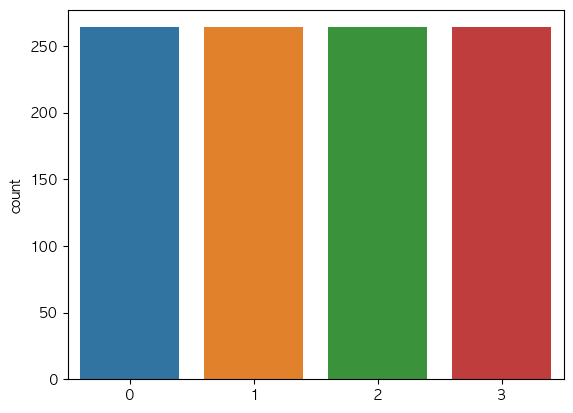

In [111]:
# 표준화
scaler = StandardScaler()
columns_to_scale = T_feature.columns
T_feature[columns_to_scale] = scaler.fit_transform(T_feature[columns_to_scale])

# T score
T_train, T_test, y_train, y_test = train_test_split(T_feature, y, test_size=0.2, random_state=random_state)

# Borderline-SMOTE를 사용하여 오버샘플링
borderline_smote = BorderlineSMOTE(random_state = random_state)
T_resampled, y_resampled = borderline_smote.fit_resample(T_train, y_train)

# 데이터 증강이 되었는지 확인
print('Borderline-SMOTE 적용 후 값의 분포:\n', pd.Series(y_resampled).value_counts())
sns.countplot(x=y_resampled, order=[0, 1, 2, 3])

In [112]:
# 다중분류 모델 설정
models = [
    ("Logistic Regression", LogisticRegression(multi_class='multinomial', max_iter=1000, random_state = random_state)),
    ("Support Vector Machines", SVC(decision_function_shape='ovr', random_state = random_state)),
    ("Random Forest", RandomForestClassifier(random_state = random_state)),
    ("XGBClassifier", XGBClassifier(objective='multi:softmax', num_class=num_class, random_state = random_state)),
    ("LGBMClassifier", LGBMClassifier(objective='multiclass', num_class=num_class, random_state = random_state)),
    ("CatBoostClassifier", CatBoostClassifier(random_state = random_state))
]

for name, model in models:
    model.fit(T_resampled, y_resampled)
    y_pred = model.predict(T_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}")

Logistic Regression - Accuracy: 0.33112582781456956
Support Vector Machines - Accuracy: 0.2913907284768212
Random Forest - Accuracy: 0.46357615894039733
XGBClassifier - Accuracy: 0.3973509933774834
LGBMClassifier - Accuracy: 0.4503311258278146
Learning rate set to 0.079347
0:	learn: 1.3573946	total: 1.15ms	remaining: 1.15s
1:	learn: 1.3326864	total: 2.24ms	remaining: 1.12s
2:	learn: 1.3151857	total: 3.27ms	remaining: 1.09s
3:	learn: 1.2964243	total: 4.21ms	remaining: 1.05s
4:	learn: 1.2798796	total: 5.26ms	remaining: 1.05s
5:	learn: 1.2620393	total: 6.32ms	remaining: 1.05s
6:	learn: 1.2465882	total: 7.39ms	remaining: 1.05s
7:	learn: 1.2304259	total: 8.29ms	remaining: 1.03s
8:	learn: 1.2156683	total: 9.38ms	remaining: 1.03s
9:	learn: 1.2063583	total: 10.2ms	remaining: 1.01s
10:	learn: 1.1967810	total: 11.3ms	remaining: 1.01s
11:	learn: 1.1859390	total: 12.6ms	remaining: 1.04s
12:	learn: 1.1788149	total: 13.9ms	remaining: 1.06s
13:	learn: 1.1710723	total: 15ms	remaining: 1.05s
14:	learn:

165:	learn: 0.7907515	total: 196ms	remaining: 985ms
166:	learn: 0.7899317	total: 197ms	remaining: 983ms
167:	learn: 0.7883104	total: 198ms	remaining: 981ms
168:	learn: 0.7868554	total: 199ms	remaining: 979ms
169:	learn: 0.7857902	total: 200ms	remaining: 976ms
170:	learn: 0.7841460	total: 201ms	remaining: 973ms
171:	learn: 0.7826964	total: 202ms	remaining: 971ms
172:	learn: 0.7808087	total: 203ms	remaining: 969ms
173:	learn: 0.7792314	total: 203ms	remaining: 966ms
174:	learn: 0.7778561	total: 204ms	remaining: 963ms
175:	learn: 0.7769800	total: 205ms	remaining: 961ms
176:	learn: 0.7760529	total: 206ms	remaining: 958ms
177:	learn: 0.7741737	total: 207ms	remaining: 956ms
178:	learn: 0.7730312	total: 208ms	remaining: 954ms
179:	learn: 0.7710053	total: 209ms	remaining: 951ms
180:	learn: 0.7701359	total: 210ms	remaining: 949ms
181:	learn: 0.7691114	total: 211ms	remaining: 947ms
182:	learn: 0.7682018	total: 212ms	remaining: 945ms
183:	learn: 0.7664869	total: 213ms	remaining: 945ms
184:	learn: 

377:	learn: 0.5789889	total: 393ms	remaining: 647ms
378:	learn: 0.5780890	total: 394ms	remaining: 646ms
379:	learn: 0.5775673	total: 395ms	remaining: 644ms
380:	learn: 0.5769197	total: 396ms	remaining: 643ms
381:	learn: 0.5759997	total: 397ms	remaining: 642ms
382:	learn: 0.5753030	total: 397ms	remaining: 640ms
383:	learn: 0.5742570	total: 399ms	remaining: 639ms
384:	learn: 0.5737078	total: 399ms	remaining: 638ms
385:	learn: 0.5729344	total: 400ms	remaining: 637ms
386:	learn: 0.5719108	total: 401ms	remaining: 635ms
387:	learn: 0.5709110	total: 402ms	remaining: 634ms
388:	learn: 0.5706282	total: 403ms	remaining: 633ms
389:	learn: 0.5696405	total: 404ms	remaining: 632ms
390:	learn: 0.5687318	total: 405ms	remaining: 630ms
391:	learn: 0.5681228	total: 406ms	remaining: 629ms
392:	learn: 0.5674303	total: 406ms	remaining: 628ms
393:	learn: 0.5665390	total: 407ms	remaining: 627ms
394:	learn: 0.5654640	total: 408ms	remaining: 626ms
395:	learn: 0.5649420	total: 409ms	remaining: 624ms
396:	learn: 

593:	learn: 0.4573502	total: 590ms	remaining: 404ms
594:	learn: 0.4570372	total: 591ms	remaining: 403ms
595:	learn: 0.4567072	total: 592ms	remaining: 401ms
596:	learn: 0.4561464	total: 593ms	remaining: 400ms
597:	learn: 0.4557754	total: 594ms	remaining: 399ms
598:	learn: 0.4552118	total: 595ms	remaining: 398ms
599:	learn: 0.4548334	total: 596ms	remaining: 397ms
600:	learn: 0.4540435	total: 597ms	remaining: 396ms
601:	learn: 0.4538004	total: 598ms	remaining: 395ms
602:	learn: 0.4534319	total: 599ms	remaining: 394ms
603:	learn: 0.4529023	total: 599ms	remaining: 393ms
604:	learn: 0.4522798	total: 600ms	remaining: 392ms
605:	learn: 0.4520149	total: 601ms	remaining: 391ms
606:	learn: 0.4516233	total: 602ms	remaining: 390ms
607:	learn: 0.4513812	total: 603ms	remaining: 389ms
608:	learn: 0.4510571	total: 604ms	remaining: 388ms
609:	learn: 0.4504511	total: 605ms	remaining: 387ms
610:	learn: 0.4498367	total: 605ms	remaining: 385ms
611:	learn: 0.4494436	total: 606ms	remaining: 384ms
612:	learn: 

809:	learn: 0.3737178	total: 788ms	remaining: 185ms
810:	learn: 0.3733275	total: 789ms	remaining: 184ms
811:	learn: 0.3729493	total: 789ms	remaining: 183ms
812:	learn: 0.3726257	total: 790ms	remaining: 182ms
813:	learn: 0.3723871	total: 791ms	remaining: 181ms
814:	learn: 0.3720673	total: 792ms	remaining: 180ms
815:	learn: 0.3719039	total: 793ms	remaining: 179ms
816:	learn: 0.3717245	total: 794ms	remaining: 178ms
817:	learn: 0.3714629	total: 795ms	remaining: 177ms
818:	learn: 0.3711459	total: 796ms	remaining: 176ms
819:	learn: 0.3709790	total: 797ms	remaining: 175ms
820:	learn: 0.3706872	total: 798ms	remaining: 174ms
821:	learn: 0.3703707	total: 798ms	remaining: 173ms
822:	learn: 0.3700262	total: 799ms	remaining: 172ms
823:	learn: 0.3697339	total: 800ms	remaining: 171ms
824:	learn: 0.3693942	total: 801ms	remaining: 170ms
825:	learn: 0.3690678	total: 802ms	remaining: 169ms
826:	learn: 0.3686579	total: 803ms	remaining: 168ms
827:	learn: 0.3684681	total: 804ms	remaining: 167ms
828:	learn: 

## 1) LogisticRegression : softmax

In [83]:
logreg = LogisticRegression(multi_class='multinomial', random_state = random_state)

# 파라미터 범위
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],           # 규제 강도 파라미터
    'penalty': ['l1', 'l2'],                  # 규제 유형 (L1 또는 L2)
    'max_iter': [50, 100, 150, 200],          # 최대 반복 횟수
    'class_weight': [None, 'balanced'],       # 클래스별 가중치
    'solver': ['lbfgs', 'sag', 'newton-cg'],  # 최적화 알고리즘
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(T_resampled, y_resampled)

logreg_T = grid_search.best_estimator_
y_pred = logreg_T.predict(T_test)

accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'C': 0.01, 'class_weight': None, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy: 0.33774834437086093


## 2) Support Vector Machines : SVC

In [84]:
# ovr : One-vs-Rest가 ovo와 성능은 차이가 없는데 계산량이 월등히 빨라 ovr을 선택
svc = SVC(decision_function_shape='ovr', probability=True)

# 파라미터 범위
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],    # 규제 파라미터
    'kernel': ['linear', 'rbf'],     # 커널 종류
    'gamma': ['scale', 'auto']       # gamma 값
}

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(T_resampled, y_resampled)

svc_T = grid_search.best_estimator_
y_pred = svc_T.predict(T_test)

accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.3841059602649007


## 3) RandomForest : Bagging

In [85]:
rf = RandomForestClassifier(criterion = 'entropy',  class_weight = 'balanced', n_jobs=-1, random_state=random_state)

# 파라미터 범위
param_grid = {
    'n_estimators': [150, 200, 250, 300, 350], # 결정 트리의 개수
    'max_depth': [15, 20, 25, 30, 35],         # 트리의 최대 깊이
    'min_samples_split': [1, 2, 3],            # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1,2],                 # 리프 노드의 최소 샘플 수
    'max_features': ['sqrt']                   # 최대 피처 개수
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(T_resampled, y_resampled)

rf_T = grid_search.best_estimator_
y_pred = rf_T.predict(T_test)

accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Test Accuracy: 0.45695364238410596


## 4) XGBClassifier : xgboost

In [86]:
# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'max_depth': trial.suggest_int('max_depth', 30, 35),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10),
        'objective': 'multi:softmax',
        'num_class': num_class
    }


    model = XGBClassifier(**params, random_state = random_state)
    model.fit(T_resampled, y_resampled)
    y_pred = model.predict(T_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
xgb_T = optuna.create_study(direction='maximize')
xgb_T.optimize(objective, n_trials=300)

print("Test parameters:", xgb_T.best_params)
print("Test Accuracy:", xgb_T.best_value)

[I 2023-09-10 20:01:24,911] A new study created in memory with name: no-name-aecc9e28-28e8-4b00-892d-f0f604004afb
[I 2023-09-10 20:01:25,750] Trial 0 finished with value: 0.3841059602649007 and parameters: {'max_depth': 32, 'learning_rate': 0.08887482229430999, 'n_estimators': 481, 'min_child_weight': 3, 'subsample': 0.8749758537851937, 'colsample_bytree': 0.8762778812909306, 'reg_alpha': 0.8132582674283872, 'reg_lambda': 6.450299088434148}. Best is trial 0 with value: 0.3841059602649007.
[I 2023-09-10 20:01:26,002] Trial 1 finished with value: 0.2913907284768212 and parameters: {'max_depth': 30, 'learning_rate': 0.022736343344265705, 'n_estimators': 219, 'min_child_weight': 4, 'subsample': 0.9845362706651117, 'colsample_bytree': 0.6475228055605349, 'reg_alpha': 3.5265730678496947, 'reg_lambda': 5.646138492716654}. Best is trial 0 with value: 0.3841059602649007.
[I 2023-09-10 20:01:26,215] Trial 2 finished with value: 0.3576158940397351 and parameters: {'max_depth': 30, 'learning_rate'

[I 2023-09-10 20:01:39,924] Trial 22 finished with value: 0.3841059602649007 and parameters: {'max_depth': 34, 'learning_rate': 0.042712426721309066, 'n_estimators': 259, 'min_child_weight': 3, 'subsample': 0.9245040931876853, 'colsample_bytree': 0.6933448850600386, 'reg_alpha': 5.024850786601974, 'reg_lambda': 7.9384870451620575}. Best is trial 4 with value: 0.4105960264900662.
[I 2023-09-10 20:01:40,564] Trial 23 finished with value: 0.3841059602649007 and parameters: {'max_depth': 33, 'learning_rate': 0.049930392850658256, 'n_estimators': 396, 'min_child_weight': 2, 'subsample': 0.9844839850371169, 'colsample_bytree': 0.7721033950226031, 'reg_alpha': 3.2239685926697503, 'reg_lambda': 9.42900510153799}. Best is trial 4 with value: 0.4105960264900662.
[I 2023-09-10 20:01:41,505] Trial 24 finished with value: 0.37748344370860926 and parameters: {'max_depth': 35, 'learning_rate': 0.03568056731556697, 'n_estimators': 542, 'min_child_weight': 4, 'subsample': 0.9607390532799571, 'colsample

[I 2023-09-10 20:01:50,595] Trial 44 finished with value: 0.3509933774834437 and parameters: {'max_depth': 32, 'learning_rate': 0.04413342025691408, 'n_estimators': 174, 'min_child_weight': 4, 'subsample': 0.9739946365908315, 'colsample_bytree': 0.6735975389410912, 'reg_alpha': 7.65146162144131, 'reg_lambda': 6.72431196150666}. Best is trial 4 with value: 0.4105960264900662.
[I 2023-09-10 20:01:50,783] Trial 45 finished with value: 0.36423841059602646 and parameters: {'max_depth': 34, 'learning_rate': 0.05109244850320263, 'n_estimators': 133, 'min_child_weight': 3, 'subsample': 0.9156040755119778, 'colsample_bytree': 0.7307359034120633, 'reg_alpha': 6.049543693733076, 'reg_lambda': 7.487764927959996}. Best is trial 4 with value: 0.4105960264900662.
[I 2023-09-10 20:01:51,203] Trial 46 finished with value: 0.37748344370860926 and parameters: {'max_depth': 33, 'learning_rate': 0.0368248091759163, 'n_estimators': 294, 'min_child_weight': 2, 'subsample': 0.900123055836619, 'colsample_bytre

[I 2023-09-10 20:02:00,133] Trial 66 finished with value: 0.423841059602649 and parameters: {'max_depth': 31, 'learning_rate': 0.03162545953472286, 'n_estimators': 100, 'min_child_weight': 1, 'subsample': 0.9512932199009221, 'colsample_bytree': 0.7642712623518961, 'reg_alpha': 0.967904074648531, 'reg_lambda': 9.161473603503984}. Best is trial 59 with value: 0.4304635761589404.
[I 2023-09-10 20:02:00,540] Trial 67 finished with value: 0.41721854304635764 and parameters: {'max_depth': 31, 'learning_rate': 0.03720132258156254, 'n_estimators': 167, 'min_child_weight': 1, 'subsample': 0.9905041914714169, 'colsample_bytree': 0.7598037577138562, 'reg_alpha': 0.9143118777826947, 'reg_lambda': 9.240065645533429}. Best is trial 59 with value: 0.4304635761589404.
[I 2023-09-10 20:02:01,155] Trial 68 finished with value: 0.4105960264900662 and parameters: {'max_depth': 31, 'learning_rate': 0.026246201041386655, 'n_estimators': 224, 'min_child_weight': 1, 'subsample': 0.9518622838724937, 'colsample

[I 2023-09-10 20:02:09,518] Trial 88 finished with value: 0.4304635761589404 and parameters: {'max_depth': 32, 'learning_rate': 0.015803173308927176, 'n_estimators': 159, 'min_child_weight': 1, 'subsample': 0.9797756429408467, 'colsample_bytree': 0.8100479083482613, 'reg_alpha': 0.5860299965739437, 'reg_lambda': 9.804343038203879}. Best is trial 75 with value: 0.44370860927152317.
[I 2023-09-10 20:02:09,914] Trial 89 finished with value: 0.423841059602649 and parameters: {'max_depth': 32, 'learning_rate': 0.014524438200583318, 'n_estimators': 157, 'min_child_weight': 1, 'subsample': 0.9837299751373071, 'colsample_bytree': 0.811693522349985, 'reg_alpha': 0.5870135643166575, 'reg_lambda': 9.698735392280982}. Best is trial 75 with value: 0.44370860927152317.
[I 2023-09-10 20:02:10,563] Trial 90 finished with value: 0.4105960264900662 and parameters: {'max_depth': 32, 'learning_rate': 0.011961846723301882, 'n_estimators': 247, 'min_child_weight': 1, 'subsample': 0.9910790797774754, 'colsam

[I 2023-09-10 20:02:19,546] Trial 110 finished with value: 0.4105960264900662 and parameters: {'max_depth': 32, 'learning_rate': 0.018340370194708366, 'n_estimators': 300, 'min_child_weight': 1, 'subsample': 0.9851372945526222, 'colsample_bytree': 0.8230856754624569, 'reg_alpha': 0.4130507831211264, 'reg_lambda': 9.446013506552568}. Best is trial 92 with value: 0.4503311258278146.
[I 2023-09-10 20:02:19,942] Trial 111 finished with value: 0.423841059602649 and parameters: {'max_depth': 32, 'learning_rate': 0.0163186098783651, 'n_estimators': 166, 'min_child_weight': 1, 'subsample': 0.9754664747309277, 'colsample_bytree': 0.8120143604832742, 'reg_alpha': 0.585285248504497, 'reg_lambda': 9.728891263729704}. Best is trial 92 with value: 0.4503311258278146.
[I 2023-09-10 20:02:20,318] Trial 112 finished with value: 0.4304635761589404 and parameters: {'max_depth': 32, 'learning_rate': 0.01439250237337433, 'n_estimators': 160, 'min_child_weight': 1, 'subsample': 0.9807952445135444, 'colsampl

[I 2023-09-10 20:02:31,440] Trial 132 finished with value: 0.4370860927152318 and parameters: {'max_depth': 32, 'learning_rate': 0.012375954508326839, 'n_estimators': 143, 'min_child_weight': 1, 'subsample': 0.9728053306278598, 'colsample_bytree': 0.7886460644392305, 'reg_alpha': 1.1590816956935552, 'reg_lambda': 8.583677477080743}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:02:34,081] Trial 133 finished with value: 0.3973509933774834 and parameters: {'max_depth': 32, 'learning_rate': 0.015560103649430414, 'n_estimators': 974, 'min_child_weight': 1, 'subsample': 0.9456586532017857, 'colsample_bytree': 0.80272290447555, 'reg_alpha': 0.1729497370401969, 'reg_lambda': 8.24993349911908}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:02:34,518] Trial 134 finished with value: 0.44370860927152317 and parameters: {'max_depth': 32, 'learning_rate': 0.010048129595864427, 'n_estimators': 182, 'min_child_weight': 1, 'subsample': 0.9583037676845335, 'c

[I 2023-09-10 20:02:43,664] Trial 154 finished with value: 0.423841059602649 and parameters: {'max_depth': 32, 'learning_rate': 0.01350378947061097, 'n_estimators': 169, 'min_child_weight': 1, 'subsample': 0.9690352765353578, 'colsample_bytree': 0.7786272554493084, 'reg_alpha': 1.7299180604061029, 'reg_lambda': 8.326882730996642}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:02:44,155] Trial 155 finished with value: 0.4105960264900662 and parameters: {'max_depth': 32, 'learning_rate': 0.010007733714631796, 'n_estimators': 214, 'min_child_weight': 1, 'subsample': 0.9520464719372191, 'colsample_bytree': 0.8007227950076834, 'reg_alpha': 2.079203824096213, 'reg_lambda': 7.8035074161863145}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:02:44,529] Trial 156 finished with value: 0.423841059602649 and parameters: {'max_depth': 32, 'learning_rate': 0.015667171667061934, 'n_estimators': 139, 'min_child_weight': 1, 'subsample': 0.9858195795268128, 'co

[I 2023-09-10 20:02:53,976] Trial 176 finished with value: 0.4304635761589404 and parameters: {'max_depth': 32, 'learning_rate': 0.017273255260499713, 'n_estimators': 205, 'min_child_weight': 1, 'subsample': 0.9841496490337225, 'colsample_bytree': 0.8487881303122086, 'reg_alpha': 1.4754518169349176, 'reg_lambda': 9.283551247879394}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:02:54,325] Trial 177 finished with value: 0.40397350993377484 and parameters: {'max_depth': 32, 'learning_rate': 0.010049132242702227, 'n_estimators': 162, 'min_child_weight': 1, 'subsample': 0.9589352427590732, 'colsample_bytree': 0.7593028904826197, 'reg_alpha': 2.2923281575767778, 'reg_lambda': 8.963716444698015}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:02:54,680] Trial 178 finished with value: 0.4370860927152318 and parameters: {'max_depth': 32, 'learning_rate': 0.0236200076563337, 'n_estimators': 136, 'min_child_weight': 1, 'subsample': 0.9941245307030309, '

[I 2023-09-10 20:03:04,343] Trial 198 finished with value: 0.3973509933774834 and parameters: {'max_depth': 32, 'learning_rate': 0.01003555863267246, 'n_estimators': 200, 'min_child_weight': 1, 'subsample': 0.961379690683882, 'colsample_bytree': 0.7559306764589706, 'reg_alpha': 2.6777297297010825, 'reg_lambda': 9.10539051936429}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:06,055] Trial 199 finished with value: 0.3973509933774834 and parameters: {'max_depth': 32, 'learning_rate': 0.02224441454331067, 'n_estimators': 679, 'min_child_weight': 1, 'subsample': 0.9205783020381073, 'colsample_bytree': 0.7691845671613343, 'reg_alpha': 0.6355752343517656, 'reg_lambda': 8.381013546073657}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:06,426] Trial 200 finished with value: 0.4304635761589404 and parameters: {'max_depth': 32, 'learning_rate': 0.012582771690686414, 'n_estimators': 141, 'min_child_weight': 1, 'subsample': 0.9486228192233769, 'col

[I 2023-09-10 20:03:16,687] Trial 220 finished with value: 0.423841059602649 and parameters: {'max_depth': 32, 'learning_rate': 0.011927141767960217, 'n_estimators': 122, 'min_child_weight': 1, 'subsample': 0.9877187780911668, 'colsample_bytree': 0.8086190004845881, 'reg_alpha': 1.4274759333453435, 'reg_lambda': 9.36006698330697}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:17,119] Trial 221 finished with value: 0.44370860927152317 and parameters: {'max_depth': 32, 'learning_rate': 0.011566767934904956, 'n_estimators': 172, 'min_child_weight': 1, 'subsample': 0.9712363328450081, 'colsample_bytree': 0.7925270101140602, 'reg_alpha': 0.8969090197414868, 'reg_lambda': 8.488029307899607}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:17,566] Trial 222 finished with value: 0.45695364238410596 and parameters: {'max_depth': 32, 'learning_rate': 0.010082252566381936, 'n_estimators': 183, 'min_child_weight': 1, 'subsample': 0.9750789115933597, 

[I 2023-09-10 20:03:25,832] Trial 242 finished with value: 0.4370860927152318 and parameters: {'max_depth': 32, 'learning_rate': 0.010002514486170858, 'n_estimators': 151, 'min_child_weight': 1, 'subsample': 0.976565120579837, 'colsample_bytree': 0.7934392194219111, 'reg_alpha': 1.0875562326794657, 'reg_lambda': 8.05847933251885}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:26,142] Trial 243 finished with value: 0.44370860927152317 and parameters: {'max_depth': 32, 'learning_rate': 0.012366515099640877, 'n_estimators': 132, 'min_child_weight': 1, 'subsample': 0.9680914072893386, 'colsample_bytree': 0.7734180463320431, 'reg_alpha': 0.8591292832448607, 'reg_lambda': 8.679983698831165}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:26,422] Trial 244 finished with value: 0.37748344370860926 and parameters: {'max_depth': 32, 'learning_rate': 0.013615046944052422, 'n_estimators': 170, 'min_child_weight': 1, 'subsample': 0.9815899441683127, 

[I 2023-09-10 20:03:37,330] Trial 264 finished with value: 0.3973509933774834 and parameters: {'max_depth': 32, 'learning_rate': 0.014812454152635901, 'n_estimators': 164, 'min_child_weight': 1, 'subsample': 0.855155256054577, 'colsample_bytree': 0.7943129985744359, 'reg_alpha': 1.4141203433327258, 'reg_lambda': 8.688802304720138}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:37,916] Trial 265 finished with value: 0.3973509933774834 and parameters: {'max_depth': 32, 'learning_rate': 0.03307602709063323, 'n_estimators': 208, 'min_child_weight': 1, 'subsample': 0.9639563334230787, 'colsample_bytree': 0.8104968262981374, 'reg_alpha': 0.9515207304552138, 'reg_lambda': 7.812498956589365}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:38,476] Trial 266 finished with value: 0.4304635761589404 and parameters: {'max_depth': 32, 'learning_rate': 0.011966073649146126, 'n_estimators': 185, 'min_child_weight': 1, 'subsample': 0.8201544926103312, 'c

[I 2023-09-10 20:03:46,847] Trial 286 finished with value: 0.44370860927152317 and parameters: {'max_depth': 32, 'learning_rate': 0.011571172097011103, 'n_estimators': 169, 'min_child_weight': 1, 'subsample': 0.9778528135299485, 'colsample_bytree': 0.803586359460562, 'reg_alpha': 0.6984924169324026, 'reg_lambda': 8.909327978902692}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:47,339] Trial 287 finished with value: 0.4105960264900662 and parameters: {'max_depth': 32, 'learning_rate': 0.01914246621499785, 'n_estimators': 205, 'min_child_weight': 1, 'subsample': 0.9500344483683277, 'colsample_bytree': 0.793183330908325, 'reg_alpha': 2.089317043553061, 'reg_lambda': 5.236022277213422}. Best is trial 119 with value: 0.45695364238410596.
[I 2023-09-10 20:03:47,584] Trial 288 finished with value: 0.4370860927152318 and parameters: {'max_depth': 32, 'learning_rate': 0.010071060404299795, 'n_estimators': 102, 'min_child_weight': 1, 'subsample': 0.9675381960255204, 'co

Test parameters: {'max_depth': 32, 'learning_rate': 0.013932151188027616, 'n_estimators': 185, 'min_child_weight': 1, 'subsample': 0.9712518896075428, 'colsample_bytree': 0.8007822145796768, 'reg_alpha': 1.3199655775482517, 'reg_lambda': 7.981830636842682}
Test Accuracy: 0.45695364238410596


## 5) LGBClassifier : lightgbm

In [87]:
# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10),
        'objective': 'multiclass',
        'num_class': num_class
    }

    model = LGBMClassifier(**params, random_state=random_state)
    model.fit(T_resampled, y_resampled)
    y_pred = model.predict(T_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
lgbm_T = optuna.create_study(direction='maximize')
lgbm_T.optimize(objective, n_trials=300)

print("Test parameters:", lgbm_T.best_params)
print("Test Accuracy:", lgbm_T.best_value)

[I 2023-09-10 20:03:51,846] A new study created in memory with name: no-name-11712875-52e8-4a67-a3c8-977c1d4667a0
[I 2023-09-10 20:03:52,305] Trial 0 finished with value: 0.36423841059602646 and parameters: {'max_depth': 12, 'learning_rate': 0.03036601127446094, 'n_estimators': 454, 'min_child_samples': 3, 'subsample': 0.7956494972695118, 'colsample_bytree': 0.6632176227700949, 'reg_alpha': 7.076263561961042, 'reg_lambda': 9.121499163950524}. Best is trial 0 with value: 0.36423841059602646.
[I 2023-09-10 20:03:52,516] Trial 1 finished with value: 0.3708609271523179 and parameters: {'max_depth': 31, 'learning_rate': 0.05526329331614818, 'n_estimators': 117, 'min_child_samples': 5, 'subsample': 0.8160160580453341, 'colsample_bytree': 0.8376258735115854, 'reg_alpha': 3.936040927510728, 'reg_lambda': 6.538285995981313}. Best is trial 1 with value: 0.3708609271523179.
[I 2023-09-10 20:03:53,327] Trial 2 finished with value: 0.3973509933774834 and parameters: {'max_depth': 6, 'learning_rate'

[I 2023-09-10 20:04:09,845] Trial 22 finished with value: 0.41721854304635764 and parameters: {'max_depth': 27, 'learning_rate': 0.08262563353453864, 'n_estimators': 872, 'min_child_samples': 8, 'subsample': 0.6769016752375043, 'colsample_bytree': 0.8817863921877693, 'reg_alpha': 1.4148489565921922, 'reg_lambda': 8.103542763398613}. Best is trial 3 with value: 0.423841059602649.
[I 2023-09-10 20:04:10,788] Trial 23 finished with value: 0.44370860927152317 and parameters: {'max_depth': 35, 'learning_rate': 0.06192803052377295, 'n_estimators': 549, 'min_child_samples': 10, 'subsample': 0.7360121549529075, 'colsample_bytree': 0.9215690273773356, 'reg_alpha': 0.17343517709369874, 'reg_lambda': 8.9211205696108}. Best is trial 23 with value: 0.44370860927152317.
[I 2023-09-10 20:04:11,546] Trial 24 finished with value: 0.41721854304635764 and parameters: {'max_depth': 35, 'learning_rate': 0.06301289134726325, 'n_estimators': 556, 'min_child_samples': 10, 'subsample': 0.7520992315203926, 'col

[I 2023-09-10 20:04:26,084] Trial 44 finished with value: 0.423841059602649 and parameters: {'max_depth': 41, 'learning_rate': 0.06886806001409788, 'n_estimators': 534, 'min_child_samples': 1, 'subsample': 0.529783853042584, 'colsample_bytree': 0.9073156490340414, 'reg_alpha': 0.5589802600214343, 'reg_lambda': 8.802685013257063}. Best is trial 23 with value: 0.44370860927152317.
[I 2023-09-10 20:04:26,601] Trial 45 finished with value: 0.4304635761589404 and parameters: {'max_depth': 34, 'learning_rate': 0.054910451296237506, 'n_estimators': 308, 'min_child_samples': 10, 'subsample': 0.6123554132559681, 'colsample_bytree': 0.9549270851075571, 'reg_alpha': 0.5367897975624324, 'reg_lambda': 9.519179748595302}. Best is trial 23 with value: 0.44370860927152317.
[I 2023-09-10 20:04:27,003] Trial 46 finished with value: 0.40397350993377484 and parameters: {'max_depth': 31, 'learning_rate': 0.06552596484061066, 'n_estimators': 240, 'min_child_samples': 10, 'subsample': 0.5786553681928183, 'co

[I 2023-09-10 20:04:47,010] Trial 66 finished with value: 0.4304635761589404 and parameters: {'max_depth': 30, 'learning_rate': 0.06390617177891694, 'n_estimators': 534, 'min_child_samples': 4, 'subsample': 0.5438320028220539, 'colsample_bytree': 0.9276314826176321, 'reg_alpha': 0.2743966345660227, 'reg_lambda': 8.69952584826986}. Best is trial 23 with value: 0.44370860927152317.
[I 2023-09-10 20:04:47,806] Trial 67 finished with value: 0.4370860927152318 and parameters: {'max_depth': 25, 'learning_rate': 0.07373960304595699, 'n_estimators': 712, 'min_child_samples': 9, 'subsample': 0.5103250414026117, 'colsample_bytree': 0.9137436149600727, 'reg_alpha': 1.007018866103957, 'reg_lambda': 7.809745538009316}. Best is trial 23 with value: 0.44370860927152317.
[I 2023-09-10 20:04:49,073] Trial 68 finished with value: 0.4503311258278146 and parameters: {'max_depth': 37, 'learning_rate': 0.07858149400140779, 'n_estimators': 746, 'min_child_samples': 10, 'subsample': 0.6095725929034992, 'colsa

[I 2023-09-10 20:05:15,520] Trial 88 finished with value: 0.423841059602649 and parameters: {'max_depth': 48, 'learning_rate': 0.05217235289546101, 'n_estimators': 939, 'min_child_samples': 9, 'subsample': 0.6991668859653986, 'colsample_bytree': 0.9606643570258117, 'reg_alpha': 0.5897612991377997, 'reg_lambda': 5.849898496800655}. Best is trial 85 with value: 0.46357615894039733.
[I 2023-09-10 20:05:16,373] Trial 89 finished with value: 0.3841059602649007 and parameters: {'max_depth': 42, 'learning_rate': 0.058172147989810886, 'n_estimators': 780, 'min_child_samples': 9, 'subsample': 0.707314110925844, 'colsample_bytree': 0.9497900629459074, 'reg_alpha': 1.3202205431033602, 'reg_lambda': 7.245090611805153}. Best is trial 85 with value: 0.46357615894039733.
[I 2023-09-10 20:05:17,932] Trial 90 finished with value: 0.4503311258278146 and parameters: {'max_depth': 47, 'learning_rate': 0.05535663289427243, 'n_estimators': 881, 'min_child_samples': 9, 'subsample': 0.7176509647438621, 'colsa

[I 2023-09-10 20:05:45,243] Trial 110 finished with value: 0.41721854304635764 and parameters: {'max_depth': 17, 'learning_rate': 0.06445105654762776, 'n_estimators': 662, 'min_child_samples': 8, 'subsample': 0.5581397347500995, 'colsample_bytree': 0.9877659852753554, 'reg_alpha': 0.6875073164861932, 'reg_lambda': 7.306809550878974}. Best is trial 85 with value: 0.46357615894039733.
[I 2023-09-10 20:05:46,672] Trial 111 finished with value: 0.46357615894039733 and parameters: {'max_depth': 42, 'learning_rate': 0.06619507038187648, 'n_estimators': 737, 'min_child_samples': 10, 'subsample': 0.6146708571055861, 'colsample_bytree': 0.9374559531299077, 'reg_alpha': 0.03403979938553509, 'reg_lambda': 7.397738180982321}. Best is trial 85 with value: 0.46357615894039733.
[I 2023-09-10 20:05:47,966] Trial 112 finished with value: 0.45695364238410596 and parameters: {'max_depth': 45, 'learning_rate': 0.05937394143562672, 'n_estimators': 698, 'min_child_samples': 10, 'subsample': 0.60860056433072

[I 2023-09-10 20:06:14,342] Trial 132 finished with value: 0.46357615894039733 and parameters: {'max_depth': 44, 'learning_rate': 0.057439430139753105, 'n_estimators': 836, 'min_child_samples': 10, 'subsample': 0.6696704209081817, 'colsample_bytree': 0.9469538560222778, 'reg_alpha': 0.20876596069598632, 'reg_lambda': 7.235180925154067}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:06:15,956] Trial 133 finished with value: 0.46357615894039733 and parameters: {'max_depth': 44, 'learning_rate': 0.05819028949598567, 'n_estimators': 843, 'min_child_samples': 10, 'subsample': 0.6729636285517935, 'colsample_bytree': 0.969912911462973, 'reg_alpha': 0.1748179794850161, 'reg_lambda': 7.250973849449269}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:06:17,514] Trial 134 finished with value: 0.4370860927152318 and parameters: {'max_depth': 44, 'learning_rate': 0.058304622917224304, 'n_estimators': 835, 'min_child_samples': 10, 'subsample': 0.67163138588

[I 2023-09-10 20:06:44,777] Trial 154 finished with value: 0.4768211920529801 and parameters: {'max_depth': 49, 'learning_rate': 0.05063272838686097, 'n_estimators': 831, 'min_child_samples': 10, 'subsample': 0.650369681059484, 'colsample_bytree': 0.9998933801924718, 'reg_alpha': 0.22055337946160303, 'reg_lambda': 6.087506155945955}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:06:46,424] Trial 155 finished with value: 0.44370860927152317 and parameters: {'max_depth': 49, 'learning_rate': 0.05225622112523359, 'n_estimators': 828, 'min_child_samples': 10, 'subsample': 0.6536481538115682, 'colsample_bytree': 0.9956935123190774, 'reg_alpha': 0.1421541529079417, 'reg_lambda': 6.058620001228178}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:06:48,174] Trial 156 finished with value: 0.4370860927152318 and parameters: {'max_depth': 50, 'learning_rate': 0.060217516821667955, 'n_estimators': 884, 'min_child_samples': 9, 'subsample': 0.67476644844487

[I 2023-09-10 20:07:15,729] Trial 176 finished with value: 0.4304635761589404 and parameters: {'max_depth': 6, 'learning_rate': 0.05599814877482063, 'n_estimators': 841, 'min_child_samples': 10, 'subsample': 0.6179405770971012, 'colsample_bytree': 0.9588655979337045, 'reg_alpha': 0.4071753564276274, 'reg_lambda': 6.156517482233678}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:07:17,010] Trial 177 finished with value: 0.4304635761589404 and parameters: {'max_depth': 49, 'learning_rate': 0.05946248160192413, 'n_estimators': 714, 'min_child_samples': 5, 'subsample': 0.6833626709820634, 'colsample_bytree': 0.9775085406427548, 'reg_alpha': 0.17714627867822855, 'reg_lambda': 6.778108163107259}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:07:18,222] Trial 178 finished with value: 0.41721854304635764 and parameters: {'max_depth': 12, 'learning_rate': 0.062148759918863344, 'n_estimators': 896, 'min_child_samples': 10, 'subsample': 0.65573246887754

[I 2023-09-10 20:07:48,245] Trial 198 finished with value: 0.44370860927152317 and parameters: {'max_depth': 48, 'learning_rate': 0.06548364505595204, 'n_estimators': 882, 'min_child_samples': 10, 'subsample': 0.6154498088157562, 'colsample_bytree': 0.9373802478828028, 'reg_alpha': 0.16447888437545435, 'reg_lambda': 7.155944490232143}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:07:49,420] Trial 199 finished with value: 0.4503311258278146 and parameters: {'max_depth': 46, 'learning_rate': 0.049632448850840234, 'n_estimators': 673, 'min_child_samples': 10, 'subsample': 0.6329348049999096, 'colsample_bytree': 0.9159064616783861, 'reg_alpha': 0.008276546162059861, 'reg_lambda': 6.150839089778702}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:07:50,416] Trial 200 finished with value: 0.40397350993377484 and parameters: {'max_depth': 44, 'learning_rate': 0.0620329114420942, 'n_estimators': 910, 'min_child_samples': 10, 'subsample': 0.6691396129

[I 2023-09-10 20:08:14,103] Trial 220 finished with value: 0.44370860927152317 and parameters: {'max_depth': 44, 'learning_rate': 0.05334207135782067, 'n_estimators': 928, 'min_child_samples': 2, 'subsample': 0.692515949036129, 'colsample_bytree': 0.9215447354106056, 'reg_alpha': 0.1808670496313512, 'reg_lambda': 7.243237253516533}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:08:15,436] Trial 221 finished with value: 0.44370860927152317 and parameters: {'max_depth': 48, 'learning_rate': 0.05840258173341182, 'n_estimators': 773, 'min_child_samples': 10, 'subsample': 0.632073973913331, 'colsample_bytree': 0.9894489741881016, 'reg_alpha': 0.06786253813372767, 'reg_lambda': 6.08277715761579}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:08:16,806] Trial 222 finished with value: 0.45695364238410596 and parameters: {'max_depth': 48, 'learning_rate': 0.05951612810724374, 'n_estimators': 789, 'min_child_samples': 10, 'subsample': 0.636245339648584

[I 2023-09-10 20:08:38,657] Trial 242 finished with value: 0.44370860927152317 and parameters: {'max_depth': 48, 'learning_rate': 0.05881038934189461, 'n_estimators': 771, 'min_child_samples': 10, 'subsample': 0.6269670889465652, 'colsample_bytree': 0.9891671160295463, 'reg_alpha': 0.18875673087080613, 'reg_lambda': 6.527128721800392}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:08:40,221] Trial 243 finished with value: 0.46357615894039733 and parameters: {'max_depth': 47, 'learning_rate': 0.06018378267782773, 'n_estimators': 751, 'min_child_samples': 10, 'subsample': 0.6405081120376576, 'colsample_bytree': 0.875859807261304, 'reg_alpha': 0.36072773634410416, 'reg_lambda': 5.812323246043691}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:08:41,577] Trial 244 finished with value: 0.4503311258278146 and parameters: {'max_depth': 48, 'learning_rate': 0.05786773600166855, 'n_estimators': 746, 'min_child_samples': 10, 'subsample': 0.755300213643

[I 2023-09-10 20:09:04,904] Trial 264 finished with value: 0.37748344370860926 and parameters: {'max_depth': 46, 'learning_rate': 0.05723612408850791, 'n_estimators': 833, 'min_child_samples': 10, 'subsample': 0.6218695961403322, 'colsample_bytree': 0.8313531275058805, 'reg_alpha': 3.267203858976127, 'reg_lambda': 6.5842497494735905}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:09:05,304] Trial 265 finished with value: 0.423841059602649 and parameters: {'max_depth': 49, 'learning_rate': 0.06935798485876607, 'n_estimators': 168, 'min_child_samples': 9, 'subsample': 0.6358012304446138, 'colsample_bytree': 0.8488237462917811, 'reg_alpha': 0.3658930162060299, 'reg_lambda': 7.17348482306176}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:09:05,932] Trial 266 finished with value: 0.41721854304635764 and parameters: {'max_depth': 46, 'learning_rate': 0.04798269014044323, 'n_estimators': 812, 'min_child_samples': 10, 'subsample': 0.6561713000587537

[I 2023-09-10 20:09:31,742] Trial 286 finished with value: 0.4503311258278146 and parameters: {'max_depth': 50, 'learning_rate': 0.05759620969507417, 'n_estimators': 760, 'min_child_samples': 10, 'subsample': 0.6729887977434028, 'colsample_bytree': 0.9101899800517205, 'reg_alpha': 0.002441315025271097, 'reg_lambda': 6.439345799333723}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:09:32,874] Trial 287 finished with value: 0.3973509933774834 and parameters: {'max_depth': 41, 'learning_rate': 0.05922553594577025, 'n_estimators': 860, 'min_child_samples': 10, 'subsample': 0.6455445584986599, 'colsample_bytree': 0.9657873594484353, 'reg_alpha': 0.8028073833964477, 'reg_lambda': 5.142637330585209}. Best is trial 123 with value: 0.48344370860927155.
[I 2023-09-10 20:09:34,332] Trial 288 finished with value: 0.4503311258278146 and parameters: {'max_depth': 47, 'learning_rate': 0.055259552752636075, 'n_estimators': 806, 'min_child_samples': 10, 'subsample': 0.636502563383

Test parameters: {'max_depth': 46, 'learning_rate': 0.0600500322066021, 'n_estimators': 782, 'min_child_samples': 10, 'subsample': 0.654148352172961, 'colsample_bytree': 0.9735385166854715, 'reg_alpha': 0.4930737792603803, 'reg_lambda': 6.495407467503263}
Test Accuracy: 0.48344370860927155


## 6) CatBoostClassifier : catboost

In [113]:
# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
         # 부트스트랩 유형 변경
        'bootstrap_type': 'Bayesian',
    }

    model = CatBoostClassifier(**params, verbose=False, random_state=random_state)
    model.fit(T_resampled, y_resampled)
    y_pred = model.predict(T_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
cat_T = optuna.create_study(direction='maximize')
cat_T.optimize(objective, n_trials=100)

print("Best parameters:", cat_T.best_params)
print("Test Accuracy:", cat_T.best_value)

[I 2023-09-10 20:26:32,190] A new study created in memory with name: no-name-361a7ba2-cd44-4aa5-aa7f-e6e9d4cad401
[I 2023-09-10 20:26:35,607] Trial 0 finished with value: 0.4503311258278146 and parameters: {'depth': 9, 'learning_rate': 0.07822127388534918, 'iterations': 812, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.9596100786074764, 'l2_leaf_reg': 1.9806831166997667}. Best is trial 0 with value: 0.4503311258278146.
[I 2023-09-10 20:26:35,679] Trial 1 finished with value: 0.304635761589404 and parameters: {'depth': 3, 'learning_rate': 0.09563640331449362, 'iterations': 222, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.5303713187610539, 'l2_leaf_reg': 0.00403879574032005}. Best is trial 0 with value: 0.4503311258278146.
[I 2023-09-10 20:26:36,937] Trial 2 finished with value: 0.48344370860927155 and parameters: {'depth': 10, 'learning_rate': 0.08992462975422504, 'iterations': 352, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.5715236796049257, 'l2_leaf_reg': 0.008402094600368308}. 

[I 2023-09-10 20:27:19,965] Trial 26 finished with value: 0.4768211920529801 and parameters: {'depth': 7, 'learning_rate': 0.07954670545783143, 'iterations': 623, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.8476384605336421, 'l2_leaf_reg': 0.13676551655011365}. Best is trial 3 with value: 0.5099337748344371.
[I 2023-09-10 20:27:20,746] Trial 27 finished with value: 0.47019867549668876 and parameters: {'depth': 6, 'learning_rate': 0.09905036169288486, 'iterations': 875, 'min_data_in_leaf': 7, 'colsample_bylevel': 0.7717087793853484, 'l2_leaf_reg': 0.41555811674785953}. Best is trial 3 with value: 0.5099337748344371.
[I 2023-09-10 20:27:21,324] Trial 28 finished with value: 0.46357615894039733 and parameters: {'depth': 7, 'learning_rate': 0.08685074670414557, 'iterations': 385, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.8217583506797663, 'l2_leaf_reg': 0.044380415747815656}. Best is trial 3 with value: 0.5099337748344371.
[I 2023-09-10 20:27:21,687] Trial 29 finished with value: 0.4

[I 2023-09-10 20:27:42,019] Trial 53 finished with value: 0.4768211920529801 and parameters: {'depth': 7, 'learning_rate': 0.07631255751531645, 'iterations': 794, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.9059320335982707, 'l2_leaf_reg': 0.06171691902058221}. Best is trial 3 with value: 0.5099337748344371.
[I 2023-09-10 20:27:42,373] Trial 54 finished with value: 0.4304635761589404 and parameters: {'depth': 5, 'learning_rate': 0.0964797172310301, 'iterations': 556, 'min_data_in_leaf': 5, 'colsample_bylevel': 0.804684036484321, 'l2_leaf_reg': 0.008822732874769451}. Best is trial 3 with value: 0.5099337748344371.
[I 2023-09-10 20:27:43,028] Trial 55 finished with value: 0.46357615894039733 and parameters: {'depth': 6, 'learning_rate': 0.06955189320542511, 'iterations': 701, 'min_data_in_leaf': 7, 'colsample_bylevel': 0.8775712155868424, 'l2_leaf_reg': 0.24690907111034974}. Best is trial 3 with value: 0.5099337748344371.
[I 2023-09-10 20:27:44,010] Trial 56 finished with value: 0.4635

[I 2023-09-10 20:28:10,770] Trial 80 finished with value: 0.4370860927152318 and parameters: {'depth': 6, 'learning_rate': 0.07713405235612555, 'iterations': 318, 'min_data_in_leaf': 9, 'colsample_bylevel': 0.961059376389592, 'l2_leaf_reg': 0.010059246839440048}. Best is trial 3 with value: 0.5099337748344371.
[I 2023-09-10 20:28:11,399] Trial 81 finished with value: 0.46357615894039733 and parameters: {'depth': 7, 'learning_rate': 0.0788185599458807, 'iterations': 428, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.8821459166443462, 'l2_leaf_reg': 0.02057014163971844}. Best is trial 3 with value: 0.5099337748344371.
[I 2023-09-10 20:28:12,153] Trial 82 finished with value: 0.44370860927152317 and parameters: {'depth': 7, 'learning_rate': 0.07502488639097864, 'iterations': 513, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.9245318576643904, 'l2_leaf_reg': 0.033568229599131014}. Best is trial 3 with value: 0.5099337748344371.
[I 2023-09-10 20:28:12,543] Trial 83 finished with value: 0.43

Best parameters: {'depth': 7, 'learning_rate': 0.057016087968729465, 'iterations': 826, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.8992079304627478, 'l2_leaf_reg': 0.005348688523620275}
Test Accuracy: 0.5099337748344371


# Ensemble modeling

In [89]:
# 개별 파라미터 튜닝된 모델들
all_estimators = [
    ("Logistic Regression", logreg_T),
    ("Support Vector Machines", svc_T),
    ("Random Forest", rf_T),
    ("XGBClassifier", XGBClassifier(**xgb_T.best_params, random_state=random_state)),
    ("LGBMClassifier", LGBMClassifier(**lgbm_T.best_params, random_state=random_state)),
    ("CatBoostClassifier", CatBoostClassifier(**cat_T.best_params, random_state=random_state))
]

## 1) Voting : soft

In [90]:
best_combo = None
best_accuracy = 0.0

# 가능한 모든 조합 생성
combinations = []
for r in range(1, len(all_estimators) + 1):
    combinations.extend(itertools.combinations(all_estimators, r))

# 모든 조합에 대한 Soft Voting
for combo in tqdm(combinations):
    combo_name = "_".join([est_name for est_name, _ in combo])
    
    # 해당 조합으로 보팅 분류기 정의
    estimators = list(combo)
    soft_voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft'
    )

    soft_voting_model.fit(T_resampled, y_resampled)
    soft_pred = soft_voting_model.predict(T_test)

    soft_accuracy = accuracy_score(y_test, soft_pred)
    
    # 현재 조합의 결과 출력
    print(f"Combination: {combo_name}")
    print("Soft voting accuracy: ", soft_accuracy)
    print("=" * 40)
    
    # 최고의 조합 업데이트
    if soft_accuracy > best_accuracy:
        best_combo = combo
        best_accuracy = soft_accuracy

# 최고의 조합과 결과 출력
print("Best Combination:", best_combo)
print("Test Soft Voting Accuracy:", best_accuracy)

  0%|                                                    | 0/63 [00:00<?, ?it/s]

Combination: Logistic Regression
Soft voting accuracy:  0.33774834437086093


  3%|█▍                                          | 2/63 [00:01<00:37,  1.62it/s]

Combination: Support Vector Machines
Soft voting accuracy:  0.3576158940397351


  5%|██                                          | 3/63 [00:02<00:46,  1.28it/s]

Combination: Random Forest
Soft voting accuracy:  0.45695364238410596


  6%|██▊                                         | 4/63 [00:02<00:38,  1.55it/s]

Combination: XGBClassifier
Soft voting accuracy:  0.45695364238410596


  8%|███▍                                        | 5/63 [00:04<00:55,  1.04it/s]

Combination: LGBMClassifier
Soft voting accuracy:  0.48344370860927155
0:	learn: 1.3456218	total: 3.16ms	remaining: 2.73s
1:	learn: 1.3194056	total: 5.79ms	remaining: 2.5s
2:	learn: 1.2958028	total: 6.65ms	remaining: 1.91s
3:	learn: 1.2761694	total: 7.23ms	remaining: 1.55s
4:	learn: 1.2544946	total: 8.14ms	remaining: 1.4s
5:	learn: 1.2464555	total: 8.44ms	remaining: 1.21s
6:	learn: 1.2395800	total: 8.69ms	remaining: 1.06s
7:	learn: 1.2329668	total: 8.92ms	remaining: 954ms
8:	learn: 1.2329658	total: 9.06ms	remaining: 861ms
9:	learn: 1.2068258	total: 10.6ms	remaining: 908ms
10:	learn: 1.1907294	total: 12.8ms	remaining: 989ms
11:	learn: 1.1820494	total: 13.4ms	remaining: 952ms
12:	learn: 1.1689499	total: 15.4ms	remaining: 1.01s
13:	learn: 1.1567828	total: 17.1ms	remaining: 1.04s
14:	learn: 1.1419410	total: 19ms	remaining: 1.08s
15:	learn: 1.1315296	total: 19.9ms	remaining: 1.05s
16:	learn: 1.1175037	total: 22.1ms	remaining: 1.1s
17:	learn: 1.1074591	total: 23.4ms	remaining: 1.1s
18:	learn

168:	learn: 0.5856482	total: 193ms	remaining: 792ms
169:	learn: 0.5842627	total: 193ms	remaining: 789ms
170:	learn: 0.5842327	total: 193ms	remaining: 784ms
171:	learn: 0.5815852	total: 195ms	remaining: 784ms
172:	learn: 0.5815851	total: 195ms	remaining: 779ms
173:	learn: 0.5785610	total: 196ms	remaining: 778ms
174:	learn: 0.5763710	total: 198ms	remaining: 778ms
175:	learn: 0.5763447	total: 198ms	remaining: 773ms
176:	learn: 0.5744380	total: 198ms	remaining: 770ms
177:	learn: 0.5720120	total: 200ms	remaining: 769ms
178:	learn: 0.5720120	total: 200ms	remaining: 765ms
179:	learn: 0.5694243	total: 201ms	remaining: 765ms
180:	learn: 0.5671749	total: 203ms	remaining: 764ms
181:	learn: 0.5640063	total: 204ms	remaining: 764ms
182:	learn: 0.5614389	total: 205ms	remaining: 763ms
183:	learn: 0.5592978	total: 207ms	remaining: 763ms
184:	learn: 0.5587008	total: 207ms	remaining: 759ms
185:	learn: 0.5563361	total: 208ms	remaining: 759ms
186:	learn: 0.5525258	total: 210ms	remaining: 761ms
187:	learn: 

357:	learn: 0.3282808	total: 390ms	remaining: 552ms
358:	learn: 0.3269115	total: 392ms	remaining: 551ms
359:	learn: 0.3259687	total: 393ms	remaining: 550ms
360:	learn: 0.3258929	total: 393ms	remaining: 548ms
361:	learn: 0.3258887	total: 394ms	remaining: 546ms
362:	learn: 0.3248455	total: 395ms	remaining: 545ms
363:	learn: 0.3226327	total: 397ms	remaining: 545ms
364:	learn: 0.3223357	total: 397ms	remaining: 543ms
365:	learn: 0.3211685	total: 399ms	remaining: 543ms
366:	learn: 0.3200842	total: 400ms	remaining: 542ms
367:	learn: 0.3189997	total: 402ms	remaining: 542ms
368:	learn: 0.3176872	total: 404ms	remaining: 542ms
369:	learn: 0.3164713	total: 405ms	remaining: 541ms
370:	learn: 0.3164353	total: 405ms	remaining: 539ms
371:	learn: 0.3150797	total: 407ms	remaining: 539ms
372:	learn: 0.3134847	total: 409ms	remaining: 538ms
373:	learn: 0.3126382	total: 410ms	remaining: 538ms
374:	learn: 0.3126382	total: 411ms	remaining: 535ms
375:	learn: 0.3118107	total: 412ms	remaining: 535ms
376:	learn: 

539:	learn: 0.2056364	total: 589ms	remaining: 353ms
540:	learn: 0.2049994	total: 590ms	remaining: 352ms
541:	learn: 0.2046386	total: 591ms	remaining: 351ms
542:	learn: 0.2042056	total: 592ms	remaining: 350ms
543:	learn: 0.2032945	total: 594ms	remaining: 349ms
544:	learn: 0.2027353	total: 595ms	remaining: 348ms
545:	learn: 0.2020631	total: 596ms	remaining: 347ms
546:	learn: 0.2013960	total: 598ms	remaining: 346ms
547:	learn: 0.2007497	total: 599ms	remaining: 345ms
548:	learn: 0.2001334	total: 600ms	remaining: 344ms
549:	learn: 0.1997354	total: 601ms	remaining: 343ms
550:	learn: 0.1996785	total: 601ms	remaining: 341ms
551:	learn: 0.1989684	total: 602ms	remaining: 340ms
552:	learn: 0.1981414	total: 604ms	remaining: 339ms
553:	learn: 0.1974901	total: 605ms	remaining: 339ms
554:	learn: 0.1970348	total: 606ms	remaining: 338ms
555:	learn: 0.1964310	total: 608ms	remaining: 337ms
556:	learn: 0.1956440	total: 609ms	remaining: 336ms
557:	learn: 0.1948593	total: 611ms	remaining: 335ms
558:	learn: 

 10%|████▏                                       | 6/63 [00:05<00:55,  1.03it/s]

718:	learn: 0.1328829	total: 788ms	remaining: 159ms
719:	learn: 0.1328829	total: 788ms	remaining: 158ms
720:	learn: 0.1328799	total: 788ms	remaining: 156ms
721:	learn: 0.1324047	total: 790ms	remaining: 155ms
722:	learn: 0.1317495	total: 791ms	remaining: 154ms
723:	learn: 0.1315148	total: 792ms	remaining: 153ms
724:	learn: 0.1311754	total: 794ms	remaining: 152ms
725:	learn: 0.1308763	total: 795ms	remaining: 151ms
726:	learn: 0.1305631	total: 796ms	remaining: 150ms
727:	learn: 0.1304413	total: 797ms	remaining: 149ms
728:	learn: 0.1299670	total: 797ms	remaining: 148ms
729:	learn: 0.1296308	total: 798ms	remaining: 147ms
730:	learn: 0.1292976	total: 800ms	remaining: 146ms
731:	learn: 0.1290333	total: 801ms	remaining: 144ms
732:	learn: 0.1290333	total: 801ms	remaining: 143ms
733:	learn: 0.1284648	total: 803ms	remaining: 142ms
734:	learn: 0.1281298	total: 804ms	remaining: 141ms
735:	learn: 0.1278157	total: 806ms	remaining: 140ms
736:	learn: 0.1274370	total: 807ms	remaining: 139ms
737:	learn: 

 13%|█████▌                                      | 8/63 [00:06<00:42,  1.30it/s]

Combination: Logistic Regression_Support Vector Machines
Soft voting accuracy:  0.37748344370860926
Combination: Logistic Regression_Random Forest
Soft voting accuracy:  0.4370860927152318


 14%|██████▎                                     | 9/63 [00:07<00:36,  1.50it/s]

Combination: Logistic Regression_XGBClassifier
Soft voting accuracy:  0.37748344370860926


 16%|██████▊                                    | 10/63 [00:08<00:49,  1.06it/s]

Combination: Logistic Regression_LGBMClassifier
Soft voting accuracy:  0.45695364238410596
0:	learn: 1.3456218	total: 1.78ms	remaining: 1.53s
1:	learn: 1.3194056	total: 3.29ms	remaining: 1.42s
2:	learn: 1.2958028	total: 4.02ms	remaining: 1.15s
3:	learn: 1.2761694	total: 4.61ms	remaining: 992ms
4:	learn: 1.2544946	total: 5.25ms	remaining: 902ms
5:	learn: 1.2464555	total: 5.64ms	remaining: 806ms
6:	learn: 1.2395800	total: 5.95ms	remaining: 728ms
7:	learn: 1.2329668	total: 6.18ms	remaining: 661ms
8:	learn: 1.2329658	total: 6.33ms	remaining: 602ms
9:	learn: 1.2068258	total: 7.72ms	remaining: 659ms
10:	learn: 1.1907294	total: 9.35ms	remaining: 725ms
11:	learn: 1.1820494	total: 9.87ms	remaining: 701ms
12:	learn: 1.1689499	total: 11.5ms	remaining: 756ms
13:	learn: 1.1567828	total: 12.9ms	remaining: 784ms
14:	learn: 1.1419410	total: 14.7ms	remaining: 835ms
15:	learn: 1.1315296	total: 15.9ms	remaining: 844ms
16:	learn: 1.1175037	total: 17.7ms	remaining: 880ms
17:	learn: 1.1074591	total: 18.9ms	

173:	learn: 0.5785610	total: 192ms	remaining: 763ms
174:	learn: 0.5763710	total: 194ms	remaining: 763ms
175:	learn: 0.5763447	total: 194ms	remaining: 759ms
176:	learn: 0.5744380	total: 195ms	remaining: 756ms
177:	learn: 0.5720120	total: 196ms	remaining: 755ms
178:	learn: 0.5720120	total: 196ms	remaining: 751ms
179:	learn: 0.5694243	total: 198ms	remaining: 751ms
180:	learn: 0.5671749	total: 199ms	remaining: 750ms
181:	learn: 0.5640063	total: 200ms	remaining: 751ms
182:	learn: 0.5614389	total: 202ms	remaining: 750ms
183:	learn: 0.5592978	total: 203ms	remaining: 750ms
184:	learn: 0.5587008	total: 203ms	remaining: 746ms
185:	learn: 0.5563361	total: 205ms	remaining: 746ms
186:	learn: 0.5525258	total: 206ms	remaining: 747ms
187:	learn: 0.5490979	total: 208ms	remaining: 747ms
188:	learn: 0.5463655	total: 209ms	remaining: 747ms
189:	learn: 0.5430608	total: 210ms	remaining: 746ms
190:	learn: 0.5405348	total: 212ms	remaining: 747ms
191:	learn: 0.5405348	total: 212ms	remaining: 742ms
192:	learn: 

366:	learn: 0.3200842	total: 391ms	remaining: 529ms
367:	learn: 0.3189997	total: 393ms	remaining: 530ms
368:	learn: 0.3176872	total: 394ms	remaining: 529ms
369:	learn: 0.3164713	total: 396ms	remaining: 528ms
370:	learn: 0.3164353	total: 396ms	remaining: 526ms
371:	learn: 0.3150797	total: 397ms	remaining: 526ms
372:	learn: 0.3134847	total: 399ms	remaining: 525ms
373:	learn: 0.3126382	total: 400ms	remaining: 525ms
374:	learn: 0.3126382	total: 401ms	remaining: 522ms
375:	learn: 0.3118107	total: 402ms	remaining: 522ms
376:	learn: 0.3117942	total: 402ms	remaining: 519ms
377:	learn: 0.3113668	total: 403ms	remaining: 518ms
378:	learn: 0.3097768	total: 404ms	remaining: 518ms
379:	learn: 0.3083157	total: 406ms	remaining: 517ms
380:	learn: 0.3078016	total: 408ms	remaining: 517ms
381:	learn: 0.3075377	total: 408ms	remaining: 515ms
382:	learn: 0.3063285	total: 410ms	remaining: 514ms
383:	learn: 0.3051093	total: 411ms	remaining: 514ms
384:	learn: 0.3050643	total: 411ms	remaining: 512ms
385:	learn: 

536:	learn: 0.2077546	total: 589ms	remaining: 358ms
537:	learn: 0.2072611	total: 590ms	remaining: 357ms
538:	learn: 0.2064090	total: 591ms	remaining: 356ms
539:	learn: 0.2056364	total: 592ms	remaining: 355ms
540:	learn: 0.2049994	total: 594ms	remaining: 354ms
541:	learn: 0.2046386	total: 595ms	remaining: 353ms
542:	learn: 0.2042056	total: 596ms	remaining: 352ms
543:	learn: 0.2032945	total: 598ms	remaining: 352ms
544:	learn: 0.2027353	total: 599ms	remaining: 351ms
545:	learn: 0.2020631	total: 600ms	remaining: 350ms
546:	learn: 0.2013960	total: 602ms	remaining: 349ms
547:	learn: 0.2007497	total: 603ms	remaining: 348ms
548:	learn: 0.2001334	total: 604ms	remaining: 347ms
549:	learn: 0.1997354	total: 605ms	remaining: 345ms
550:	learn: 0.1996785	total: 605ms	remaining: 344ms
551:	learn: 0.1989684	total: 607ms	remaining: 343ms
552:	learn: 0.1981414	total: 608ms	remaining: 342ms
553:	learn: 0.1974901	total: 609ms	remaining: 341ms
554:	learn: 0.1970348	total: 611ms	remaining: 340ms
555:	learn: 

 17%|███████▌                                   | 11/63 [00:09<00:49,  1.05it/s]

712:	learn: 0.1348756	total: 787ms	remaining: 167ms
713:	learn: 0.1348756	total: 787ms	remaining: 165ms
714:	learn: 0.1346149	total: 789ms	remaining: 164ms
715:	learn: 0.1342962	total: 789ms	remaining: 163ms
716:	learn: 0.1337595	total: 791ms	remaining: 162ms
717:	learn: 0.1333473	total: 792ms	remaining: 161ms
718:	learn: 0.1328829	total: 793ms	remaining: 160ms
719:	learn: 0.1328829	total: 794ms	remaining: 159ms
720:	learn: 0.1328799	total: 795ms	remaining: 158ms
721:	learn: 0.1324047	total: 796ms	remaining: 157ms
722:	learn: 0.1317495	total: 797ms	remaining: 156ms
723:	learn: 0.1315148	total: 799ms	remaining: 155ms
724:	learn: 0.1311754	total: 801ms	remaining: 153ms
725:	learn: 0.1308763	total: 802ms	remaining: 152ms
726:	learn: 0.1305631	total: 803ms	remaining: 151ms
727:	learn: 0.1304413	total: 804ms	remaining: 150ms
728:	learn: 0.1299670	total: 804ms	remaining: 149ms
729:	learn: 0.1296308	total: 805ms	remaining: 148ms
730:	learn: 0.1292976	total: 807ms	remaining: 147ms
731:	learn: 

 19%|████████▏                                  | 12/63 [00:10<00:54,  1.07s/it]

Combination: Support Vector Machines_Random Forest
Soft voting accuracy:  0.4304635761589404


 21%|████████▊                                  | 13/63 [00:12<01:02,  1.25s/it]

Combination: Support Vector Machines_XGBClassifier
Soft voting accuracy:  0.4105960264900662


 22%|█████████▌                                 | 14/63 [00:15<01:22,  1.68s/it]

Combination: Support Vector Machines_LGBMClassifier
Soft voting accuracy:  0.45695364238410596
0:	learn: 1.3456218	total: 1.49ms	remaining: 1.29s
1:	learn: 1.3194056	total: 2.94ms	remaining: 1.26s
2:	learn: 1.2958028	total: 3.55ms	remaining: 1.02s
3:	learn: 1.2761694	total: 3.98ms	remaining: 856ms
4:	learn: 1.2544946	total: 4.62ms	remaining: 794ms
5:	learn: 1.2464555	total: 5ms	remaining: 715ms
6:	learn: 1.2395800	total: 5.26ms	remaining: 644ms
7:	learn: 1.2329668	total: 5.54ms	remaining: 593ms
8:	learn: 1.2329658	total: 5.71ms	remaining: 542ms
9:	learn: 1.2068258	total: 7.04ms	remaining: 601ms
10:	learn: 1.1907294	total: 9.35ms	remaining: 725ms
11:	learn: 1.1820494	total: 9.84ms	remaining: 698ms
12:	learn: 1.1689499	total: 11.2ms	remaining: 736ms
13:	learn: 1.1567828	total: 12.6ms	remaining: 766ms
14:	learn: 1.1419410	total: 14.1ms	remaining: 798ms
15:	learn: 1.1315296	total: 15ms	remaining: 794ms
16:	learn: 1.1175037	total: 16.4ms	remaining: 816ms
17:	learn: 1.1074591	total: 17.7ms	r

197:	learn: 0.5309313	total: 199ms	remaining: 670ms
198:	learn: 0.5309313	total: 200ms	remaining: 667ms
199:	learn: 0.5271179	total: 201ms	remaining: 667ms
200:	learn: 0.5250217	total: 202ms	remaining: 667ms
201:	learn: 0.5231020	total: 204ms	remaining: 668ms
202:	learn: 0.5230599	total: 204ms	remaining: 664ms
203:	learn: 0.5227089	total: 204ms	remaining: 661ms
204:	learn: 0.5204005	total: 206ms	remaining: 661ms
205:	learn: 0.5200914	total: 206ms	remaining: 659ms
206:	learn: 0.5180185	total: 208ms	remaining: 659ms
207:	learn: 0.5155820	total: 210ms	remaining: 662ms
208:	learn: 0.5143356	total: 211ms	remaining: 662ms
209:	learn: 0.5121677	total: 212ms	remaining: 662ms
210:	learn: 0.5091659	total: 214ms	remaining: 663ms
211:	learn: 0.5072781	total: 215ms	remaining: 663ms
212:	learn: 0.5070256	total: 216ms	remaining: 660ms
213:	learn: 0.5043702	total: 217ms	remaining: 660ms
214:	learn: 0.5020582	total: 219ms	remaining: 661ms
215:	learn: 0.5016840	total: 219ms	remaining: 657ms
216:	learn: 

391:	learn: 0.2981847	total: 398ms	remaining: 479ms
392:	learn: 0.2969704	total: 399ms	remaining: 479ms
393:	learn: 0.2965287	total: 400ms	remaining: 477ms
394:	learn: 0.2954901	total: 401ms	remaining: 477ms
395:	learn: 0.2945723	total: 403ms	remaining: 476ms
396:	learn: 0.2940450	total: 404ms	remaining: 475ms
397:	learn: 0.2925157	total: 405ms	remaining: 474ms
398:	learn: 0.2916671	total: 406ms	remaining: 473ms
399:	learn: 0.2900091	total: 408ms	remaining: 473ms
400:	learn: 0.2885828	total: 409ms	remaining: 472ms
401:	learn: 0.2881378	total: 409ms	remaining: 471ms
402:	learn: 0.2875850	total: 411ms	remaining: 470ms
403:	learn: 0.2864455	total: 412ms	remaining: 469ms
404:	learn: 0.2854150	total: 414ms	remaining: 469ms
405:	learn: 0.2842102	total: 415ms	remaining: 468ms
406:	learn: 0.2833481	total: 416ms	remaining: 467ms
407:	learn: 0.2833437	total: 417ms	remaining: 466ms
408:	learn: 0.2814556	total: 418ms	remaining: 465ms
409:	learn: 0.2803826	total: 420ms	remaining: 465ms
410:	learn: 

578:	learn: 0.1872981	total: 595ms	remaining: 293ms
579:	learn: 0.1867216	total: 596ms	remaining: 292ms
580:	learn: 0.1861776	total: 597ms	remaining: 291ms
581:	learn: 0.1854429	total: 599ms	remaining: 290ms
582:	learn: 0.1850101	total: 600ms	remaining: 289ms
583:	learn: 0.1849830	total: 600ms	remaining: 288ms
584:	learn: 0.1844414	total: 602ms	remaining: 287ms
585:	learn: 0.1837971	total: 603ms	remaining: 286ms
586:	learn: 0.1829240	total: 604ms	remaining: 285ms
587:	learn: 0.1824408	total: 605ms	remaining: 284ms
588:	learn: 0.1816837	total: 607ms	remaining: 283ms
589:	learn: 0.1812810	total: 608ms	remaining: 282ms
590:	learn: 0.1807760	total: 609ms	remaining: 281ms
591:	learn: 0.1800325	total: 611ms	remaining: 281ms
592:	learn: 0.1793909	total: 612ms	remaining: 280ms
593:	learn: 0.1790315	total: 613ms	remaining: 278ms
594:	learn: 0.1784329	total: 614ms	remaining: 278ms
595:	learn: 0.1779276	total: 615ms	remaining: 277ms
596:	learn: 0.1773455	total: 617ms	remaining: 276ms
597:	learn: 

 24%|██████████▏                                | 15/63 [00:17<01:28,  1.85s/it]

746:	learn: 0.1252914	total: 790ms	remaining: 124ms
747:	learn: 0.1252769	total: 790ms	remaining: 123ms
748:	learn: 0.1248836	total: 792ms	remaining: 122ms
749:	learn: 0.1245212	total: 793ms	remaining: 121ms
750:	learn: 0.1241953	total: 794ms	remaining: 120ms
751:	learn: 0.1241953	total: 794ms	remaining: 118ms
752:	learn: 0.1238173	total: 796ms	remaining: 117ms
753:	learn: 0.1234575	total: 797ms	remaining: 116ms
754:	learn: 0.1233920	total: 798ms	remaining: 115ms
755:	learn: 0.1229353	total: 799ms	remaining: 114ms
756:	learn: 0.1226361	total: 800ms	remaining: 113ms
757:	learn: 0.1221232	total: 802ms	remaining: 112ms
758:	learn: 0.1221232	total: 802ms	remaining: 111ms
759:	learn: 0.1217427	total: 803ms	remaining: 110ms
760:	learn: 0.1212539	total: 805ms	remaining: 109ms
761:	learn: 0.1212289	total: 805ms	remaining: 108ms
762:	learn: 0.1209674	total: 807ms	remaining: 107ms
763:	learn: 0.1206411	total: 808ms	remaining: 106ms
764:	learn: 0.1199844	total: 809ms	remaining: 105ms
765:	learn: 

 25%|██████████▉                                | 16/63 [00:18<01:08,  1.47s/it]

Combination: Random Forest_XGBClassifier
Soft voting accuracy:  0.4370860927152318


 27%|███████████▌                               | 17/63 [00:19<01:08,  1.48s/it]

Combination: Random Forest_LGBMClassifier
Soft voting accuracy:  0.48344370860927155
0:	learn: 1.3456218	total: 2.13ms	remaining: 1.84s
1:	learn: 1.3194056	total: 3.98ms	remaining: 1.71s
2:	learn: 1.2958028	total: 4.76ms	remaining: 1.36s
3:	learn: 1.2761694	total: 5.34ms	remaining: 1.15s
4:	learn: 1.2544946	total: 6.2ms	remaining: 1.06s
5:	learn: 1.2464555	total: 6.59ms	remaining: 943ms
6:	learn: 1.2395800	total: 6.89ms	remaining: 843ms
7:	learn: 1.2329668	total: 7.13ms	remaining: 763ms
8:	learn: 1.2329658	total: 7.36ms	remaining: 699ms
9:	learn: 1.2068258	total: 8.9ms	remaining: 760ms
10:	learn: 1.1907294	total: 11ms	remaining: 856ms
11:	learn: 1.1820494	total: 11.5ms	remaining: 819ms
12:	learn: 1.1689499	total: 13.1ms	remaining: 857ms
13:	learn: 1.1567828	total: 14.6ms	remaining: 886ms
14:	learn: 1.1419410	total: 16.9ms	remaining: 956ms
15:	learn: 1.1315296	total: 18.1ms	remaining: 957ms
16:	learn: 1.1175037	total: 19.9ms	remaining: 990ms
17:	learn: 1.1074591	total: 21.2ms	remaining:

251:	learn: 0.4447266	total: 263ms	remaining: 638ms
252:	learn: 0.4445739	total: 263ms	remaining: 635ms
253:	learn: 0.4414896	total: 264ms	remaining: 635ms
254:	learn: 0.4395019	total: 266ms	remaining: 635ms
255:	learn: 0.4380396	total: 267ms	remaining: 634ms
256:	learn: 0.4355049	total: 268ms	remaining: 634ms
257:	learn: 0.4337661	total: 270ms	remaining: 633ms
258:	learn: 0.4312332	total: 271ms	remaining: 633ms
259:	learn: 0.4287409	total: 272ms	remaining: 633ms
260:	learn: 0.4278271	total: 274ms	remaining: 632ms
261:	learn: 0.4278271	total: 274ms	remaining: 629ms
262:	learn: 0.4260900	total: 275ms	remaining: 629ms
263:	learn: 0.4257444	total: 276ms	remaining: 627ms
264:	learn: 0.4248144	total: 276ms	remaining: 625ms
265:	learn: 0.4239776	total: 277ms	remaining: 623ms
266:	learn: 0.4219842	total: 278ms	remaining: 622ms
267:	learn: 0.4204009	total: 280ms	remaining: 622ms
268:	learn: 0.4204009	total: 280ms	remaining: 619ms
269:	learn: 0.4200427	total: 280ms	remaining: 616ms
270:	learn: 

435:	learn: 0.2605041	total: 458ms	remaining: 450ms
436:	learn: 0.2604342	total: 458ms	remaining: 448ms
437:	learn: 0.2604342	total: 459ms	remaining: 446ms
438:	learn: 0.2600847	total: 461ms	remaining: 446ms
439:	learn: 0.2594505	total: 462ms	remaining: 446ms
440:	learn: 0.2584288	total: 464ms	remaining: 445ms
441:	learn: 0.2584113	total: 464ms	remaining: 443ms
442:	learn: 0.2571083	total: 466ms	remaining: 442ms
443:	learn: 0.2570540	total: 466ms	remaining: 441ms
444:	learn: 0.2570540	total: 466ms	remaining: 439ms
445:	learn: 0.2568433	total: 467ms	remaining: 437ms
446:	learn: 0.2557645	total: 468ms	remaining: 436ms
447:	learn: 0.2556436	total: 468ms	remaining: 435ms
448:	learn: 0.2546127	total: 470ms	remaining: 434ms
449:	learn: 0.2538798	total: 471ms	remaining: 433ms
450:	learn: 0.2538798	total: 471ms	remaining: 432ms
451:	learn: 0.2530738	total: 473ms	remaining: 431ms
452:	learn: 0.2529223	total: 473ms	remaining: 429ms
453:	learn: 0.2527371	total: 473ms	remaining: 427ms
454:	learn: 

621:	learn: 0.1655046	total: 656ms	remaining: 255ms
622:	learn: 0.1652895	total: 656ms	remaining: 254ms
623:	learn: 0.1649137	total: 658ms	remaining: 253ms
624:	learn: 0.1642530	total: 659ms	remaining: 252ms
625:	learn: 0.1640608	total: 660ms	remaining: 251ms
626:	learn: 0.1640074	total: 660ms	remaining: 250ms
627:	learn: 0.1634026	total: 662ms	remaining: 249ms
628:	learn: 0.1633784	total: 662ms	remaining: 247ms
629:	learn: 0.1628245	total: 663ms	remaining: 246ms
630:	learn: 0.1622886	total: 664ms	remaining: 245ms
631:	learn: 0.1619775	total: 666ms	remaining: 244ms
632:	learn: 0.1613529	total: 667ms	remaining: 244ms
633:	learn: 0.1613529	total: 667ms	remaining: 242ms
634:	learn: 0.1609217	total: 669ms	remaining: 241ms
635:	learn: 0.1602868	total: 670ms	remaining: 240ms
636:	learn: 0.1602868	total: 670ms	remaining: 239ms
637:	learn: 0.1597131	total: 672ms	remaining: 238ms
638:	learn: 0.1591674	total: 673ms	remaining: 237ms
639:	learn: 0.1590989	total: 673ms	remaining: 236ms
640:	learn: 

 29%|████████████▎                              | 18/63 [00:20<01:01,  1.37s/it]

805:	learn: 0.1094535	total: 854ms	remaining: 61.4ms
806:	learn: 0.1092444	total: 855ms	remaining: 60.4ms
807:	learn: 0.1091785	total: 856ms	remaining: 59.3ms
808:	learn: 0.1088670	total: 857ms	remaining: 58.3ms
809:	learn: 0.1085617	total: 858ms	remaining: 57.2ms
810:	learn: 0.1083067	total: 860ms	remaining: 56.2ms
811:	learn: 0.1082012	total: 861ms	remaining: 55.1ms
812:	learn: 0.1078343	total: 862ms	remaining: 54.1ms
813:	learn: 0.1074931	total: 863ms	remaining: 53ms
814:	learn: 0.1072839	total: 865ms	remaining: 52ms
815:	learn: 0.1072839	total: 865ms	remaining: 50.9ms
816:	learn: 0.1069344	total: 866ms	remaining: 49.8ms
817:	learn: 0.1067247	total: 867ms	remaining: 48.8ms
818:	learn: 0.1066337	total: 868ms	remaining: 47.7ms
819:	learn: 0.1066336	total: 868ms	remaining: 46.6ms
820:	learn: 0.1062999	total: 869ms	remaining: 45.5ms
821:	learn: 0.1061145	total: 871ms	remaining: 44.5ms
822:	learn: 0.1061145	total: 871ms	remaining: 43.4ms
823:	learn: 0.1056526	total: 873ms	remaining: 42.4

 30%|████████████▉                              | 19/63 [00:22<01:08,  1.55s/it]

Combination: XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4503311258278146
0:	learn: 1.3456218	total: 2.34ms	remaining: 2.02s
1:	learn: 1.3194056	total: 4.21ms	remaining: 1.81s
2:	learn: 1.2958028	total: 4.93ms	remaining: 1.41s
3:	learn: 1.2761694	total: 5.44ms	remaining: 1.17s
4:	learn: 1.2544946	total: 6.38ms	remaining: 1.09s
5:	learn: 1.2464555	total: 6.74ms	remaining: 963ms
6:	learn: 1.2395800	total: 7ms	remaining: 856ms
7:	learn: 1.2329668	total: 7.23ms	remaining: 774ms
8:	learn: 1.2329658	total: 7.38ms	remaining: 701ms
9:	learn: 1.2068258	total: 8.76ms	remaining: 748ms
10:	learn: 1.1907294	total: 10.4ms	remaining: 803ms
11:	learn: 1.1820494	total: 11ms	remaining: 783ms
12:	learn: 1.1689499	total: 12.5ms	remaining: 817ms
13:	learn: 1.1567828	total: 14.1ms	remaining: 856ms
14:	learn: 1.1419410	total: 15.9ms	remaining: 897ms
15:	learn: 1.1315296	total: 17.4ms	remaining: 920ms
16:	learn: 1.1175037	total: 18.8ms	remaining: 937ms
17:	learn: 1.1074591	total: 20.6ms	remaining: 9

160:	learn: 0.6063951	total: 200ms	remaining: 872ms
161:	learn: 0.6025199	total: 201ms	remaining: 873ms
162:	learn: 0.6004263	total: 202ms	remaining: 870ms
163:	learn: 0.5985595	total: 204ms	remaining: 870ms
164:	learn: 0.5960242	total: 205ms	remaining: 869ms
165:	learn: 0.5941047	total: 206ms	remaining: 866ms
166:	learn: 0.5941046	total: 206ms	remaining: 861ms
167:	learn: 0.5906113	total: 208ms	remaining: 860ms
168:	learn: 0.5856482	total: 209ms	remaining: 860ms
169:	learn: 0.5842627	total: 210ms	remaining: 857ms
170:	learn: 0.5842327	total: 210ms	remaining: 852ms
171:	learn: 0.5815852	total: 212ms	remaining: 851ms
172:	learn: 0.5815851	total: 212ms	remaining: 846ms
173:	learn: 0.5785610	total: 213ms	remaining: 845ms
174:	learn: 0.5763710	total: 214ms	remaining: 844ms
175:	learn: 0.5763447	total: 215ms	remaining: 839ms
176:	learn: 0.5744380	total: 215ms	remaining: 836ms
177:	learn: 0.5720120	total: 217ms	remaining: 835ms
178:	learn: 0.5720120	total: 217ms	remaining: 830ms
179:	learn: 

353:	learn: 0.3296101	total: 398ms	remaining: 573ms
354:	learn: 0.3294886	total: 398ms	remaining: 571ms
355:	learn: 0.3292089	total: 399ms	remaining: 569ms
356:	learn: 0.3292089	total: 399ms	remaining: 566ms
357:	learn: 0.3282808	total: 400ms	remaining: 565ms
358:	learn: 0.3269115	total: 401ms	remaining: 565ms
359:	learn: 0.3259687	total: 403ms	remaining: 564ms
360:	learn: 0.3258929	total: 403ms	remaining: 561ms
361:	learn: 0.3258887	total: 403ms	remaining: 559ms
362:	learn: 0.3248455	total: 405ms	remaining: 558ms
363:	learn: 0.3226327	total: 406ms	remaining: 558ms
364:	learn: 0.3223357	total: 406ms	remaining: 556ms
365:	learn: 0.3211685	total: 408ms	remaining: 555ms
366:	learn: 0.3200842	total: 409ms	remaining: 554ms
367:	learn: 0.3189997	total: 411ms	remaining: 554ms
368:	learn: 0.3176872	total: 413ms	remaining: 554ms
369:	learn: 0.3164713	total: 414ms	remaining: 553ms
370:	learn: 0.3164353	total: 414ms	remaining: 551ms
371:	learn: 0.3150797	total: 416ms	remaining: 550ms
372:	learn: 

541:	learn: 0.2046386	total: 595ms	remaining: 354ms
542:	learn: 0.2042056	total: 597ms	remaining: 353ms
543:	learn: 0.2032945	total: 598ms	remaining: 352ms
544:	learn: 0.2027353	total: 599ms	remaining: 351ms
545:	learn: 0.2020631	total: 601ms	remaining: 350ms
546:	learn: 0.2013960	total: 602ms	remaining: 349ms
547:	learn: 0.2007497	total: 603ms	remaining: 348ms
548:	learn: 0.2001334	total: 605ms	remaining: 347ms
549:	learn: 0.1997354	total: 605ms	remaining: 346ms
550:	learn: 0.1996785	total: 606ms	remaining: 344ms
551:	learn: 0.1989684	total: 607ms	remaining: 343ms
552:	learn: 0.1981414	total: 608ms	remaining: 342ms
553:	learn: 0.1974901	total: 610ms	remaining: 341ms
554:	learn: 0.1970348	total: 611ms	remaining: 340ms
555:	learn: 0.1964310	total: 613ms	remaining: 339ms
556:	learn: 0.1956440	total: 614ms	remaining: 338ms
557:	learn: 0.1948593	total: 616ms	remaining: 338ms
558:	learn: 0.1948583	total: 617ms	remaining: 336ms
559:	learn: 0.1948552	total: 617ms	remaining: 335ms
560:	learn: 

 32%|█████████████▋                             | 20/63 [00:24<01:06,  1.54s/it]

718:	learn: 0.1328829	total: 793ms	remaining: 160ms
719:	learn: 0.1328829	total: 794ms	remaining: 159ms
720:	learn: 0.1328799	total: 794ms	remaining: 157ms
721:	learn: 0.1324047	total: 795ms	remaining: 156ms
722:	learn: 0.1317495	total: 797ms	remaining: 155ms
723:	learn: 0.1315148	total: 798ms	remaining: 154ms
724:	learn: 0.1311754	total: 800ms	remaining: 153ms
725:	learn: 0.1308763	total: 801ms	remaining: 152ms
726:	learn: 0.1305631	total: 802ms	remaining: 151ms
727:	learn: 0.1304413	total: 803ms	remaining: 150ms
728:	learn: 0.1299670	total: 804ms	remaining: 149ms
729:	learn: 0.1296308	total: 804ms	remaining: 148ms
730:	learn: 0.1292976	total: 806ms	remaining: 147ms
731:	learn: 0.1290333	total: 807ms	remaining: 146ms
732:	learn: 0.1290333	total: 807ms	remaining: 144ms
733:	learn: 0.1284648	total: 809ms	remaining: 143ms
734:	learn: 0.1281298	total: 810ms	remaining: 142ms
735:	learn: 0.1278157	total: 811ms	remaining: 141ms
736:	learn: 0.1274370	total: 813ms	remaining: 140ms
737:	learn: 

180:	learn: 0.5671749	total: 200ms	remaining: 755ms
181:	learn: 0.5640063	total: 201ms	remaining: 755ms
182:	learn: 0.5614389	total: 203ms	remaining: 754ms
183:	learn: 0.5592978	total: 204ms	remaining: 754ms
184:	learn: 0.5587008	total: 204ms	remaining: 750ms
185:	learn: 0.5563361	total: 206ms	remaining: 750ms
186:	learn: 0.5525258	total: 207ms	remaining: 750ms
187:	learn: 0.5490979	total: 209ms	remaining: 751ms
188:	learn: 0.5463655	total: 210ms	remaining: 750ms
189:	learn: 0.5430608	total: 211ms	remaining: 750ms
190:	learn: 0.5405348	total: 213ms	remaining: 750ms
191:	learn: 0.5405348	total: 213ms	remaining: 745ms
192:	learn: 0.5388823	total: 214ms	remaining: 743ms
193:	learn: 0.5362413	total: 215ms	remaining: 743ms
194:	learn: 0.5362208	total: 215ms	remaining: 739ms
195:	learn: 0.5343470	total: 217ms	remaining: 738ms
196:	learn: 0.5343055	total: 217ms	remaining: 734ms
197:	learn: 0.5309313	total: 219ms	remaining: 735ms
198:	learn: 0.5309313	total: 219ms	remaining: 731ms
199:	learn: 

372:	learn: 0.3134847	total: 398ms	remaining: 524ms
373:	learn: 0.3126382	total: 399ms	remaining: 523ms
374:	learn: 0.3126382	total: 399ms	remaining: 521ms
375:	learn: 0.3118107	total: 401ms	remaining: 520ms
376:	learn: 0.3117942	total: 401ms	remaining: 518ms
377:	learn: 0.3113668	total: 402ms	remaining: 517ms
378:	learn: 0.3097768	total: 403ms	remaining: 516ms
379:	learn: 0.3083157	total: 405ms	remaining: 515ms
380:	learn: 0.3078016	total: 406ms	remaining: 515ms
381:	learn: 0.3075377	total: 407ms	remaining: 514ms
382:	learn: 0.3063285	total: 409ms	remaining: 513ms
383:	learn: 0.3051093	total: 410ms	remaining: 513ms
384:	learn: 0.3050643	total: 411ms	remaining: 511ms
385:	learn: 0.3045339	total: 412ms	remaining: 510ms
386:	learn: 0.3035137	total: 413ms	remaining: 509ms
387:	learn: 0.3016926	total: 415ms	remaining: 509ms
388:	learn: 0.3016861	total: 415ms	remaining: 507ms
389:	learn: 0.3005711	total: 416ms	remaining: 506ms
390:	learn: 0.2995128	total: 418ms	remaining: 505ms
391:	learn: 

556:	learn: 0.1956440	total: 594ms	remaining: 327ms
557:	learn: 0.1948593	total: 596ms	remaining: 327ms
558:	learn: 0.1948583	total: 597ms	remaining: 326ms
559:	learn: 0.1948552	total: 597ms	remaining: 324ms
560:	learn: 0.1948552	total: 597ms	remaining: 322ms
561:	learn: 0.1944163	total: 598ms	remaining: 321ms
562:	learn: 0.1935629	total: 599ms	remaining: 320ms
563:	learn: 0.1925031	total: 601ms	remaining: 320ms
564:	learn: 0.1924973	total: 601ms	remaining: 318ms
565:	learn: 0.1924635	total: 601ms	remaining: 317ms
566:	learn: 0.1918626	total: 603ms	remaining: 316ms
567:	learn: 0.1917313	total: 603ms	remaining: 314ms
568:	learn: 0.1911148	total: 604ms	remaining: 313ms
569:	learn: 0.1910921	total: 605ms	remaining: 312ms
570:	learn: 0.1910697	total: 605ms	remaining: 310ms
571:	learn: 0.1906973	total: 606ms	remaining: 309ms
572:	learn: 0.1906752	total: 607ms	remaining: 308ms
573:	learn: 0.1899860	total: 608ms	remaining: 307ms
574:	learn: 0.1892944	total: 609ms	remaining: 306ms
575:	learn: 

 33%|██████████████▎                            | 21/63 [00:26<01:16,  1.81s/it]

736:	learn: 0.1274370	total: 792ms	remaining: 137ms
737:	learn: 0.1270101	total: 794ms	remaining: 136ms
738:	learn: 0.1269818	total: 794ms	remaining: 134ms
739:	learn: 0.1268578	total: 794ms	remaining: 133ms
740:	learn: 0.1265958	total: 796ms	remaining: 132ms
741:	learn: 0.1265885	total: 796ms	remaining: 131ms
742:	learn: 0.1264028	total: 797ms	remaining: 130ms
743:	learn: 0.1261200	total: 798ms	remaining: 129ms
744:	learn: 0.1257680	total: 800ms	remaining: 128ms
745:	learn: 0.1255415	total: 801ms	remaining: 127ms
746:	learn: 0.1252914	total: 802ms	remaining: 126ms
747:	learn: 0.1252769	total: 803ms	remaining: 124ms
748:	learn: 0.1248836	total: 804ms	remaining: 123ms
749:	learn: 0.1245212	total: 805ms	remaining: 122ms
750:	learn: 0.1241953	total: 807ms	remaining: 121ms
751:	learn: 0.1241953	total: 807ms	remaining: 120ms
752:	learn: 0.1238173	total: 808ms	remaining: 119ms
753:	learn: 0.1234575	total: 810ms	remaining: 118ms
754:	learn: 0.1233920	total: 810ms	remaining: 117ms
755:	learn: 

 35%|███████████████                            | 22/63 [00:28<01:08,  1.68s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest
Soft voting accuracy:  0.4304635761589404


 37%|███████████████▋                           | 23/63 [00:29<01:06,  1.66s/it]

Combination: Logistic Regression_Support Vector Machines_XGBClassifier
Soft voting accuracy:  0.4304635761589404


 38%|████████████████▍                          | 24/63 [00:32<01:16,  1.96s/it]

Combination: Logistic Regression_Support Vector Machines_LGBMClassifier
Soft voting accuracy:  0.47019867549668876
0:	learn: 1.3456218	total: 1.53ms	remaining: 1.32s
1:	learn: 1.3194056	total: 3.17ms	remaining: 1.36s
2:	learn: 1.2958028	total: 3.8ms	remaining: 1.09s
3:	learn: 1.2761694	total: 4.2ms	remaining: 903ms
4:	learn: 1.2544946	total: 4.76ms	remaining: 817ms
5:	learn: 1.2464555	total: 5.03ms	remaining: 719ms
6:	learn: 1.2395800	total: 5.3ms	remaining: 649ms
7:	learn: 1.2329668	total: 5.54ms	remaining: 593ms
8:	learn: 1.2329658	total: 5.68ms	remaining: 540ms
9:	learn: 1.2068258	total: 6.96ms	remaining: 595ms
10:	learn: 1.1907294	total: 8.37ms	remaining: 649ms
11:	learn: 1.1820494	total: 8.76ms	remaining: 622ms
12:	learn: 1.1689499	total: 10.2ms	remaining: 670ms
13:	learn: 1.1567828	total: 11.7ms	remaining: 709ms
14:	learn: 1.1419410	total: 13.2ms	remaining: 745ms
15:	learn: 1.1315296	total: 14.1ms	remaining: 747ms
16:	learn: 1.1175037	total: 15.5ms	remaining: 771ms
17:	learn: 1.1

199:	learn: 0.5271179	total: 199ms	remaining: 661ms
200:	learn: 0.5250217	total: 200ms	remaining: 661ms
201:	learn: 0.5231020	total: 202ms	remaining: 661ms
202:	learn: 0.5230599	total: 202ms	remaining: 658ms
203:	learn: 0.5227089	total: 202ms	remaining: 655ms
204:	learn: 0.5204005	total: 204ms	remaining: 655ms
205:	learn: 0.5200914	total: 204ms	remaining: 653ms
206:	learn: 0.5180185	total: 206ms	remaining: 653ms
207:	learn: 0.5155820	total: 208ms	remaining: 656ms
208:	learn: 0.5143356	total: 209ms	remaining: 656ms
209:	learn: 0.5121677	total: 211ms	remaining: 656ms
210:	learn: 0.5091659	total: 212ms	remaining: 657ms
211:	learn: 0.5072781	total: 214ms	remaining: 657ms
212:	learn: 0.5070256	total: 214ms	remaining: 654ms
213:	learn: 0.5043702	total: 216ms	remaining: 655ms
214:	learn: 0.5020582	total: 217ms	remaining: 655ms
215:	learn: 0.5016840	total: 218ms	remaining: 653ms
216:	learn: 0.4986707	total: 219ms	remaining: 653ms
217:	learn: 0.4967884	total: 221ms	remaining: 654ms
218:	learn: 

391:	learn: 0.2981847	total: 398ms	remaining: 479ms
392:	learn: 0.2969704	total: 399ms	remaining: 478ms
393:	learn: 0.2965287	total: 400ms	remaining: 477ms
394:	learn: 0.2954901	total: 401ms	remaining: 476ms
395:	learn: 0.2945723	total: 403ms	remaining: 476ms
396:	learn: 0.2940450	total: 403ms	remaining: 475ms
397:	learn: 0.2925157	total: 405ms	remaining: 474ms
398:	learn: 0.2916671	total: 406ms	remaining: 473ms
399:	learn: 0.2900091	total: 408ms	remaining: 473ms
400:	learn: 0.2885828	total: 409ms	remaining: 472ms
401:	learn: 0.2881378	total: 410ms	remaining: 471ms
402:	learn: 0.2875850	total: 411ms	remaining: 470ms
403:	learn: 0.2864455	total: 412ms	remaining: 470ms
404:	learn: 0.2854150	total: 414ms	remaining: 469ms
405:	learn: 0.2842102	total: 415ms	remaining: 468ms
406:	learn: 0.2833481	total: 416ms	remaining: 467ms
407:	learn: 0.2833437	total: 417ms	remaining: 466ms
408:	learn: 0.2814556	total: 418ms	remaining: 465ms
409:	learn: 0.2803826	total: 420ms	remaining: 465ms
410:	learn: 

580:	learn: 0.1861776	total: 596ms	remaining: 290ms
581:	learn: 0.1854429	total: 597ms	remaining: 289ms
582:	learn: 0.1850101	total: 599ms	remaining: 289ms
583:	learn: 0.1849830	total: 599ms	remaining: 287ms
584:	learn: 0.1844414	total: 600ms	remaining: 286ms
585:	learn: 0.1837971	total: 601ms	remaining: 285ms
586:	learn: 0.1829240	total: 603ms	remaining: 284ms
587:	learn: 0.1824408	total: 604ms	remaining: 283ms
588:	learn: 0.1816837	total: 605ms	remaining: 283ms
589:	learn: 0.1812810	total: 607ms	remaining: 282ms
590:	learn: 0.1807760	total: 608ms	remaining: 281ms
591:	learn: 0.1800325	total: 609ms	remaining: 280ms
592:	learn: 0.1793909	total: 611ms	remaining: 279ms
593:	learn: 0.1790315	total: 611ms	remaining: 278ms
594:	learn: 0.1784329	total: 613ms	remaining: 277ms
595:	learn: 0.1779276	total: 614ms	remaining: 276ms
596:	learn: 0.1773455	total: 615ms	remaining: 275ms
597:	learn: 0.1767981	total: 617ms	remaining: 274ms
598:	learn: 0.1761390	total: 618ms	remaining: 273ms
599:	learn: 

 40%|█████████████████                          | 25/63 [00:34<01:17,  2.04s/it]

758:	learn: 0.1221232	total: 794ms	remaining: 110ms
759:	learn: 0.1217427	total: 795ms	remaining: 109ms
760:	learn: 0.1212539	total: 796ms	remaining: 108ms
761:	learn: 0.1212289	total: 797ms	remaining: 107ms
762:	learn: 0.1209674	total: 799ms	remaining: 106ms
763:	learn: 0.1206411	total: 800ms	remaining: 105ms
764:	learn: 0.1199844	total: 801ms	remaining: 104ms
765:	learn: 0.1197461	total: 803ms	remaining: 103ms
766:	learn: 0.1193226	total: 804ms	remaining: 102ms
767:	learn: 0.1189095	total: 806ms	remaining: 101ms
768:	learn: 0.1189084	total: 806ms	remaining: 99.5ms
769:	learn: 0.1185269	total: 807ms	remaining: 98.5ms
770:	learn: 0.1185269	total: 807ms	remaining: 97.4ms
771:	learn: 0.1180803	total: 809ms	remaining: 96.4ms
772:	learn: 0.1180528	total: 809ms	remaining: 95.2ms
773:	learn: 0.1176771	total: 810ms	remaining: 94.2ms
774:	learn: 0.1176771	total: 810ms	remaining: 93.1ms
775:	learn: 0.1176470	total: 811ms	remaining: 91.9ms
776:	learn: 0.1174149	total: 812ms	remaining: 90.9ms
777

 41%|█████████████████▋                         | 26/63 [00:35<00:59,  1.60s/it]

Combination: Logistic Regression_Random Forest_XGBClassifier
Soft voting accuracy:  0.45695364238410596


 43%|██████████████████▍                        | 27/63 [00:36<00:56,  1.56s/it]

Combination: Logistic Regression_Random Forest_LGBMClassifier
Soft voting accuracy:  0.4966887417218543
0:	learn: 1.3456218	total: 1.65ms	remaining: 1.42s
1:	learn: 1.3194056	total: 3.12ms	remaining: 1.34s
2:	learn: 1.2958028	total: 3.82ms	remaining: 1.09s
3:	learn: 1.2761694	total: 4.29ms	remaining: 923ms
4:	learn: 1.2544946	total: 5.05ms	remaining: 867ms
5:	learn: 1.2464555	total: 5.6ms	remaining: 801ms
6:	learn: 1.2395800	total: 5.88ms	remaining: 720ms
7:	learn: 1.2329668	total: 6.1ms	remaining: 653ms
8:	learn: 1.2329658	total: 6.27ms	remaining: 596ms
9:	learn: 1.2068258	total: 7.63ms	remaining: 652ms
10:	learn: 1.1907294	total: 9.76ms	remaining: 757ms
11:	learn: 1.1820494	total: 10.3ms	remaining: 730ms
12:	learn: 1.1689499	total: 12.1ms	remaining: 790ms
13:	learn: 1.1567828	total: 13.8ms	remaining: 839ms
14:	learn: 1.1419410	total: 15.7ms	remaining: 886ms
15:	learn: 1.1315296	total: 16.9ms	remaining: 895ms
16:	learn: 1.1175037	total: 18.8ms	remaining: 939ms
17:	learn: 1.1074591	tot

248:	learn: 0.4487496	total: 255ms	remaining: 630ms
249:	learn: 0.4485469	total: 256ms	remaining: 628ms
250:	learn: 0.4464514	total: 257ms	remaining: 628ms
251:	learn: 0.4447266	total: 259ms	remaining: 628ms
252:	learn: 0.4445739	total: 259ms	remaining: 625ms
253:	learn: 0.4414896	total: 260ms	remaining: 625ms
254:	learn: 0.4395019	total: 262ms	remaining: 625ms
255:	learn: 0.4380396	total: 263ms	remaining: 624ms
256:	learn: 0.4355049	total: 264ms	remaining: 624ms
257:	learn: 0.4337661	total: 265ms	remaining: 624ms
258:	learn: 0.4312332	total: 267ms	remaining: 623ms
259:	learn: 0.4287409	total: 268ms	remaining: 623ms
260:	learn: 0.4278271	total: 270ms	remaining: 623ms
261:	learn: 0.4278271	total: 270ms	remaining: 620ms
262:	learn: 0.4260900	total: 271ms	remaining: 620ms
263:	learn: 0.4257444	total: 272ms	remaining: 617ms
264:	learn: 0.4248144	total: 272ms	remaining: 615ms
265:	learn: 0.4239776	total: 273ms	remaining: 613ms
266:	learn: 0.4219842	total: 274ms	remaining: 613ms
267:	learn: 

434:	learn: 0.2615118	total: 453ms	remaining: 447ms
435:	learn: 0.2605041	total: 455ms	remaining: 446ms
436:	learn: 0.2604342	total: 455ms	remaining: 444ms
437:	learn: 0.2604342	total: 455ms	remaining: 442ms
438:	learn: 0.2600847	total: 458ms	remaining: 443ms
439:	learn: 0.2594505	total: 459ms	remaining: 442ms
440:	learn: 0.2584288	total: 460ms	remaining: 442ms
441:	learn: 0.2584113	total: 461ms	remaining: 440ms
442:	learn: 0.2571083	total: 462ms	remaining: 439ms
443:	learn: 0.2570540	total: 462ms	remaining: 437ms
444:	learn: 0.2570540	total: 462ms	remaining: 435ms
445:	learn: 0.2568433	total: 463ms	remaining: 434ms
446:	learn: 0.2557645	total: 464ms	remaining: 433ms
447:	learn: 0.2556436	total: 465ms	remaining: 432ms
448:	learn: 0.2546127	total: 466ms	remaining: 431ms
449:	learn: 0.2538798	total: 468ms	remaining: 430ms
450:	learn: 0.2538798	total: 468ms	remaining: 428ms
451:	learn: 0.2530738	total: 469ms	remaining: 428ms
452:	learn: 0.2529223	total: 470ms	remaining: 426ms
453:	learn: 

621:	learn: 0.1655046	total: 652ms	remaining: 253ms
622:	learn: 0.1652895	total: 652ms	remaining: 252ms
623:	learn: 0.1649137	total: 653ms	remaining: 251ms
624:	learn: 0.1642530	total: 655ms	remaining: 250ms
625:	learn: 0.1640608	total: 655ms	remaining: 249ms
626:	learn: 0.1640074	total: 656ms	remaining: 248ms
627:	learn: 0.1634026	total: 657ms	remaining: 247ms
628:	learn: 0.1633784	total: 657ms	remaining: 246ms
629:	learn: 0.1628245	total: 659ms	remaining: 245ms
630:	learn: 0.1622886	total: 660ms	remaining: 244ms
631:	learn: 0.1619775	total: 661ms	remaining: 243ms
632:	learn: 0.1613529	total: 663ms	remaining: 242ms
633:	learn: 0.1613529	total: 663ms	remaining: 241ms
634:	learn: 0.1609217	total: 664ms	remaining: 240ms
635:	learn: 0.1602868	total: 666ms	remaining: 239ms
636:	learn: 0.1602868	total: 666ms	remaining: 237ms
637:	learn: 0.1597131	total: 667ms	remaining: 236ms
638:	learn: 0.1591674	total: 669ms	remaining: 235ms
639:	learn: 0.1590989	total: 669ms	remaining: 234ms
640:	learn: 

 44%|███████████████████                        | 28/63 [00:37<00:49,  1.42s/it]

805:	learn: 0.1094535	total: 851ms	remaining: 61.2ms
806:	learn: 0.1092444	total: 852ms	remaining: 60.2ms
807:	learn: 0.1091785	total: 852ms	remaining: 59.1ms
808:	learn: 0.1088670	total: 854ms	remaining: 58ms
809:	learn: 0.1085617	total: 855ms	remaining: 57ms
810:	learn: 0.1083067	total: 857ms	remaining: 56ms
811:	learn: 0.1082012	total: 857ms	remaining: 54.9ms
812:	learn: 0.1078343	total: 859ms	remaining: 53.9ms
813:	learn: 0.1074931	total: 860ms	remaining: 52.8ms
814:	learn: 0.1072839	total: 861ms	remaining: 51.8ms
815:	learn: 0.1072839	total: 861ms	remaining: 50.7ms
816:	learn: 0.1069344	total: 863ms	remaining: 49.6ms
817:	learn: 0.1067247	total: 864ms	remaining: 48.6ms
818:	learn: 0.1066337	total: 864ms	remaining: 47.5ms
819:	learn: 0.1066336	total: 865ms	remaining: 46.4ms
820:	learn: 0.1062999	total: 866ms	remaining: 45.4ms
821:	learn: 0.1061145	total: 868ms	remaining: 44.4ms
822:	learn: 0.1061145	total: 868ms	remaining: 43.3ms
823:	learn: 0.1056526	total: 870ms	remaining: 42.2ms

 46%|███████████████████▊                       | 29/63 [00:39<00:53,  1.57s/it]

Combination: Logistic Regression_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4503311258278146
0:	learn: 1.3456218	total: 1.55ms	remaining: 1.33s
1:	learn: 1.3194056	total: 3.32ms	remaining: 1.43s
2:	learn: 1.2958028	total: 4.1ms	remaining: 1.18s
3:	learn: 1.2761694	total: 4.72ms	remaining: 1.01s
4:	learn: 1.2544946	total: 5.42ms	remaining: 932ms
5:	learn: 1.2464555	total: 5.8ms	remaining: 830ms
6:	learn: 1.2395800	total: 6.03ms	remaining: 739ms
7:	learn: 1.2329668	total: 6.27ms	remaining: 671ms
8:	learn: 1.2329658	total: 6.43ms	remaining: 611ms
9:	learn: 1.2068258	total: 7.9ms	remaining: 675ms
10:	learn: 1.1907294	total: 10.2ms	remaining: 790ms
11:	learn: 1.1820494	total: 10.6ms	remaining: 752ms
12:	learn: 1.1689499	total: 12.6ms	remaining: 826ms
13:	learn: 1.1567828	total: 14.1ms	remaining: 855ms
14:	learn: 1.1419410	total: 15.9ms	remaining: 900ms
15:	learn: 1.1315296	total: 17.1ms	remaining: 907ms
16:	learn: 1.1175037	total: 18.6ms	remaining: 928ms
17:	learn: 1.1074591	tota

162:	learn: 0.6004263	total: 200ms	remaining: 859ms
163:	learn: 0.5985595	total: 201ms	remaining: 859ms
164:	learn: 0.5960242	total: 202ms	remaining: 858ms
165:	learn: 0.5941047	total: 203ms	remaining: 855ms
166:	learn: 0.5941046	total: 204ms	remaining: 849ms
167:	learn: 0.5906113	total: 205ms	remaining: 849ms
168:	learn: 0.5856482	total: 207ms	remaining: 850ms
169:	learn: 0.5842627	total: 207ms	remaining: 846ms
170:	learn: 0.5842327	total: 207ms	remaining: 841ms
171:	learn: 0.5815852	total: 209ms	remaining: 841ms
172:	learn: 0.5815851	total: 209ms	remaining: 835ms
173:	learn: 0.5785610	total: 210ms	remaining: 834ms
174:	learn: 0.5763710	total: 212ms	remaining: 833ms
175:	learn: 0.5763447	total: 212ms	remaining: 828ms
176:	learn: 0.5744380	total: 212ms	remaining: 824ms
177:	learn: 0.5720120	total: 214ms	remaining: 823ms
178:	learn: 0.5720120	total: 214ms	remaining: 818ms
179:	learn: 0.5694243	total: 215ms	remaining: 818ms
180:	learn: 0.5671749	total: 216ms	remaining: 817ms
181:	learn: 

357:	learn: 0.3282808	total: 398ms	remaining: 563ms
358:	learn: 0.3269115	total: 400ms	remaining: 562ms
359:	learn: 0.3259687	total: 401ms	remaining: 562ms
360:	learn: 0.3258929	total: 401ms	remaining: 559ms
361:	learn: 0.3258887	total: 402ms	remaining: 557ms
362:	learn: 0.3248455	total: 403ms	remaining: 556ms
363:	learn: 0.3226327	total: 404ms	remaining: 556ms
364:	learn: 0.3223357	total: 405ms	remaining: 553ms
365:	learn: 0.3211685	total: 406ms	remaining: 553ms
366:	learn: 0.3200842	total: 408ms	remaining: 552ms
367:	learn: 0.3189997	total: 410ms	remaining: 553ms
368:	learn: 0.3176872	total: 411ms	remaining: 552ms
369:	learn: 0.3164713	total: 413ms	remaining: 552ms
370:	learn: 0.3164353	total: 413ms	remaining: 549ms
371:	learn: 0.3150797	total: 415ms	remaining: 549ms
372:	learn: 0.3134847	total: 417ms	remaining: 548ms
373:	learn: 0.3126382	total: 418ms	remaining: 548ms
374:	learn: 0.3126382	total: 418ms	remaining: 545ms
375:	learn: 0.3118107	total: 420ms	remaining: 545ms
376:	learn: 

542:	learn: 0.2042056	total: 596ms	remaining: 352ms
543:	learn: 0.2032945	total: 598ms	remaining: 352ms
544:	learn: 0.2027353	total: 599ms	remaining: 351ms
545:	learn: 0.2020631	total: 600ms	remaining: 350ms
546:	learn: 0.2013960	total: 602ms	remaining: 349ms
547:	learn: 0.2007497	total: 603ms	remaining: 348ms
548:	learn: 0.2001334	total: 605ms	remaining: 347ms
549:	learn: 0.1997354	total: 605ms	remaining: 346ms
550:	learn: 0.1996785	total: 606ms	remaining: 344ms
551:	learn: 0.1989684	total: 607ms	remaining: 343ms
552:	learn: 0.1981414	total: 608ms	remaining: 342ms
553:	learn: 0.1974901	total: 610ms	remaining: 341ms
554:	learn: 0.1970348	total: 611ms	remaining: 340ms
555:	learn: 0.1964310	total: 612ms	remaining: 339ms
556:	learn: 0.1956440	total: 614ms	remaining: 338ms
557:	learn: 0.1948593	total: 616ms	remaining: 338ms
558:	learn: 0.1948583	total: 617ms	remaining: 336ms
559:	learn: 0.1948552	total: 617ms	remaining: 335ms
560:	learn: 0.1948552	total: 617ms	remaining: 333ms
561:	learn: 

 48%|████████████████████▍                      | 30/63 [00:41<00:51,  1.55s/it]

721:	learn: 0.1324047	total: 794ms	remaining: 156ms
722:	learn: 0.1317495	total: 796ms	remaining: 155ms
723:	learn: 0.1315148	total: 797ms	remaining: 154ms
724:	learn: 0.1311754	total: 798ms	remaining: 153ms
725:	learn: 0.1308763	total: 800ms	remaining: 152ms
726:	learn: 0.1305631	total: 801ms	remaining: 151ms
727:	learn: 0.1304413	total: 802ms	remaining: 150ms
728:	learn: 0.1299670	total: 803ms	remaining: 149ms
729:	learn: 0.1296308	total: 803ms	remaining: 147ms
730:	learn: 0.1292976	total: 805ms	remaining: 146ms
731:	learn: 0.1290333	total: 806ms	remaining: 145ms
732:	learn: 0.1290333	total: 806ms	remaining: 144ms
733:	learn: 0.1284648	total: 808ms	remaining: 143ms
734:	learn: 0.1281298	total: 809ms	remaining: 142ms
735:	learn: 0.1278157	total: 810ms	remaining: 141ms
736:	learn: 0.1274370	total: 812ms	remaining: 140ms
737:	learn: 0.1270101	total: 813ms	remaining: 139ms
738:	learn: 0.1269818	total: 813ms	remaining: 138ms
739:	learn: 0.1268578	total: 814ms	remaining: 136ms
740:	learn: 

177:	learn: 0.5720120	total: 200ms	remaining: 772ms
178:	learn: 0.5720120	total: 200ms	remaining: 767ms
179:	learn: 0.5694243	total: 202ms	remaining: 767ms
180:	learn: 0.5671749	total: 203ms	remaining: 767ms
181:	learn: 0.5640063	total: 205ms	remaining: 767ms
182:	learn: 0.5614389	total: 206ms	remaining: 766ms
183:	learn: 0.5592978	total: 207ms	remaining: 766ms
184:	learn: 0.5587008	total: 208ms	remaining: 762ms
185:	learn: 0.5563361	total: 209ms	remaining: 761ms
186:	learn: 0.5525258	total: 210ms	remaining: 762ms
187:	learn: 0.5490979	total: 212ms	remaining: 764ms
188:	learn: 0.5463655	total: 214ms	remaining: 764ms
189:	learn: 0.5430608	total: 215ms	remaining: 763ms
190:	learn: 0.5405348	total: 216ms	remaining: 763ms
191:	learn: 0.5405348	total: 217ms	remaining: 758ms
192:	learn: 0.5388823	total: 217ms	remaining: 756ms
193:	learn: 0.5362413	total: 219ms	remaining: 756ms
194:	learn: 0.5362208	total: 219ms	remaining: 751ms
195:	learn: 0.5343470	total: 220ms	remaining: 751ms
196:	learn: 

369:	learn: 0.3164713	total: 399ms	remaining: 532ms
370:	learn: 0.3164353	total: 399ms	remaining: 530ms
371:	learn: 0.3150797	total: 400ms	remaining: 530ms
372:	learn: 0.3134847	total: 402ms	remaining: 529ms
373:	learn: 0.3126382	total: 403ms	remaining: 528ms
374:	learn: 0.3126382	total: 403ms	remaining: 526ms
375:	learn: 0.3118107	total: 405ms	remaining: 525ms
376:	learn: 0.3117942	total: 405ms	remaining: 523ms
377:	learn: 0.3113668	total: 406ms	remaining: 522ms
378:	learn: 0.3097768	total: 407ms	remaining: 521ms
379:	learn: 0.3083157	total: 408ms	remaining: 520ms
380:	learn: 0.3078016	total: 409ms	remaining: 519ms
381:	learn: 0.3075377	total: 410ms	remaining: 517ms
382:	learn: 0.3063285	total: 411ms	remaining: 517ms
383:	learn: 0.3051093	total: 413ms	remaining: 516ms
384:	learn: 0.3050643	total: 413ms	remaining: 514ms
385:	learn: 0.3045339	total: 414ms	remaining: 513ms
386:	learn: 0.3035137	total: 416ms	remaining: 513ms
387:	learn: 0.3016926	total: 417ms	remaining: 512ms
388:	learn: 

555:	learn: 0.1964310	total: 596ms	remaining: 330ms
556:	learn: 0.1956440	total: 598ms	remaining: 329ms
557:	learn: 0.1948593	total: 600ms	remaining: 329ms
558:	learn: 0.1948583	total: 600ms	remaining: 328ms
559:	learn: 0.1948552	total: 601ms	remaining: 326ms
560:	learn: 0.1948552	total: 601ms	remaining: 325ms
561:	learn: 0.1944163	total: 602ms	remaining: 323ms
562:	learn: 0.1935629	total: 603ms	remaining: 323ms
563:	learn: 0.1925031	total: 605ms	remaining: 322ms
564:	learn: 0.1924973	total: 605ms	remaining: 320ms
565:	learn: 0.1924635	total: 605ms	remaining: 319ms
566:	learn: 0.1918626	total: 607ms	remaining: 318ms
567:	learn: 0.1917313	total: 607ms	remaining: 316ms
568:	learn: 0.1911148	total: 608ms	remaining: 315ms
569:	learn: 0.1910921	total: 609ms	remaining: 314ms
570:	learn: 0.1910697	total: 609ms	remaining: 313ms
571:	learn: 0.1906973	total: 611ms	remaining: 312ms
572:	learn: 0.1906752	total: 611ms	remaining: 310ms
573:	learn: 0.1899860	total: 612ms	remaining: 309ms
574:	learn: 

 49%|█████████████████████▏                     | 31/63 [00:43<00:58,  1.81s/it]

735:	learn: 0.1278157	total: 794ms	remaining: 138ms
736:	learn: 0.1274370	total: 795ms	remaining: 137ms
737:	learn: 0.1270101	total: 797ms	remaining: 136ms
738:	learn: 0.1269818	total: 797ms	remaining: 135ms
739:	learn: 0.1268578	total: 797ms	remaining: 134ms
740:	learn: 0.1265958	total: 799ms	remaining: 133ms
741:	learn: 0.1265885	total: 799ms	remaining: 131ms
742:	learn: 0.1264028	total: 800ms	remaining: 130ms
743:	learn: 0.1261200	total: 801ms	remaining: 129ms
744:	learn: 0.1257680	total: 803ms	remaining: 128ms
745:	learn: 0.1255415	total: 804ms	remaining: 127ms
746:	learn: 0.1252914	total: 805ms	remaining: 126ms
747:	learn: 0.1252769	total: 806ms	remaining: 125ms
748:	learn: 0.1248836	total: 807ms	remaining: 124ms
749:	learn: 0.1245212	total: 808ms	remaining: 123ms
750:	learn: 0.1241953	total: 810ms	remaining: 122ms
751:	learn: 0.1241953	total: 810ms	remaining: 121ms
752:	learn: 0.1238173	total: 811ms	remaining: 120ms
753:	learn: 0.1234575	total: 812ms	remaining: 119ms
754:	learn: 

 51%|█████████████████████▊                     | 32/63 [00:45<00:55,  1.81s/it]

Combination: Support Vector Machines_Random Forest_XGBClassifier
Soft voting accuracy:  0.41721854304635764


 52%|██████████████████████▌                    | 33/63 [00:48<01:02,  2.08s/it]

Combination: Support Vector Machines_Random Forest_LGBMClassifier
Soft voting accuracy:  0.48344370860927155
0:	learn: 1.3456218	total: 1.47ms	remaining: 1.27s
1:	learn: 1.3194056	total: 2.94ms	remaining: 1.27s
2:	learn: 1.2958028	total: 3.57ms	remaining: 1.02s
3:	learn: 1.2761694	total: 3.96ms	remaining: 852ms
4:	learn: 1.2544946	total: 4.56ms	remaining: 783ms
5:	learn: 1.2464555	total: 4.94ms	remaining: 707ms
6:	learn: 1.2395800	total: 5.3ms	remaining: 649ms
7:	learn: 1.2329668	total: 5.55ms	remaining: 594ms
8:	learn: 1.2329658	total: 5.74ms	remaining: 545ms
9:	learn: 1.2068258	total: 7.09ms	remaining: 606ms
10:	learn: 1.1907294	total: 9.35ms	remaining: 725ms
11:	learn: 1.1820494	total: 9.75ms	remaining: 692ms
12:	learn: 1.1689499	total: 11.2ms	remaining: 733ms
13:	learn: 1.1567828	total: 12.6ms	remaining: 764ms
14:	learn: 1.1419410	total: 14ms	remaining: 792ms
15:	learn: 1.1315296	total: 14.9ms	remaining: 789ms
16:	learn: 1.1175037	total: 16.3ms	remaining: 811ms
17:	learn: 1.1074591

197:	learn: 0.5309313	total: 200ms	remaining: 672ms
198:	learn: 0.5309313	total: 200ms	remaining: 669ms
199:	learn: 0.5271179	total: 201ms	remaining: 669ms
200:	learn: 0.5250217	total: 203ms	remaining: 669ms
201:	learn: 0.5231020	total: 204ms	remaining: 670ms
202:	learn: 0.5230599	total: 205ms	remaining: 666ms
203:	learn: 0.5227089	total: 205ms	remaining: 663ms
204:	learn: 0.5204005	total: 206ms	remaining: 663ms
205:	learn: 0.5200914	total: 207ms	remaining: 660ms
206:	learn: 0.5180185	total: 208ms	remaining: 661ms
207:	learn: 0.5155820	total: 210ms	remaining: 664ms
208:	learn: 0.5143356	total: 212ms	remaining: 664ms
209:	learn: 0.5121677	total: 213ms	remaining: 664ms
210:	learn: 0.5091659	total: 215ms	remaining: 667ms
211:	learn: 0.5072781	total: 217ms	remaining: 667ms
212:	learn: 0.5070256	total: 217ms	remaining: 664ms
213:	learn: 0.5043702	total: 219ms	remaining: 664ms
214:	learn: 0.5020582	total: 220ms	remaining: 665ms
215:	learn: 0.5016840	total: 221ms	remaining: 662ms
216:	learn: 

389:	learn: 0.3005711	total: 399ms	remaining: 485ms
390:	learn: 0.2995128	total: 400ms	remaining: 484ms
391:	learn: 0.2981847	total: 402ms	remaining: 483ms
392:	learn: 0.2969704	total: 403ms	remaining: 483ms
393:	learn: 0.2965287	total: 404ms	remaining: 482ms
394:	learn: 0.2954901	total: 405ms	remaining: 481ms
395:	learn: 0.2945723	total: 407ms	remaining: 480ms
396:	learn: 0.2940450	total: 407ms	remaining: 479ms
397:	learn: 0.2925157	total: 409ms	remaining: 479ms
398:	learn: 0.2916671	total: 410ms	remaining: 478ms
399:	learn: 0.2900091	total: 411ms	remaining: 477ms
400:	learn: 0.2885828	total: 413ms	remaining: 477ms
401:	learn: 0.2881378	total: 413ms	remaining: 475ms
402:	learn: 0.2875850	total: 415ms	remaining: 475ms
403:	learn: 0.2864455	total: 416ms	remaining: 474ms
404:	learn: 0.2854150	total: 418ms	remaining: 473ms
405:	learn: 0.2842102	total: 419ms	remaining: 473ms
406:	learn: 0.2833481	total: 420ms	remaining: 472ms
407:	learn: 0.2833437	total: 421ms	remaining: 470ms
408:	learn: 

571:	learn: 0.1906973	total: 597ms	remaining: 305ms
572:	learn: 0.1906752	total: 598ms	remaining: 303ms
573:	learn: 0.1899860	total: 599ms	remaining: 303ms
574:	learn: 0.1892944	total: 601ms	remaining: 302ms
575:	learn: 0.1889782	total: 602ms	remaining: 301ms
576:	learn: 0.1882648	total: 604ms	remaining: 300ms
577:	learn: 0.1877928	total: 605ms	remaining: 300ms
578:	learn: 0.1872981	total: 607ms	remaining: 299ms
579:	learn: 0.1867216	total: 608ms	remaining: 298ms
580:	learn: 0.1861776	total: 610ms	remaining: 297ms
581:	learn: 0.1854429	total: 611ms	remaining: 296ms
582:	learn: 0.1850101	total: 613ms	remaining: 295ms
583:	learn: 0.1849830	total: 613ms	remaining: 294ms
584:	learn: 0.1844414	total: 614ms	remaining: 293ms
585:	learn: 0.1837971	total: 615ms	remaining: 292ms
586:	learn: 0.1829240	total: 617ms	remaining: 291ms
587:	learn: 0.1824408	total: 618ms	remaining: 290ms
588:	learn: 0.1816837	total: 619ms	remaining: 289ms
589:	learn: 0.1812810	total: 621ms	remaining: 288ms
590:	learn: 

 54%|███████████████████████▏                   | 34/63 [00:50<01:02,  2.14s/it]

747:	learn: 0.1252769	total: 795ms	remaining: 123ms
748:	learn: 0.1248836	total: 796ms	remaining: 122ms
749:	learn: 0.1245212	total: 798ms	remaining: 121ms
750:	learn: 0.1241953	total: 799ms	remaining: 120ms
751:	learn: 0.1241953	total: 799ms	remaining: 119ms
752:	learn: 0.1238173	total: 800ms	remaining: 118ms
753:	learn: 0.1234575	total: 802ms	remaining: 117ms
754:	learn: 0.1233920	total: 802ms	remaining: 116ms
755:	learn: 0.1229353	total: 804ms	remaining: 115ms
756:	learn: 0.1226361	total: 805ms	remaining: 114ms
757:	learn: 0.1221232	total: 806ms	remaining: 113ms
758:	learn: 0.1221232	total: 807ms	remaining: 112ms
759:	learn: 0.1217427	total: 808ms	remaining: 111ms
760:	learn: 0.1212539	total: 809ms	remaining: 110ms
761:	learn: 0.1212289	total: 810ms	remaining: 108ms
762:	learn: 0.1209674	total: 811ms	remaining: 107ms
763:	learn: 0.1206411	total: 813ms	remaining: 106ms
764:	learn: 0.1199844	total: 814ms	remaining: 105ms
765:	learn: 0.1197461	total: 815ms	remaining: 104ms
766:	learn: 

 56%|███████████████████████▉                   | 35/63 [00:53<01:07,  2.41s/it]

Combination: Support Vector Machines_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.44370860927152317
0:	learn: 1.3456218	total: 1.48ms	remaining: 1.28s
1:	learn: 1.3194056	total: 3.11ms	remaining: 1.34s
2:	learn: 1.2958028	total: 3.73ms	remaining: 1.07s
3:	learn: 1.2761694	total: 4.21ms	remaining: 905ms
4:	learn: 1.2544946	total: 4.78ms	remaining: 822ms
5:	learn: 1.2464555	total: 5.2ms	remaining: 744ms
6:	learn: 1.2395800	total: 5.53ms	remaining: 677ms
7:	learn: 1.2329668	total: 5.75ms	remaining: 616ms
8:	learn: 1.2329658	total: 5.96ms	remaining: 567ms
9:	learn: 1.2068258	total: 7.78ms	remaining: 664ms
10:	learn: 1.1907294	total: 9.82ms	remaining: 762ms
11:	learn: 1.1820494	total: 10.3ms	remaining: 728ms
12:	learn: 1.1689499	total: 12.1ms	remaining: 790ms
13:	learn: 1.1567828	total: 13.7ms	remaining: 834ms
14:	learn: 1.1419410	total: 15.4ms	remaining: 874ms
15:	learn: 1.1315296	total: 16.7ms	remaining: 885ms
16:	learn: 1.1175037	total: 18.4ms	remaining: 919ms
17:	learn: 1.10745

181:	learn: 0.5640063	total: 200ms	remaining: 751ms
182:	learn: 0.5614389	total: 202ms	remaining: 750ms
183:	learn: 0.5592978	total: 203ms	remaining: 750ms
184:	learn: 0.5587008	total: 203ms	remaining: 746ms
185:	learn: 0.5563361	total: 205ms	remaining: 747ms
186:	learn: 0.5525258	total: 206ms	remaining: 747ms
187:	learn: 0.5490979	total: 208ms	remaining: 748ms
188:	learn: 0.5463655	total: 209ms	remaining: 748ms
189:	learn: 0.5430608	total: 211ms	remaining: 748ms
190:	learn: 0.5405348	total: 212ms	remaining: 748ms
191:	learn: 0.5405348	total: 212ms	remaining: 743ms
192:	learn: 0.5388823	total: 213ms	remaining: 741ms
193:	learn: 0.5362413	total: 215ms	remaining: 741ms
194:	learn: 0.5362208	total: 215ms	remaining: 737ms
195:	learn: 0.5343470	total: 216ms	remaining: 737ms
196:	learn: 0.5343055	total: 216ms	remaining: 733ms
197:	learn: 0.5309313	total: 218ms	remaining: 734ms
198:	learn: 0.5309313	total: 218ms	remaining: 730ms
199:	learn: 0.5271179	total: 220ms	remaining: 730ms
200:	learn: 

371:	learn: 0.3150797	total: 398ms	remaining: 527ms
372:	learn: 0.3134847	total: 400ms	remaining: 526ms
373:	learn: 0.3126382	total: 401ms	remaining: 525ms
374:	learn: 0.3126382	total: 401ms	remaining: 523ms
375:	learn: 0.3118107	total: 403ms	remaining: 522ms
376:	learn: 0.3117942	total: 403ms	remaining: 520ms
377:	learn: 0.3113668	total: 404ms	remaining: 519ms
378:	learn: 0.3097768	total: 405ms	remaining: 518ms
379:	learn: 0.3083157	total: 406ms	remaining: 518ms
380:	learn: 0.3078016	total: 408ms	remaining: 517ms
381:	learn: 0.3075377	total: 409ms	remaining: 516ms
382:	learn: 0.3063285	total: 410ms	remaining: 515ms
383:	learn: 0.3051093	total: 412ms	remaining: 514ms
384:	learn: 0.3050643	total: 412ms	remaining: 512ms
385:	learn: 0.3045339	total: 413ms	remaining: 512ms
386:	learn: 0.3035137	total: 415ms	remaining: 511ms
387:	learn: 0.3016926	total: 416ms	remaining: 510ms
388:	learn: 0.3016861	total: 416ms	remaining: 508ms
389:	learn: 0.3005711	total: 417ms	remaining: 507ms
390:	learn: 

555:	learn: 0.1964310	total: 596ms	remaining: 330ms
556:	learn: 0.1956440	total: 597ms	remaining: 329ms
557:	learn: 0.1948593	total: 599ms	remaining: 329ms
558:	learn: 0.1948583	total: 600ms	remaining: 327ms
559:	learn: 0.1948552	total: 600ms	remaining: 326ms
560:	learn: 0.1948552	total: 600ms	remaining: 324ms
561:	learn: 0.1944163	total: 601ms	remaining: 323ms
562:	learn: 0.1935629	total: 602ms	remaining: 322ms
563:	learn: 0.1925031	total: 603ms	remaining: 321ms
564:	learn: 0.1924973	total: 604ms	remaining: 319ms
565:	learn: 0.1924635	total: 604ms	remaining: 318ms
566:	learn: 0.1918626	total: 605ms	remaining: 317ms
567:	learn: 0.1917313	total: 606ms	remaining: 316ms
568:	learn: 0.1911148	total: 607ms	remaining: 315ms
569:	learn: 0.1910921	total: 607ms	remaining: 313ms
570:	learn: 0.1910697	total: 608ms	remaining: 312ms
571:	learn: 0.1906973	total: 609ms	remaining: 311ms
572:	learn: 0.1906752	total: 610ms	remaining: 310ms
573:	learn: 0.1899860	total: 611ms	remaining: 309ms
574:	learn: 

 57%|████████████████████████▌                  | 36/63 [00:55<01:06,  2.46s/it]

736:	learn: 0.1274370	total: 794ms	remaining: 137ms
737:	learn: 0.1270101	total: 796ms	remaining: 136ms
738:	learn: 0.1269818	total: 796ms	remaining: 135ms
739:	learn: 0.1268578	total: 796ms	remaining: 133ms
740:	learn: 0.1265958	total: 798ms	remaining: 132ms
741:	learn: 0.1265885	total: 798ms	remaining: 131ms
742:	learn: 0.1264028	total: 799ms	remaining: 130ms
743:	learn: 0.1261200	total: 800ms	remaining: 129ms
744:	learn: 0.1257680	total: 802ms	remaining: 128ms
745:	learn: 0.1255415	total: 803ms	remaining: 127ms
746:	learn: 0.1252914	total: 804ms	remaining: 126ms
747:	learn: 0.1252769	total: 804ms	remaining: 125ms
748:	learn: 0.1248836	total: 806ms	remaining: 124ms
749:	learn: 0.1245212	total: 807ms	remaining: 123ms
750:	learn: 0.1241953	total: 808ms	remaining: 122ms
751:	learn: 0.1241953	total: 809ms	remaining: 120ms
752:	learn: 0.1238173	total: 810ms	remaining: 119ms
753:	learn: 0.1234575	total: 811ms	remaining: 118ms
754:	learn: 0.1233920	total: 812ms	remaining: 117ms
755:	learn: 

163:	learn: 0.5985595	total: 200ms	remaining: 852ms
164:	learn: 0.5960242	total: 201ms	remaining: 851ms
165:	learn: 0.5941047	total: 202ms	remaining: 848ms
166:	learn: 0.5941046	total: 202ms	remaining: 843ms
167:	learn: 0.5906113	total: 203ms	remaining: 842ms
168:	learn: 0.5856482	total: 205ms	remaining: 843ms
169:	learn: 0.5842627	total: 206ms	remaining: 839ms
170:	learn: 0.5842327	total: 206ms	remaining: 834ms
171:	learn: 0.5815852	total: 207ms	remaining: 834ms
172:	learn: 0.5815851	total: 207ms	remaining: 829ms
173:	learn: 0.5785610	total: 209ms	remaining: 829ms
174:	learn: 0.5763710	total: 210ms	remaining: 828ms
175:	learn: 0.5763447	total: 211ms	remaining: 823ms
176:	learn: 0.5744380	total: 211ms	remaining: 819ms
177:	learn: 0.5720120	total: 213ms	remaining: 819ms
178:	learn: 0.5720120	total: 213ms	remaining: 814ms
179:	learn: 0.5694243	total: 214ms	remaining: 814ms
180:	learn: 0.5671749	total: 216ms	remaining: 814ms
181:	learn: 0.5640063	total: 217ms	remaining: 813ms
182:	learn: 

357:	learn: 0.3282808	total: 398ms	remaining: 563ms
358:	learn: 0.3269115	total: 400ms	remaining: 562ms
359:	learn: 0.3259687	total: 401ms	remaining: 562ms
360:	learn: 0.3258929	total: 401ms	remaining: 559ms
361:	learn: 0.3258887	total: 402ms	remaining: 557ms
362:	learn: 0.3248455	total: 403ms	remaining: 556ms
363:	learn: 0.3226327	total: 404ms	remaining: 555ms
364:	learn: 0.3223357	total: 405ms	remaining: 553ms
365:	learn: 0.3211685	total: 406ms	remaining: 553ms
366:	learn: 0.3200842	total: 408ms	remaining: 552ms
367:	learn: 0.3189997	total: 410ms	remaining: 553ms
368:	learn: 0.3176872	total: 411ms	remaining: 552ms
369:	learn: 0.3164713	total: 413ms	remaining: 551ms
370:	learn: 0.3164353	total: 413ms	remaining: 549ms
371:	learn: 0.3150797	total: 415ms	remaining: 548ms
372:	learn: 0.3134847	total: 416ms	remaining: 548ms
373:	learn: 0.3126382	total: 417ms	remaining: 547ms
374:	learn: 0.3126382	total: 418ms	remaining: 545ms
375:	learn: 0.3118107	total: 419ms	remaining: 544ms
376:	learn: 

542:	learn: 0.2042056	total: 597ms	remaining: 353ms
543:	learn: 0.2032945	total: 598ms	remaining: 352ms
544:	learn: 0.2027353	total: 600ms	remaining: 351ms
545:	learn: 0.2020631	total: 601ms	remaining: 350ms
546:	learn: 0.2013960	total: 603ms	remaining: 349ms
547:	learn: 0.2007497	total: 604ms	remaining: 348ms
548:	learn: 0.2001334	total: 606ms	remaining: 347ms
549:	learn: 0.1997354	total: 606ms	remaining: 346ms
550:	learn: 0.1996785	total: 606ms	remaining: 345ms
551:	learn: 0.1989684	total: 608ms	remaining: 344ms
552:	learn: 0.1981414	total: 609ms	remaining: 343ms
553:	learn: 0.1974901	total: 610ms	remaining: 342ms
554:	learn: 0.1970348	total: 612ms	remaining: 341ms
555:	learn: 0.1964310	total: 613ms	remaining: 340ms
556:	learn: 0.1956440	total: 615ms	remaining: 339ms
557:	learn: 0.1948593	total: 617ms	remaining: 338ms
558:	learn: 0.1948583	total: 617ms	remaining: 337ms
559:	learn: 0.1948552	total: 617ms	remaining: 335ms
560:	learn: 0.1948552	total: 618ms	remaining: 334ms
561:	learn: 

 59%|█████████████████████████▎                 | 37/63 [00:59<01:11,  2.76s/it]

722:	learn: 0.1317495	total: 795ms	remaining: 155ms
723:	learn: 0.1315148	total: 796ms	remaining: 154ms
724:	learn: 0.1311754	total: 798ms	remaining: 153ms
725:	learn: 0.1308763	total: 799ms	remaining: 152ms
726:	learn: 0.1305631	total: 800ms	remaining: 151ms
727:	learn: 0.1304413	total: 801ms	remaining: 150ms
728:	learn: 0.1299670	total: 801ms	remaining: 148ms
729:	learn: 0.1296308	total: 802ms	remaining: 147ms
730:	learn: 0.1292976	total: 804ms	remaining: 146ms
731:	learn: 0.1290333	total: 805ms	remaining: 145ms
732:	learn: 0.1290333	total: 805ms	remaining: 144ms
733:	learn: 0.1284648	total: 807ms	remaining: 143ms
734:	learn: 0.1281298	total: 808ms	remaining: 142ms
735:	learn: 0.1278157	total: 809ms	remaining: 141ms
736:	learn: 0.1274370	total: 811ms	remaining: 140ms
737:	learn: 0.1270101	total: 812ms	remaining: 139ms
738:	learn: 0.1269818	total: 813ms	remaining: 137ms
739:	learn: 0.1268578	total: 813ms	remaining: 136ms
740:	learn: 0.1265958	total: 814ms	remaining: 135ms
741:	learn: 

 60%|█████████████████████████▉                 | 38/63 [01:01<01:03,  2.53s/it]

Combination: Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4768211920529801
0:	learn: 1.3456218	total: 1.56ms	remaining: 1.34s
1:	learn: 1.3194056	total: 3.45ms	remaining: 1.49s
2:	learn: 1.2958028	total: 4.28ms	remaining: 1.23s
3:	learn: 1.2761694	total: 4.97ms	remaining: 1.07s
4:	learn: 1.2544946	total: 5.54ms	remaining: 952ms
5:	learn: 1.2464555	total: 5.87ms	remaining: 839ms
6:	learn: 1.2395800	total: 6.16ms	remaining: 754ms
7:	learn: 1.2329668	total: 6.45ms	remaining: 690ms
8:	learn: 1.2329658	total: 6.62ms	remaining: 629ms
9:	learn: 1.2068258	total: 8.11ms	remaining: 693ms
10:	learn: 1.1907294	total: 10.3ms	remaining: 799ms
11:	learn: 1.1820494	total: 10.7ms	remaining: 763ms
12:	learn: 1.1689499	total: 12.9ms	remaining: 846ms
13:	learn: 1.1567828	total: 14.9ms	remaining: 904ms
14:	learn: 1.1419410	total: 16.3ms	remaining: 923ms
15:	learn: 1.1315296	total: 17.5ms	remaining: 925ms
16:	learn: 1.1175037	total: 19.2ms	remaining: 958ms
17:	learn: 1.1074591	total: 

177:	learn: 0.5720120	total: 199ms	remaining: 768ms
178:	learn: 0.5720120	total: 199ms	remaining: 763ms
179:	learn: 0.5694243	total: 201ms	remaining: 763ms
180:	learn: 0.5671749	total: 202ms	remaining: 763ms
181:	learn: 0.5640063	total: 203ms	remaining: 762ms
182:	learn: 0.5614389	total: 205ms	remaining: 761ms
183:	learn: 0.5592978	total: 206ms	remaining: 761ms
184:	learn: 0.5587008	total: 206ms	remaining: 757ms
185:	learn: 0.5563361	total: 207ms	remaining: 756ms
186:	learn: 0.5525258	total: 209ms	remaining: 757ms
187:	learn: 0.5490979	total: 211ms	remaining: 757ms
188:	learn: 0.5463655	total: 212ms	remaining: 756ms
189:	learn: 0.5430608	total: 213ms	remaining: 756ms
190:	learn: 0.5405348	total: 214ms	remaining: 756ms
191:	learn: 0.5405348	total: 215ms	remaining: 751ms
192:	learn: 0.5388823	total: 215ms	remaining: 749ms
193:	learn: 0.5362413	total: 217ms	remaining: 749ms
194:	learn: 0.5362208	total: 217ms	remaining: 745ms
195:	learn: 0.5343470	total: 218ms	remaining: 745ms
196:	learn: 

370:	learn: 0.3164353	total: 397ms	remaining: 528ms
371:	learn: 0.3150797	total: 399ms	remaining: 527ms
372:	learn: 0.3134847	total: 400ms	remaining: 527ms
373:	learn: 0.3126382	total: 402ms	remaining: 526ms
374:	learn: 0.3126382	total: 402ms	remaining: 524ms
375:	learn: 0.3118107	total: 403ms	remaining: 523ms
376:	learn: 0.3117942	total: 403ms	remaining: 521ms
377:	learn: 0.3113668	total: 404ms	remaining: 520ms
378:	learn: 0.3097768	total: 406ms	remaining: 519ms
379:	learn: 0.3083157	total: 407ms	remaining: 519ms
380:	learn: 0.3078016	total: 409ms	remaining: 519ms
381:	learn: 0.3075377	total: 410ms	remaining: 517ms
382:	learn: 0.3063285	total: 411ms	remaining: 516ms
383:	learn: 0.3051093	total: 413ms	remaining: 516ms
384:	learn: 0.3050643	total: 413ms	remaining: 514ms
385:	learn: 0.3045339	total: 414ms	remaining: 513ms
386:	learn: 0.3035137	total: 416ms	remaining: 512ms
387:	learn: 0.3016926	total: 417ms	remaining: 511ms
388:	learn: 0.3016861	total: 417ms	remaining: 509ms
389:	learn: 

553:	learn: 0.1974901	total: 595ms	remaining: 333ms
554:	learn: 0.1970348	total: 596ms	remaining: 332ms
555:	learn: 0.1964310	total: 598ms	remaining: 331ms
556:	learn: 0.1956440	total: 599ms	remaining: 330ms
557:	learn: 0.1948593	total: 601ms	remaining: 330ms
558:	learn: 0.1948583	total: 602ms	remaining: 328ms
559:	learn: 0.1948552	total: 602ms	remaining: 327ms
560:	learn: 0.1948552	total: 602ms	remaining: 325ms
561:	learn: 0.1944163	total: 603ms	remaining: 324ms
562:	learn: 0.1935629	total: 604ms	remaining: 323ms
563:	learn: 0.1925031	total: 606ms	remaining: 322ms
564:	learn: 0.1924973	total: 606ms	remaining: 321ms
565:	learn: 0.1924635	total: 606ms	remaining: 319ms
566:	learn: 0.1918626	total: 608ms	remaining: 318ms
567:	learn: 0.1917313	total: 608ms	remaining: 317ms
568:	learn: 0.1911148	total: 609ms	remaining: 316ms
569:	learn: 0.1910921	total: 610ms	remaining: 314ms
570:	learn: 0.1910697	total: 610ms	remaining: 313ms
571:	learn: 0.1906973	total: 611ms	remaining: 312ms
572:	learn: 

 62%|██████████████████████████▌                | 39/63 [01:02<00:53,  2.23s/it]

733:	learn: 0.1284648	total: 793ms	remaining: 140ms
734:	learn: 0.1281298	total: 794ms	remaining: 139ms
735:	learn: 0.1278157	total: 796ms	remaining: 138ms
736:	learn: 0.1274370	total: 797ms	remaining: 137ms
737:	learn: 0.1270101	total: 798ms	remaining: 136ms
738:	learn: 0.1269818	total: 799ms	remaining: 135ms
739:	learn: 0.1268578	total: 799ms	remaining: 134ms
740:	learn: 0.1265958	total: 800ms	remaining: 133ms
741:	learn: 0.1265885	total: 801ms	remaining: 132ms
742:	learn: 0.1264028	total: 802ms	remaining: 131ms
743:	learn: 0.1261200	total: 803ms	remaining: 130ms
744:	learn: 0.1257680	total: 804ms	remaining: 128ms
745:	learn: 0.1255415	total: 806ms	remaining: 127ms
746:	learn: 0.1252914	total: 807ms	remaining: 126ms
747:	learn: 0.1252769	total: 807ms	remaining: 125ms
748:	learn: 0.1248836	total: 809ms	remaining: 124ms
749:	learn: 0.1245212	total: 810ms	remaining: 123ms
750:	learn: 0.1241953	total: 811ms	remaining: 122ms
751:	learn: 0.1241953	total: 811ms	remaining: 121ms
752:	learn: 

178:	learn: 0.5720120	total: 199ms	remaining: 763ms
179:	learn: 0.5694243	total: 201ms	remaining: 764ms
180:	learn: 0.5671749	total: 202ms	remaining: 764ms
181:	learn: 0.5640063	total: 204ms	remaining: 764ms
182:	learn: 0.5614389	total: 205ms	remaining: 763ms
183:	learn: 0.5592978	total: 206ms	remaining: 763ms
184:	learn: 0.5587008	total: 207ms	remaining: 759ms
185:	learn: 0.5563361	total: 208ms	remaining: 758ms
186:	learn: 0.5525258	total: 210ms	remaining: 760ms
187:	learn: 0.5490979	total: 211ms	remaining: 760ms
188:	learn: 0.5463655	total: 213ms	remaining: 760ms
189:	learn: 0.5430608	total: 214ms	remaining: 759ms
190:	learn: 0.5405348	total: 215ms	remaining: 759ms
191:	learn: 0.5405348	total: 216ms	remaining: 755ms
192:	learn: 0.5388823	total: 216ms	remaining: 753ms
193:	learn: 0.5362413	total: 218ms	remaining: 752ms
194:	learn: 0.5362208	total: 218ms	remaining: 748ms
195:	learn: 0.5343470	total: 220ms	remaining: 748ms
196:	learn: 0.5343055	total: 220ms	remaining: 744ms
197:	learn: 

369:	learn: 0.3164713	total: 398ms	remaining: 531ms
370:	learn: 0.3164353	total: 398ms	remaining: 529ms
371:	learn: 0.3150797	total: 400ms	remaining: 529ms
372:	learn: 0.3134847	total: 402ms	remaining: 529ms
373:	learn: 0.3126382	total: 403ms	remaining: 528ms
374:	learn: 0.3126382	total: 403ms	remaining: 526ms
375:	learn: 0.3118107	total: 404ms	remaining: 525ms
376:	learn: 0.3117942	total: 405ms	remaining: 523ms
377:	learn: 0.3113668	total: 406ms	remaining: 521ms
378:	learn: 0.3097768	total: 407ms	remaining: 521ms
379:	learn: 0.3083157	total: 409ms	remaining: 521ms
380:	learn: 0.3078016	total: 410ms	remaining: 520ms
381:	learn: 0.3075377	total: 411ms	remaining: 519ms
382:	learn: 0.3063285	total: 412ms	remaining: 518ms
383:	learn: 0.3051093	total: 414ms	remaining: 517ms
384:	learn: 0.3050643	total: 414ms	remaining: 515ms
385:	learn: 0.3045339	total: 416ms	remaining: 515ms
386:	learn: 0.3035137	total: 417ms	remaining: 514ms
387:	learn: 0.3016926	total: 418ms	remaining: 513ms
388:	learn: 

555:	learn: 0.1964310	total: 597ms	remaining: 331ms
556:	learn: 0.1956440	total: 598ms	remaining: 330ms
557:	learn: 0.1948593	total: 600ms	remaining: 329ms
558:	learn: 0.1948583	total: 600ms	remaining: 328ms
559:	learn: 0.1948552	total: 601ms	remaining: 326ms
560:	learn: 0.1948552	total: 601ms	remaining: 325ms
561:	learn: 0.1944163	total: 602ms	remaining: 323ms
562:	learn: 0.1935629	total: 603ms	remaining: 323ms
563:	learn: 0.1925031	total: 604ms	remaining: 322ms
564:	learn: 0.1924973	total: 605ms	remaining: 320ms
565:	learn: 0.1924635	total: 605ms	remaining: 319ms
566:	learn: 0.1918626	total: 606ms	remaining: 318ms
567:	learn: 0.1917313	total: 607ms	remaining: 316ms
568:	learn: 0.1911148	total: 608ms	remaining: 315ms
569:	learn: 0.1910921	total: 608ms	remaining: 314ms
570:	learn: 0.1910697	total: 609ms	remaining: 312ms
571:	learn: 0.1906973	total: 610ms	remaining: 311ms
572:	learn: 0.1906752	total: 610ms	remaining: 310ms
573:	learn: 0.1899860	total: 612ms	remaining: 309ms
574:	learn: 

 63%|███████████████████████████▎               | 40/63 [01:05<00:53,  2.32s/it]

731:	learn: 0.1290333	total: 796ms	remaining: 144ms
732:	learn: 0.1290333	total: 796ms	remaining: 142ms
733:	learn: 0.1284648	total: 798ms	remaining: 141ms
734:	learn: 0.1281298	total: 799ms	remaining: 140ms
735:	learn: 0.1278157	total: 800ms	remaining: 139ms
736:	learn: 0.1274370	total: 802ms	remaining: 138ms
737:	learn: 0.1270101	total: 803ms	remaining: 137ms
738:	learn: 0.1269818	total: 804ms	remaining: 136ms
739:	learn: 0.1268578	total: 804ms	remaining: 135ms
740:	learn: 0.1265958	total: 805ms	remaining: 134ms
741:	learn: 0.1265885	total: 805ms	remaining: 132ms
742:	learn: 0.1264028	total: 806ms	remaining: 131ms
743:	learn: 0.1261200	total: 808ms	remaining: 130ms
744:	learn: 0.1257680	total: 809ms	remaining: 129ms
745:	learn: 0.1255415	total: 810ms	remaining: 128ms
746:	learn: 0.1252914	total: 812ms	remaining: 127ms
747:	learn: 0.1252769	total: 812ms	remaining: 126ms
748:	learn: 0.1248836	total: 813ms	remaining: 125ms
749:	learn: 0.1245212	total: 815ms	remaining: 124ms
750:	learn: 

171:	learn: 0.5815852	total: 199ms	remaining: 802ms
172:	learn: 0.5815851	total: 200ms	remaining: 797ms
173:	learn: 0.5785610	total: 201ms	remaining: 797ms
174:	learn: 0.5763710	total: 202ms	remaining: 796ms
175:	learn: 0.5763447	total: 202ms	remaining: 791ms
176:	learn: 0.5744380	total: 203ms	remaining: 788ms
177:	learn: 0.5720120	total: 204ms	remaining: 787ms
178:	learn: 0.5720120	total: 204ms	remaining: 782ms
179:	learn: 0.5694243	total: 206ms	remaining: 782ms
180:	learn: 0.5671749	total: 207ms	remaining: 781ms
181:	learn: 0.5640063	total: 208ms	remaining: 781ms
182:	learn: 0.5614389	total: 210ms	remaining: 780ms
183:	learn: 0.5592978	total: 211ms	remaining: 779ms
184:	learn: 0.5587008	total: 211ms	remaining: 775ms
185:	learn: 0.5563361	total: 213ms	remaining: 775ms
186:	learn: 0.5525258	total: 214ms	remaining: 775ms
187:	learn: 0.5490979	total: 216ms	remaining: 776ms
188:	learn: 0.5463655	total: 217ms	remaining: 776ms
189:	learn: 0.5430608	total: 218ms	remaining: 775ms
190:	learn: 

365:	learn: 0.3211685	total: 398ms	remaining: 541ms
366:	learn: 0.3200842	total: 399ms	remaining: 541ms
367:	learn: 0.3189997	total: 402ms	remaining: 541ms
368:	learn: 0.3176872	total: 403ms	remaining: 541ms
369:	learn: 0.3164713	total: 404ms	remaining: 540ms
370:	learn: 0.3164353	total: 405ms	remaining: 538ms
371:	learn: 0.3150797	total: 406ms	remaining: 538ms
372:	learn: 0.3134847	total: 408ms	remaining: 537ms
373:	learn: 0.3126382	total: 409ms	remaining: 536ms
374:	learn: 0.3126382	total: 409ms	remaining: 534ms
375:	learn: 0.3118107	total: 411ms	remaining: 533ms
376:	learn: 0.3117942	total: 411ms	remaining: 531ms
377:	learn: 0.3113668	total: 412ms	remaining: 529ms
378:	learn: 0.3097768	total: 413ms	remaining: 528ms
379:	learn: 0.3083157	total: 415ms	remaining: 528ms
380:	learn: 0.3078016	total: 416ms	remaining: 528ms
381:	learn: 0.3075377	total: 417ms	remaining: 526ms
382:	learn: 0.3063285	total: 418ms	remaining: 525ms
383:	learn: 0.3051093	total: 420ms	remaining: 525ms
384:	learn: 

551:	learn: 0.1989684	total: 595ms	remaining: 336ms
552:	learn: 0.1981414	total: 596ms	remaining: 335ms
553:	learn: 0.1974901	total: 597ms	remaining: 334ms
554:	learn: 0.1970348	total: 599ms	remaining: 333ms
555:	learn: 0.1964310	total: 600ms	remaining: 333ms
556:	learn: 0.1956440	total: 602ms	remaining: 332ms
557:	learn: 0.1948593	total: 604ms	remaining: 331ms
558:	learn: 0.1948583	total: 604ms	remaining: 330ms
559:	learn: 0.1948552	total: 605ms	remaining: 328ms
560:	learn: 0.1948552	total: 605ms	remaining: 327ms
561:	learn: 0.1944163	total: 605ms	remaining: 325ms
562:	learn: 0.1935629	total: 607ms	remaining: 324ms
563:	learn: 0.1925031	total: 608ms	remaining: 323ms
564:	learn: 0.1924973	total: 608ms	remaining: 322ms
565:	learn: 0.1924635	total: 609ms	remaining: 320ms
566:	learn: 0.1918626	total: 610ms	remaining: 320ms
567:	learn: 0.1917313	total: 610ms	remaining: 318ms
568:	learn: 0.1911148	total: 612ms	remaining: 317ms
569:	learn: 0.1910921	total: 612ms	remaining: 316ms
570:	learn: 

 65%|███████████████████████████▉               | 41/63 [01:08<00:58,  2.68s/it]

731:	learn: 0.1290333	total: 793ms	remaining: 143ms
732:	learn: 0.1290333	total: 793ms	remaining: 142ms
733:	learn: 0.1284648	total: 794ms	remaining: 141ms
734:	learn: 0.1281298	total: 796ms	remaining: 140ms
735:	learn: 0.1278157	total: 797ms	remaining: 139ms
736:	learn: 0.1274370	total: 798ms	remaining: 138ms
737:	learn: 0.1270101	total: 799ms	remaining: 136ms
738:	learn: 0.1269818	total: 800ms	remaining: 135ms
739:	learn: 0.1268578	total: 800ms	remaining: 134ms
740:	learn: 0.1265958	total: 801ms	remaining: 133ms
741:	learn: 0.1265885	total: 802ms	remaining: 132ms
742:	learn: 0.1264028	total: 802ms	remaining: 131ms
743:	learn: 0.1261200	total: 804ms	remaining: 130ms
744:	learn: 0.1257680	total: 805ms	remaining: 129ms
745:	learn: 0.1255415	total: 806ms	remaining: 128ms
746:	learn: 0.1252914	total: 808ms	remaining: 126ms
747:	learn: 0.1252769	total: 808ms	remaining: 125ms
748:	learn: 0.1248836	total: 809ms	remaining: 124ms
749:	learn: 0.1245212	total: 811ms	remaining: 123ms
750:	learn: 

 67%|████████████████████████████▋              | 42/63 [01:10<00:51,  2.45s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier
Soft voting accuracy:  0.423841059602649


 68%|█████████████████████████████▎             | 43/63 [01:13<00:51,  2.57s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_LGBMClassifier
Soft voting accuracy:  0.4966887417218543
0:	learn: 1.3456218	total: 1.55ms	remaining: 1.34s
1:	learn: 1.3194056	total: 3.03ms	remaining: 1.3s
2:	learn: 1.2958028	total: 3.55ms	remaining: 1.02s
3:	learn: 1.2761694	total: 3.97ms	remaining: 853ms
4:	learn: 1.2544946	total: 4.51ms	remaining: 776ms
5:	learn: 1.2464555	total: 4.84ms	remaining: 693ms
6:	learn: 1.2395800	total: 5.07ms	remaining: 621ms
7:	learn: 1.2329668	total: 5.37ms	remaining: 574ms
8:	learn: 1.2329658	total: 5.54ms	remaining: 526ms
9:	learn: 1.2068258	total: 6.92ms	remaining: 591ms
10:	learn: 1.1907294	total: 8.95ms	remaining: 694ms
11:	learn: 1.1820494	total: 9.57ms	remaining: 679ms
12:	learn: 1.1689499	total: 11ms	remaining: 719ms
13:	learn: 1.1567828	total: 12.4ms	remaining: 752ms
14:	learn: 1.1419410	total: 13.8ms	remaining: 779ms
15:	learn: 1.1315296	total: 14.6ms	remaining: 774ms
16:	learn: 1.1175037	total: 16ms	remaining: 795ms
17:

197:	learn: 0.5309313	total: 199ms	remaining: 670ms
198:	learn: 0.5309313	total: 199ms	remaining: 666ms
199:	learn: 0.5271179	total: 201ms	remaining: 667ms
200:	learn: 0.5250217	total: 202ms	remaining: 667ms
201:	learn: 0.5231020	total: 204ms	remaining: 667ms
202:	learn: 0.5230599	total: 204ms	remaining: 664ms
203:	learn: 0.5227089	total: 204ms	remaining: 661ms
204:	learn: 0.5204005	total: 205ms	remaining: 661ms
205:	learn: 0.5200914	total: 206ms	remaining: 658ms
206:	learn: 0.5180185	total: 207ms	remaining: 658ms
207:	learn: 0.5155820	total: 210ms	remaining: 661ms
208:	learn: 0.5143356	total: 211ms	remaining: 661ms
209:	learn: 0.5121677	total: 212ms	remaining: 661ms
210:	learn: 0.5091659	total: 214ms	remaining: 662ms
211:	learn: 0.5072781	total: 215ms	remaining: 662ms
212:	learn: 0.5070256	total: 216ms	remaining: 659ms
213:	learn: 0.5043702	total: 217ms	remaining: 659ms
214:	learn: 0.5020582	total: 218ms	remaining: 659ms
215:	learn: 0.5016840	total: 219ms	remaining: 656ms
216:	learn: 

390:	learn: 0.2995128	total: 398ms	remaining: 481ms
391:	learn: 0.2981847	total: 399ms	remaining: 480ms
392:	learn: 0.2969704	total: 400ms	remaining: 480ms
393:	learn: 0.2965287	total: 401ms	remaining: 479ms
394:	learn: 0.2954901	total: 402ms	remaining: 478ms
395:	learn: 0.2945723	total: 404ms	remaining: 477ms
396:	learn: 0.2940450	total: 405ms	remaining: 476ms
397:	learn: 0.2925157	total: 406ms	remaining: 475ms
398:	learn: 0.2916671	total: 407ms	remaining: 475ms
399:	learn: 0.2900091	total: 408ms	remaining: 474ms
400:	learn: 0.2885828	total: 410ms	remaining: 473ms
401:	learn: 0.2881378	total: 410ms	remaining: 472ms
402:	learn: 0.2875850	total: 412ms	remaining: 471ms
403:	learn: 0.2864455	total: 413ms	remaining: 471ms
404:	learn: 0.2854150	total: 415ms	remaining: 470ms
405:	learn: 0.2842102	total: 416ms	remaining: 469ms
406:	learn: 0.2833481	total: 418ms	remaining: 469ms
407:	learn: 0.2833437	total: 418ms	remaining: 467ms
408:	learn: 0.2814556	total: 419ms	remaining: 466ms
409:	learn: 

578:	learn: 0.1872981	total: 595ms	remaining: 293ms
579:	learn: 0.1867216	total: 596ms	remaining: 292ms
580:	learn: 0.1861776	total: 597ms	remaining: 291ms
581:	learn: 0.1854429	total: 599ms	remaining: 290ms
582:	learn: 0.1850101	total: 600ms	remaining: 289ms
583:	learn: 0.1849830	total: 600ms	remaining: 288ms
584:	learn: 0.1844414	total: 602ms	remaining: 287ms
585:	learn: 0.1837971	total: 602ms	remaining: 286ms
586:	learn: 0.1829240	total: 604ms	remaining: 285ms
587:	learn: 0.1824408	total: 605ms	remaining: 284ms
588:	learn: 0.1816837	total: 606ms	remaining: 283ms
589:	learn: 0.1812810	total: 608ms	remaining: 282ms
590:	learn: 0.1807760	total: 609ms	remaining: 281ms
591:	learn: 0.1800325	total: 610ms	remaining: 280ms
592:	learn: 0.1793909	total: 612ms	remaining: 280ms
593:	learn: 0.1790315	total: 613ms	remaining: 278ms
594:	learn: 0.1784329	total: 614ms	remaining: 278ms
595:	learn: 0.1779276	total: 616ms	remaining: 277ms
596:	learn: 0.1773455	total: 617ms	remaining: 276ms
597:	learn: 

 70%|██████████████████████████████             | 44/63 [01:16<00:47,  2.51s/it]

757:	learn: 0.1221232	total: 793ms	remaining: 111ms
758:	learn: 0.1221232	total: 793ms	remaining: 110ms
759:	learn: 0.1217427	total: 795ms	remaining: 109ms
760:	learn: 0.1212539	total: 796ms	remaining: 108ms
761:	learn: 0.1212289	total: 796ms	remaining: 107ms
762:	learn: 0.1209674	total: 798ms	remaining: 106ms
763:	learn: 0.1206411	total: 799ms	remaining: 105ms
764:	learn: 0.1199844	total: 800ms	remaining: 104ms
765:	learn: 0.1197461	total: 802ms	remaining: 103ms
766:	learn: 0.1193226	total: 803ms	remaining: 102ms
767:	learn: 0.1189095	total: 805ms	remaining: 101ms
768:	learn: 0.1189084	total: 805ms	remaining: 99.4ms
769:	learn: 0.1185269	total: 806ms	remaining: 98.4ms
770:	learn: 0.1185269	total: 806ms	remaining: 97.3ms
771:	learn: 0.1180803	total: 808ms	remaining: 96.2ms
772:	learn: 0.1180528	total: 808ms	remaining: 95.1ms
773:	learn: 0.1176771	total: 809ms	remaining: 94.1ms
774:	learn: 0.1176771	total: 809ms	remaining: 92.9ms
775:	learn: 0.1176470	total: 810ms	remaining: 91.8ms
776:

 71%|██████████████████████████████▋            | 45/63 [01:19<00:48,  2.68s/it]

Combination: Logistic Regression_Support Vector Machines_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4503311258278146
0:	learn: 1.3456218	total: 1.6ms	remaining: 1.38s
1:	learn: 1.3194056	total: 3.15ms	remaining: 1.36s
2:	learn: 1.2958028	total: 3.78ms	remaining: 1.08s
3:	learn: 1.2761694	total: 4.31ms	remaining: 927ms
4:	learn: 1.2544946	total: 4.94ms	remaining: 849ms
5:	learn: 1.2464555	total: 5.26ms	remaining: 752ms
6:	learn: 1.2395800	total: 5.54ms	remaining: 678ms
7:	learn: 1.2329668	total: 5.76ms	remaining: 616ms
8:	learn: 1.2329658	total: 5.92ms	remaining: 562ms
9:	learn: 1.2068258	total: 7.23ms	remaining: 617ms
10:	learn: 1.1907294	total: 8.7ms	remaining: 675ms
11:	learn: 1.1820494	total: 9.1ms	remaining: 646ms
12:	learn: 1.1689499	total: 10.4ms	remaining: 683ms
13:	learn: 1.1567828	total: 11.8ms	remaining: 719ms
14:	learn: 1.1419410	total: 13.6ms	remaining: 770ms
15:	learn: 1.1315296	total: 14.7ms	remaining: 777ms
16:	learn: 1.1175037	total: 16.2ms	remaining: 808ms
1

185:	learn: 0.5563361	total: 200ms	remaining: 728ms
186:	learn: 0.5525258	total: 202ms	remaining: 730ms
187:	learn: 0.5490979	total: 203ms	remaining: 729ms
188:	learn: 0.5463655	total: 204ms	remaining: 730ms
189:	learn: 0.5430608	total: 206ms	remaining: 729ms
190:	learn: 0.5405348	total: 207ms	remaining: 730ms
191:	learn: 0.5405348	total: 207ms	remaining: 725ms
192:	learn: 0.5388823	total: 208ms	remaining: 724ms
193:	learn: 0.5362413	total: 210ms	remaining: 724ms
194:	learn: 0.5362208	total: 210ms	remaining: 720ms
195:	learn: 0.5343470	total: 211ms	remaining: 720ms
196:	learn: 0.5343055	total: 211ms	remaining: 716ms
197:	learn: 0.5309313	total: 213ms	remaining: 716ms
198:	learn: 0.5309313	total: 213ms	remaining: 712ms
199:	learn: 0.5271179	total: 215ms	remaining: 712ms
200:	learn: 0.5250217	total: 216ms	remaining: 712ms
201:	learn: 0.5231020	total: 217ms	remaining: 712ms
202:	learn: 0.5230599	total: 217ms	remaining: 708ms
203:	learn: 0.5227089	total: 218ms	remaining: 705ms
204:	learn: 

378:	learn: 0.3097768	total: 398ms	remaining: 509ms
379:	learn: 0.3083157	total: 399ms	remaining: 508ms
380:	learn: 0.3078016	total: 401ms	remaining: 508ms
381:	learn: 0.3075377	total: 401ms	remaining: 507ms
382:	learn: 0.3063285	total: 403ms	remaining: 506ms
383:	learn: 0.3051093	total: 404ms	remaining: 505ms
384:	learn: 0.3050643	total: 405ms	remaining: 503ms
385:	learn: 0.3045339	total: 406ms	remaining: 503ms
386:	learn: 0.3035137	total: 407ms	remaining: 502ms
387:	learn: 0.3016926	total: 409ms	remaining: 501ms
388:	learn: 0.3016861	total: 409ms	remaining: 499ms
389:	learn: 0.3005711	total: 410ms	remaining: 499ms
390:	learn: 0.2995128	total: 412ms	remaining: 498ms
391:	learn: 0.2981847	total: 413ms	remaining: 497ms
392:	learn: 0.2969704	total: 414ms	remaining: 496ms
393:	learn: 0.2965287	total: 415ms	remaining: 495ms
394:	learn: 0.2954901	total: 416ms	remaining: 494ms
395:	learn: 0.2945723	total: 418ms	remaining: 494ms
396:	learn: 0.2940450	total: 419ms	remaining: 493ms
397:	learn: 

563:	learn: 0.1925031	total: 596ms	remaining: 317ms
564:	learn: 0.1924973	total: 597ms	remaining: 316ms
565:	learn: 0.1924635	total: 597ms	remaining: 314ms
566:	learn: 0.1918626	total: 598ms	remaining: 313ms
567:	learn: 0.1917313	total: 599ms	remaining: 312ms
568:	learn: 0.1911148	total: 600ms	remaining: 311ms
569:	learn: 0.1910921	total: 600ms	remaining: 310ms
570:	learn: 0.1910697	total: 600ms	remaining: 308ms
571:	learn: 0.1906973	total: 602ms	remaining: 307ms
572:	learn: 0.1906752	total: 602ms	remaining: 306ms
573:	learn: 0.1899860	total: 603ms	remaining: 305ms
574:	learn: 0.1892944	total: 605ms	remaining: 304ms
575:	learn: 0.1889782	total: 606ms	remaining: 303ms
576:	learn: 0.1882648	total: 607ms	remaining: 302ms
577:	learn: 0.1877928	total: 609ms	remaining: 301ms
578:	learn: 0.1872981	total: 610ms	remaining: 300ms
579:	learn: 0.1867216	total: 611ms	remaining: 299ms
580:	learn: 0.1861776	total: 613ms	remaining: 299ms
581:	learn: 0.1854429	total: 614ms	remaining: 298ms
582:	learn: 

 73%|███████████████████████████████▍           | 46/63 [01:21<00:44,  2.63s/it]

744:	learn: 0.1257680	total: 795ms	remaining: 127ms
745:	learn: 0.1255415	total: 796ms	remaining: 126ms
746:	learn: 0.1252914	total: 797ms	remaining: 125ms
747:	learn: 0.1252769	total: 798ms	remaining: 124ms
748:	learn: 0.1248836	total: 799ms	remaining: 123ms
749:	learn: 0.1245212	total: 800ms	remaining: 122ms
750:	learn: 0.1241953	total: 802ms	remaining: 121ms
751:	learn: 0.1241953	total: 802ms	remaining: 119ms
752:	learn: 0.1238173	total: 803ms	remaining: 118ms
753:	learn: 0.1234575	total: 805ms	remaining: 117ms
754:	learn: 0.1233920	total: 805ms	remaining: 116ms
755:	learn: 0.1229353	total: 806ms	remaining: 115ms
756:	learn: 0.1226361	total: 808ms	remaining: 114ms
757:	learn: 0.1221232	total: 809ms	remaining: 113ms
758:	learn: 0.1221232	total: 809ms	remaining: 112ms
759:	learn: 0.1217427	total: 810ms	remaining: 111ms
760:	learn: 0.1212539	total: 812ms	remaining: 110ms
761:	learn: 0.1212289	total: 812ms	remaining: 109ms
762:	learn: 0.1209674	total: 814ms	remaining: 108ms
763:	learn: 

164:	learn: 0.5960242	total: 200ms	remaining: 849ms
165:	learn: 0.5941047	total: 201ms	remaining: 846ms
166:	learn: 0.5941046	total: 201ms	remaining: 841ms
167:	learn: 0.5906113	total: 203ms	remaining: 840ms
168:	learn: 0.5856482	total: 204ms	remaining: 841ms
169:	learn: 0.5842627	total: 205ms	remaining: 837ms
170:	learn: 0.5842327	total: 205ms	remaining: 832ms
171:	learn: 0.5815852	total: 207ms	remaining: 831ms
172:	learn: 0.5815851	total: 207ms	remaining: 826ms
173:	learn: 0.5785610	total: 208ms	remaining: 825ms
174:	learn: 0.5763710	total: 209ms	remaining: 824ms
175:	learn: 0.5763447	total: 210ms	remaining: 819ms
176:	learn: 0.5744380	total: 210ms	remaining: 815ms
177:	learn: 0.5720120	total: 212ms	remaining: 815ms
178:	learn: 0.5720120	total: 212ms	remaining: 810ms
179:	learn: 0.5694243	total: 213ms	remaining: 810ms
180:	learn: 0.5671749	total: 214ms	remaining: 809ms
181:	learn: 0.5640063	total: 216ms	remaining: 810ms
182:	learn: 0.5614389	total: 218ms	remaining: 810ms
183:	learn: 

358:	learn: 0.3269115	total: 398ms	remaining: 560ms
359:	learn: 0.3259687	total: 399ms	remaining: 559ms
360:	learn: 0.3258929	total: 400ms	remaining: 557ms
361:	learn: 0.3258887	total: 400ms	remaining: 555ms
362:	learn: 0.3248455	total: 401ms	remaining: 554ms
363:	learn: 0.3226327	total: 403ms	remaining: 553ms
364:	learn: 0.3223357	total: 403ms	remaining: 551ms
365:	learn: 0.3211685	total: 404ms	remaining: 550ms
366:	learn: 0.3200842	total: 406ms	remaining: 550ms
367:	learn: 0.3189997	total: 408ms	remaining: 550ms
368:	learn: 0.3176872	total: 409ms	remaining: 549ms
369:	learn: 0.3164713	total: 411ms	remaining: 548ms
370:	learn: 0.3164353	total: 411ms	remaining: 546ms
371:	learn: 0.3150797	total: 413ms	remaining: 546ms
372:	learn: 0.3134847	total: 415ms	remaining: 546ms
373:	learn: 0.3126382	total: 416ms	remaining: 545ms
374:	learn: 0.3126382	total: 416ms	remaining: 543ms
375:	learn: 0.3118107	total: 418ms	remaining: 542ms
376:	learn: 0.3117942	total: 418ms	remaining: 540ms
377:	learn: 

544:	learn: 0.2027353	total: 597ms	remaining: 349ms
545:	learn: 0.2020631	total: 598ms	remaining: 348ms
546:	learn: 0.2013960	total: 599ms	remaining: 347ms
547:	learn: 0.2007497	total: 601ms	remaining: 346ms
548:	learn: 0.2001334	total: 602ms	remaining: 345ms
549:	learn: 0.1997354	total: 602ms	remaining: 344ms
550:	learn: 0.1996785	total: 603ms	remaining: 342ms
551:	learn: 0.1989684	total: 604ms	remaining: 341ms
552:	learn: 0.1981414	total: 605ms	remaining: 340ms
553:	learn: 0.1974901	total: 607ms	remaining: 339ms
554:	learn: 0.1970348	total: 608ms	remaining: 338ms
555:	learn: 0.1964310	total: 609ms	remaining: 338ms
556:	learn: 0.1956440	total: 611ms	remaining: 337ms
557:	learn: 0.1948593	total: 613ms	remaining: 336ms
558:	learn: 0.1948583	total: 613ms	remaining: 335ms
559:	learn: 0.1948552	total: 614ms	remaining: 333ms
560:	learn: 0.1948552	total: 614ms	remaining: 332ms
561:	learn: 0.1944163	total: 615ms	remaining: 330ms
562:	learn: 0.1935629	total: 616ms	remaining: 329ms
563:	learn: 

 75%|████████████████████████████████           | 47/63 [01:25<00:46,  2.93s/it]

724:	learn: 0.1311754	total: 795ms	remaining: 152ms
725:	learn: 0.1308763	total: 796ms	remaining: 151ms
726:	learn: 0.1305631	total: 797ms	remaining: 150ms
727:	learn: 0.1304413	total: 798ms	remaining: 149ms
728:	learn: 0.1299670	total: 799ms	remaining: 148ms
729:	learn: 0.1296308	total: 799ms	remaining: 147ms
730:	learn: 0.1292976	total: 801ms	remaining: 146ms
731:	learn: 0.1290333	total: 802ms	remaining: 145ms
732:	learn: 0.1290333	total: 802ms	remaining: 143ms
733:	learn: 0.1284648	total: 803ms	remaining: 142ms
734:	learn: 0.1281298	total: 805ms	remaining: 141ms
735:	learn: 0.1278157	total: 806ms	remaining: 140ms
736:	learn: 0.1274370	total: 807ms	remaining: 139ms
737:	learn: 0.1270101	total: 809ms	remaining: 138ms
738:	learn: 0.1269818	total: 809ms	remaining: 137ms
739:	learn: 0.1268578	total: 809ms	remaining: 136ms
740:	learn: 0.1265958	total: 811ms	remaining: 135ms
741:	learn: 0.1265885	total: 811ms	remaining: 133ms
742:	learn: 0.1264028	total: 812ms	remaining: 132ms
743:	learn: 

 76%|████████████████████████████████▊          | 48/63 [01:27<00:40,  2.73s/it]

Combination: Logistic Regression_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.45695364238410596
0:	learn: 1.3456218	total: 1.63ms	remaining: 1.41s
1:	learn: 1.3194056	total: 3.25ms	remaining: 1.4s
2:	learn: 1.2958028	total: 4.01ms	remaining: 1.15s
3:	learn: 1.2761694	total: 4.65ms	remaining: 1000ms
4:	learn: 1.2544946	total: 5.31ms	remaining: 912ms
5:	learn: 1.2464555	total: 5.67ms	remaining: 810ms
6:	learn: 1.2395800	total: 5.91ms	remaining: 724ms
7:	learn: 1.2329668	total: 6.13ms	remaining: 656ms
8:	learn: 1.2329658	total: 6.29ms	remaining: 598ms
9:	learn: 1.2068258	total: 7.63ms	remaining: 652ms
10:	learn: 1.1907294	total: 9.49ms	remaining: 736ms
11:	learn: 1.1820494	total: 9.94ms	remaining: 706ms
12:	learn: 1.1689499	total: 11.7ms	remaining: 767ms
13:	learn: 1.1567828	total: 13.2ms	remaining: 802ms
14:	learn: 1.1419410	total: 15.1ms	remaining: 853ms
15:	learn: 1.1315296	total: 16.2ms	remaining: 859ms
16:	learn: 1.1175037	total: 17.6ms	remaining: 879ms
17:	lea

174:	learn: 0.5763710	total: 200ms	remaining: 789ms
175:	learn: 0.5763447	total: 201ms	remaining: 784ms
176:	learn: 0.5744380	total: 201ms	remaining: 780ms
177:	learn: 0.5720120	total: 202ms	remaining: 780ms
178:	learn: 0.5720120	total: 203ms	remaining: 775ms
179:	learn: 0.5694243	total: 204ms	remaining: 775ms
180:	learn: 0.5671749	total: 205ms	remaining: 775ms
181:	learn: 0.5640063	total: 207ms	remaining: 774ms
182:	learn: 0.5614389	total: 208ms	remaining: 773ms
183:	learn: 0.5592978	total: 209ms	remaining: 773ms
184:	learn: 0.5587008	total: 209ms	remaining: 769ms
185:	learn: 0.5563361	total: 211ms	remaining: 768ms
186:	learn: 0.5525258	total: 212ms	remaining: 769ms
187:	learn: 0.5490979	total: 214ms	remaining: 769ms
188:	learn: 0.5463655	total: 216ms	remaining: 770ms
189:	learn: 0.5430608	total: 217ms	remaining: 770ms
190:	learn: 0.5405348	total: 219ms	remaining: 770ms
191:	learn: 0.5405348	total: 219ms	remaining: 765ms
192:	learn: 0.5388823	total: 220ms	remaining: 763ms
193:	learn: 

367:	learn: 0.3189997	total: 400ms	remaining: 539ms
368:	learn: 0.3176872	total: 401ms	remaining: 538ms
369:	learn: 0.3164713	total: 402ms	remaining: 537ms
370:	learn: 0.3164353	total: 403ms	remaining: 535ms
371:	learn: 0.3150797	total: 404ms	remaining: 535ms
372:	learn: 0.3134847	total: 406ms	remaining: 534ms
373:	learn: 0.3126382	total: 407ms	remaining: 534ms
374:	learn: 0.3126382	total: 408ms	remaining: 532ms
375:	learn: 0.3118107	total: 409ms	remaining: 531ms
376:	learn: 0.3117942	total: 410ms	remaining: 529ms
377:	learn: 0.3113668	total: 410ms	remaining: 528ms
378:	learn: 0.3097768	total: 412ms	remaining: 527ms
379:	learn: 0.3083157	total: 413ms	remaining: 526ms
380:	learn: 0.3078016	total: 415ms	remaining: 526ms
381:	learn: 0.3075377	total: 416ms	remaining: 525ms
382:	learn: 0.3063285	total: 417ms	remaining: 524ms
383:	learn: 0.3051093	total: 419ms	remaining: 524ms
384:	learn: 0.3050643	total: 419ms	remaining: 522ms
385:	learn: 0.3045339	total: 421ms	remaining: 521ms
386:	learn: 

552:	learn: 0.1981414	total: 597ms	remaining: 336ms
553:	learn: 0.1974901	total: 599ms	remaining: 335ms
554:	learn: 0.1970348	total: 600ms	remaining: 334ms
555:	learn: 0.1964310	total: 602ms	remaining: 333ms
556:	learn: 0.1956440	total: 603ms	remaining: 332ms
557:	learn: 0.1948593	total: 604ms	remaining: 331ms
558:	learn: 0.1948583	total: 605ms	remaining: 330ms
559:	learn: 0.1948552	total: 605ms	remaining: 328ms
560:	learn: 0.1948552	total: 605ms	remaining: 327ms
561:	learn: 0.1944163	total: 606ms	remaining: 326ms
562:	learn: 0.1935629	total: 607ms	remaining: 325ms
563:	learn: 0.1925031	total: 608ms	remaining: 324ms
564:	learn: 0.1924973	total: 609ms	remaining: 322ms
565:	learn: 0.1924635	total: 609ms	remaining: 321ms
566:	learn: 0.1918626	total: 610ms	remaining: 320ms
567:	learn: 0.1917313	total: 611ms	remaining: 318ms
568:	learn: 0.1911148	total: 612ms	remaining: 317ms
569:	learn: 0.1910921	total: 612ms	remaining: 316ms
570:	learn: 0.1910697	total: 613ms	remaining: 314ms
571:	learn: 

 78%|█████████████████████████████████▍         | 49/63 [01:29<00:33,  2.39s/it]

731:	learn: 0.1290333	total: 794ms	remaining: 143ms
732:	learn: 0.1290333	total: 795ms	remaining: 142ms
733:	learn: 0.1284648	total: 796ms	remaining: 141ms
734:	learn: 0.1281298	total: 797ms	remaining: 140ms
735:	learn: 0.1278157	total: 798ms	remaining: 139ms
736:	learn: 0.1274370	total: 800ms	remaining: 138ms
737:	learn: 0.1270101	total: 801ms	remaining: 137ms
738:	learn: 0.1269818	total: 801ms	remaining: 136ms
739:	learn: 0.1268578	total: 802ms	remaining: 134ms
740:	learn: 0.1265958	total: 803ms	remaining: 133ms
741:	learn: 0.1265885	total: 803ms	remaining: 132ms
742:	learn: 0.1264028	total: 804ms	remaining: 131ms
743:	learn: 0.1261200	total: 805ms	remaining: 130ms
744:	learn: 0.1257680	total: 807ms	remaining: 129ms
745:	learn: 0.1255415	total: 808ms	remaining: 128ms
746:	learn: 0.1252914	total: 810ms	remaining: 127ms
747:	learn: 0.1252769	total: 810ms	remaining: 126ms
748:	learn: 0.1248836	total: 812ms	remaining: 125ms
749:	learn: 0.1245212	total: 813ms	remaining: 124ms
750:	learn: 

171:	learn: 0.5815852	total: 200ms	remaining: 803ms
172:	learn: 0.5815851	total: 200ms	remaining: 798ms
173:	learn: 0.5785610	total: 201ms	remaining: 797ms
174:	learn: 0.5763710	total: 202ms	remaining: 797ms
175:	learn: 0.5763447	total: 203ms	remaining: 792ms
176:	learn: 0.5744380	total: 203ms	remaining: 788ms
177:	learn: 0.5720120	total: 204ms	remaining: 788ms
178:	learn: 0.5720120	total: 205ms	remaining: 783ms
179:	learn: 0.5694243	total: 206ms	remaining: 783ms
180:	learn: 0.5671749	total: 207ms	remaining: 782ms
181:	learn: 0.5640063	total: 209ms	remaining: 782ms
182:	learn: 0.5614389	total: 210ms	remaining: 781ms
183:	learn: 0.5592978	total: 211ms	remaining: 781ms
184:	learn: 0.5587008	total: 212ms	remaining: 777ms
185:	learn: 0.5563361	total: 213ms	remaining: 776ms
186:	learn: 0.5525258	total: 214ms	remaining: 776ms
187:	learn: 0.5490979	total: 216ms	remaining: 776ms
188:	learn: 0.5463655	total: 217ms	remaining: 775ms
189:	learn: 0.5430608	total: 218ms	remaining: 774ms
190:	learn: 

366:	learn: 0.3200842	total: 398ms	remaining: 539ms
367:	learn: 0.3189997	total: 401ms	remaining: 540ms
368:	learn: 0.3176872	total: 402ms	remaining: 539ms
369:	learn: 0.3164713	total: 403ms	remaining: 538ms
370:	learn: 0.3164353	total: 403ms	remaining: 536ms
371:	learn: 0.3150797	total: 405ms	remaining: 536ms
372:	learn: 0.3134847	total: 406ms	remaining: 535ms
373:	learn: 0.3126382	total: 408ms	remaining: 534ms
374:	learn: 0.3126382	total: 408ms	remaining: 532ms
375:	learn: 0.3118107	total: 409ms	remaining: 531ms
376:	learn: 0.3117942	total: 409ms	remaining: 529ms
377:	learn: 0.3113668	total: 410ms	remaining: 527ms
378:	learn: 0.3097768	total: 412ms	remaining: 527ms
379:	learn: 0.3083157	total: 413ms	remaining: 526ms
380:	learn: 0.3078016	total: 414ms	remaining: 525ms
381:	learn: 0.3075377	total: 415ms	remaining: 523ms
382:	learn: 0.3063285	total: 416ms	remaining: 522ms
383:	learn: 0.3051093	total: 418ms	remaining: 523ms
384:	learn: 0.3050643	total: 419ms	remaining: 521ms
385:	learn: 

549:	learn: 0.1997354	total: 596ms	remaining: 341ms
550:	learn: 0.1996785	total: 597ms	remaining: 339ms
551:	learn: 0.1989684	total: 598ms	remaining: 338ms
552:	learn: 0.1981414	total: 599ms	remaining: 337ms
553:	learn: 0.1974901	total: 601ms	remaining: 336ms
554:	learn: 0.1970348	total: 602ms	remaining: 335ms
555:	learn: 0.1964310	total: 603ms	remaining: 334ms
556:	learn: 0.1956440	total: 605ms	remaining: 333ms
557:	learn: 0.1948593	total: 607ms	remaining: 333ms
558:	learn: 0.1948583	total: 607ms	remaining: 331ms
559:	learn: 0.1948552	total: 608ms	remaining: 330ms
560:	learn: 0.1948552	total: 608ms	remaining: 328ms
561:	learn: 0.1944163	total: 608ms	remaining: 327ms
562:	learn: 0.1935629	total: 610ms	remaining: 326ms
563:	learn: 0.1925031	total: 611ms	remaining: 325ms
564:	learn: 0.1924973	total: 611ms	remaining: 323ms
565:	learn: 0.1924635	total: 612ms	remaining: 322ms
566:	learn: 0.1918626	total: 613ms	remaining: 321ms
567:	learn: 0.1917313	total: 613ms	remaining: 320ms
568:	learn: 

 79%|██████████████████████████████████▏        | 50/63 [01:31<00:31,  2.41s/it]

730:	learn: 0.1292976	total: 795ms	remaining: 145ms
731:	learn: 0.1290333	total: 797ms	remaining: 144ms
732:	learn: 0.1290333	total: 797ms	remaining: 142ms
733:	learn: 0.1284648	total: 798ms	remaining: 141ms
734:	learn: 0.1281298	total: 799ms	remaining: 140ms
735:	learn: 0.1278157	total: 801ms	remaining: 139ms
736:	learn: 0.1274370	total: 802ms	remaining: 138ms
737:	learn: 0.1270101	total: 803ms	remaining: 137ms
738:	learn: 0.1269818	total: 804ms	remaining: 136ms
739:	learn: 0.1268578	total: 804ms	remaining: 135ms
740:	learn: 0.1265958	total: 805ms	remaining: 134ms
741:	learn: 0.1265885	total: 806ms	remaining: 132ms
742:	learn: 0.1264028	total: 806ms	remaining: 131ms
743:	learn: 0.1261200	total: 808ms	remaining: 130ms
744:	learn: 0.1257680	total: 809ms	remaining: 129ms
745:	learn: 0.1255415	total: 810ms	remaining: 128ms
746:	learn: 0.1252914	total: 812ms	remaining: 127ms
747:	learn: 0.1252769	total: 812ms	remaining: 126ms
748:	learn: 0.1248836	total: 813ms	remaining: 125ms
749:	learn: 

161:	learn: 0.6025199	total: 201ms	remaining: 873ms
162:	learn: 0.6004263	total: 202ms	remaining: 869ms
163:	learn: 0.5985595	total: 203ms	remaining: 868ms
164:	learn: 0.5960242	total: 205ms	remaining: 867ms
165:	learn: 0.5941047	total: 205ms	remaining: 864ms
166:	learn: 0.5941046	total: 206ms	remaining: 858ms
167:	learn: 0.5906113	total: 207ms	remaining: 857ms
168:	learn: 0.5856482	total: 209ms	remaining: 858ms
169:	learn: 0.5842627	total: 209ms	remaining: 854ms
170:	learn: 0.5842327	total: 209ms	remaining: 848ms
171:	learn: 0.5815852	total: 211ms	remaining: 848ms
172:	learn: 0.5815851	total: 211ms	remaining: 842ms
173:	learn: 0.5785610	total: 212ms	remaining: 841ms
174:	learn: 0.5763710	total: 213ms	remaining: 840ms
175:	learn: 0.5763447	total: 214ms	remaining: 835ms
176:	learn: 0.5744380	total: 214ms	remaining: 831ms
177:	learn: 0.5720120	total: 215ms	remaining: 830ms
178:	learn: 0.5720120	total: 216ms	remaining: 825ms
179:	learn: 0.5694243	total: 217ms	remaining: 825ms
180:	learn: 

357:	learn: 0.3282808	total: 400ms	remaining: 565ms
358:	learn: 0.3269115	total: 401ms	remaining: 564ms
359:	learn: 0.3259687	total: 403ms	remaining: 564ms
360:	learn: 0.3258929	total: 403ms	remaining: 561ms
361:	learn: 0.3258887	total: 403ms	remaining: 559ms
362:	learn: 0.3248455	total: 404ms	remaining: 558ms
363:	learn: 0.3226327	total: 406ms	remaining: 557ms
364:	learn: 0.3223357	total: 406ms	remaining: 555ms
365:	learn: 0.3211685	total: 407ms	remaining: 554ms
366:	learn: 0.3200842	total: 409ms	remaining: 554ms
367:	learn: 0.3189997	total: 411ms	remaining: 554ms
368:	learn: 0.3176872	total: 412ms	remaining: 553ms
369:	learn: 0.3164713	total: 414ms	remaining: 552ms
370:	learn: 0.3164353	total: 414ms	remaining: 550ms
371:	learn: 0.3150797	total: 415ms	remaining: 550ms
372:	learn: 0.3134847	total: 417ms	remaining: 549ms
373:	learn: 0.3126382	total: 418ms	remaining: 548ms
374:	learn: 0.3126382	total: 419ms	remaining: 546ms
375:	learn: 0.3118107	total: 420ms	remaining: 545ms
376:	learn: 

543:	learn: 0.2032945	total: 597ms	remaining: 351ms
544:	learn: 0.2027353	total: 599ms	remaining: 350ms
545:	learn: 0.2020631	total: 600ms	remaining: 349ms
546:	learn: 0.2013960	total: 601ms	remaining: 348ms
547:	learn: 0.2007497	total: 602ms	remaining: 347ms
548:	learn: 0.2001334	total: 604ms	remaining: 346ms
549:	learn: 0.1997354	total: 604ms	remaining: 345ms
550:	learn: 0.1996785	total: 605ms	remaining: 343ms
551:	learn: 0.1989684	total: 606ms	remaining: 342ms
552:	learn: 0.1981414	total: 607ms	remaining: 341ms
553:	learn: 0.1974901	total: 608ms	remaining: 340ms
554:	learn: 0.1970348	total: 610ms	remaining: 339ms
555:	learn: 0.1964310	total: 611ms	remaining: 338ms
556:	learn: 0.1956440	total: 612ms	remaining: 338ms
557:	learn: 0.1948593	total: 615ms	remaining: 337ms
558:	learn: 0.1948583	total: 615ms	remaining: 336ms
559:	learn: 0.1948552	total: 615ms	remaining: 334ms
560:	learn: 0.1948552	total: 615ms	remaining: 332ms
561:	learn: 0.1944163	total: 616ms	remaining: 331ms
562:	learn: 

 81%|██████████████████████████████████▊        | 51/63 [01:34<00:30,  2.56s/it]

723:	learn: 0.1315148	total: 795ms	remaining: 154ms
724:	learn: 0.1311754	total: 796ms	remaining: 153ms
725:	learn: 0.1308763	total: 797ms	remaining: 152ms
726:	learn: 0.1305631	total: 799ms	remaining: 151ms
727:	learn: 0.1304413	total: 799ms	remaining: 149ms
728:	learn: 0.1299670	total: 800ms	remaining: 148ms
729:	learn: 0.1296308	total: 801ms	remaining: 147ms
730:	learn: 0.1292976	total: 802ms	remaining: 146ms
731:	learn: 0.1290333	total: 803ms	remaining: 145ms
732:	learn: 0.1290333	total: 804ms	remaining: 144ms
733:	learn: 0.1284648	total: 805ms	remaining: 143ms
734:	learn: 0.1281298	total: 806ms	remaining: 141ms
735:	learn: 0.1278157	total: 807ms	remaining: 140ms
736:	learn: 0.1274370	total: 809ms	remaining: 139ms
737:	learn: 0.1270101	total: 810ms	remaining: 138ms
738:	learn: 0.1269818	total: 811ms	remaining: 137ms
739:	learn: 0.1268578	total: 811ms	remaining: 136ms
740:	learn: 0.1265958	total: 813ms	remaining: 135ms
741:	learn: 0.1265885	total: 813ms	remaining: 134ms
742:	learn: 

 83%|███████████████████████████████████▍       | 52/63 [01:37<00:30,  2.74s/it]

Combination: Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.47019867549668876
0:	learn: 1.3456218	total: 2ms	remaining: 1.73s
1:	learn: 1.3194056	total: 3.59ms	remaining: 1.55s
2:	learn: 1.2958028	total: 4.29ms	remaining: 1.23s
3:	learn: 1.2761694	total: 4.9ms	remaining: 1.05s
4:	learn: 1.2544946	total: 5.51ms	remaining: 947ms
5:	learn: 1.2464555	total: 5.87ms	remaining: 840ms
6:	learn: 1.2395800	total: 6.09ms	remaining: 746ms
7:	learn: 1.2329668	total: 6.31ms	remaining: 675ms
8:	learn: 1.2329658	total: 6.46ms	remaining: 613ms
9:	learn: 1.2068258	total: 7.74ms	remaining: 661ms
10:	learn: 1.1907294	total: 9.41ms	remaining: 729ms
11:	learn: 1.1820494	total: 9.95ms	remaining: 707ms
12:	learn: 1.1689499	total: 11.4ms	remaining: 745ms
13:	learn: 1.1567828	total: 12.8ms	remaining: 774ms
14:	learn: 1.1419410	total: 14.6ms	remaining: 827ms
15:	learn: 1.1315296	total: 15.8ms	remaining: 836ms
16:	learn: 1.1175037	total: 17.6ms	remaining: 878ms
17:	lea

182:	learn: 0.5614389	total: 200ms	remaining: 744ms
183:	learn: 0.5592978	total: 201ms	remaining: 744ms
184:	learn: 0.5587008	total: 202ms	remaining: 740ms
185:	learn: 0.5563361	total: 203ms	remaining: 739ms
186:	learn: 0.5525258	total: 204ms	remaining: 740ms
187:	learn: 0.5490979	total: 206ms	remaining: 740ms
188:	learn: 0.5463655	total: 207ms	remaining: 740ms
189:	learn: 0.5430608	total: 208ms	remaining: 739ms
190:	learn: 0.5405348	total: 210ms	remaining: 739ms
191:	learn: 0.5405348	total: 210ms	remaining: 735ms
192:	learn: 0.5388823	total: 211ms	remaining: 732ms
193:	learn: 0.5362413	total: 212ms	remaining: 732ms
194:	learn: 0.5362208	total: 212ms	remaining: 728ms
195:	learn: 0.5343470	total: 214ms	remaining: 728ms
196:	learn: 0.5343055	total: 214ms	remaining: 724ms
197:	learn: 0.5309313	total: 215ms	remaining: 724ms
198:	learn: 0.5309313	total: 216ms	remaining: 721ms
199:	learn: 0.5271179	total: 218ms	remaining: 722ms
200:	learn: 0.5250217	total: 219ms	remaining: 722ms
201:	learn: 

369:	learn: 0.3164713	total: 396ms	remaining: 528ms
370:	learn: 0.3164353	total: 396ms	remaining: 526ms
371:	learn: 0.3150797	total: 398ms	remaining: 526ms
372:	learn: 0.3134847	total: 399ms	remaining: 525ms
373:	learn: 0.3126382	total: 401ms	remaining: 525ms
374:	learn: 0.3126382	total: 401ms	remaining: 522ms
375:	learn: 0.3118107	total: 402ms	remaining: 522ms
376:	learn: 0.3117942	total: 402ms	remaining: 520ms
377:	learn: 0.3113668	total: 403ms	remaining: 518ms
378:	learn: 0.3097768	total: 404ms	remaining: 517ms
379:	learn: 0.3083157	total: 406ms	remaining: 517ms
380:	learn: 0.3078016	total: 406ms	remaining: 515ms
381:	learn: 0.3075377	total: 407ms	remaining: 514ms
382:	learn: 0.3063285	total: 408ms	remaining: 513ms
383:	learn: 0.3051093	total: 410ms	remaining: 512ms
384:	learn: 0.3050643	total: 410ms	remaining: 510ms
385:	learn: 0.3045339	total: 411ms	remaining: 509ms
386:	learn: 0.3035137	total: 413ms	remaining: 509ms
387:	learn: 0.3016926	total: 414ms	remaining: 508ms
388:	learn: 

555:	learn: 0.1964310	total: 594ms	remaining: 329ms
556:	learn: 0.1956440	total: 595ms	remaining: 328ms
557:	learn: 0.1948593	total: 597ms	remaining: 328ms
558:	learn: 0.1948583	total: 597ms	remaining: 326ms
559:	learn: 0.1948552	total: 598ms	remaining: 324ms
560:	learn: 0.1948552	total: 598ms	remaining: 323ms
561:	learn: 0.1944163	total: 599ms	remaining: 322ms
562:	learn: 0.1935629	total: 600ms	remaining: 321ms
563:	learn: 0.1925031	total: 601ms	remaining: 320ms
564:	learn: 0.1924973	total: 601ms	remaining: 318ms
565:	learn: 0.1924635	total: 602ms	remaining: 317ms
566:	learn: 0.1918626	total: 603ms	remaining: 316ms
567:	learn: 0.1917313	total: 603ms	remaining: 314ms
568:	learn: 0.1911148	total: 605ms	remaining: 313ms
569:	learn: 0.1910921	total: 605ms	remaining: 312ms
570:	learn: 0.1910697	total: 605ms	remaining: 311ms
571:	learn: 0.1906973	total: 606ms	remaining: 310ms
572:	learn: 0.1906752	total: 607ms	remaining: 308ms
573:	learn: 0.1899860	total: 608ms	remaining: 307ms
574:	learn: 

 84%|████████████████████████████████████▏      | 53/63 [01:40<00:27,  2.75s/it]

735:	learn: 0.1278157	total: 793ms	remaining: 138ms
736:	learn: 0.1274370	total: 794ms	remaining: 137ms
737:	learn: 0.1270101	total: 796ms	remaining: 136ms
738:	learn: 0.1269818	total: 796ms	remaining: 135ms
739:	learn: 0.1268578	total: 796ms	remaining: 133ms
740:	learn: 0.1265958	total: 798ms	remaining: 132ms
741:	learn: 0.1265885	total: 798ms	remaining: 131ms
742:	learn: 0.1264028	total: 799ms	remaining: 130ms
743:	learn: 0.1261200	total: 800ms	remaining: 129ms
744:	learn: 0.1257680	total: 801ms	remaining: 128ms
745:	learn: 0.1255415	total: 803ms	remaining: 127ms
746:	learn: 0.1252914	total: 804ms	remaining: 126ms
747:	learn: 0.1252769	total: 804ms	remaining: 125ms
748:	learn: 0.1248836	total: 805ms	remaining: 124ms
749:	learn: 0.1245212	total: 806ms	remaining: 123ms
750:	learn: 0.1241953	total: 808ms	remaining: 122ms
751:	learn: 0.1241953	total: 809ms	remaining: 120ms
752:	learn: 0.1238173	total: 810ms	remaining: 119ms
753:	learn: 0.1234575	total: 812ms	remaining: 118ms
754:	learn: 

181:	learn: 0.5640063	total: 200ms	remaining: 748ms
182:	learn: 0.5614389	total: 201ms	remaining: 748ms
183:	learn: 0.5592978	total: 202ms	remaining: 747ms
184:	learn: 0.5587008	total: 203ms	remaining: 744ms
185:	learn: 0.5563361	total: 204ms	remaining: 743ms
186:	learn: 0.5525258	total: 205ms	remaining: 744ms
187:	learn: 0.5490979	total: 207ms	remaining: 743ms
188:	learn: 0.5463655	total: 208ms	remaining: 743ms
189:	learn: 0.5430608	total: 209ms	remaining: 743ms
190:	learn: 0.5405348	total: 211ms	remaining: 743ms
191:	learn: 0.5405348	total: 211ms	remaining: 738ms
192:	learn: 0.5388823	total: 212ms	remaining: 736ms
193:	learn: 0.5362413	total: 213ms	remaining: 736ms
194:	learn: 0.5362208	total: 213ms	remaining: 732ms
195:	learn: 0.5343470	total: 215ms	remaining: 732ms
196:	learn: 0.5343055	total: 215ms	remaining: 728ms
197:	learn: 0.5309313	total: 217ms	remaining: 729ms
198:	learn: 0.5309313	total: 217ms	remaining: 725ms
199:	learn: 0.5271179	total: 219ms	remaining: 726ms
200:	learn: 

371:	learn: 0.3150797	total: 398ms	remaining: 527ms
372:	learn: 0.3134847	total: 400ms	remaining: 526ms
373:	learn: 0.3126382	total: 401ms	remaining: 525ms
374:	learn: 0.3126382	total: 401ms	remaining: 523ms
375:	learn: 0.3118107	total: 402ms	remaining: 522ms
376:	learn: 0.3117942	total: 403ms	remaining: 520ms
377:	learn: 0.3113668	total: 403ms	remaining: 519ms
378:	learn: 0.3097768	total: 405ms	remaining: 518ms
379:	learn: 0.3083157	total: 406ms	remaining: 517ms
380:	learn: 0.3078016	total: 408ms	remaining: 517ms
381:	learn: 0.3075377	total: 409ms	remaining: 516ms
382:	learn: 0.3063285	total: 410ms	remaining: 515ms
383:	learn: 0.3051093	total: 411ms	remaining: 514ms
384:	learn: 0.3050643	total: 412ms	remaining: 512ms
385:	learn: 0.3045339	total: 413ms	remaining: 512ms
386:	learn: 0.3035137	total: 415ms	remaining: 511ms
387:	learn: 0.3016926	total: 417ms	remaining: 511ms
388:	learn: 0.3016861	total: 417ms	remaining: 509ms
389:	learn: 0.3005711	total: 418ms	remaining: 508ms
390:	learn: 

556:	learn: 0.1956440	total: 597ms	remaining: 329ms
557:	learn: 0.1948593	total: 600ms	remaining: 329ms
558:	learn: 0.1948583	total: 600ms	remaining: 327ms
559:	learn: 0.1948552	total: 600ms	remaining: 326ms
560:	learn: 0.1948552	total: 600ms	remaining: 324ms
561:	learn: 0.1944163	total: 601ms	remaining: 323ms
562:	learn: 0.1935629	total: 602ms	remaining: 322ms
563:	learn: 0.1925031	total: 604ms	remaining: 321ms
564:	learn: 0.1924973	total: 604ms	remaining: 320ms
565:	learn: 0.1924635	total: 604ms	remaining: 318ms
566:	learn: 0.1918626	total: 605ms	remaining: 317ms
567:	learn: 0.1917313	total: 606ms	remaining: 316ms
568:	learn: 0.1911148	total: 607ms	remaining: 315ms
569:	learn: 0.1910921	total: 607ms	remaining: 313ms
570:	learn: 0.1910697	total: 608ms	remaining: 312ms
571:	learn: 0.1906973	total: 609ms	remaining: 311ms
572:	learn: 0.1906752	total: 609ms	remaining: 309ms
573:	learn: 0.1899860	total: 611ms	remaining: 308ms
574:	learn: 0.1892944	total: 612ms	remaining: 308ms
575:	learn: 

 86%|████████████████████████████████████▊      | 54/63 [01:44<00:26,  2.99s/it]

737:	learn: 0.1270101	total: 795ms	remaining: 136ms
738:	learn: 0.1269818	total: 795ms	remaining: 135ms
739:	learn: 0.1268578	total: 796ms	remaining: 133ms
740:	learn: 0.1265958	total: 797ms	remaining: 132ms
741:	learn: 0.1265885	total: 797ms	remaining: 131ms
742:	learn: 0.1264028	total: 798ms	remaining: 130ms
743:	learn: 0.1261200	total: 799ms	remaining: 129ms
744:	learn: 0.1257680	total: 801ms	remaining: 128ms
745:	learn: 0.1255415	total: 802ms	remaining: 127ms
746:	learn: 0.1252914	total: 803ms	remaining: 126ms
747:	learn: 0.1252769	total: 803ms	remaining: 125ms
748:	learn: 0.1248836	total: 805ms	remaining: 124ms
749:	learn: 0.1245212	total: 806ms	remaining: 123ms
750:	learn: 0.1241953	total: 807ms	remaining: 121ms
751:	learn: 0.1241953	total: 807ms	remaining: 120ms
752:	learn: 0.1238173	total: 809ms	remaining: 119ms
753:	learn: 0.1234575	total: 810ms	remaining: 118ms
754:	learn: 0.1233920	total: 810ms	remaining: 117ms
755:	learn: 0.1229353	total: 812ms	remaining: 116ms
756:	learn: 

169:	learn: 0.5842627	total: 199ms	remaining: 814ms
170:	learn: 0.5842327	total: 200ms	remaining: 809ms
171:	learn: 0.5815852	total: 201ms	remaining: 809ms
172:	learn: 0.5815851	total: 201ms	remaining: 804ms
173:	learn: 0.5785610	total: 203ms	remaining: 803ms
174:	learn: 0.5763710	total: 204ms	remaining: 803ms
175:	learn: 0.5763447	total: 204ms	remaining: 798ms
176:	learn: 0.5744380	total: 205ms	remaining: 795ms
177:	learn: 0.5720120	total: 206ms	remaining: 794ms
178:	learn: 0.5720120	total: 206ms	remaining: 789ms
179:	learn: 0.5694243	total: 208ms	remaining: 789ms
180:	learn: 0.5671749	total: 209ms	remaining: 789ms
181:	learn: 0.5640063	total: 210ms	remaining: 788ms
182:	learn: 0.5614389	total: 212ms	remaining: 787ms
183:	learn: 0.5592978	total: 213ms	remaining: 787ms
184:	learn: 0.5587008	total: 213ms	remaining: 783ms
185:	learn: 0.5563361	total: 215ms	remaining: 782ms
186:	learn: 0.5525258	total: 216ms	remaining: 783ms
187:	learn: 0.5490979	total: 218ms	remaining: 783ms
188:	learn: 

350:	learn: 0.3327943	total: 398ms	remaining: 582ms
351:	learn: 0.3319861	total: 399ms	remaining: 581ms
352:	learn: 0.3310899	total: 401ms	remaining: 580ms
353:	learn: 0.3296101	total: 402ms	remaining: 579ms
354:	learn: 0.3294886	total: 402ms	remaining: 577ms
355:	learn: 0.3292089	total: 403ms	remaining: 575ms
356:	learn: 0.3292089	total: 403ms	remaining: 572ms
357:	learn: 0.3282808	total: 404ms	remaining: 571ms
358:	learn: 0.3269115	total: 406ms	remaining: 571ms
359:	learn: 0.3259687	total: 407ms	remaining: 570ms
360:	learn: 0.3258929	total: 407ms	remaining: 567ms
361:	learn: 0.3258887	total: 407ms	remaining: 565ms
362:	learn: 0.3248455	total: 409ms	remaining: 564ms
363:	learn: 0.3226327	total: 410ms	remaining: 563ms
364:	learn: 0.3223357	total: 410ms	remaining: 561ms
365:	learn: 0.3211685	total: 412ms	remaining: 560ms
366:	learn: 0.3200842	total: 413ms	remaining: 559ms
367:	learn: 0.3189997	total: 415ms	remaining: 560ms
368:	learn: 0.3176872	total: 417ms	remaining: 559ms
369:	learn: 

538:	learn: 0.2064090	total: 596ms	remaining: 359ms
539:	learn: 0.2056364	total: 597ms	remaining: 358ms
540:	learn: 0.2049994	total: 598ms	remaining: 357ms
541:	learn: 0.2046386	total: 600ms	remaining: 356ms
542:	learn: 0.2042056	total: 601ms	remaining: 355ms
543:	learn: 0.2032945	total: 602ms	remaining: 354ms
544:	learn: 0.2027353	total: 604ms	remaining: 353ms
545:	learn: 0.2020631	total: 605ms	remaining: 352ms
546:	learn: 0.2013960	total: 606ms	remaining: 351ms
547:	learn: 0.2007497	total: 607ms	remaining: 350ms
548:	learn: 0.2001334	total: 609ms	remaining: 349ms
549:	learn: 0.1997354	total: 609ms	remaining: 348ms
550:	learn: 0.1996785	total: 609ms	remaining: 346ms
551:	learn: 0.1989684	total: 611ms	remaining: 345ms
552:	learn: 0.1981414	total: 612ms	remaining: 344ms
553:	learn: 0.1974901	total: 614ms	remaining: 343ms
554:	learn: 0.1970348	total: 615ms	remaining: 343ms
555:	learn: 0.1964310	total: 617ms	remaining: 342ms
556:	learn: 0.1956440	total: 618ms	remaining: 341ms
557:	learn: 

 87%|█████████████████████████████████████▌     | 55/63 [01:47<00:26,  3.29s/it]

716:	learn: 0.1337595	total: 793ms	remaining: 163ms
717:	learn: 0.1333473	total: 795ms	remaining: 162ms
718:	learn: 0.1328829	total: 796ms	remaining: 161ms
719:	learn: 0.1328829	total: 796ms	remaining: 159ms
720:	learn: 0.1328799	total: 797ms	remaining: 158ms
721:	learn: 0.1324047	total: 798ms	remaining: 157ms
722:	learn: 0.1317495	total: 800ms	remaining: 156ms
723:	learn: 0.1315148	total: 801ms	remaining: 155ms
724:	learn: 0.1311754	total: 802ms	remaining: 154ms
725:	learn: 0.1308763	total: 803ms	remaining: 153ms
726:	learn: 0.1305631	total: 805ms	remaining: 152ms
727:	learn: 0.1304413	total: 805ms	remaining: 150ms
728:	learn: 0.1299670	total: 806ms	remaining: 149ms
729:	learn: 0.1296308	total: 807ms	remaining: 148ms
730:	learn: 0.1292976	total: 808ms	remaining: 147ms
731:	learn: 0.1290333	total: 809ms	remaining: 146ms
732:	learn: 0.1290333	total: 810ms	remaining: 145ms
733:	learn: 0.1284648	total: 811ms	remaining: 144ms
734:	learn: 0.1281298	total: 813ms	remaining: 143ms
735:	learn: 

162:	learn: 0.6004263	total: 200ms	remaining: 861ms
163:	learn: 0.5985595	total: 202ms	remaining: 860ms
164:	learn: 0.5960242	total: 203ms	remaining: 859ms
165:	learn: 0.5941047	total: 204ms	remaining: 856ms
166:	learn: 0.5941046	total: 204ms	remaining: 851ms
167:	learn: 0.5906113	total: 205ms	remaining: 850ms
168:	learn: 0.5856482	total: 207ms	remaining: 850ms
169:	learn: 0.5842627	total: 207ms	remaining: 846ms
170:	learn: 0.5842327	total: 208ms	remaining: 841ms
171:	learn: 0.5815852	total: 209ms	remaining: 840ms
172:	learn: 0.5815851	total: 209ms	remaining: 835ms
173:	learn: 0.5785610	total: 210ms	remaining: 834ms
174:	learn: 0.5763710	total: 212ms	remaining: 833ms
175:	learn: 0.5763447	total: 212ms	remaining: 828ms
176:	learn: 0.5744380	total: 212ms	remaining: 824ms
177:	learn: 0.5720120	total: 213ms	remaining: 823ms
178:	learn: 0.5720120	total: 214ms	remaining: 817ms
179:	learn: 0.5694243	total: 215ms	remaining: 817ms
180:	learn: 0.5671749	total: 216ms	remaining: 816ms
181:	learn: 

356:	learn: 0.3292089	total: 398ms	remaining: 565ms
357:	learn: 0.3282808	total: 399ms	remaining: 564ms
358:	learn: 0.3269115	total: 400ms	remaining: 563ms
359:	learn: 0.3259687	total: 402ms	remaining: 562ms
360:	learn: 0.3258929	total: 402ms	remaining: 560ms
361:	learn: 0.3258887	total: 402ms	remaining: 558ms
362:	learn: 0.3248455	total: 403ms	remaining: 557ms
363:	learn: 0.3226327	total: 405ms	remaining: 556ms
364:	learn: 0.3223357	total: 405ms	remaining: 554ms
365:	learn: 0.3211685	total: 406ms	remaining: 553ms
366:	learn: 0.3200842	total: 408ms	remaining: 552ms
367:	learn: 0.3189997	total: 410ms	remaining: 552ms
368:	learn: 0.3176872	total: 411ms	remaining: 552ms
369:	learn: 0.3164713	total: 412ms	remaining: 551ms
370:	learn: 0.3164353	total: 413ms	remaining: 548ms
371:	learn: 0.3150797	total: 414ms	remaining: 548ms
372:	learn: 0.3134847	total: 416ms	remaining: 547ms
373:	learn: 0.3126382	total: 417ms	remaining: 547ms
374:	learn: 0.3126382	total: 417ms	remaining: 544ms
375:	learn: 

543:	learn: 0.2032945	total: 597ms	remaining: 351ms
544:	learn: 0.2027353	total: 598ms	remaining: 350ms
545:	learn: 0.2020631	total: 599ms	remaining: 349ms
546:	learn: 0.2013960	total: 601ms	remaining: 348ms
547:	learn: 0.2007497	total: 602ms	remaining: 347ms
548:	learn: 0.2001334	total: 604ms	remaining: 346ms
549:	learn: 0.1997354	total: 604ms	remaining: 345ms
550:	learn: 0.1996785	total: 605ms	remaining: 343ms
551:	learn: 0.1989684	total: 606ms	remaining: 342ms
552:	learn: 0.1981414	total: 607ms	remaining: 341ms
553:	learn: 0.1974901	total: 609ms	remaining: 341ms
554:	learn: 0.1970348	total: 610ms	remaining: 340ms
555:	learn: 0.1964310	total: 612ms	remaining: 339ms
556:	learn: 0.1956440	total: 613ms	remaining: 338ms
557:	learn: 0.1948593	total: 615ms	remaining: 337ms
558:	learn: 0.1948583	total: 616ms	remaining: 336ms
559:	learn: 0.1948552	total: 616ms	remaining: 334ms
560:	learn: 0.1948552	total: 616ms	remaining: 333ms
561:	learn: 0.1944163	total: 617ms	remaining: 331ms
562:	learn: 

 89%|██████████████████████████████████████▏    | 56/63 [01:50<00:22,  3.19s/it]

722:	learn: 0.1317495	total: 795ms	remaining: 155ms
723:	learn: 0.1315148	total: 796ms	remaining: 154ms
724:	learn: 0.1311754	total: 798ms	remaining: 153ms
725:	learn: 0.1308763	total: 799ms	remaining: 152ms
726:	learn: 0.1305631	total: 800ms	remaining: 151ms
727:	learn: 0.1304413	total: 801ms	remaining: 150ms
728:	learn: 0.1299670	total: 801ms	remaining: 148ms
729:	learn: 0.1296308	total: 802ms	remaining: 147ms
730:	learn: 0.1292976	total: 803ms	remaining: 146ms
731:	learn: 0.1290333	total: 805ms	remaining: 145ms
732:	learn: 0.1290333	total: 805ms	remaining: 144ms
733:	learn: 0.1284648	total: 806ms	remaining: 143ms
734:	learn: 0.1281298	total: 807ms	remaining: 142ms
735:	learn: 0.1278157	total: 809ms	remaining: 141ms
736:	learn: 0.1274370	total: 810ms	remaining: 140ms
737:	learn: 0.1270101	total: 812ms	remaining: 139ms
738:	learn: 0.1269818	total: 812ms	remaining: 137ms
739:	learn: 0.1268578	total: 812ms	remaining: 136ms
740:	learn: 0.1265958	total: 814ms	remaining: 135ms
741:	learn: 

 90%|██████████████████████████████████████▉    | 57/63 [01:54<00:19,  3.17s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4768211920529801
0:	learn: 1.3456218	total: 1.5ms	remaining: 1.29s
1:	learn: 1.3194056	total: 3.25ms	remaining: 1.4s
2:	learn: 1.2958028	total: 4ms	remaining: 1.15s
3:	learn: 1.2761694	total: 4.53ms	remaining: 973ms
4:	learn: 1.2544946	total: 5.17ms	remaining: 888ms
5:	learn: 1.2464555	total: 5.62ms	remaining: 803ms
6:	learn: 1.2395800	total: 5.87ms	remaining: 718ms
7:	learn: 1.2329668	total: 6.15ms	remaining: 658ms
8:	learn: 1.2329658	total: 6.36ms	remaining: 604ms
9:	learn: 1.2068258	total: 7.89ms	remaining: 674ms
10:	learn: 1.1907294	total: 10.1ms	remaining: 781ms
11:	learn: 1.1820494	total: 10.5ms	remaining: 743ms
12:	learn: 1.1689499	total: 12ms	remaining: 786ms
13:	learn: 1.1567828	total: 13.5ms	remaining: 822ms
14:	learn: 1.1419410	total: 15ms	remaining: 849ms
15:	learn: 1.1315296	total: 15.9ms	remaining: 843ms
16:	learn: 1.1175037	total: 17.5ms	remaining:

181:	learn: 0.5640063	total: 200ms	remaining: 749ms
182:	learn: 0.5614389	total: 201ms	remaining: 748ms
183:	learn: 0.5592978	total: 202ms	remaining: 748ms
184:	learn: 0.5587008	total: 203ms	remaining: 744ms
185:	learn: 0.5563361	total: 204ms	remaining: 744ms
186:	learn: 0.5525258	total: 206ms	remaining: 744ms
187:	learn: 0.5490979	total: 207ms	remaining: 744ms
188:	learn: 0.5463655	total: 208ms	remaining: 744ms
189:	learn: 0.5430608	total: 210ms	remaining: 744ms
190:	learn: 0.5405348	total: 211ms	remaining: 743ms
191:	learn: 0.5405348	total: 211ms	remaining: 739ms
192:	learn: 0.5388823	total: 212ms	remaining: 737ms
193:	learn: 0.5362413	total: 213ms	remaining: 737ms
194:	learn: 0.5362208	total: 214ms	remaining: 733ms
195:	learn: 0.5343470	total: 215ms	remaining: 732ms
196:	learn: 0.5343055	total: 215ms	remaining: 728ms
197:	learn: 0.5309313	total: 217ms	remaining: 730ms
198:	learn: 0.5309313	total: 217ms	remaining: 726ms
199:	learn: 0.5271179	total: 219ms	remaining: 726ms
200:	learn: 

372:	learn: 0.3134847	total: 398ms	remaining: 524ms
373:	learn: 0.3126382	total: 399ms	remaining: 523ms
374:	learn: 0.3126382	total: 399ms	remaining: 521ms
375:	learn: 0.3118107	total: 401ms	remaining: 520ms
376:	learn: 0.3117942	total: 401ms	remaining: 518ms
377:	learn: 0.3113668	total: 402ms	remaining: 517ms
378:	learn: 0.3097768	total: 403ms	remaining: 516ms
379:	learn: 0.3083157	total: 405ms	remaining: 516ms
380:	learn: 0.3078016	total: 407ms	remaining: 516ms
381:	learn: 0.3075377	total: 408ms	remaining: 514ms
382:	learn: 0.3063285	total: 409ms	remaining: 514ms
383:	learn: 0.3051093	total: 410ms	remaining: 513ms
384:	learn: 0.3050643	total: 411ms	remaining: 511ms
385:	learn: 0.3045339	total: 412ms	remaining: 510ms
386:	learn: 0.3035137	total: 413ms	remaining: 509ms
387:	learn: 0.3016926	total: 415ms	remaining: 509ms
388:	learn: 0.3016861	total: 415ms	remaining: 507ms
389:	learn: 0.3005711	total: 417ms	remaining: 506ms
390:	learn: 0.2995128	total: 418ms	remaining: 506ms
391:	learn: 

556:	learn: 0.1956440	total: 596ms	remaining: 328ms
557:	learn: 0.1948593	total: 598ms	remaining: 328ms
558:	learn: 0.1948583	total: 598ms	remaining: 326ms
559:	learn: 0.1948552	total: 598ms	remaining: 325ms
560:	learn: 0.1948552	total: 599ms	remaining: 323ms
561:	learn: 0.1944163	total: 599ms	remaining: 322ms
562:	learn: 0.1935629	total: 601ms	remaining: 321ms
563:	learn: 0.1925031	total: 602ms	remaining: 320ms
564:	learn: 0.1924973	total: 602ms	remaining: 319ms
565:	learn: 0.1924635	total: 603ms	remaining: 317ms
566:	learn: 0.1918626	total: 604ms	remaining: 316ms
567:	learn: 0.1917313	total: 604ms	remaining: 315ms
568:	learn: 0.1911148	total: 605ms	remaining: 314ms
569:	learn: 0.1910921	total: 606ms	remaining: 312ms
570:	learn: 0.1910697	total: 606ms	remaining: 311ms
571:	learn: 0.1906973	total: 607ms	remaining: 310ms
572:	learn: 0.1906752	total: 608ms	remaining: 309ms
573:	learn: 0.1899860	total: 609ms	remaining: 308ms
574:	learn: 0.1892944	total: 610ms	remaining: 307ms
575:	learn: 

 92%|███████████████████████████████████████▌   | 58/63 [01:56<00:15,  3.04s/it]

738:	learn: 0.1269818	total: 794ms	remaining: 134ms
739:	learn: 0.1268578	total: 794ms	remaining: 133ms
740:	learn: 0.1265958	total: 796ms	remaining: 132ms
741:	learn: 0.1265885	total: 796ms	remaining: 131ms
742:	learn: 0.1264028	total: 797ms	remaining: 130ms
743:	learn: 0.1261200	total: 798ms	remaining: 129ms
744:	learn: 0.1257680	total: 799ms	remaining: 128ms
745:	learn: 0.1255415	total: 801ms	remaining: 127ms
746:	learn: 0.1252914	total: 802ms	remaining: 126ms
747:	learn: 0.1252769	total: 802ms	remaining: 124ms
748:	learn: 0.1248836	total: 804ms	remaining: 123ms
749:	learn: 0.1245212	total: 805ms	remaining: 122ms
750:	learn: 0.1241953	total: 806ms	remaining: 121ms
751:	learn: 0.1241953	total: 806ms	remaining: 120ms
752:	learn: 0.1238173	total: 808ms	remaining: 119ms
753:	learn: 0.1234575	total: 809ms	remaining: 118ms
754:	learn: 0.1233920	total: 809ms	remaining: 117ms
755:	learn: 0.1229353	total: 811ms	remaining: 116ms
756:	learn: 0.1226361	total: 812ms	remaining: 115ms
757:	learn: 

180:	learn: 0.5671749	total: 199ms	remaining: 751ms
181:	learn: 0.5640063	total: 201ms	remaining: 752ms
182:	learn: 0.5614389	total: 202ms	remaining: 752ms
183:	learn: 0.5592978	total: 203ms	remaining: 752ms
184:	learn: 0.5587008	total: 204ms	remaining: 748ms
185:	learn: 0.5563361	total: 205ms	remaining: 748ms
186:	learn: 0.5525258	total: 207ms	remaining: 748ms
187:	learn: 0.5490979	total: 208ms	remaining: 749ms
188:	learn: 0.5463655	total: 210ms	remaining: 748ms
189:	learn: 0.5430608	total: 211ms	remaining: 748ms
190:	learn: 0.5405348	total: 212ms	remaining: 748ms
191:	learn: 0.5405348	total: 212ms	remaining: 743ms
192:	learn: 0.5388823	total: 213ms	remaining: 742ms
193:	learn: 0.5362413	total: 215ms	remaining: 741ms
194:	learn: 0.5362208	total: 215ms	remaining: 737ms
195:	learn: 0.5343470	total: 216ms	remaining: 737ms
196:	learn: 0.5343055	total: 217ms	remaining: 733ms
197:	learn: 0.5309313	total: 219ms	remaining: 736ms
198:	learn: 0.5309313	total: 219ms	remaining: 732ms
199:	learn: 

368:	learn: 0.3176872	total: 397ms	remaining: 533ms
369:	learn: 0.3164713	total: 398ms	remaining: 532ms
370:	learn: 0.3164353	total: 399ms	remaining: 530ms
371:	learn: 0.3150797	total: 400ms	remaining: 529ms
372:	learn: 0.3134847	total: 402ms	remaining: 529ms
373:	learn: 0.3126382	total: 403ms	remaining: 528ms
374:	learn: 0.3126382	total: 403ms	remaining: 525ms
375:	learn: 0.3118107	total: 404ms	remaining: 525ms
376:	learn: 0.3117942	total: 404ms	remaining: 523ms
377:	learn: 0.3113668	total: 405ms	remaining: 521ms
378:	learn: 0.3097768	total: 407ms	remaining: 520ms
379:	learn: 0.3083157	total: 408ms	remaining: 519ms
380:	learn: 0.3078016	total: 409ms	remaining: 518ms
381:	learn: 0.3075377	total: 409ms	remaining: 517ms
382:	learn: 0.3063285	total: 411ms	remaining: 516ms
383:	learn: 0.3051093	total: 412ms	remaining: 515ms
384:	learn: 0.3050643	total: 412ms	remaining: 513ms
385:	learn: 0.3045339	total: 414ms	remaining: 512ms
386:	learn: 0.3035137	total: 415ms	remaining: 512ms
387:	learn: 

555:	learn: 0.1964310	total: 595ms	remaining: 329ms
556:	learn: 0.1956440	total: 596ms	remaining: 329ms
557:	learn: 0.1948593	total: 598ms	remaining: 328ms
558:	learn: 0.1948583	total: 599ms	remaining: 327ms
559:	learn: 0.1948552	total: 599ms	remaining: 325ms
560:	learn: 0.1948552	total: 599ms	remaining: 324ms
561:	learn: 0.1944163	total: 600ms	remaining: 322ms
562:	learn: 0.1935629	total: 601ms	remaining: 321ms
563:	learn: 0.1925031	total: 602ms	remaining: 320ms
564:	learn: 0.1924973	total: 603ms	remaining: 319ms
565:	learn: 0.1924635	total: 603ms	remaining: 317ms
566:	learn: 0.1918626	total: 604ms	remaining: 317ms
567:	learn: 0.1917313	total: 605ms	remaining: 315ms
568:	learn: 0.1911148	total: 606ms	remaining: 314ms
569:	learn: 0.1910921	total: 606ms	remaining: 313ms
570:	learn: 0.1910697	total: 606ms	remaining: 311ms
571:	learn: 0.1906973	total: 608ms	remaining: 310ms
572:	learn: 0.1906752	total: 608ms	remaining: 309ms
573:	learn: 0.1899860	total: 609ms	remaining: 308ms
574:	learn: 

 94%|████████████████████████████████████████▎  | 59/63 [02:00<00:12,  3.21s/it]

736:	learn: 0.1274370	total: 793ms	remaining: 137ms
737:	learn: 0.1270101	total: 795ms	remaining: 136ms
738:	learn: 0.1269818	total: 795ms	remaining: 135ms
739:	learn: 0.1268578	total: 796ms	remaining: 133ms
740:	learn: 0.1265958	total: 797ms	remaining: 132ms
741:	learn: 0.1265885	total: 797ms	remaining: 131ms
742:	learn: 0.1264028	total: 798ms	remaining: 130ms
743:	learn: 0.1261200	total: 799ms	remaining: 129ms
744:	learn: 0.1257680	total: 801ms	remaining: 128ms
745:	learn: 0.1255415	total: 802ms	remaining: 127ms
746:	learn: 0.1252914	total: 804ms	remaining: 126ms
747:	learn: 0.1252769	total: 804ms	remaining: 125ms
748:	learn: 0.1248836	total: 805ms	remaining: 124ms
749:	learn: 0.1245212	total: 806ms	remaining: 123ms
750:	learn: 0.1241953	total: 808ms	remaining: 122ms
751:	learn: 0.1241953	total: 808ms	remaining: 120ms
752:	learn: 0.1238173	total: 810ms	remaining: 119ms
753:	learn: 0.1234575	total: 811ms	remaining: 118ms
754:	learn: 0.1233920	total: 811ms	remaining: 117ms
755:	learn: 

168:	learn: 0.5856482	total: 199ms	remaining: 818ms
169:	learn: 0.5842627	total: 200ms	remaining: 816ms
170:	learn: 0.5842327	total: 200ms	remaining: 810ms
171:	learn: 0.5815852	total: 201ms	remaining: 810ms
172:	learn: 0.5815851	total: 202ms	remaining: 805ms
173:	learn: 0.5785610	total: 203ms	remaining: 804ms
174:	learn: 0.5763710	total: 204ms	remaining: 804ms
175:	learn: 0.5763447	total: 204ms	remaining: 799ms
176:	learn: 0.5744380	total: 205ms	remaining: 796ms
177:	learn: 0.5720120	total: 206ms	remaining: 795ms
178:	learn: 0.5720120	total: 207ms	remaining: 790ms
179:	learn: 0.5694243	total: 208ms	remaining: 790ms
180:	learn: 0.5671749	total: 209ms	remaining: 790ms
181:	learn: 0.5640063	total: 211ms	remaining: 790ms
182:	learn: 0.5614389	total: 212ms	remaining: 789ms
183:	learn: 0.5592978	total: 213ms	remaining: 789ms
184:	learn: 0.5587008	total: 214ms	remaining: 785ms
185:	learn: 0.5563361	total: 215ms	remaining: 784ms
186:	learn: 0.5525258	total: 217ms	remaining: 785ms
187:	learn: 

359:	learn: 0.3259687	total: 397ms	remaining: 556ms
360:	learn: 0.3258929	total: 397ms	remaining: 553ms
361:	learn: 0.3258887	total: 397ms	remaining: 551ms
362:	learn: 0.3248455	total: 399ms	remaining: 550ms
363:	learn: 0.3226327	total: 400ms	remaining: 550ms
364:	learn: 0.3223357	total: 400ms	remaining: 547ms
365:	learn: 0.3211685	total: 402ms	remaining: 547ms
366:	learn: 0.3200842	total: 403ms	remaining: 546ms
367:	learn: 0.3189997	total: 405ms	remaining: 546ms
368:	learn: 0.3176872	total: 407ms	remaining: 545ms
369:	learn: 0.3164713	total: 408ms	remaining: 545ms
370:	learn: 0.3164353	total: 408ms	remaining: 542ms
371:	learn: 0.3150797	total: 410ms	remaining: 542ms
372:	learn: 0.3134847	total: 411ms	remaining: 541ms
373:	learn: 0.3126382	total: 412ms	remaining: 540ms
374:	learn: 0.3126382	total: 413ms	remaining: 538ms
375:	learn: 0.3118107	total: 414ms	remaining: 538ms
376:	learn: 0.3117942	total: 414ms	remaining: 535ms
377:	learn: 0.3113668	total: 415ms	remaining: 534ms
378:	learn: 

544:	learn: 0.2027353	total: 595ms	remaining: 348ms
545:	learn: 0.2020631	total: 597ms	remaining: 348ms
546:	learn: 0.2013960	total: 598ms	remaining: 347ms
547:	learn: 0.2007497	total: 599ms	remaining: 346ms
548:	learn: 0.2001334	total: 601ms	remaining: 345ms
549:	learn: 0.1997354	total: 601ms	remaining: 343ms
550:	learn: 0.1996785	total: 601ms	remaining: 342ms
551:	learn: 0.1989684	total: 603ms	remaining: 341ms
552:	learn: 0.1981414	total: 604ms	remaining: 340ms
553:	learn: 0.1974901	total: 605ms	remaining: 339ms
554:	learn: 0.1970348	total: 607ms	remaining: 338ms
555:	learn: 0.1964310	total: 608ms	remaining: 337ms
556:	learn: 0.1956440	total: 609ms	remaining: 336ms
557:	learn: 0.1948593	total: 612ms	remaining: 335ms
558:	learn: 0.1948583	total: 612ms	remaining: 334ms
559:	learn: 0.1948552	total: 612ms	remaining: 332ms
560:	learn: 0.1948552	total: 612ms	remaining: 331ms
561:	learn: 0.1944163	total: 613ms	remaining: 330ms
562:	learn: 0.1935629	total: 615ms	remaining: 329ms
563:	learn: 

 95%|████████████████████████████████████████▉  | 60/63 [02:04<00:10,  3.44s/it]

723:	learn: 0.1315148	total: 794ms	remaining: 154ms
724:	learn: 0.1311754	total: 795ms	remaining: 152ms
725:	learn: 0.1308763	total: 796ms	remaining: 151ms
726:	learn: 0.1305631	total: 798ms	remaining: 150ms
727:	learn: 0.1304413	total: 798ms	remaining: 149ms
728:	learn: 0.1299670	total: 799ms	remaining: 148ms
729:	learn: 0.1296308	total: 800ms	remaining: 147ms
730:	learn: 0.1292976	total: 801ms	remaining: 146ms
731:	learn: 0.1290333	total: 802ms	remaining: 145ms
732:	learn: 0.1290333	total: 803ms	remaining: 143ms
733:	learn: 0.1284648	total: 804ms	remaining: 142ms
734:	learn: 0.1281298	total: 805ms	remaining: 141ms
735:	learn: 0.1278157	total: 807ms	remaining: 140ms
736:	learn: 0.1274370	total: 808ms	remaining: 139ms
737:	learn: 0.1270101	total: 809ms	remaining: 138ms
738:	learn: 0.1269818	total: 810ms	remaining: 137ms
739:	learn: 0.1268578	total: 810ms	remaining: 136ms
740:	learn: 0.1265958	total: 811ms	remaining: 135ms
741:	learn: 0.1265885	total: 812ms	remaining: 133ms
742:	learn: 

176:	learn: 0.5744380	total: 200ms	remaining: 776ms
177:	learn: 0.5720120	total: 201ms	remaining: 776ms
178:	learn: 0.5720120	total: 201ms	remaining: 771ms
179:	learn: 0.5694243	total: 203ms	remaining: 771ms
180:	learn: 0.5671749	total: 204ms	remaining: 770ms
181:	learn: 0.5640063	total: 205ms	remaining: 770ms
182:	learn: 0.5614389	total: 207ms	remaining: 769ms
183:	learn: 0.5592978	total: 208ms	remaining: 768ms
184:	learn: 0.5587008	total: 208ms	remaining: 764ms
185:	learn: 0.5563361	total: 209ms	remaining: 764ms
186:	learn: 0.5525258	total: 211ms	remaining: 764ms
187:	learn: 0.5490979	total: 212ms	remaining: 763ms
188:	learn: 0.5463655	total: 214ms	remaining: 763ms
189:	learn: 0.5430608	total: 215ms	remaining: 762ms
190:	learn: 0.5405348	total: 216ms	remaining: 761ms
191:	learn: 0.5405348	total: 216ms	remaining: 757ms
192:	learn: 0.5388823	total: 217ms	remaining: 755ms
193:	learn: 0.5362413	total: 219ms	remaining: 756ms
194:	learn: 0.5362208	total: 219ms	remaining: 752ms
195:	learn: 

367:	learn: 0.3189997	total: 398ms	remaining: 537ms
368:	learn: 0.3176872	total: 400ms	remaining: 536ms
369:	learn: 0.3164713	total: 401ms	remaining: 535ms
370:	learn: 0.3164353	total: 401ms	remaining: 533ms
371:	learn: 0.3150797	total: 403ms	remaining: 533ms
372:	learn: 0.3134847	total: 404ms	remaining: 532ms
373:	learn: 0.3126382	total: 406ms	remaining: 531ms
374:	learn: 0.3126382	total: 406ms	remaining: 529ms
375:	learn: 0.3118107	total: 407ms	remaining: 528ms
376:	learn: 0.3117942	total: 407ms	remaining: 526ms
377:	learn: 0.3113668	total: 408ms	remaining: 525ms
378:	learn: 0.3097768	total: 409ms	remaining: 524ms
379:	learn: 0.3083157	total: 411ms	remaining: 523ms
380:	learn: 0.3078016	total: 412ms	remaining: 523ms
381:	learn: 0.3075377	total: 413ms	remaining: 521ms
382:	learn: 0.3063285	total: 414ms	remaining: 520ms
383:	learn: 0.3051093	total: 416ms	remaining: 520ms
384:	learn: 0.3050643	total: 416ms	remaining: 518ms
385:	learn: 0.3045339	total: 418ms	remaining: 517ms
386:	learn: 

551:	learn: 0.1989684	total: 596ms	remaining: 337ms
552:	learn: 0.1981414	total: 598ms	remaining: 336ms
553:	learn: 0.1974901	total: 599ms	remaining: 335ms
554:	learn: 0.1970348	total: 601ms	remaining: 334ms
555:	learn: 0.1964310	total: 602ms	remaining: 333ms
556:	learn: 0.1956440	total: 603ms	remaining: 332ms
557:	learn: 0.1948593	total: 605ms	remaining: 332ms
558:	learn: 0.1948583	total: 606ms	remaining: 330ms
559:	learn: 0.1948552	total: 606ms	remaining: 329ms
560:	learn: 0.1948552	total: 606ms	remaining: 327ms
561:	learn: 0.1944163	total: 607ms	remaining: 326ms
562:	learn: 0.1935629	total: 608ms	remaining: 325ms
563:	learn: 0.1925031	total: 609ms	remaining: 324ms
564:	learn: 0.1924973	total: 610ms	remaining: 323ms
565:	learn: 0.1924635	total: 610ms	remaining: 321ms
566:	learn: 0.1918626	total: 611ms	remaining: 320ms
567:	learn: 0.1917313	total: 612ms	remaining: 319ms
568:	learn: 0.1911148	total: 613ms	remaining: 318ms
569:	learn: 0.1910921	total: 613ms	remaining: 316ms
570:	learn: 

 97%|█████████████████████████████████████████▋ | 61/63 [02:07<00:06,  3.30s/it]

731:	learn: 0.1290333	total: 794ms	remaining: 143ms
732:	learn: 0.1290333	total: 794ms	remaining: 142ms
733:	learn: 0.1284648	total: 796ms	remaining: 141ms
734:	learn: 0.1281298	total: 797ms	remaining: 140ms
735:	learn: 0.1278157	total: 798ms	remaining: 139ms
736:	learn: 0.1274370	total: 800ms	remaining: 138ms
737:	learn: 0.1270101	total: 801ms	remaining: 137ms
738:	learn: 0.1269818	total: 801ms	remaining: 136ms
739:	learn: 0.1268578	total: 802ms	remaining: 134ms
740:	learn: 0.1265958	total: 803ms	remaining: 133ms
741:	learn: 0.1265885	total: 803ms	remaining: 132ms
742:	learn: 0.1264028	total: 804ms	remaining: 131ms
743:	learn: 0.1261200	total: 805ms	remaining: 130ms
744:	learn: 0.1257680	total: 807ms	remaining: 129ms
745:	learn: 0.1255415	total: 808ms	remaining: 128ms
746:	learn: 0.1252914	total: 809ms	remaining: 127ms
747:	learn: 0.1252769	total: 810ms	remaining: 126ms
748:	learn: 0.1248836	total: 811ms	remaining: 125ms
749:	learn: 0.1245212	total: 812ms	remaining: 123ms
750:	learn: 

167:	learn: 0.5906113	total: 200ms	remaining: 829ms
168:	learn: 0.5856482	total: 202ms	remaining: 830ms
169:	learn: 0.5842627	total: 202ms	remaining: 826ms
170:	learn: 0.5842327	total: 203ms	remaining: 821ms
171:	learn: 0.5815852	total: 204ms	remaining: 821ms
172:	learn: 0.5815851	total: 204ms	remaining: 815ms
173:	learn: 0.5785610	total: 205ms	remaining: 815ms
174:	learn: 0.5763710	total: 207ms	remaining: 814ms
175:	learn: 0.5763447	total: 207ms	remaining: 809ms
176:	learn: 0.5744380	total: 208ms	remaining: 806ms
177:	learn: 0.5720120	total: 209ms	remaining: 805ms
178:	learn: 0.5720120	total: 209ms	remaining: 800ms
179:	learn: 0.5694243	total: 210ms	remaining: 800ms
180:	learn: 0.5671749	total: 212ms	remaining: 800ms
181:	learn: 0.5640063	total: 213ms	remaining: 800ms
182:	learn: 0.5614389	total: 215ms	remaining: 799ms
183:	learn: 0.5592978	total: 216ms	remaining: 798ms
184:	learn: 0.5587008	total: 216ms	remaining: 794ms
185:	learn: 0.5563361	total: 218ms	remaining: 794ms
186:	learn: 

362:	learn: 0.3248455	total: 399ms	remaining: 550ms
363:	learn: 0.3226327	total: 400ms	remaining: 549ms
364:	learn: 0.3223357	total: 400ms	remaining: 547ms
365:	learn: 0.3211685	total: 402ms	remaining: 547ms
366:	learn: 0.3200842	total: 403ms	remaining: 546ms
367:	learn: 0.3189997	total: 405ms	remaining: 546ms
368:	learn: 0.3176872	total: 407ms	remaining: 546ms
369:	learn: 0.3164713	total: 408ms	remaining: 545ms
370:	learn: 0.3164353	total: 408ms	remaining: 543ms
371:	learn: 0.3150797	total: 410ms	remaining: 542ms
372:	learn: 0.3134847	total: 411ms	remaining: 542ms
373:	learn: 0.3126382	total: 413ms	remaining: 541ms
374:	learn: 0.3126382	total: 413ms	remaining: 539ms
375:	learn: 0.3118107	total: 414ms	remaining: 538ms
376:	learn: 0.3117942	total: 414ms	remaining: 535ms
377:	learn: 0.3113668	total: 415ms	remaining: 534ms
378:	learn: 0.3097768	total: 417ms	remaining: 533ms
379:	learn: 0.3083157	total: 418ms	remaining: 532ms
380:	learn: 0.3078016	total: 419ms	remaining: 532ms
381:	learn: 

545:	learn: 0.2020631	total: 597ms	remaining: 348ms
546:	learn: 0.2013960	total: 598ms	remaining: 347ms
547:	learn: 0.2007497	total: 600ms	remaining: 346ms
548:	learn: 0.2001334	total: 601ms	remaining: 345ms
549:	learn: 0.1997354	total: 601ms	remaining: 343ms
550:	learn: 0.1996785	total: 602ms	remaining: 342ms
551:	learn: 0.1989684	total: 603ms	remaining: 341ms
552:	learn: 0.1981414	total: 604ms	remaining: 340ms
553:	learn: 0.1974901	total: 606ms	remaining: 339ms
554:	learn: 0.1970348	total: 607ms	remaining: 338ms
555:	learn: 0.1964310	total: 608ms	remaining: 337ms
556:	learn: 0.1956440	total: 610ms	remaining: 336ms
557:	learn: 0.1948593	total: 612ms	remaining: 336ms
558:	learn: 0.1948583	total: 613ms	remaining: 334ms
559:	learn: 0.1948552	total: 613ms	remaining: 333ms
560:	learn: 0.1948552	total: 613ms	remaining: 331ms
561:	learn: 0.1944163	total: 614ms	remaining: 330ms
562:	learn: 0.1935629	total: 615ms	remaining: 329ms
563:	learn: 0.1925031	total: 617ms	remaining: 328ms
564:	learn: 

724:	learn: 0.1311754	total: 795ms	remaining: 152ms
725:	learn: 0.1308763	total: 796ms	remaining: 151ms
726:	learn: 0.1305631	total: 798ms	remaining: 150ms
727:	learn: 0.1304413	total: 798ms	remaining: 149ms
728:	learn: 0.1299670	total: 799ms	remaining: 148ms
729:	learn: 0.1296308	total: 800ms	remaining: 147ms
730:	learn: 0.1292976	total: 801ms	remaining: 146ms
731:	learn: 0.1290333	total: 802ms	remaining: 145ms
732:	learn: 0.1290333	total: 802ms	remaining: 143ms
733:	learn: 0.1284648	total: 804ms	remaining: 142ms
734:	learn: 0.1281298	total: 805ms	remaining: 141ms
735:	learn: 0.1278157	total: 806ms	remaining: 140ms
736:	learn: 0.1274370	total: 808ms	remaining: 139ms
737:	learn: 0.1270101	total: 809ms	remaining: 138ms
738:	learn: 0.1269818	total: 809ms	remaining: 137ms
739:	learn: 0.1268578	total: 810ms	remaining: 136ms
740:	learn: 0.1265958	total: 811ms	remaining: 135ms
741:	learn: 0.1265885	total: 811ms	remaining: 133ms
742:	learn: 0.1264028	total: 813ms	remaining: 132ms
743:	learn: 

 98%|██████████████████████████████████████████▎| 62/63 [02:12<00:03,  3.71s/it]

Combination: Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.4900662251655629
0:	learn: 1.3456218	total: 1.66ms	remaining: 1.43s
1:	learn: 1.3194056	total: 3.41ms	remaining: 1.47s
2:	learn: 1.2958028	total: 4.26ms	remaining: 1.22s
3:	learn: 1.2761694	total: 4.81ms	remaining: 1.03s
4:	learn: 1.2544946	total: 5.47ms	remaining: 940ms
5:	learn: 1.2464555	total: 5.84ms	remaining: 835ms
6:	learn: 1.2395800	total: 6.12ms	remaining: 749ms
7:	learn: 1.2329668	total: 6.41ms	remaining: 686ms
8:	learn: 1.2329658	total: 6.56ms	remaining: 623ms
9:	learn: 1.2068258	total: 7.93ms	remaining: 677ms
10:	learn: 1.1907294	total: 9.68ms	remaining: 751ms
11:	learn: 1.1820494	total: 10.1ms	remaining: 719ms
12:	learn: 1.1689499	total: 11.6ms	remaining: 757ms
13:	learn: 1.1567828	total: 13.1ms	remaining: 794ms
14:	learn: 1.1419410	total: 15ms	remaining: 846ms
15:	learn: 1.1315296	total: 16ms	remaining: 846ms
16:	learn: 1.1175037	total: 18.2ms	remain

161:	learn: 0.6025199	total: 201ms	remaining: 869ms
162:	learn: 0.6004263	total: 201ms	remaining: 866ms
163:	learn: 0.5985595	total: 203ms	remaining: 865ms
164:	learn: 0.5960242	total: 204ms	remaining: 864ms
165:	learn: 0.5941047	total: 205ms	remaining: 861ms
166:	learn: 0.5941046	total: 205ms	remaining: 855ms
167:	learn: 0.5906113	total: 206ms	remaining: 855ms
168:	learn: 0.5856482	total: 208ms	remaining: 855ms
169:	learn: 0.5842627	total: 208ms	remaining: 851ms
170:	learn: 0.5842327	total: 209ms	remaining: 845ms
171:	learn: 0.5815852	total: 210ms	remaining: 845ms
172:	learn: 0.5815851	total: 210ms	remaining: 839ms
173:	learn: 0.5785610	total: 211ms	remaining: 838ms
174:	learn: 0.5763710	total: 213ms	remaining: 837ms
175:	learn: 0.5763447	total: 213ms	remaining: 832ms
176:	learn: 0.5744380	total: 214ms	remaining: 829ms
177:	learn: 0.5720120	total: 215ms	remaining: 828ms
178:	learn: 0.5720120	total: 215ms	remaining: 823ms
179:	learn: 0.5694243	total: 217ms	remaining: 823ms
180:	learn: 

353:	learn: 0.3296101	total: 399ms	remaining: 575ms
354:	learn: 0.3294886	total: 400ms	remaining: 573ms
355:	learn: 0.3292089	total: 400ms	remaining: 571ms
356:	learn: 0.3292089	total: 400ms	remaining: 568ms
357:	learn: 0.3282808	total: 402ms	remaining: 568ms
358:	learn: 0.3269115	total: 403ms	remaining: 567ms
359:	learn: 0.3259687	total: 404ms	remaining: 566ms
360:	learn: 0.3258929	total: 405ms	remaining: 564ms
361:	learn: 0.3258887	total: 405ms	remaining: 561ms
362:	learn: 0.3248455	total: 406ms	remaining: 561ms
363:	learn: 0.3226327	total: 408ms	remaining: 560ms
364:	learn: 0.3223357	total: 408ms	remaining: 558ms
365:	learn: 0.3211685	total: 409ms	remaining: 557ms
366:	learn: 0.3200842	total: 411ms	remaining: 556ms
367:	learn: 0.3189997	total: 413ms	remaining: 557ms
368:	learn: 0.3176872	total: 414ms	remaining: 556ms
369:	learn: 0.3164713	total: 416ms	remaining: 555ms
370:	learn: 0.3164353	total: 416ms	remaining: 553ms
371:	learn: 0.3150797	total: 418ms	remaining: 552ms
372:	learn: 

540:	learn: 0.2049994	total: 597ms	remaining: 357ms
541:	learn: 0.2046386	total: 599ms	remaining: 356ms
542:	learn: 0.2042056	total: 600ms	remaining: 355ms
543:	learn: 0.2032945	total: 601ms	remaining: 354ms
544:	learn: 0.2027353	total: 602ms	remaining: 353ms
545:	learn: 0.2020631	total: 604ms	remaining: 352ms
546:	learn: 0.2013960	total: 605ms	remaining: 351ms
547:	learn: 0.2007497	total: 606ms	remaining: 350ms
548:	learn: 0.2001334	total: 608ms	remaining: 349ms
549:	learn: 0.1997354	total: 608ms	remaining: 347ms
550:	learn: 0.1996785	total: 608ms	remaining: 346ms
551:	learn: 0.1989684	total: 610ms	remaining: 345ms
552:	learn: 0.1981414	total: 611ms	remaining: 344ms
553:	learn: 0.1974901	total: 612ms	remaining: 343ms
554:	learn: 0.1970348	total: 614ms	remaining: 342ms
555:	learn: 0.1964310	total: 615ms	remaining: 341ms
556:	learn: 0.1956440	total: 617ms	remaining: 340ms
557:	learn: 0.1948593	total: 619ms	remaining: 339ms
558:	learn: 0.1948583	total: 619ms	remaining: 338ms
559:	learn: 

718:	learn: 0.1328829	total: 796ms	remaining: 160ms
719:	learn: 0.1328829	total: 796ms	remaining: 159ms
720:	learn: 0.1328799	total: 796ms	remaining: 158ms
721:	learn: 0.1324047	total: 797ms	remaining: 157ms
722:	learn: 0.1317495	total: 799ms	remaining: 156ms
723:	learn: 0.1315148	total: 800ms	remaining: 155ms
724:	learn: 0.1311754	total: 801ms	remaining: 154ms
725:	learn: 0.1308763	total: 803ms	remaining: 153ms
726:	learn: 0.1305631	total: 804ms	remaining: 151ms
727:	learn: 0.1304413	total: 804ms	remaining: 150ms
728:	learn: 0.1299670	total: 805ms	remaining: 149ms
729:	learn: 0.1296308	total: 806ms	remaining: 148ms
730:	learn: 0.1292976	total: 807ms	remaining: 147ms
731:	learn: 0.1290333	total: 809ms	remaining: 146ms
732:	learn: 0.1290333	total: 809ms	remaining: 145ms
733:	learn: 0.1284648	total: 810ms	remaining: 143ms
734:	learn: 0.1281298	total: 812ms	remaining: 142ms
735:	learn: 0.1278157	total: 813ms	remaining: 141ms
736:	learn: 0.1274370	total: 814ms	remaining: 140ms
737:	learn: 

100%|███████████████████████████████████████████| 63/63 [02:16<00:00,  2.16s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.48344370860927155
Best Combination: (('CatBoostClassifier', <catboost.core.CatBoostClassifier object at 0x29ce87750>),)
Test Soft Voting Accuracy: 0.5099337748344371


In [115]:
# 최고 성능 CatBoostClassifier
T_catboost = CatBoostClassifier(**cat_T.best_params, random_state=random_state)
T_catboost.fit(T_resampled, y_resampled)

# joblib.dump(T_catboost, data_path + 'T_catboost.pkl')

0:	learn: 1.3614015	total: 3.82ms	remaining: 3.15s
1:	learn: 1.3381936	total: 7.35ms	remaining: 3.03s
2:	learn: 1.3128764	total: 11.3ms	remaining: 3.1s
3:	learn: 1.2947588	total: 14ms	remaining: 2.89s
4:	learn: 1.2772468	total: 16.4ms	remaining: 2.7s
5:	learn: 1.2607947	total: 18.9ms	remaining: 2.59s
6:	learn: 1.2425545	total: 21.3ms	remaining: 2.5s
7:	learn: 1.2306704	total: 23.7ms	remaining: 2.42s
8:	learn: 1.2154239	total: 25.8ms	remaining: 2.34s
9:	learn: 1.2013531	total: 28.2ms	remaining: 2.3s
10:	learn: 1.1893338	total: 30.9ms	remaining: 2.29s
11:	learn: 1.1787540	total: 33.4ms	remaining: 2.26s
12:	learn: 1.1659491	total: 35.3ms	remaining: 2.21s
13:	learn: 1.1543794	total: 37.5ms	remaining: 2.18s
14:	learn: 1.1450855	total: 39.6ms	remaining: 2.14s
15:	learn: 1.1349537	total: 41.6ms	remaining: 2.11s
16:	learn: 1.1225367	total: 43.7ms	remaining: 2.08s
17:	learn: 1.1126438	total: 45.7ms	remaining: 2.05s
18:	learn: 1.1038184	total: 47.6ms	remaining: 2.02s
19:	learn: 1.0946068	total: 

264:	learn: 0.4400553	total: 401ms	remaining: 849ms
265:	learn: 0.4384356	total: 403ms	remaining: 847ms
266:	learn: 0.4373868	total: 404ms	remaining: 846ms
267:	learn: 0.4363895	total: 405ms	remaining: 844ms
268:	learn: 0.4351225	total: 407ms	remaining: 842ms
269:	learn: 0.4339060	total: 408ms	remaining: 840ms
270:	learn: 0.4329723	total: 409ms	remaining: 839ms
271:	learn: 0.4309167	total: 411ms	remaining: 837ms
272:	learn: 0.4297097	total: 412ms	remaining: 835ms
273:	learn: 0.4283549	total: 414ms	remaining: 833ms
274:	learn: 0.4271171	total: 415ms	remaining: 831ms
275:	learn: 0.4264853	total: 417ms	remaining: 830ms
276:	learn: 0.4252973	total: 418ms	remaining: 829ms
277:	learn: 0.4240547	total: 420ms	remaining: 828ms
278:	learn: 0.4223353	total: 421ms	remaining: 826ms
279:	learn: 0.4214366	total: 423ms	remaining: 825ms
280:	learn: 0.4206141	total: 425ms	remaining: 824ms
281:	learn: 0.4196106	total: 426ms	remaining: 822ms
282:	learn: 0.4176651	total: 427ms	remaining: 820ms
283:	learn: 

545:	learn: 0.2148368	total: 801ms	remaining: 411ms
546:	learn: 0.2142508	total: 802ms	remaining: 409ms
547:	learn: 0.2137288	total: 803ms	remaining: 408ms
548:	learn: 0.2133202	total: 805ms	remaining: 406ms
549:	learn: 0.2129664	total: 806ms	remaining: 405ms
550:	learn: 0.2126054	total: 808ms	remaining: 403ms
551:	learn: 0.2121567	total: 809ms	remaining: 402ms
552:	learn: 0.2116011	total: 810ms	remaining: 400ms
553:	learn: 0.2112370	total: 812ms	remaining: 399ms
554:	learn: 0.2108270	total: 813ms	remaining: 397ms
555:	learn: 0.2103620	total: 814ms	remaining: 396ms
556:	learn: 0.2097613	total: 816ms	remaining: 394ms
557:	learn: 0.2089046	total: 817ms	remaining: 393ms
558:	learn: 0.2081661	total: 819ms	remaining: 391ms
559:	learn: 0.2076719	total: 820ms	remaining: 389ms
560:	learn: 0.2072960	total: 822ms	remaining: 388ms
561:	learn: 0.2068984	total: 823ms	remaining: 387ms
562:	learn: 0.2064165	total: 825ms	remaining: 385ms
563:	learn: 0.2060177	total: 826ms	remaining: 384ms
564:	learn: 

['/Users/Goo/미래에셋/data/T_catboost.pkl']

## Final model - T_catboost
- CatBoostClassifier

# 3. A : Agent
- A_feature = '유통가능물량비율', '기관경쟁률', '의무보유확약비율'

In [116]:
A_feature.head(3)

유통가능물량비율    기관경쟁률  의무보유확약비율
0     37.53  1821.64     14.11
1     33.80   303.31      0.83
2     33.59  1520.08      8.43

Borderline-SMOTE 적용 후 값의 분포:
 0    264
1    264
2    264
3    264
dtype: int64


<Axes: ylabel='count'>

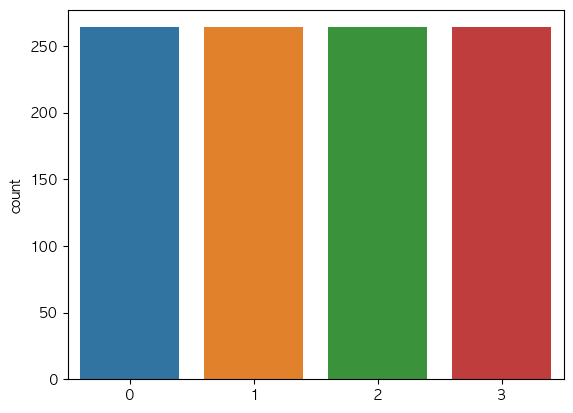

In [117]:
# 표준화
scaler = StandardScaler()
columns_to_scale = A_feature.columns
A_feature[columns_to_scale] = scaler.fit_transform(A_feature[columns_to_scale])

# A score
A_train, A_test, y_train, y_test = train_test_split(A_feature, y, test_size=0.2, random_state=random_state)

# Borderline-SMOTE를 사용하여 오버샘플링
borderline_smote = BorderlineSMOTE(random_state = random_state)
A_resampled, y_resampled = borderline_smote.fit_resample(A_train, y_train)

# 데이터 증강이 되었는지 확인
print('Borderline-SMOTE 적용 후 값의 분포:\n', pd.Series(y_resampled).value_counts())
sns.countplot(x=y_resampled, order=[0, 1, 2, 3])

In [118]:
# 다중분류 모델 설정
models = [
    ("Logistic Regression", LogisticRegression(multi_class='multinomial', max_iter=1000, random_state = random_state)),
    ("Support Vector Machines", SVC(decision_function_shape='ovr', random_state = random_state)),
    ("Random Forest", RandomForestClassifier(random_state = random_state)),
    ("XGBClassifier", XGBClassifier(objective='multi:softmax', num_class=num_class, random_state = random_state)),
    ("LGBMClassifier", LGBMClassifier(objective='multiclass', num_class=num_class, random_state = random_state)),
    ("CatBoostClassifier", CatBoostClassifier(random_state = random_state))
]

for name, model in models:
    model.fit(A_resampled, y_resampled)
    y_pred = model.predict(A_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}")

Logistic Regression - Accuracy: 0.5099337748344371
Support Vector Machines - Accuracy: 0.5033112582781457
Random Forest - Accuracy: 0.5496688741721855
XGBClassifier - Accuracy: 0.423841059602649
LGBMClassifier - Accuracy: 0.5033112582781457
Learning rate set to 0.079347
0:	learn: 1.3425396	total: 1.73ms	remaining: 1.73s
1:	learn: 1.3050110	total: 3.11ms	remaining: 1.55s
2:	learn: 1.2739575	total: 4.2ms	remaining: 1.4s
3:	learn: 1.2456842	total: 5.49ms	remaining: 1.37s
4:	learn: 1.2158634	total: 6.61ms	remaining: 1.32s
5:	learn: 1.1932802	total: 7.74ms	remaining: 1.28s
6:	learn: 1.1699109	total: 9.1ms	remaining: 1.29s
7:	learn: 1.1516629	total: 10.3ms	remaining: 1.28s
8:	learn: 1.1331816	total: 11.7ms	remaining: 1.28s
9:	learn: 1.1178947	total: 13.1ms	remaining: 1.3s
10:	learn: 1.1060891	total: 14.2ms	remaining: 1.28s
11:	learn: 1.0920617	total: 15.3ms	remaining: 1.26s
12:	learn: 1.0812371	total: 16.5ms	remaining: 1.25s
13:	learn: 1.0689317	total: 17.4ms	remaining: 1.22s
14:	learn: 1.05

161:	learn: 0.6883559	total: 196ms	remaining: 1.01s
162:	learn: 0.6874282	total: 197ms	remaining: 1.01s
163:	learn: 0.6861714	total: 198ms	remaining: 1.01s
164:	learn: 0.6850154	total: 199ms	remaining: 1.01s
165:	learn: 0.6832698	total: 200ms	remaining: 1s
166:	learn: 0.6820920	total: 201ms	remaining: 1s
167:	learn: 0.6804917	total: 202ms	remaining: 1s
168:	learn: 0.6778063	total: 203ms	remaining: 999ms
169:	learn: 0.6760385	total: 204ms	remaining: 998ms
170:	learn: 0.6747291	total: 205ms	remaining: 996ms
171:	learn: 0.6736740	total: 207ms	remaining: 994ms
172:	learn: 0.6725609	total: 207ms	remaining: 992ms
173:	learn: 0.6717714	total: 208ms	remaining: 989ms
174:	learn: 0.6704601	total: 210ms	remaining: 988ms
175:	learn: 0.6688156	total: 211ms	remaining: 987ms
176:	learn: 0.6664428	total: 212ms	remaining: 985ms
177:	learn: 0.6651180	total: 213ms	remaining: 983ms
178:	learn: 0.6639121	total: 214ms	remaining: 981ms
179:	learn: 0.6631731	total: 215ms	remaining: 978ms
180:	learn: 0.6618443

374:	learn: 0.4952416	total: 394ms	remaining: 657ms
375:	learn: 0.4946572	total: 395ms	remaining: 656ms
376:	learn: 0.4942293	total: 396ms	remaining: 654ms
377:	learn: 0.4936015	total: 397ms	remaining: 653ms
378:	learn: 0.4932654	total: 398ms	remaining: 652ms
379:	learn: 0.4928633	total: 399ms	remaining: 651ms
380:	learn: 0.4923219	total: 400ms	remaining: 649ms
381:	learn: 0.4912048	total: 401ms	remaining: 648ms
382:	learn: 0.4901554	total: 401ms	remaining: 647ms
383:	learn: 0.4897155	total: 402ms	remaining: 645ms
384:	learn: 0.4892448	total: 403ms	remaining: 644ms
385:	learn: 0.4879481	total: 404ms	remaining: 643ms
386:	learn: 0.4872587	total: 405ms	remaining: 641ms
387:	learn: 0.4867691	total: 406ms	remaining: 640ms
388:	learn: 0.4858101	total: 407ms	remaining: 639ms
389:	learn: 0.4855712	total: 408ms	remaining: 637ms
390:	learn: 0.4849975	total: 408ms	remaining: 636ms
391:	learn: 0.4847744	total: 409ms	remaining: 635ms
392:	learn: 0.4841974	total: 410ms	remaining: 634ms
393:	learn: 

590:	learn: 0.3878182	total: 592ms	remaining: 409ms
591:	learn: 0.3875525	total: 593ms	remaining: 408ms
592:	learn: 0.3869461	total: 593ms	remaining: 407ms
593:	learn: 0.3865512	total: 594ms	remaining: 406ms
594:	learn: 0.3861365	total: 595ms	remaining: 405ms
595:	learn: 0.3857365	total: 596ms	remaining: 404ms
596:	learn: 0.3854034	total: 597ms	remaining: 403ms
597:	learn: 0.3848223	total: 598ms	remaining: 402ms
598:	learn: 0.3843814	total: 599ms	remaining: 401ms
599:	learn: 0.3840526	total: 600ms	remaining: 400ms
600:	learn: 0.3838571	total: 601ms	remaining: 399ms
601:	learn: 0.3836562	total: 602ms	remaining: 398ms
602:	learn: 0.3833538	total: 603ms	remaining: 397ms
603:	learn: 0.3828100	total: 603ms	remaining: 396ms
604:	learn: 0.3825258	total: 604ms	remaining: 395ms
605:	learn: 0.3821129	total: 605ms	remaining: 393ms
606:	learn: 0.3816173	total: 606ms	remaining: 393ms
607:	learn: 0.3813964	total: 607ms	remaining: 391ms
608:	learn: 0.3809450	total: 608ms	remaining: 390ms
609:	learn: 

801:	learn: 0.3189010	total: 789ms	remaining: 195ms
802:	learn: 0.3185889	total: 790ms	remaining: 194ms
803:	learn: 0.3183281	total: 791ms	remaining: 193ms
804:	learn: 0.3181736	total: 792ms	remaining: 192ms
805:	learn: 0.3180200	total: 793ms	remaining: 191ms
806:	learn: 0.3176854	total: 794ms	remaining: 190ms
807:	learn: 0.3174234	total: 795ms	remaining: 189ms
808:	learn: 0.3166742	total: 796ms	remaining: 188ms
809:	learn: 0.3164635	total: 798ms	remaining: 187ms
810:	learn: 0.3162874	total: 799ms	remaining: 186ms
811:	learn: 0.3160436	total: 800ms	remaining: 185ms
812:	learn: 0.3157921	total: 802ms	remaining: 185ms
813:	learn: 0.3154453	total: 803ms	remaining: 184ms
814:	learn: 0.3151293	total: 804ms	remaining: 183ms
815:	learn: 0.3148801	total: 805ms	remaining: 182ms
816:	learn: 0.3145626	total: 806ms	remaining: 181ms
817:	learn: 0.3144189	total: 807ms	remaining: 180ms
818:	learn: 0.3142148	total: 808ms	remaining: 179ms
819:	learn: 0.3140871	total: 809ms	remaining: 178ms
820:	learn: 

## 1) LogisticRegression : softmax

In [119]:
logreg = LogisticRegression(multi_class='multinomial', random_state = random_state)

# 파라미터 범위
param_grid = {
    'C': [1, 10, 50, 100, 150, 200, 300],     # 규제 강도 파라미터
    'penalty': ['l1', 'l2'],                  # 규제 유형 (L1 또는 L2)
    'max_iter': [10, 20, 30 , 40, 50],        # 최대 반복 횟수
    'class_weight': [None, 'balanced'],       # 클래스별 가중치
    'solver': ['lbfgs', 'sag', 'newton-cg'],  # 최적화 알고리즘
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(A_resampled, y_resampled)

logreg_A = grid_search.best_estimator_
y_pred = logreg_A.predict(A_test)

accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'C': 100, 'class_weight': None, 'max_iter': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Test Accuracy: 0.5099337748344371


## 2) Support Vector Machines : SVC

In [120]:
# ovr : One-vs-Rest가 ovo와 성능은 차이가 없는데 계산량이 월등히 빨라 ovr을 선택
svc = SVC(decision_function_shape='ovr', probability=True)

# 파라미터 범위
param_grid = {
    'C': [0.1, 1, 10, 100, 500, 1000, 1100, 1200],  # 규제 파라미터
    'kernel': ['linear', 'rbf'],                    # 커널 종류
    'gamma': ['scale', 'auto']                      # gamma 값
}

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(A_resampled, y_resampled)

svc_A = grid_search.best_estimator_
y_pred = svc_A.predict(A_test)

accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy: 0.4966887417218543


## 3) RandomForest : Bagging

In [121]:
rf = RandomForestClassifier(criterion = 'entropy', class_weight = 'balanced', n_jobs=-1, random_state=random_state)

# 파라미터 범위
param_grid = {
    'n_estimators': [200, 250, 300, 350, 400],  # 결정 트리의 개수
    'max_depth': [10, 15, 20, 25, 30, 35],      # 트리의 최대 깊이
    'min_samples_split': [1, 2, 3],             # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1],                    # 리프 노드의 최소 샘플 수
    'max_features': ['sqrt']                    # 최대 피처 개수
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(A_resampled, y_resampled)

rf_A = grid_search.best_estimator_
y_pred = rf_A.predict(A_test)

accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 250}
Test Accuracy: 0.5165562913907285


## 4) XGBClassifier : xgboost

In [122]:
# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'max_depth': trial.suggest_int('max_depth', 30, 35),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10),
        'objective': 'multi:softmax',
        'num_class': num_class
    }


    model = XGBClassifier(**params, random_state = random_state)
    model.fit(A_resampled, y_resampled)
    y_pred = model.predict(A_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
xgb_A = optuna.create_study(direction='maximize')
xgb_A.optimize(objective, n_trials=300)

print("Test parameters:", xgb_A.best_params)
print("Test Accuracy:", xgb_A.best_value)

[I 2023-09-10 20:33:48,406] A new study created in memory with name: no-name-90199b9a-15cb-4f2a-a826-c2d6a4967bb2
[I 2023-09-10 20:33:48,799] Trial 0 finished with value: 0.4900662251655629 and parameters: {'max_depth': 34, 'learning_rate': 0.04139701540751936, 'n_estimators': 442, 'min_child_weight': 1, 'subsample': 0.6507796555403352, 'colsample_bytree': 0.808213212235143, 'reg_alpha': 7.329136843161435, 'reg_lambda': 1.860741907293878}. Best is trial 0 with value: 0.4900662251655629.
[I 2023-09-10 20:33:49,183] Trial 1 finished with value: 0.46357615894039733 and parameters: {'max_depth': 35, 'learning_rate': 0.03625347849700516, 'n_estimators': 614, 'min_child_weight': 2, 'subsample': 0.9292249823625535, 'colsample_bytree': 0.6533985077604667, 'reg_alpha': 8.16086610759167, 'reg_lambda': 8.749695181228912}. Best is trial 0 with value: 0.4900662251655629.
[I 2023-09-10 20:33:49,566] Trial 2 finished with value: 0.4304635761589404 and parameters: {'max_depth': 31, 'learning_rate': 0.

[I 2023-09-10 20:33:59,307] Trial 22 finished with value: 0.4966887417218543 and parameters: {'max_depth': 32, 'learning_rate': 0.05476028933111885, 'n_estimators': 340, 'min_child_weight': 4, 'subsample': 0.916328709654453, 'colsample_bytree': 0.8726593725618612, 'reg_alpha': 9.210815955504984, 'reg_lambda': 0.8126107133947358}. Best is trial 8 with value: 0.5099337748344371.
[I 2023-09-10 20:33:59,734] Trial 23 finished with value: 0.5099337748344371 and parameters: {'max_depth': 31, 'learning_rate': 0.0664998441983275, 'n_estimators': 624, 'min_child_weight': 5, 'subsample': 0.9594603420487354, 'colsample_bytree': 0.934665184377425, 'reg_alpha': 9.320499182524564, 'reg_lambda': 0.3153377973555611}. Best is trial 8 with value: 0.5099337748344371.
[I 2023-09-10 20:34:00,095] Trial 24 finished with value: 0.5033112582781457 and parameters: {'max_depth': 30, 'learning_rate': 0.04420800436716709, 'n_estimators': 435, 'min_child_weight': 4, 'subsample': 0.9998015779043343, 'colsample_bytr

[I 2023-09-10 20:34:07,312] Trial 44 finished with value: 0.5033112582781457 and parameters: {'max_depth': 31, 'learning_rate': 0.06499906548706752, 'n_estimators': 672, 'min_child_weight': 5, 'subsample': 0.9855743512661618, 'colsample_bytree': 0.9759520373361176, 'reg_alpha': 9.116662529348835, 'reg_lambda': 1.2404736330141062}. Best is trial 8 with value: 0.5099337748344371.
[I 2023-09-10 20:34:07,660] Trial 45 finished with value: 0.5033112582781457 and parameters: {'max_depth': 32, 'learning_rate': 0.06158994944707743, 'n_estimators': 538, 'min_child_weight': 4, 'subsample': 0.9298575211996527, 'colsample_bytree': 0.9358034926118498, 'reg_alpha': 9.948933264342086, 'reg_lambda': 0.4842362641805814}. Best is trial 8 with value: 0.5099337748344371.
[I 2023-09-10 20:34:08,199] Trial 46 finished with value: 0.4900662251655629 and parameters: {'max_depth': 30, 'learning_rate': 0.07876937146876414, 'n_estimators': 874, 'min_child_weight': 5, 'subsample': 0.9680326624261109, 'colsample_b

[I 2023-09-10 20:34:14,613] Trial 66 finished with value: 0.5033112582781457 and parameters: {'max_depth': 32, 'learning_rate': 0.06284707538572445, 'n_estimators': 407, 'min_child_weight': 5, 'subsample': 0.9282406114994042, 'colsample_bytree': 0.9462920290582932, 'reg_alpha': 9.1528215927717, 'reg_lambda': 0.012152409275372006}. Best is trial 62 with value: 0.5165562913907285.
[I 2023-09-10 20:34:14,938] Trial 67 finished with value: 0.5099337748344371 and parameters: {'max_depth': 35, 'learning_rate': 0.058951218361836255, 'n_estimators': 487, 'min_child_weight': 2, 'subsample': 0.984918416947862, 'colsample_bytree': 0.9108306734057252, 'reg_alpha': 9.652286070628703, 'reg_lambda': 0.5998438384733058}. Best is trial 62 with value: 0.5165562913907285.
[I 2023-09-10 20:34:15,184] Trial 68 finished with value: 0.5033112582781457 and parameters: {'max_depth': 31, 'learning_rate': 0.049419609412578405, 'n_estimators': 239, 'min_child_weight': 3, 'subsample': 0.9520311186715618, 'colsampl

[I 2023-09-10 20:34:20,571] Trial 88 finished with value: 0.5165562913907285 and parameters: {'max_depth': 30, 'learning_rate': 0.050451065075682144, 'n_estimators': 174, 'min_child_weight': 1, 'subsample': 0.9893335217373966, 'colsample_bytree': 0.9281030805320984, 'reg_alpha': 8.688638657827799, 'reg_lambda': 2.738259954369965}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:20,767] Trial 89 finished with value: 0.5099337748344371 and parameters: {'max_depth': 30, 'learning_rate': 0.048929384873775676, 'n_estimators': 166, 'min_child_weight': 1, 'subsample': 0.9686506062662483, 'colsample_bytree': 0.9521593854166742, 'reg_alpha': 8.670478464693947, 'reg_lambda': 2.315911909778301}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:20,990] Trial 90 finished with value: 0.5033112582781457 and parameters: {'max_depth': 30, 'learning_rate': 0.050637256301471936, 'n_estimators': 191, 'min_child_weight': 1, 'subsample': 0.9893713838495969, 'colsampl

[I 2023-09-10 20:34:25,419] Trial 110 finished with value: 0.5231788079470199 and parameters: {'max_depth': 30, 'learning_rate': 0.045157167728427275, 'n_estimators': 256, 'min_child_weight': 1, 'subsample': 0.9527393216840803, 'colsample_bytree': 0.9717463092170608, 'reg_alpha': 8.457969893312782, 'reg_lambda': 3.0787118438466203}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:25,697] Trial 111 finished with value: 0.5165562913907285 and parameters: {'max_depth': 30, 'learning_rate': 0.04718099165084664, 'n_estimators': 257, 'min_child_weight': 1, 'subsample': 0.9380659685843318, 'colsample_bytree': 0.998149735697048, 'reg_alpha': 8.468537141269085, 'reg_lambda': 3.149680584292221}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:25,941] Trial 112 finished with value: 0.4966887417218543 and parameters: {'max_depth': 30, 'learning_rate': 0.04468991134724661, 'n_estimators': 221, 'min_child_weight': 2, 'subsample': 0.9511608972174443, 'colsamp

[I 2023-09-10 20:34:31,136] Trial 132 finished with value: 0.5231788079470199 and parameters: {'max_depth': 30, 'learning_rate': 0.03927937673345536, 'n_estimators': 237, 'min_child_weight': 1, 'subsample': 0.9314694678277863, 'colsample_bytree': 0.9488362926863926, 'reg_alpha': 8.887273237425807, 'reg_lambda': 4.245477966548229}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:31,429] Trial 133 finished with value: 0.5298013245033113 and parameters: {'max_depth': 30, 'learning_rate': 0.037235144904491466, 'n_estimators': 257, 'min_child_weight': 1, 'subsample': 0.9533898700486956, 'colsample_bytree': 0.9549914081688214, 'reg_alpha': 8.406740264456248, 'reg_lambda': 3.0904368336473427}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:31,779] Trial 134 finished with value: 0.5165562913907285 and parameters: {'max_depth': 30, 'learning_rate': 0.03546441278273592, 'n_estimators': 277, 'min_child_weight': 1, 'subsample': 0.9638932152729532, 'colsam

[I 2023-09-10 20:34:37,186] Trial 154 finished with value: 0.5033112582781457 and parameters: {'max_depth': 34, 'learning_rate': 0.04831441492929985, 'n_estimators': 122, 'min_child_weight': 1, 'subsample': 0.9852585210499616, 'colsample_bytree': 0.9930623666123706, 'reg_alpha': 9.308050055940353, 'reg_lambda': 3.2363383652825064}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:37,462] Trial 155 finished with value: 0.5165562913907285 and parameters: {'max_depth': 35, 'learning_rate': 0.05040999065957098, 'n_estimators': 223, 'min_child_weight': 1, 'subsample': 0.991989526873449, 'colsample_bytree': 0.9564886262002149, 'reg_alpha': 8.733193876465158, 'reg_lambda': 3.8285430992994396}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:37,686] Trial 156 finished with value: 0.5231788079470199 and parameters: {'max_depth': 35, 'learning_rate': 0.0537197410368111, 'n_estimators': 178, 'min_child_weight': 1, 'subsample': 0.9744349806180171, 'colsampl

[I 2023-09-10 20:34:43,631] Trial 176 finished with value: 0.5298013245033113 and parameters: {'max_depth': 30, 'learning_rate': 0.050118065442073485, 'n_estimators': 277, 'min_child_weight': 1, 'subsample': 0.9924944423693818, 'colsample_bytree': 0.9467782054052442, 'reg_alpha': 8.767717542275372, 'reg_lambda': 4.103718678643873}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:43,959] Trial 177 finished with value: 0.5231788079470199 and parameters: {'max_depth': 35, 'learning_rate': 0.050059234260507325, 'n_estimators': 282, 'min_child_weight': 1, 'subsample': 0.9981378023132345, 'colsample_bytree': 0.9429910350242494, 'reg_alpha': 8.81771179260547, 'reg_lambda': 4.096942461330777}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:44,288] Trial 178 finished with value: 0.5231788079470199 and parameters: {'max_depth': 30, 'learning_rate': 0.046706771258572484, 'n_estimators': 316, 'min_child_weight': 1, 'subsample': 0.9878091576159959, 'colsam

[I 2023-09-10 20:34:50,322] Trial 198 finished with value: 0.5099337748344371 and parameters: {'max_depth': 30, 'learning_rate': 0.04370558807214359, 'n_estimators': 171, 'min_child_weight': 1, 'subsample': 0.9707105348823345, 'colsample_bytree': 0.960019501898051, 'reg_alpha': 9.061298334518064, 'reg_lambda': 3.4802678984072837}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:50,638] Trial 199 finished with value: 0.4900662251655629 and parameters: {'max_depth': 30, 'learning_rate': 0.05234798144109229, 'n_estimators': 227, 'min_child_weight': 1, 'subsample': 0.9904811044235414, 'colsample_bytree': 0.9312871476983855, 'reg_alpha': 6.171922676503204, 'reg_lambda': 4.400151761929421}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:50,923] Trial 200 finished with value: 0.48344370860927155 and parameters: {'max_depth': 30, 'learning_rate': 0.056102599038240074, 'n_estimators': 256, 'min_child_weight': 1, 'subsample': 0.7893753608948402, 'colsam

[I 2023-09-10 20:34:56,524] Trial 220 finished with value: 0.5231788079470199 and parameters: {'max_depth': 30, 'learning_rate': 0.042373138826854624, 'n_estimators': 266, 'min_child_weight': 1, 'subsample': 0.9991600629789994, 'colsample_bytree': 0.9899482389698242, 'reg_alpha': 8.783095869314977, 'reg_lambda': 2.628115674061834}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:56,807] Trial 221 finished with value: 0.5298013245033113 and parameters: {'max_depth': 35, 'learning_rate': 0.04330581272984424, 'n_estimators': 260, 'min_child_weight': 1, 'subsample': 0.9847271833558447, 'colsample_bytree': 0.9670325387277077, 'reg_alpha': 8.970168176549898, 'reg_lambda': 2.0681355359391476}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:34:57,088] Trial 222 finished with value: 0.5231788079470199 and parameters: {'max_depth': 35, 'learning_rate': 0.04449351473326173, 'n_estimators': 256, 'min_child_weight': 1, 'subsample': 0.9906279821862387, 'colsam

[I 2023-09-10 20:35:03,233] Trial 242 finished with value: 0.5099337748344371 and parameters: {'max_depth': 30, 'learning_rate': 0.0375293120343191, 'n_estimators': 223, 'min_child_weight': 1, 'subsample': 0.9684030338437359, 'colsample_bytree': 0.975802219227206, 'reg_alpha': 9.644560358144423, 'reg_lambda': 3.4293012076925184}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:35:03,570] Trial 243 finished with value: 0.5231788079470199 and parameters: {'max_depth': 30, 'learning_rate': 0.04098956487811342, 'n_estimators': 252, 'min_child_weight': 1, 'subsample': 0.9744610691920217, 'colsample_bytree': 0.859683507828818, 'reg_alpha': 8.727497564697618, 'reg_lambda': 3.186862318732753}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:35:03,891] Trial 244 finished with value: 0.5231788079470199 and parameters: {'max_depth': 30, 'learning_rate': 0.04443397213468669, 'n_estimators': 282, 'min_child_weight': 1, 'subsample': 0.9627106434040026, 'colsample_

[I 2023-09-10 20:35:10,055] Trial 264 finished with value: 0.5165562913907285 and parameters: {'max_depth': 30, 'learning_rate': 0.0526034870600542, 'n_estimators': 990, 'min_child_weight': 1, 'subsample': 0.99909366947196, 'colsample_bytree': 0.9671756465463298, 'reg_alpha': 9.320447444826039, 'reg_lambda': 3.7834862106056044}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:35:10,333] Trial 265 finished with value: 0.5165562913907285 and parameters: {'max_depth': 30, 'learning_rate': 0.046353789220039666, 'n_estimators': 234, 'min_child_weight': 1, 'subsample': 0.9618996322926385, 'colsample_bytree': 0.7623837712828159, 'reg_alpha': 8.536182852547151, 'reg_lambda': 2.9512475903116373}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:35:10,694] Trial 266 finished with value: 0.5099337748344371 and parameters: {'max_depth': 30, 'learning_rate': 0.08120566687168385, 'n_estimators': 219, 'min_child_weight': 1, 'subsample': 0.9745406063720298, 'colsampl

[I 2023-09-10 20:35:17,294] Trial 286 finished with value: 0.5298013245033113 and parameters: {'max_depth': 30, 'learning_rate': 0.04512636981114312, 'n_estimators': 256, 'min_child_weight': 1, 'subsample': 0.9832360267863487, 'colsample_bytree': 0.9482546435019489, 'reg_alpha': 9.145742015975227, 'reg_lambda': 3.822860591917441}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:35:17,577] Trial 287 finished with value: 0.5165562913907285 and parameters: {'max_depth': 35, 'learning_rate': 0.04040459066002875, 'n_estimators': 224, 'min_child_weight': 1, 'subsample': 0.9910278270359841, 'colsample_bytree': 0.9729653817321436, 'reg_alpha': 8.459169156291331, 'reg_lambda': 3.330402284597343}. Best is trial 84 with value: 0.5298013245033113.
[I 2023-09-10 20:35:17,928] Trial 288 finished with value: 0.5231788079470199 and parameters: {'max_depth': 30, 'learning_rate': 0.047616379405302375, 'n_estimators': 342, 'min_child_weight': 1, 'subsample': 0.9280883562739743, 'colsamp

Test parameters: {'max_depth': 32, 'learning_rate': 0.05370510521679618, 'n_estimators': 149, 'min_child_weight': 1, 'subsample': 0.967544764265136, 'colsample_bytree': 0.9410139198358682, 'reg_alpha': 9.14449946434238, 'reg_lambda': 2.4759987566617228}
Test Accuracy: 0.5298013245033113


## 5) LGBClassifier : lightgbm

In [123]:
# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10),
        'objective': 'multiclass',
        'num_class': num_class
    }

    model = LGBMClassifier(**params, random_state=random_state)
    model.fit(A_resampled, y_resampled)
    y_pred = model.predict(A_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
lgbm_A = optuna.create_study(direction='maximize')
lgbm_A.optimize(objective, n_trials=300)

print("Test parameters:", lgbm_A.best_params)
print("Test Accuracy:", lgbm_A.best_value)

[I 2023-09-10 20:35:21,344] A new study created in memory with name: no-name-4b14ebc9-6081-4741-8ce6-9e8b01b1644e
[I 2023-09-10 20:35:21,655] Trial 0 finished with value: 0.4768211920529801 and parameters: {'max_depth': 22, 'learning_rate': 0.060986930349783725, 'n_estimators': 567, 'min_child_samples': 8, 'subsample': 0.7944537704747965, 'colsample_bytree': 0.992672657638912, 'reg_alpha': 8.718314093996767, 'reg_lambda': 7.694334375129618}. Best is trial 0 with value: 0.4768211920529801.
[I 2023-09-10 20:35:22,028] Trial 1 finished with value: 0.4900662251655629 and parameters: {'max_depth': 12, 'learning_rate': 0.03607986628995314, 'n_estimators': 838, 'min_child_samples': 2, 'subsample': 0.7679817670947011, 'colsample_bytree': 0.9856778617803658, 'reg_alpha': 5.267092773982226, 'reg_lambda': 3.920392545515201}. Best is trial 1 with value: 0.4900662251655629.
[I 2023-09-10 20:35:22,413] Trial 2 finished with value: 0.48344370860927155 and parameters: {'max_depth': 20, 'learning_rate'

[I 2023-09-10 20:35:31,733] Trial 22 finished with value: 0.5231788079470199 and parameters: {'max_depth': 17, 'learning_rate': 0.010592903652440186, 'n_estimators': 791, 'min_child_samples': 5, 'subsample': 0.941363990956791, 'colsample_bytree': 0.8481775288628727, 'reg_alpha': 3.9864753923287672, 'reg_lambda': 4.832933674853033}. Best is trial 10 with value: 0.5231788079470199.
[I 2023-09-10 20:35:32,224] Trial 23 finished with value: 0.4900662251655629 and parameters: {'max_depth': 8, 'learning_rate': 0.022041823890224695, 'n_estimators': 974, 'min_child_samples': 4, 'subsample': 0.8435799339737255, 'colsample_bytree': 0.860411984349524, 'reg_alpha': 4.917532410536028, 'reg_lambda': 5.995031673437729}. Best is trial 10 with value: 0.5231788079470199.
[I 2023-09-10 20:35:32,694] Trial 24 finished with value: 0.5165562913907285 and parameters: {'max_depth': 25, 'learning_rate': 0.030889266646168055, 'n_estimators': 790, 'min_child_samples': 6, 'subsample': 0.9191990927399536, 'colsamp

[I 2023-09-10 20:35:42,801] Trial 44 finished with value: 0.5165562913907285 and parameters: {'max_depth': 28, 'learning_rate': 0.019941892500819947, 'n_estimators': 735, 'min_child_samples': 5, 'subsample': 0.9349979260228989, 'colsample_bytree': 0.9119437354854922, 'reg_alpha': 4.917697622556149, 'reg_lambda': 4.095297526959313}. Best is trial 31 with value: 0.5298013245033113.
[I 2023-09-10 20:35:43,402] Trial 45 finished with value: 0.48344370860927155 and parameters: {'max_depth': 24, 'learning_rate': 0.02495211227779187, 'n_estimators': 529, 'min_child_samples': 6, 'subsample': 0.9778861777432546, 'colsample_bytree': 0.8783220331096718, 'reg_alpha': 3.152806295453803, 'reg_lambda': 4.683216518259384}. Best is trial 31 with value: 0.5298013245033113.
[I 2023-09-10 20:35:43,892] Trial 46 finished with value: 0.4900662251655629 and parameters: {'max_depth': 50, 'learning_rate': 0.019648288133595704, 'n_estimators': 676, 'min_child_samples': 4, 'subsample': 0.9104452258930357, 'colsa

[I 2023-09-10 20:35:56,297] Trial 66 finished with value: 0.5033112582781457 and parameters: {'max_depth': 11, 'learning_rate': 0.022899825893814996, 'n_estimators': 942, 'min_child_samples': 6, 'subsample': 0.9249005278982277, 'colsample_bytree': 0.8685112982650273, 'reg_alpha': 4.955676126358651, 'reg_lambda': 4.199985836312415}. Best is trial 31 with value: 0.5298013245033113.
[I 2023-09-10 20:35:56,895] Trial 67 finished with value: 0.4768211920529801 and parameters: {'max_depth': 21, 'learning_rate': 0.027990242255553015, 'n_estimators': 977, 'min_child_samples': 4, 'subsample': 0.9586670299827811, 'colsample_bytree': 0.8998037324712972, 'reg_alpha': 3.1079171269493218, 'reg_lambda': 4.7192726567324375}. Best is trial 31 with value: 0.5298013245033113.
[I 2023-09-10 20:35:57,441] Trial 68 finished with value: 0.4900662251655629 and parameters: {'max_depth': 6, 'learning_rate': 0.01699821516439737, 'n_estimators': 803, 'min_child_samples': 3, 'subsample': 0.9139022763271482, 'colsa

[I 2023-09-10 20:36:13,644] Trial 88 finished with value: 0.5099337748344371 and parameters: {'max_depth': 40, 'learning_rate': 0.015846185432474992, 'n_estimators': 974, 'min_child_samples': 10, 'subsample': 0.9909188232467669, 'colsample_bytree': 0.9301517258829037, 'reg_alpha': 3.202781413800512, 'reg_lambda': 5.6126803284824085}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:36:14,432] Trial 89 finished with value: 0.5231788079470199 and parameters: {'max_depth': 39, 'learning_rate': 0.019339035641745567, 'n_estimators': 946, 'min_child_samples': 10, 'subsample': 0.9656220952397168, 'colsample_bytree': 0.9672504120448686, 'reg_alpha': 3.710356740242827, 'reg_lambda': 5.935306105713819}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:36:15,618] Trial 90 finished with value: 0.5033112582781457 and parameters: {'max_depth': 41, 'learning_rate': 0.012373993104115457, 'n_estimators': 919, 'min_child_samples': 9, 'subsample': 0.9765789345986291, 'co

[I 2023-09-10 20:36:32,035] Trial 110 finished with value: 0.5231788079470199 and parameters: {'max_depth': 41, 'learning_rate': 0.019013709500221646, 'n_estimators': 925, 'min_child_samples': 10, 'subsample': 0.9301032809284251, 'colsample_bytree': 0.8973067384456742, 'reg_alpha': 4.213620806556106, 'reg_lambda': 4.547822072261008}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:36:33,054] Trial 111 finished with value: 0.5165562913907285 and parameters: {'max_depth': 50, 'learning_rate': 0.011045811141642492, 'n_estimators': 967, 'min_child_samples': 10, 'subsample': 0.9705131027088275, 'colsample_bytree': 0.9488871397158538, 'reg_alpha': 3.952288600467579, 'reg_lambda': 5.509400845872259}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:36:33,932] Trial 112 finished with value: 0.5298013245033113 and parameters: {'max_depth': 47, 'learning_rate': 0.010551084772688785, 'n_estimators': 981, 'min_child_samples': 10, 'subsample': 0.9994990718354217, 

[I 2023-09-10 20:36:47,788] Trial 132 finished with value: 0.5364238410596026 and parameters: {'max_depth': 41, 'learning_rate': 0.020387028485110575, 'n_estimators': 984, 'min_child_samples': 10, 'subsample': 0.9724581721372755, 'colsample_bytree': 0.9330181672937954, 'reg_alpha': 4.526959625863778, 'reg_lambda': 5.822827616771073}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:36:48,292] Trial 133 finished with value: 0.5231788079470199 and parameters: {'max_depth': 38, 'learning_rate': 0.025811261235104018, 'n_estimators': 947, 'min_child_samples': 10, 'subsample': 0.9692403774238536, 'colsample_bytree': 0.933582107215583, 'reg_alpha': 3.9095764469188463, 'reg_lambda': 5.82628094049814}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:36:49,263] Trial 134 finished with value: 0.5099337748344371 and parameters: {'max_depth': 41, 'learning_rate': 0.013435693003809111, 'n_estimators': 986, 'min_child_samples': 9, 'subsample': 0.9500697530278905, 'c

[I 2023-09-10 20:37:00,331] Trial 154 finished with value: 0.5231788079470199 and parameters: {'max_depth': 39, 'learning_rate': 0.02347167695300103, 'n_estimators': 422, 'min_child_samples': 10, 'subsample': 0.9508960649976314, 'colsample_bytree': 0.9203758574576125, 'reg_alpha': 3.9441444441030007, 'reg_lambda': 5.1642991133656935}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:37:01,054] Trial 155 finished with value: 0.5165562913907285 and parameters: {'max_depth': 41, 'learning_rate': 0.01644560162329364, 'n_estimators': 980, 'min_child_samples': 10, 'subsample': 0.9750092045233172, 'colsample_bytree': 0.9034282187371413, 'reg_alpha': 4.528118209399455, 'reg_lambda': 5.5924865195961955}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:37:02,050] Trial 156 finished with value: 0.5165562913907285 and parameters: {'max_depth': 34, 'learning_rate': 0.014256478747754204, 'n_estimators': 969, 'min_child_samples': 9, 'subsample': 0.9898907119674802, 

[I 2023-09-10 20:37:14,048] Trial 176 finished with value: 0.4966887417218543 and parameters: {'max_depth': 4, 'learning_rate': 0.027696359296851117, 'n_estimators': 567, 'min_child_samples': 1, 'subsample': 0.7246520834670712, 'colsample_bytree': 0.8680492870232198, 'reg_alpha': 2.993590560181369, 'reg_lambda': 5.71314548933993}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:37:14,367] Trial 177 finished with value: 0.5033112582781457 and parameters: {'max_depth': 4, 'learning_rate': 0.032270273116159105, 'n_estimators': 899, 'min_child_samples': 2, 'subsample': 0.8300965400994065, 'colsample_bytree': 0.9238168699299432, 'reg_alpha': 3.3679481732503818, 'reg_lambda': 6.069834470424007}. Best is trial 87 with value: 0.5364238410596026.
[I 2023-09-10 20:37:15,107] Trial 178 finished with value: 0.48344370860927155 and parameters: {'max_depth': 16, 'learning_rate': 0.03445811620260091, 'n_estimators': 921, 'min_child_samples': 2, 'subsample': 0.7414868257265732, 'cols

[I 2023-09-10 20:37:24,507] Trial 198 finished with value: 0.5231788079470199 and parameters: {'max_depth': 6, 'learning_rate': 0.03166439085054933, 'n_estimators': 902, 'min_child_samples': 10, 'subsample': 0.90084586189885, 'colsample_bytree': 0.8702271801696662, 'reg_alpha': 4.116197650971866, 'reg_lambda': 4.89204429037573}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:24,886] Trial 199 finished with value: 0.5165562913907285 and parameters: {'max_depth': 5, 'learning_rate': 0.03698167472641162, 'n_estimators': 817, 'min_child_samples': 2, 'subsample': 0.8699455804822899, 'colsample_bytree': 0.8853597408949582, 'reg_alpha': 3.5717917934581194, 'reg_lambda': 7.055572737292818}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:25,243] Trial 200 finished with value: 0.4900662251655629 and parameters: {'max_depth': 4, 'learning_rate': 0.033049406515776814, 'n_estimators': 932, 'min_child_samples': 6, 'subsample': 0.8728928666467725, 'colsam

[I 2023-09-10 20:37:32,689] Trial 220 finished with value: 0.5298013245033113 and parameters: {'max_depth': 4, 'learning_rate': 0.04161573606827585, 'n_estimators': 722, 'min_child_samples': 10, 'subsample': 0.8784775533821447, 'colsample_bytree': 0.8915241225408365, 'reg_alpha': 3.7634821003421406, 'reg_lambda': 2.9317225172291375}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:32,971] Trial 221 finished with value: 0.5364238410596026 and parameters: {'max_depth': 5, 'learning_rate': 0.037237126962139065, 'n_estimators': 508, 'min_child_samples': 10, 'subsample': 0.9028273694874444, 'colsample_bytree': 0.8843487095078237, 'reg_alpha': 3.9666628448604127, 'reg_lambda': 5.251259289011255}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:33,283] Trial 222 finished with value: 0.543046357615894 and parameters: {'max_depth': 5, 'learning_rate': 0.03727751893708199, 'n_estimators': 507, 'min_child_samples': 10, 'subsample': 0.9017072226823701, '

[I 2023-09-10 20:37:39,748] Trial 242 finished with value: 0.543046357615894 and parameters: {'max_depth': 5, 'learning_rate': 0.03858949409743188, 'n_estimators': 402, 'min_child_samples': 10, 'subsample': 0.9023795936508352, 'colsample_bytree': 0.8672262724484082, 'reg_alpha': 3.872153805184472, 'reg_lambda': 5.485126159293258}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:39,954] Trial 243 finished with value: 0.5033112582781457 and parameters: {'max_depth': 3, 'learning_rate': 0.03958732839608842, 'n_estimators': 399, 'min_child_samples': 10, 'subsample': 0.8794399257914289, 'colsample_bytree': 0.8572578054993366, 'reg_alpha': 3.717783825583693, 'reg_lambda': 5.618494345024714}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:40,299] Trial 244 finished with value: 0.5364238410596026 and parameters: {'max_depth': 6, 'learning_rate': 0.038239593256579635, 'n_estimators': 386, 'min_child_samples': 10, 'subsample': 0.9173992746304481, 'col

[I 2023-09-10 20:37:46,466] Trial 264 finished with value: 0.5099337748344371 and parameters: {'max_depth': 6, 'learning_rate': 0.04404609632022137, 'n_estimators': 474, 'min_child_samples': 10, 'subsample': 0.8527239962775173, 'colsample_bytree': 0.8995223168577261, 'reg_alpha': 2.9966514424030883, 'reg_lambda': 6.052908951683065}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:46,741] Trial 265 finished with value: 0.4966887417218543 and parameters: {'max_depth': 5, 'learning_rate': 0.04675565897677163, 'n_estimators': 704, 'min_child_samples': 8, 'subsample': 0.8734637595808061, 'colsample_bytree': 0.9223354207288953, 'reg_alpha': 5.511332659798315, 'reg_lambda': 5.568864246169944}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:47,185] Trial 266 finished with value: 0.5496688741721855 and parameters: {'max_depth': 6, 'learning_rate': 0.028833067629280097, 'n_estimators': 559, 'min_child_samples': 10, 'subsample': 0.7685736021568849, 'co

[I 2023-09-10 20:37:56,373] Trial 286 finished with value: 0.5298013245033113 and parameters: {'max_depth': 40, 'learning_rate': 0.047548974256428414, 'n_estimators': 544, 'min_child_samples': 10, 'subsample': 0.7910686135648848, 'colsample_bytree': 0.8402667028927355, 'reg_alpha': 3.231700606732312, 'reg_lambda': 6.609199309186296}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:56,931] Trial 287 finished with value: 0.543046357615894 and parameters: {'max_depth': 6, 'learning_rate': 0.03188876144882621, 'n_estimators': 878, 'min_child_samples': 10, 'subsample': 0.9769935820322627, 'colsample_bytree': 0.8733006607985772, 'reg_alpha': 2.8119644962250403, 'reg_lambda': 7.432178728184036}. Best is trial 192 with value: 0.5496688741721855.
[I 2023-09-10 20:37:57,547] Trial 288 finished with value: 0.46357615894039733 and parameters: {'max_depth': 39, 'learning_rate': 0.032658031416328, 'n_estimators': 887, 'min_child_samples': 10, 'subsample': 0.9777054269766663, 'c

Test parameters: {'max_depth': 5, 'learning_rate': 0.030224804518964525, 'n_estimators': 959, 'min_child_samples': 10, 'subsample': 0.8824830415770595, 'colsample_bytree': 0.8890001629669382, 'reg_alpha': 3.6116765546914826, 'reg_lambda': 5.304028653740568}
Test Accuracy: 0.5496688741721855


## 6) CatBoostClassifier : catboost

In [124]:
# Optuna 목적 함수 정의
def objective(trial):
    # 파라미터 범위
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
         # 부트스트랩 유형 변경
        'bootstrap_type': 'Bayesian',
    }

    model = CatBoostClassifier(**params, verbose=False, random_state=random_state)
    model.fit(A_resampled, y_resampled)
    y_pred = model.predict(A_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Optuna 스터디 생성 및 실행 (정확도 최대화)
cat_A = optuna.create_study(direction='maximize')
cat_A.optimize(objective, n_trials=100)

print("Best parameters:", cat_A.best_params)
print("Test Accuracy:", cat_A.best_value)

[I 2023-09-10 20:38:02,885] A new study created in memory with name: no-name-f9e15420-3040-417a-8107-765d1e3137a4
[I 2023-09-10 20:38:04,333] Trial 0 finished with value: 0.5231788079470199 and parameters: {'depth': 8, 'learning_rate': 0.05990832674079902, 'iterations': 718, 'min_data_in_leaf': 8, 'colsample_bylevel': 0.74692858594994, 'l2_leaf_reg': 2.4546650230302616}. Best is trial 0 with value: 0.5231788079470199.
[I 2023-09-10 20:38:04,761] Trial 1 finished with value: 0.5298013245033113 and parameters: {'depth': 5, 'learning_rate': 0.08831818244884856, 'iterations': 646, 'min_data_in_leaf': 2, 'colsample_bylevel': 0.9887721174006485, 'l2_leaf_reg': 0.05538516355973627}. Best is trial 1 with value: 0.5298013245033113.
[I 2023-09-10 20:38:04,986] Trial 2 finished with value: 0.5033112582781457 and parameters: {'depth': 6, 'learning_rate': 0.04273121565433977, 'iterations': 251, 'min_data_in_leaf': 1, 'colsample_bylevel': 0.8046933533867073, 'l2_leaf_reg': 5.750910782175966}. Best i

[I 2023-09-10 20:39:07,739] Trial 26 finished with value: 0.5364238410596026 and parameters: {'depth': 9, 'learning_rate': 0.08194363558485052, 'iterations': 749, 'min_data_in_leaf': 9, 'colsample_bylevel': 0.9658078727688975, 'l2_leaf_reg': 0.001371908312156666}. Best is trial 21 with value: 0.5496688741721855.
[I 2023-09-10 20:39:08,993] Trial 27 finished with value: 0.5364238410596026 and parameters: {'depth': 7, 'learning_rate': 0.07110308932416089, 'iterations': 896, 'min_data_in_leaf': 5, 'colsample_bylevel': 0.9164374631777034, 'l2_leaf_reg': 0.0002407244166899949}. Best is trial 21 with value: 0.5496688741721855.
[I 2023-09-10 20:39:14,247] Trial 28 finished with value: 0.543046357615894 and parameters: {'depth': 10, 'learning_rate': 0.05432863948120922, 'iterations': 689, 'min_data_in_leaf': 3, 'colsample_bylevel': 0.853200925640653, 'l2_leaf_reg': 0.006799068664233665}. Best is trial 21 with value: 0.5496688741721855.
[I 2023-09-10 20:39:15,755] Trial 29 finished with value: 

[I 2023-09-10 20:40:33,542] Trial 53 finished with value: 0.5629139072847682 and parameters: {'depth': 9, 'learning_rate': 0.07224851291370145, 'iterations': 321, 'min_data_in_leaf': 3, 'colsample_bylevel': 0.9019912040286187, 'l2_leaf_reg': 0.0005295824227817783}. Best is trial 53 with value: 0.5629139072847682.
[I 2023-09-10 20:40:34,819] Trial 54 finished with value: 0.543046357615894 and parameters: {'depth': 9, 'learning_rate': 0.07358378848315408, 'iterations': 317, 'min_data_in_leaf': 7, 'colsample_bylevel': 0.8813950418259846, 'l2_leaf_reg': 0.003655646123810401}. Best is trial 53 with value: 0.5629139072847682.
[I 2023-09-10 20:40:35,652] Trial 55 finished with value: 0.5562913907284768 and parameters: {'depth': 9, 'learning_rate': 0.06922544313737013, 'iterations': 205, 'min_data_in_leaf': 10, 'colsample_bylevel': 0.904384347388351, 'l2_leaf_reg': 0.00048222526600130835}. Best is trial 53 with value: 0.5629139072847682.
[I 2023-09-10 20:40:36,311] Trial 56 finished with value

[I 2023-09-10 20:40:57,596] Trial 80 finished with value: 0.5364238410596026 and parameters: {'depth': 9, 'learning_rate': 0.0812604819447888, 'iterations': 185, 'min_data_in_leaf': 10, 'colsample_bylevel': 0.870312104390826, 'l2_leaf_reg': 0.007616202150078097}. Best is trial 53 with value: 0.5629139072847682.
[I 2023-09-10 20:40:58,652] Trial 81 finished with value: 0.5231788079470199 and parameters: {'depth': 9, 'learning_rate': 0.07321740715952112, 'iterations': 267, 'min_data_in_leaf': 9, 'colsample_bylevel': 0.8589468672812244, 'l2_leaf_reg': 0.0016995073990402506}. Best is trial 53 with value: 0.5629139072847682.
[I 2023-09-10 20:40:59,649] Trial 82 finished with value: 0.5629139072847682 and parameters: {'depth': 9, 'learning_rate': 0.07846415309730587, 'iterations': 242, 'min_data_in_leaf': 3, 'colsample_bylevel': 0.90828965003967, 'l2_leaf_reg': 0.0037458362441020678}. Best is trial 53 with value: 0.5629139072847682.
[I 2023-09-10 20:41:00,627] Trial 83 finished with value: 0

Best parameters: {'depth': 9, 'learning_rate': 0.08938074561871175, 'iterations': 200, 'min_data_in_leaf': 3, 'colsample_bylevel': 0.9229810018364882, 'l2_leaf_reg': 0.0012133406021491613}
Test Accuracy: 0.5695364238410596


# Ensemble modeling

In [125]:
# 개별 파라미터 튜닝된 모델들
all_estimators = [
    ("Logistic Regression", logreg_A),
    ("Support Vector Machines", svc_A),
    ("Random Forest", RandomForestClassifier(random_state=random_state)),
    ("XGBClassifier", XGBClassifier(**xgb_A.best_params, random_state=random_state)),
    ("LGBMClassifier", LGBMClassifier(**lgbm_A.best_params, random_state=random_state)),
    ("CatBoostClassifier", CatBoostClassifier(**cat_A.best_params, random_state=random_state))
]

## 1) Voting : soft

In [126]:
best_combo = None
best_accuracy = 0.0

# 가능한 모든 조합 생성
combinations = []
for r in range(1, len(all_estimators) + 1):
    combinations.extend(itertools.combinations(all_estimators, r))

# 모든 조합에 대한 Soft Voting
for combo in tqdm(combinations):
    combo_name = "_".join([est_name for est_name, _ in combo])
    
    # 해당 조합으로 보팅 분류기 정의
    estimators = list(combo)
    soft_voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft'
    )

    soft_voting_model.fit(A_resampled, y_resampled)
    soft_pred = soft_voting_model.predict(A_test)

    soft_accuracy = accuracy_score(y_test, soft_pred)
    
    # 현재 조합의 결과 출력
    print(f"Combination: {combo_name}")
    print("Soft voting accuracy: ", soft_accuracy)
    print("=" * 40)
    
    # 최고의 조합 업데이트
    if soft_accuracy > best_accuracy:
        best_combo = combo
        best_accuracy = soft_accuracy

# 최고의 조합과 결과 출력
print("Best Combination:", best_combo)
print("Test Soft Voting Accuracy:", best_accuracy)

  0%|                                                    | 0/63 [00:00<?, ?it/s]

Combination: Logistic Regression
Soft voting accuracy:  0.5099337748344371


  3%|█▍                                          | 2/63 [00:00<00:22,  2.65it/s]

Combination: Support Vector Machines
Soft voting accuracy:  0.4768211920529801
Combination: Random Forest
Soft voting accuracy:  0.5496688741721855


  6%|██▊                                         | 4/63 [00:01<00:13,  4.28it/s]

Combination: XGBClassifier
Soft voting accuracy:  0.5298013245033113


  8%|███▍                                        | 5/63 [00:01<00:19,  3.04it/s]

Combination: LGBMClassifier
Soft voting accuracy:  0.5496688741721855
0:	learn: 1.3173338	total: 4.58ms	remaining: 910ms
1:	learn: 1.2608000	total: 9.46ms	remaining: 937ms
2:	learn: 1.2163939	total: 14ms	remaining: 918ms
3:	learn: 1.1704274	total: 18.7ms	remaining: 915ms
4:	learn: 1.1333737	total: 23.5ms	remaining: 915ms
5:	learn: 1.0972305	total: 28.2ms	remaining: 912ms
6:	learn: 1.0661410	total: 32.8ms	remaining: 903ms
7:	learn: 1.0369051	total: 37.5ms	remaining: 901ms
8:	learn: 1.0086799	total: 42.1ms	remaining: 894ms
9:	learn: 0.9854385	total: 47.1ms	remaining: 896ms
10:	learn: 0.9640048	total: 51.9ms	remaining: 891ms
11:	learn: 0.9438293	total: 56.5ms	remaining: 885ms
12:	learn: 0.9249879	total: 61.2ms	remaining: 880ms
13:	learn: 0.9080263	total: 65.8ms	remaining: 874ms
14:	learn: 0.8931128	total: 70.9ms	remaining: 874ms
15:	learn: 0.8783968	total: 75.4ms	remaining: 867ms
16:	learn: 0.8626229	total: 80.1ms	remaining: 863ms
17:	learn: 0.8515748	total: 84.7ms	remaining: 856ms
18:	le

 10%|████▏                                       | 6/63 [00:02<00:27,  2.04it/s]

187:	learn: 0.2224981	total: 806ms	remaining: 51.5ms
188:	learn: 0.2208480	total: 810ms	remaining: 47.2ms
189:	learn: 0.2194505	total: 814ms	remaining: 42.9ms
190:	learn: 0.2177374	total: 818ms	remaining: 38.6ms
191:	learn: 0.2162564	total: 822ms	remaining: 34.3ms
192:	learn: 0.2148544	total: 826ms	remaining: 30ms
193:	learn: 0.2132185	total: 830ms	remaining: 25.7ms
194:	learn: 0.2119669	total: 834ms	remaining: 21.4ms
195:	learn: 0.2108051	total: 838ms	remaining: 17.1ms
196:	learn: 0.2094853	total: 842ms	remaining: 12.8ms
197:	learn: 0.2083922	total: 846ms	remaining: 8.55ms
198:	learn: 0.2063904	total: 850ms	remaining: 4.27ms
199:	learn: 0.2041810	total: 854ms	remaining: 0us
Combination: CatBoostClassifier
Soft voting accuracy:  0.5695364238410596


 11%|████▉                                       | 7/63 [00:03<00:31,  1.78it/s]

Combination: Logistic Regression_Support Vector Machines
Soft voting accuracy:  0.5099337748344371
Combination: Logistic Regression_Random Forest
Soft voting accuracy:  0.5496688741721855


 14%|██████▎                                     | 9/63 [00:03<00:19,  2.75it/s]

Combination: Logistic Regression_XGBClassifier
Soft voting accuracy:  0.4900662251655629


 16%|██████▊                                    | 10/63 [00:03<00:21,  2.45it/s]

Combination: Logistic Regression_LGBMClassifier
Soft voting accuracy:  0.5033112582781457
0:	learn: 1.3173338	total: 4.86ms	remaining: 967ms
1:	learn: 1.2608000	total: 9.57ms	remaining: 947ms
2:	learn: 1.2163939	total: 14.3ms	remaining: 940ms
3:	learn: 1.1704274	total: 18.7ms	remaining: 915ms
4:	learn: 1.1333737	total: 23.1ms	remaining: 900ms
5:	learn: 1.0972305	total: 27.3ms	remaining: 884ms
6:	learn: 1.0661410	total: 31.7ms	remaining: 875ms
7:	learn: 1.0369051	total: 36.2ms	remaining: 868ms
8:	learn: 1.0086799	total: 40.8ms	remaining: 866ms
9:	learn: 0.9854385	total: 45.3ms	remaining: 861ms
10:	learn: 0.9640048	total: 49.7ms	remaining: 853ms
11:	learn: 0.9438293	total: 54.4ms	remaining: 852ms
12:	learn: 0.9249879	total: 58.7ms	remaining: 845ms
13:	learn: 0.9080263	total: 63.1ms	remaining: 839ms
14:	learn: 0.8931128	total: 67.6ms	remaining: 834ms
15:	learn: 0.8783968	total: 72ms	remaining: 827ms
16:	learn: 0.8626229	total: 76.4ms	remaining: 822ms
17:	learn: 0.8515748	total: 80.8ms	rem

 17%|███████▌                                   | 11/63 [00:04<00:27,  1.91it/s]

191:	learn: 0.2162564	total: 799ms	remaining: 33.3ms
192:	learn: 0.2148544	total: 804ms	remaining: 29.1ms
193:	learn: 0.2132185	total: 808ms	remaining: 25ms
194:	learn: 0.2119669	total: 812ms	remaining: 20.8ms
195:	learn: 0.2108051	total: 816ms	remaining: 16.6ms
196:	learn: 0.2094853	total: 820ms	remaining: 12.5ms
197:	learn: 0.2083922	total: 824ms	remaining: 8.32ms
198:	learn: 0.2063904	total: 828ms	remaining: 4.16ms
199:	learn: 0.2041810	total: 832ms	remaining: 0us
Combination: Logistic Regression_CatBoostClassifier
Soft voting accuracy:  0.543046357615894


 19%|████████▏                                  | 12/63 [00:05<00:31,  1.62it/s]

Combination: Support Vector Machines_Random Forest
Soft voting accuracy:  0.5629139072847682


 21%|████████▊                                  | 13/63 [00:06<00:34,  1.44it/s]

Combination: Support Vector Machines_XGBClassifier
Soft voting accuracy:  0.48344370860927155


 22%|█████████▌                                 | 14/63 [00:07<00:39,  1.23it/s]

Combination: Support Vector Machines_LGBMClassifier
Soft voting accuracy:  0.5099337748344371
0:	learn: 1.3173338	total: 4.2ms	remaining: 835ms
1:	learn: 1.2608000	total: 8.51ms	remaining: 843ms
2:	learn: 1.2163939	total: 12.7ms	remaining: 837ms
3:	learn: 1.1704274	total: 16.9ms	remaining: 826ms
4:	learn: 1.1333737	total: 21.2ms	remaining: 825ms
5:	learn: 1.0972305	total: 25.3ms	remaining: 817ms
6:	learn: 1.0661410	total: 29.5ms	remaining: 814ms
7:	learn: 1.0369051	total: 33.7ms	remaining: 809ms
8:	learn: 1.0086799	total: 37.9ms	remaining: 804ms
9:	learn: 0.9854385	total: 42ms	remaining: 798ms
10:	learn: 0.9640048	total: 46.1ms	remaining: 792ms
11:	learn: 0.9438293	total: 50.3ms	remaining: 788ms
12:	learn: 0.9249879	total: 54.4ms	remaining: 783ms
13:	learn: 0.9080263	total: 58.6ms	remaining: 779ms
14:	learn: 0.8931128	total: 62.9ms	remaining: 776ms
15:	learn: 0.8783968	total: 67.1ms	remaining: 771ms
16:	learn: 0.8626229	total: 71.1ms	remaining: 765ms
17:	learn: 0.8515748	total: 75.3ms	

 24%|██████████▏                                | 15/63 [00:09<00:50,  1.04s/it]

198:	learn: 0.2063904	total: 813ms	remaining: 4.08ms
199:	learn: 0.2041810	total: 817ms	remaining: 0us
Combination: Support Vector Machines_CatBoostClassifier
Soft voting accuracy:  0.5629139072847682


 25%|██████████▉                                | 16/63 [00:09<00:38,  1.23it/s]

Combination: Random Forest_XGBClassifier
Soft voting accuracy:  0.5761589403973509


 27%|███████████▌                               | 17/63 [00:10<00:33,  1.36it/s]

Combination: Random Forest_LGBMClassifier
Soft voting accuracy:  0.5629139072847682
0:	learn: 1.3173338	total: 4.49ms	remaining: 893ms
1:	learn: 1.2608000	total: 8.84ms	remaining: 875ms
2:	learn: 1.2163939	total: 13.4ms	remaining: 879ms
3:	learn: 1.1704274	total: 17.9ms	remaining: 879ms
4:	learn: 1.1333737	total: 22.4ms	remaining: 875ms
5:	learn: 1.0972305	total: 26.9ms	remaining: 870ms
6:	learn: 1.0661410	total: 31.4ms	remaining: 865ms
7:	learn: 1.0369051	total: 35.8ms	remaining: 859ms
8:	learn: 1.0086799	total: 40.2ms	remaining: 852ms
9:	learn: 0.9854385	total: 45.3ms	remaining: 861ms
10:	learn: 0.9640048	total: 49.8ms	remaining: 856ms
11:	learn: 0.9438293	total: 54.4ms	remaining: 852ms
12:	learn: 0.9249879	total: 58.7ms	remaining: 845ms
13:	learn: 0.9080263	total: 63.2ms	remaining: 839ms
14:	learn: 0.8931128	total: 67.6ms	remaining: 834ms
15:	learn: 0.8783968	total: 72ms	remaining: 828ms
16:	learn: 0.8626229	total: 76.4ms	remaining: 823ms
17:	learn: 0.8515748	total: 80.9ms	remaining

 29%|████████████▎                              | 18/63 [00:11<00:35,  1.26it/s]

170:	learn: 0.2456318	total: 708ms	remaining: 120ms
171:	learn: 0.2439887	total: 713ms	remaining: 116ms
172:	learn: 0.2423168	total: 717ms	remaining: 112ms
173:	learn: 0.2412713	total: 720ms	remaining: 108ms
174:	learn: 0.2403253	total: 724ms	remaining: 103ms
175:	learn: 0.2391638	total: 729ms	remaining: 99.4ms
176:	learn: 0.2377093	total: 733ms	remaining: 95.2ms
177:	learn: 0.2361810	total: 737ms	remaining: 91.1ms
178:	learn: 0.2346442	total: 741ms	remaining: 86.9ms
179:	learn: 0.2332112	total: 745ms	remaining: 82.7ms
180:	learn: 0.2316347	total: 749ms	remaining: 78.6ms
181:	learn: 0.2306714	total: 753ms	remaining: 74.4ms
182:	learn: 0.2295116	total: 757ms	remaining: 70.3ms
183:	learn: 0.2283454	total: 761ms	remaining: 66.2ms
184:	learn: 0.2269196	total: 765ms	remaining: 62ms
185:	learn: 0.2252346	total: 769ms	remaining: 57.9ms
186:	learn: 0.2238496	total: 773ms	remaining: 53.7ms
187:	learn: 0.2224981	total: 777ms	remaining: 49.6ms
188:	learn: 0.2208480	total: 781ms	remaining: 45.5ms


 30%|████████████▉                              | 19/63 [00:11<00:33,  1.30it/s]

Combination: XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.5033112582781457
0:	learn: 1.3173338	total: 4.4ms	remaining: 876ms
1:	learn: 1.2608000	total: 9.17ms	remaining: 908ms
2:	learn: 1.2163939	total: 13.7ms	remaining: 896ms
3:	learn: 1.1704274	total: 18ms	remaining: 880ms
4:	learn: 1.1333737	total: 22.5ms	remaining: 879ms
5:	learn: 1.0972305	total: 26.9ms	remaining: 871ms
6:	learn: 1.0661410	total: 31.5ms	remaining: 868ms
7:	learn: 1.0369051	total: 35.9ms	remaining: 862ms
8:	learn: 1.0086799	total: 40.2ms	remaining: 854ms
9:	learn: 0.9854385	total: 45.3ms	remaining: 860ms
10:	learn: 0.9640048	total: 49.7ms	remaining: 854ms
11:	learn: 0.9438293	total: 54.4ms	remaining: 852ms
12:	learn: 0.9249879	total: 59ms	remaining: 848ms
13:	learn: 0.9080263	total: 63.4ms	remaining: 843ms
14:	learn: 0.8931128	total: 68.1ms	remaining: 840ms
15:	learn: 0.8783968	total: 72.6ms	remaining: 835ms
16:	learn: 0.8626229	total: 77.2ms	remaining: 831ms
17:	learn: 0.8515748	total: 81.6ms	remaining: 8

 32%|█████████████▋                             | 20/63 [00:12<00:38,  1.13it/s]

191:	learn: 0.2162564	total: 808ms	remaining: 33.7ms
192:	learn: 0.2148544	total: 812ms	remaining: 29.4ms
193:	learn: 0.2132185	total: 816ms	remaining: 25.2ms
194:	learn: 0.2119669	total: 820ms	remaining: 21ms
195:	learn: 0.2108051	total: 824ms	remaining: 16.8ms
196:	learn: 0.2094853	total: 828ms	remaining: 12.6ms
197:	learn: 0.2083922	total: 832ms	remaining: 8.41ms
198:	learn: 0.2063904	total: 837ms	remaining: 4.2ms
199:	learn: 0.2041810	total: 841ms	remaining: 0us
Combination: XGBClassifier_CatBoostClassifier
Soft voting accuracy:  0.5695364238410596
0:	learn: 1.3173338	total: 4.54ms	remaining: 903ms
1:	learn: 1.2608000	total: 9.96ms	remaining: 986ms
2:	learn: 1.2163939	total: 14.8ms	remaining: 974ms
3:	learn: 1.1704274	total: 19.1ms	remaining: 938ms
4:	learn: 1.1333737	total: 23.7ms	remaining: 923ms
5:	learn: 1.0972305	total: 28.9ms	remaining: 933ms
6:	learn: 1.0661410	total: 33.4ms	remaining: 920ms
7:	learn: 1.0369051	total: 37.8ms	remaining: 907ms
8:	learn: 1.0086799	total: 42.3ms

 33%|██████████████▎                            | 21/63 [00:14<00:43,  1.04s/it]

190:	learn: 0.2177374	total: 809ms	remaining: 38.1ms
191:	learn: 0.2162564	total: 813ms	remaining: 33.9ms
192:	learn: 0.2148544	total: 817ms	remaining: 29.6ms
193:	learn: 0.2132185	total: 821ms	remaining: 25.4ms
194:	learn: 0.2119669	total: 826ms	remaining: 21.2ms
195:	learn: 0.2108051	total: 830ms	remaining: 16.9ms
196:	learn: 0.2094853	total: 834ms	remaining: 12.7ms
197:	learn: 0.2083922	total: 838ms	remaining: 8.46ms
198:	learn: 0.2063904	total: 842ms	remaining: 4.23ms
199:	learn: 0.2041810	total: 846ms	remaining: 0us
Combination: LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.5761589403973509


 35%|███████████████                            | 22/63 [00:15<00:40,  1.01it/s]

Combination: Logistic Regression_Support Vector Machines_Random Forest
Soft voting accuracy:  0.5364238410596026


 37%|███████████████▋                           | 23/63 [00:16<00:38,  1.03it/s]

Combination: Logistic Regression_Support Vector Machines_XGBClassifier
Soft voting accuracy:  0.48344370860927155


 38%|████████████████▍                          | 24/63 [00:17<00:39,  1.00s/it]

Combination: Logistic Regression_Support Vector Machines_LGBMClassifier
Soft voting accuracy:  0.5165562913907285
0:	learn: 1.3173338	total: 4.17ms	remaining: 831ms
1:	learn: 1.2608000	total: 8.45ms	remaining: 836ms
2:	learn: 1.2163939	total: 12.6ms	remaining: 830ms
3:	learn: 1.1704274	total: 16.7ms	remaining: 818ms
4:	learn: 1.1333737	total: 20.9ms	remaining: 814ms
5:	learn: 1.0972305	total: 24.9ms	remaining: 807ms
6:	learn: 1.0661410	total: 29.1ms	remaining: 802ms
7:	learn: 1.0369051	total: 33.3ms	remaining: 798ms
8:	learn: 1.0086799	total: 37.4ms	remaining: 794ms
9:	learn: 0.9854385	total: 41.5ms	remaining: 789ms
10:	learn: 0.9640048	total: 45.7ms	remaining: 785ms
11:	learn: 0.9438293	total: 49.7ms	remaining: 779ms
12:	learn: 0.9249879	total: 53.9ms	remaining: 775ms
13:	learn: 0.9080263	total: 58.1ms	remaining: 772ms
14:	learn: 0.8931128	total: 62.2ms	remaining: 767ms
15:	learn: 0.8783968	total: 66.3ms	remaining: 763ms
16:	learn: 0.8626229	total: 70.4ms	remaining: 758ms
17:	learn: 0

 40%|█████████████████                          | 25/63 [00:18<00:44,  1.18s/it]

198:	learn: 0.2063904	total: 811ms	remaining: 4.08ms
199:	learn: 0.2041810	total: 815ms	remaining: 0us
Combination: Logistic Regression_Support Vector Machines_CatBoostClassifier
Soft voting accuracy:  0.5496688741721855


 41%|█████████████████▋                         | 26/63 [00:19<00:33,  1.11it/s]

Combination: Logistic Regression_Random Forest_XGBClassifier
Soft voting accuracy:  0.543046357615894


 43%|██████████████████▍                        | 27/63 [00:19<00:28,  1.25it/s]

Combination: Logistic Regression_Random Forest_LGBMClassifier
Soft voting accuracy:  0.5695364238410596
0:	learn: 1.3173338	total: 4.47ms	remaining: 889ms
1:	learn: 1.2608000	total: 8.93ms	remaining: 884ms
2:	learn: 1.2163939	total: 13.3ms	remaining: 871ms
3:	learn: 1.1704274	total: 17.7ms	remaining: 868ms
4:	learn: 1.1333737	total: 22.1ms	remaining: 864ms
5:	learn: 1.0972305	total: 26.6ms	remaining: 860ms
6:	learn: 1.0661410	total: 31.1ms	remaining: 856ms
7:	learn: 1.0369051	total: 35.4ms	remaining: 850ms
8:	learn: 1.0086799	total: 40.8ms	remaining: 866ms
9:	learn: 0.9854385	total: 45.3ms	remaining: 860ms
10:	learn: 0.9640048	total: 50.3ms	remaining: 864ms
11:	learn: 0.9438293	total: 54.7ms	remaining: 857ms
12:	learn: 0.9249879	total: 59.5ms	remaining: 855ms
13:	learn: 0.9080263	total: 63.9ms	remaining: 849ms
14:	learn: 0.8931128	total: 68.2ms	remaining: 842ms
15:	learn: 0.8783968	total: 73.3ms	remaining: 843ms
16:	learn: 0.8626229	total: 77.7ms	remaining: 836ms
17:	learn: 0.8515748	t

 44%|███████████████████                        | 28/63 [00:20<00:29,  1.19it/s]

171:	learn: 0.2439887	total: 714ms	remaining: 116ms
172:	learn: 0.2423168	total: 718ms	remaining: 112ms
173:	learn: 0.2412713	total: 722ms	remaining: 108ms
174:	learn: 0.2403253	total: 726ms	remaining: 104ms
175:	learn: 0.2391638	total: 730ms	remaining: 99.6ms
176:	learn: 0.2377093	total: 735ms	remaining: 95.4ms
177:	learn: 0.2361810	total: 739ms	remaining: 91.3ms
178:	learn: 0.2346442	total: 742ms	remaining: 87.1ms
179:	learn: 0.2332112	total: 747ms	remaining: 82.9ms
180:	learn: 0.2316347	total: 751ms	remaining: 78.8ms
181:	learn: 0.2306714	total: 755ms	remaining: 74.6ms
182:	learn: 0.2295116	total: 759ms	remaining: 70.5ms
183:	learn: 0.2283454	total: 763ms	remaining: 66.3ms
184:	learn: 0.2269196	total: 767ms	remaining: 62.2ms
185:	learn: 0.2252346	total: 771ms	remaining: 58ms
186:	learn: 0.2238496	total: 775ms	remaining: 53.8ms
187:	learn: 0.2224981	total: 779ms	remaining: 49.7ms
188:	learn: 0.2208480	total: 783ms	remaining: 45.5ms
189:	learn: 0.2194505	total: 787ms	remaining: 41.4ms

 46%|███████████████████▊                       | 29/63 [00:21<00:27,  1.25it/s]

Combination: Logistic Regression_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.4966887417218543
0:	learn: 1.3173338	total: 4.41ms	remaining: 877ms
1:	learn: 1.2608000	total: 9.04ms	remaining: 895ms
2:	learn: 1.2163939	total: 13.6ms	remaining: 893ms
3:	learn: 1.1704274	total: 18ms	remaining: 880ms
4:	learn: 1.1333737	total: 22.3ms	remaining: 871ms
5:	learn: 1.0972305	total: 26.7ms	remaining: 862ms
6:	learn: 1.0661410	total: 31.1ms	remaining: 858ms
7:	learn: 1.0369051	total: 35.7ms	remaining: 857ms
8:	learn: 1.0086799	total: 40.2ms	remaining: 853ms
9:	learn: 0.9854385	total: 44.7ms	remaining: 848ms
10:	learn: 0.9640048	total: 49.2ms	remaining: 845ms
11:	learn: 0.9438293	total: 54.1ms	remaining: 847ms
12:	learn: 0.9249879	total: 59ms	remaining: 849ms
13:	learn: 0.9080263	total: 64.4ms	remaining: 856ms
14:	learn: 0.8931128	total: 68.8ms	remaining: 849ms
15:	learn: 0.8783968	total: 73.3ms	remaining: 842ms
16:	learn: 0.8626229	total: 77.6ms	remaining: 835ms
17:	learn: 0.8515748	total

 48%|████████████████████▍                      | 30/63 [00:22<00:30,  1.09it/s]

192:	learn: 0.2148544	total: 810ms	remaining: 29.4ms
193:	learn: 0.2132185	total: 814ms	remaining: 25.2ms
194:	learn: 0.2119669	total: 818ms	remaining: 21ms
195:	learn: 0.2108051	total: 822ms	remaining: 16.8ms
196:	learn: 0.2094853	total: 827ms	remaining: 12.6ms
197:	learn: 0.2083922	total: 830ms	remaining: 8.39ms
198:	learn: 0.2063904	total: 835ms	remaining: 4.19ms
199:	learn: 0.2041810	total: 839ms	remaining: 0us
Combination: Logistic Regression_XGBClassifier_CatBoostClassifier
Soft voting accuracy:  0.5099337748344371
0:	learn: 1.3173338	total: 4.61ms	remaining: 917ms
1:	learn: 1.2608000	total: 9.84ms	remaining: 974ms
2:	learn: 1.2163939	total: 15.3ms	remaining: 1s
3:	learn: 1.1704274	total: 20.1ms	remaining: 986ms
4:	learn: 1.1333737	total: 24.7ms	remaining: 961ms
5:	learn: 1.0972305	total: 29ms	remaining: 939ms
6:	learn: 1.0661410	total: 33.5ms	remaining: 924ms
7:	learn: 1.0369051	total: 39ms	remaining: 936ms
8:	learn: 1.0086799	total: 43.7ms	remaining: 928ms
9:	learn: 0.9854385	t

 49%|█████████████████████▏                     | 31/63 [00:23<00:33,  1.06s/it]

190:	learn: 0.2177374	total: 808ms	remaining: 38.1ms
191:	learn: 0.2162564	total: 813ms	remaining: 33.9ms
192:	learn: 0.2148544	total: 817ms	remaining: 29.6ms
193:	learn: 0.2132185	total: 821ms	remaining: 25.4ms
194:	learn: 0.2119669	total: 825ms	remaining: 21.2ms
195:	learn: 0.2108051	total: 829ms	remaining: 16.9ms
196:	learn: 0.2094853	total: 833ms	remaining: 12.7ms
197:	learn: 0.2083922	total: 837ms	remaining: 8.46ms
198:	learn: 0.2063904	total: 841ms	remaining: 4.23ms
199:	learn: 0.2041810	total: 846ms	remaining: 0us
Combination: Logistic Regression_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.543046357615894


 51%|█████████████████████▊                     | 32/63 [00:24<00:32,  1.06s/it]

Combination: Support Vector Machines_Random Forest_XGBClassifier
Soft voting accuracy:  0.5629139072847682


 52%|██████████████████████▌                    | 33/63 [00:26<00:33,  1.11s/it]

Combination: Support Vector Machines_Random Forest_LGBMClassifier
Soft voting accuracy:  0.5695364238410596
0:	learn: 1.3173338	total: 4.15ms	remaining: 827ms
1:	learn: 1.2608000	total: 8.38ms	remaining: 829ms
2:	learn: 1.2163939	total: 12.6ms	remaining: 825ms
3:	learn: 1.1704274	total: 16.6ms	remaining: 815ms
4:	learn: 1.1333737	total: 20.8ms	remaining: 810ms
5:	learn: 1.0972305	total: 24.9ms	remaining: 804ms
6:	learn: 1.0661410	total: 29ms	remaining: 800ms
7:	learn: 1.0369051	total: 33.2ms	remaining: 796ms
8:	learn: 1.0086799	total: 37.3ms	remaining: 792ms
9:	learn: 0.9854385	total: 41.4ms	remaining: 787ms
10:	learn: 0.9640048	total: 45.5ms	remaining: 782ms
11:	learn: 0.9438293	total: 49.6ms	remaining: 778ms
12:	learn: 0.9249879	total: 53.8ms	remaining: 774ms
13:	learn: 0.9080263	total: 57.9ms	remaining: 770ms
14:	learn: 0.8931128	total: 62.1ms	remaining: 766ms
15:	learn: 0.8783968	total: 66.3ms	remaining: 762ms
16:	learn: 0.8626229	total: 70.4ms	remaining: 757ms
17:	learn: 0.8515748

 54%|███████████████████████▏                   | 34/63 [00:27<00:36,  1.26s/it]

196:	learn: 0.2094853	total: 806ms	remaining: 12.3ms
197:	learn: 0.2083922	total: 810ms	remaining: 8.18ms
198:	learn: 0.2063904	total: 814ms	remaining: 4.09ms
199:	learn: 0.2041810	total: 818ms	remaining: 0us
Combination: Support Vector Machines_Random Forest_CatBoostClassifier
Soft voting accuracy:  0.5629139072847682


 56%|███████████████████████▉                   | 35/63 [00:29<00:36,  1.30s/it]

Combination: Support Vector Machines_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.5099337748344371
0:	learn: 1.3173338	total: 4.29ms	remaining: 855ms
1:	learn: 1.2608000	total: 8.65ms	remaining: 857ms
2:	learn: 1.2163939	total: 13ms	remaining: 857ms
3:	learn: 1.1704274	total: 17.2ms	remaining: 845ms
4:	learn: 1.1333737	total: 21.5ms	remaining: 837ms
5:	learn: 1.0972305	total: 26ms	remaining: 840ms
6:	learn: 1.0661410	total: 30.3ms	remaining: 835ms
7:	learn: 1.0369051	total: 34.8ms	remaining: 835ms
8:	learn: 1.0086799	total: 39.2ms	remaining: 832ms
9:	learn: 0.9854385	total: 43.5ms	remaining: 827ms
10:	learn: 0.9640048	total: 47.9ms	remaining: 822ms
11:	learn: 0.9438293	total: 53.2ms	remaining: 833ms
12:	learn: 0.9249879	total: 57.5ms	remaining: 827ms
13:	learn: 0.9080263	total: 61.9ms	remaining: 823ms
14:	learn: 0.8931128	total: 66.5ms	remaining: 820ms
15:	learn: 0.8783968	total: 71.2ms	remaining: 819ms
16:	learn: 0.8626229	total: 75.6ms	remaining: 813ms
17:	learn: 0.8515748	t

 57%|████████████████████████▌                  | 36/63 [00:30<00:38,  1.43s/it]

193:	learn: 0.2132185	total: 804ms	remaining: 24.9ms
194:	learn: 0.2119669	total: 808ms	remaining: 20.7ms
195:	learn: 0.2108051	total: 812ms	remaining: 16.6ms
196:	learn: 0.2094853	total: 817ms	remaining: 12.4ms
197:	learn: 0.2083922	total: 821ms	remaining: 8.29ms
198:	learn: 0.2063904	total: 825ms	remaining: 4.14ms
199:	learn: 0.2041810	total: 829ms	remaining: 0us
Combination: Support Vector Machines_XGBClassifier_CatBoostClassifier
Soft voting accuracy:  0.543046357615894
0:	learn: 1.3173338	total: 4.4ms	remaining: 877ms
1:	learn: 1.2608000	total: 8.95ms	remaining: 886ms
2:	learn: 1.2163939	total: 13.3ms	remaining: 873ms
3:	learn: 1.1704274	total: 17.5ms	remaining: 860ms
4:	learn: 1.1333737	total: 21.8ms	remaining: 852ms
5:	learn: 1.0972305	total: 26ms	remaining: 842ms
6:	learn: 1.0661410	total: 30.5ms	remaining: 842ms
7:	learn: 1.0369051	total: 35.1ms	remaining: 842ms
8:	learn: 1.0086799	total: 39.4ms	remaining: 836ms
9:	learn: 0.9854385	total: 43.6ms	remaining: 828ms
10:	learn: 0.9

 59%|█████████████████████████▎                 | 37/63 [00:32<00:41,  1.60s/it]

196:	learn: 0.2094853	total: 816ms	remaining: 12.4ms
197:	learn: 0.2083922	total: 820ms	remaining: 8.29ms
198:	learn: 0.2063904	total: 824ms	remaining: 4.14ms
199:	learn: 0.2041810	total: 829ms	remaining: 0us
Combination: Support Vector Machines_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.5695364238410596


 60%|█████████████████████████▉                 | 38/63 [00:33<00:34,  1.38s/it]

Combination: Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.5496688741721855
0:	learn: 1.3173338	total: 4.49ms	remaining: 893ms
1:	learn: 1.2608000	total: 9.1ms	remaining: 901ms
2:	learn: 1.2163939	total: 14.4ms	remaining: 947ms
3:	learn: 1.1704274	total: 18.9ms	remaining: 924ms
4:	learn: 1.1333737	total: 23.4ms	remaining: 914ms
5:	learn: 1.0972305	total: 28ms	remaining: 907ms
6:	learn: 1.0661410	total: 32.7ms	remaining: 902ms
7:	learn: 1.0369051	total: 37.3ms	remaining: 895ms
8:	learn: 1.0086799	total: 41.9ms	remaining: 890ms
9:	learn: 0.9854385	total: 46.4ms	remaining: 882ms
10:	learn: 0.9640048	total: 51.6ms	remaining: 887ms
11:	learn: 0.9438293	total: 56ms	remaining: 878ms
12:	learn: 0.9249879	total: 60.8ms	remaining: 875ms
13:	learn: 0.9080263	total: 65.5ms	remaining: 870ms
14:	learn: 0.8931128	total: 70.3ms	remaining: 867ms
15:	learn: 0.8783968	total: 74.8ms	remaining: 860ms
16:	learn: 0.8626229	total: 79.3ms	remaining: 853ms
17:	learn: 0.8515748	total: 83.8m

 62%|██████████████████████████▌                | 39/63 [00:34<00:31,  1.32s/it]

190:	learn: 0.2177374	total: 807ms	remaining: 38ms
191:	learn: 0.2162564	total: 811ms	remaining: 33.8ms
192:	learn: 0.2148544	total: 815ms	remaining: 29.6ms
193:	learn: 0.2132185	total: 819ms	remaining: 25.3ms
194:	learn: 0.2119669	total: 824ms	remaining: 21.1ms
195:	learn: 0.2108051	total: 828ms	remaining: 16.9ms
196:	learn: 0.2094853	total: 832ms	remaining: 12.7ms
197:	learn: 0.2083922	total: 836ms	remaining: 8.44ms
198:	learn: 0.2063904	total: 840ms	remaining: 4.22ms
199:	learn: 0.2041810	total: 844ms	remaining: 0us
Combination: Random Forest_XGBClassifier_CatBoostClassifier
Soft voting accuracy:  0.5695364238410596
0:	learn: 1.3173338	total: 4.44ms	remaining: 883ms
1:	learn: 1.2608000	total: 9.07ms	remaining: 898ms
2:	learn: 1.2163939	total: 13.6ms	remaining: 893ms
3:	learn: 1.1704274	total: 17.9ms	remaining: 878ms
4:	learn: 1.1333737	total: 22.3ms	remaining: 868ms
5:	learn: 1.0972305	total: 26.7ms	remaining: 864ms
6:	learn: 1.0661410	total: 31.1ms	remaining: 859ms
7:	learn: 1.0369

 63%|███████████████████████████▎               | 40/63 [00:36<00:30,  1.35s/it]

191:	learn: 0.2162564	total: 809ms	remaining: 33.7ms
192:	learn: 0.2148544	total: 813ms	remaining: 29.5ms
193:	learn: 0.2132185	total: 817ms	remaining: 25.3ms
194:	learn: 0.2119669	total: 821ms	remaining: 21ms
195:	learn: 0.2108051	total: 825ms	remaining: 16.8ms
196:	learn: 0.2094853	total: 829ms	remaining: 12.6ms
197:	learn: 0.2083922	total: 833ms	remaining: 8.41ms
198:	learn: 0.2063904	total: 837ms	remaining: 4.21ms
199:	learn: 0.2041810	total: 841ms	remaining: 0us
Combination: Random Forest_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.5629139072847682
0:	learn: 1.3173338	total: 5.18ms	remaining: 1.03s
1:	learn: 1.2608000	total: 9.8ms	remaining: 970ms
2:	learn: 1.2163939	total: 15.9ms	remaining: 1.04s
3:	learn: 1.1704274	total: 20.4ms	remaining: 998ms
4:	learn: 1.1333737	total: 25ms	remaining: 976ms
5:	learn: 1.0972305	total: 29.5ms	remaining: 954ms
6:	learn: 1.0661410	total: 34.2ms	remaining: 944ms
7:	learn: 1.0369051	total: 38.8ms	remaining: 931ms
8:	learn: 1.0086799	

 65%|███████████████████████████▉               | 41/63 [00:38<00:32,  1.46s/it]

187:	learn: 0.2224981	total: 812ms	remaining: 51.8ms
188:	learn: 0.2208480	total: 816ms	remaining: 47.5ms
189:	learn: 0.2194505	total: 820ms	remaining: 43.2ms
190:	learn: 0.2177374	total: 824ms	remaining: 38.8ms
191:	learn: 0.2162564	total: 829ms	remaining: 34.5ms
192:	learn: 0.2148544	total: 833ms	remaining: 30.2ms
193:	learn: 0.2132185	total: 837ms	remaining: 25.9ms
194:	learn: 0.2119669	total: 841ms	remaining: 21.6ms
195:	learn: 0.2108051	total: 845ms	remaining: 17.2ms
196:	learn: 0.2094853	total: 849ms	remaining: 12.9ms
197:	learn: 0.2083922	total: 853ms	remaining: 8.62ms
198:	learn: 0.2063904	total: 857ms	remaining: 4.31ms
199:	learn: 0.2041810	total: 862ms	remaining: 0us
Combination: XGBClassifier_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.5562913907284768


 67%|████████████████████████████▋              | 42/63 [00:39<00:27,  1.33s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier
Soft voting accuracy:  0.5298013245033113


 68%|█████████████████████████████▎             | 43/63 [00:40<00:25,  1.28s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_LGBMClassifier
Soft voting accuracy:  0.5298013245033113
0:	learn: 1.3173338	total: 4.12ms	remaining: 819ms
1:	learn: 1.2608000	total: 8.42ms	remaining: 834ms
2:	learn: 1.2163939	total: 12.7ms	remaining: 832ms
3:	learn: 1.1704274	total: 16.8ms	remaining: 822ms
4:	learn: 1.1333737	total: 21ms	remaining: 817ms
5:	learn: 1.0972305	total: 25ms	remaining: 807ms
6:	learn: 1.0661410	total: 29.2ms	remaining: 805ms
7:	learn: 1.0369051	total: 33.3ms	remaining: 800ms
8:	learn: 1.0086799	total: 37.5ms	remaining: 795ms
9:	learn: 0.9854385	total: 41.6ms	remaining: 791ms
10:	learn: 0.9640048	total: 45.7ms	remaining: 785ms
11:	learn: 0.9438293	total: 49.9ms	remaining: 782ms
12:	learn: 0.9249879	total: 54.1ms	remaining: 778ms
13:	learn: 0.9080263	total: 58.3ms	remaining: 775ms
14:	learn: 0.8931128	total: 62.5ms	remaining: 770ms
15:	learn: 0.8783968	total: 66.6ms	remaining: 766ms
16:	learn: 0.8626229	total: 70.6ms	remaining: 760ms
17

 70%|██████████████████████████████             | 44/63 [00:41<00:26,  1.40s/it]

198:	learn: 0.2063904	total: 813ms	remaining: 4.09ms
199:	learn: 0.2041810	total: 818ms	remaining: 0us
Combination: Logistic Regression_Support Vector Machines_Random Forest_CatBoostClassifier
Soft voting accuracy:  0.5695364238410596


 71%|██████████████████████████████▋            | 45/63 [00:43<00:25,  1.40s/it]

Combination: Logistic Regression_Support Vector Machines_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.5165562913907285
0:	learn: 1.3173338	total: 5.03ms	remaining: 1s
1:	learn: 1.2608000	total: 9.4ms	remaining: 930ms
2:	learn: 1.2163939	total: 13.6ms	remaining: 892ms
3:	learn: 1.1704274	total: 17.8ms	remaining: 873ms
4:	learn: 1.1333737	total: 22.1ms	remaining: 863ms
5:	learn: 1.0972305	total: 26.2ms	remaining: 848ms
6:	learn: 1.0661410	total: 30.6ms	remaining: 844ms
7:	learn: 1.0369051	total: 34.8ms	remaining: 835ms
8:	learn: 1.0086799	total: 39.2ms	remaining: 832ms
9:	learn: 0.9854385	total: 43.4ms	remaining: 824ms
10:	learn: 0.9640048	total: 47.6ms	remaining: 817ms
11:	learn: 0.9438293	total: 52.7ms	remaining: 825ms
12:	learn: 0.9249879	total: 56.9ms	remaining: 819ms
13:	learn: 0.9080263	total: 61.2ms	remaining: 813ms
14:	learn: 0.8931128	total: 65.4ms	remaining: 807ms
15:	learn: 0.8783968	total: 69.8ms	remaining: 803ms
16:	learn: 0.8626229	total: 74ms	remaining: 796ms
17:	

 73%|███████████████████████████████▍           | 46/63 [00:45<00:25,  1.50s/it]

194:	learn: 0.2119669	total: 809ms	remaining: 20.7ms
195:	learn: 0.2108051	total: 813ms	remaining: 16.6ms
196:	learn: 0.2094853	total: 817ms	remaining: 12.4ms
197:	learn: 0.2083922	total: 821ms	remaining: 8.29ms
198:	learn: 0.2063904	total: 825ms	remaining: 4.14ms
199:	learn: 0.2041810	total: 829ms	remaining: 0us
Combination: Logistic Regression_Support Vector Machines_XGBClassifier_CatBoostClassifier
Soft voting accuracy:  0.5033112582781457
0:	learn: 1.3173338	total: 4.9ms	remaining: 975ms
1:	learn: 1.2608000	total: 9.34ms	remaining: 924ms
2:	learn: 1.2163939	total: 14.1ms	remaining: 924ms
3:	learn: 1.1704274	total: 18.3ms	remaining: 897ms
4:	learn: 1.1333737	total: 23.6ms	remaining: 919ms
5:	learn: 1.0972305	total: 27.8ms	remaining: 900ms
6:	learn: 1.0661410	total: 32.1ms	remaining: 885ms
7:	learn: 1.0369051	total: 36.4ms	remaining: 874ms
8:	learn: 1.0086799	total: 41.4ms	remaining: 878ms
9:	learn: 0.9854385	total: 45.5ms	remaining: 865ms
10:	learn: 0.9640048	total: 49.8ms	remaining

 75%|████████████████████████████████           | 47/63 [00:46<00:26,  1.63s/it]

194:	learn: 0.2119669	total: 810ms	remaining: 20.8ms
195:	learn: 0.2108051	total: 814ms	remaining: 16.6ms
196:	learn: 0.2094853	total: 818ms	remaining: 12.5ms
197:	learn: 0.2083922	total: 822ms	remaining: 8.3ms
198:	learn: 0.2063904	total: 826ms	remaining: 4.15ms
199:	learn: 0.2041810	total: 830ms	remaining: 0us
Combination: Logistic Regression_Support Vector Machines_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.5562913907284768


 76%|████████████████████████████████▊          | 48/63 [00:47<00:21,  1.41s/it]

Combination: Logistic Regression_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.543046357615894
0:	learn: 1.3173338	total: 4.54ms	remaining: 904ms
1:	learn: 1.2608000	total: 9.16ms	remaining: 907ms
2:	learn: 1.2163939	total: 13.7ms	remaining: 898ms
3:	learn: 1.1704274	total: 18.3ms	remaining: 895ms
4:	learn: 1.1333737	total: 22.8ms	remaining: 891ms
5:	learn: 1.0972305	total: 27.5ms	remaining: 891ms
6:	learn: 1.0661410	total: 32.4ms	remaining: 892ms
7:	learn: 1.0369051	total: 36.8ms	remaining: 884ms
8:	learn: 1.0086799	total: 41.3ms	remaining: 875ms
9:	learn: 0.9854385	total: 45.6ms	remaining: 867ms
10:	learn: 0.9640048	total: 50.3ms	remaining: 865ms
11:	learn: 0.9438293	total: 54.9ms	remaining: 860ms
12:	learn: 0.9249879	total: 59.8ms	remaining: 861ms
13:	learn: 0.9080263	total: 64.4ms	remaining: 855ms
14:	learn: 0.8931128	total: 69ms	remaining: 851ms
15:	learn: 0.8783968	total: 73.5ms	remaining: 845ms
16:	learn: 0.8626229	total: 78ms	remaining: 840ms
17:	learn: 0.

 78%|█████████████████████████████████▍         | 49/63 [00:49<00:18,  1.34s/it]

190:	learn: 0.2177374	total: 809ms	remaining: 38.1ms
191:	learn: 0.2162564	total: 813ms	remaining: 33.9ms
192:	learn: 0.2148544	total: 817ms	remaining: 29.6ms
193:	learn: 0.2132185	total: 821ms	remaining: 25.4ms
194:	learn: 0.2119669	total: 826ms	remaining: 21.2ms
195:	learn: 0.2108051	total: 830ms	remaining: 16.9ms
196:	learn: 0.2094853	total: 834ms	remaining: 12.7ms
197:	learn: 0.2083922	total: 838ms	remaining: 8.46ms
198:	learn: 0.2063904	total: 842ms	remaining: 4.23ms
199:	learn: 0.2041810	total: 846ms	remaining: 0us
Combination: Logistic Regression_Random Forest_XGBClassifier_CatBoostClassifier
Soft voting accuracy:  0.5629139072847682
0:	learn: 1.3173338	total: 4.66ms	remaining: 927ms
1:	learn: 1.2608000	total: 9.22ms	remaining: 912ms
2:	learn: 1.2163939	total: 14ms	remaining: 918ms
3:	learn: 1.1704274	total: 18.6ms	remaining: 911ms
4:	learn: 1.1333737	total: 23.1ms	remaining: 899ms
5:	learn: 1.0972305	total: 27.6ms	remaining: 892ms
6:	learn: 1.0661410	total: 32.1ms	remaining: 88

 79%|██████████████████████████████████▏        | 50/63 [00:50<00:17,  1.37s/it]

187:	learn: 0.2224981	total: 807ms	remaining: 51.5ms
188:	learn: 0.2208480	total: 812ms	remaining: 47.2ms
189:	learn: 0.2194505	total: 816ms	remaining: 42.9ms
190:	learn: 0.2177374	total: 820ms	remaining: 38.6ms
191:	learn: 0.2162564	total: 824ms	remaining: 34.3ms
192:	learn: 0.2148544	total: 828ms	remaining: 30ms
193:	learn: 0.2132185	total: 832ms	remaining: 25.7ms
194:	learn: 0.2119669	total: 836ms	remaining: 21.4ms
195:	learn: 0.2108051	total: 840ms	remaining: 17.1ms
196:	learn: 0.2094853	total: 844ms	remaining: 12.9ms
197:	learn: 0.2083922	total: 848ms	remaining: 8.57ms
198:	learn: 0.2063904	total: 853ms	remaining: 4.28ms
199:	learn: 0.2041810	total: 857ms	remaining: 0us
Combination: Logistic Regression_Random Forest_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.5695364238410596
0:	learn: 1.3173338	total: 5.56ms	remaining: 1.1s
1:	learn: 1.2608000	total: 10.4ms	remaining: 1.03s
2:	learn: 1.2163939	total: 15.4ms	remaining: 1.01s
3:	learn: 1.1704274	total: 20ms	remaining

 81%|██████████████████████████████████▊        | 51/63 [00:52<00:17,  1.48s/it]

185:	learn: 0.2252346	total: 814ms	remaining: 61.2ms
186:	learn: 0.2238496	total: 818ms	remaining: 56.9ms
187:	learn: 0.2224981	total: 822ms	remaining: 52.5ms
188:	learn: 0.2208480	total: 826ms	remaining: 48.1ms
189:	learn: 0.2194505	total: 831ms	remaining: 43.7ms
190:	learn: 0.2177374	total: 835ms	remaining: 39.3ms
191:	learn: 0.2162564	total: 839ms	remaining: 35ms
192:	learn: 0.2148544	total: 843ms	remaining: 30.6ms
193:	learn: 0.2132185	total: 848ms	remaining: 26.2ms
194:	learn: 0.2119669	total: 852ms	remaining: 21.8ms
195:	learn: 0.2108051	total: 856ms	remaining: 17.5ms
196:	learn: 0.2094853	total: 860ms	remaining: 13.1ms
197:	learn: 0.2083922	total: 864ms	remaining: 8.73ms
198:	learn: 0.2063904	total: 868ms	remaining: 4.36ms
199:	learn: 0.2041810	total: 872ms	remaining: 0us
Combination: Logistic Regression_XGBClassifier_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.5298013245033113


 83%|███████████████████████████████████▍       | 52/63 [00:53<00:16,  1.50s/it]

Combination: Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.543046357615894
0:	learn: 1.3173338	total: 5.09ms	remaining: 1.01s
1:	learn: 1.2608000	total: 9.58ms	remaining: 948ms
2:	learn: 1.2163939	total: 13.9ms	remaining: 910ms
3:	learn: 1.1704274	total: 18.7ms	remaining: 918ms
4:	learn: 1.1333737	total: 23.5ms	remaining: 916ms
5:	learn: 1.0972305	total: 27.8ms	remaining: 897ms
6:	learn: 1.0661410	total: 32.1ms	remaining: 884ms
7:	learn: 1.0369051	total: 36.9ms	remaining: 886ms
8:	learn: 1.0086799	total: 41.3ms	remaining: 877ms
9:	learn: 0.9854385	total: 45.6ms	remaining: 866ms
10:	learn: 0.9640048	total: 49.9ms	remaining: 858ms
11:	learn: 0.9438293	total: 55.5ms	remaining: 869ms
12:	learn: 0.9249879	total: 60.1ms	remaining: 864ms
13:	learn: 0.9080263	total: 64.3ms	remaining: 854ms
14:	learn: 0.8931128	total: 68.8ms	remaining: 848ms
15:	learn: 0.8783968	total: 73.1ms	remaining: 841ms
16:	learn: 0.8626229	total: 77.3ms	remaining: 832ms
17:	l

 84%|████████████████████████████████████▏      | 53/63 [00:55<00:16,  1.63s/it]

188:	learn: 0.2208480	total: 813ms	remaining: 47.3ms
189:	learn: 0.2194505	total: 818ms	remaining: 43ms
190:	learn: 0.2177374	total: 822ms	remaining: 38.7ms
191:	learn: 0.2162564	total: 826ms	remaining: 34.4ms
192:	learn: 0.2148544	total: 830ms	remaining: 30.1ms
193:	learn: 0.2132185	total: 835ms	remaining: 25.8ms
194:	learn: 0.2119669	total: 839ms	remaining: 21.5ms
195:	learn: 0.2108051	total: 843ms	remaining: 17.2ms
196:	learn: 0.2094853	total: 848ms	remaining: 12.9ms
197:	learn: 0.2083922	total: 852ms	remaining: 8.6ms
198:	learn: 0.2063904	total: 856ms	remaining: 4.3ms
199:	learn: 0.2041810	total: 860ms	remaining: 0us
Combination: Support Vector Machines_Random Forest_XGBClassifier_CatBoostClassifier
Soft voting accuracy:  0.5894039735099338
0:	learn: 1.3173338	total: 4.69ms	remaining: 934ms
1:	learn: 1.2608000	total: 10.6ms	remaining: 1.05s
2:	learn: 1.2163939	total: 15ms	remaining: 984ms
3:	learn: 1.1704274	total: 19.5ms	remaining: 954ms
4:	learn: 1.1333737	total: 24.5ms	remaining

 86%|████████████████████████████████████▊      | 54/63 [00:57<00:16,  1.78s/it]

182:	learn: 0.2295116	total: 813ms	remaining: 75.5ms
183:	learn: 0.2283454	total: 817ms	remaining: 71ms
184:	learn: 0.2269196	total: 821ms	remaining: 66.6ms
185:	learn: 0.2252346	total: 825ms	remaining: 62.1ms
186:	learn: 0.2238496	total: 830ms	remaining: 57.7ms
187:	learn: 0.2224981	total: 834ms	remaining: 53.3ms
188:	learn: 0.2208480	total: 838ms	remaining: 48.8ms
189:	learn: 0.2194505	total: 843ms	remaining: 44.4ms
190:	learn: 0.2177374	total: 847ms	remaining: 39.9ms
191:	learn: 0.2162564	total: 851ms	remaining: 35.5ms
192:	learn: 0.2148544	total: 855ms	remaining: 31ms
193:	learn: 0.2132185	total: 860ms	remaining: 26.6ms
194:	learn: 0.2119669	total: 864ms	remaining: 22.2ms
195:	learn: 0.2108051	total: 868ms	remaining: 17.7ms
196:	learn: 0.2094853	total: 872ms	remaining: 13.3ms
197:	learn: 0.2083922	total: 877ms	remaining: 8.85ms
198:	learn: 0.2063904	total: 881ms	remaining: 4.43ms
199:	learn: 0.2041810	total: 885ms	remaining: 0us
Combination: Support Vector Machines_Random Forest_LG

 87%|█████████████████████████████████████▌     | 55/63 [01:00<00:15,  1.97s/it]

179:	learn: 0.2332112	total: 811ms	remaining: 90.1ms
180:	learn: 0.2316347	total: 815ms	remaining: 85.6ms
181:	learn: 0.2306714	total: 819ms	remaining: 81ms
182:	learn: 0.2295116	total: 824ms	remaining: 76.5ms
183:	learn: 0.2283454	total: 828ms	remaining: 72ms
184:	learn: 0.2269196	total: 832ms	remaining: 67.5ms
185:	learn: 0.2252346	total: 837ms	remaining: 63ms
186:	learn: 0.2238496	total: 841ms	remaining: 58.5ms
187:	learn: 0.2224981	total: 845ms	remaining: 53.9ms
188:	learn: 0.2208480	total: 849ms	remaining: 49.4ms
189:	learn: 0.2194505	total: 854ms	remaining: 44.9ms
190:	learn: 0.2177374	total: 858ms	remaining: 40.4ms
191:	learn: 0.2162564	total: 862ms	remaining: 35.9ms
192:	learn: 0.2148544	total: 866ms	remaining: 31.4ms
193:	learn: 0.2132185	total: 871ms	remaining: 26.9ms
194:	learn: 0.2119669	total: 875ms	remaining: 22.4ms
195:	learn: 0.2108051	total: 879ms	remaining: 17.9ms
196:	learn: 0.2094853	total: 883ms	remaining: 13.5ms
197:	learn: 0.2083922	total: 888ms	remaining: 8.97ms

 89%|██████████████████████████████████████▏    | 56/63 [01:02<00:13,  1.94s/it]

175:	learn: 0.2391638	total: 812ms	remaining: 111ms
176:	learn: 0.2377093	total: 816ms	remaining: 106ms
177:	learn: 0.2361810	total: 821ms	remaining: 101ms
178:	learn: 0.2346442	total: 825ms	remaining: 96.8ms
179:	learn: 0.2332112	total: 830ms	remaining: 92.2ms
180:	learn: 0.2316347	total: 834ms	remaining: 87.6ms
181:	learn: 0.2306714	total: 839ms	remaining: 82.9ms
182:	learn: 0.2295116	total: 843ms	remaining: 78.3ms
183:	learn: 0.2283454	total: 847ms	remaining: 73.7ms
184:	learn: 0.2269196	total: 851ms	remaining: 69ms
185:	learn: 0.2252346	total: 856ms	remaining: 64.4ms
186:	learn: 0.2238496	total: 860ms	remaining: 59.8ms
187:	learn: 0.2224981	total: 864ms	remaining: 55.2ms
188:	learn: 0.2208480	total: 868ms	remaining: 50.5ms
189:	learn: 0.2194505	total: 873ms	remaining: 45.9ms
190:	learn: 0.2177374	total: 877ms	remaining: 41.3ms
191:	learn: 0.2162564	total: 881ms	remaining: 36.7ms
192:	learn: 0.2148544	total: 886ms	remaining: 32.1ms
193:	learn: 0.2132185	total: 890ms	remaining: 27.5m

 90%|██████████████████████████████████████▉    | 57/63 [01:03<00:11,  1.85s/it]

Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier
Soft voting accuracy:  0.5298013245033113
0:	learn: 1.3173338	total: 4.81ms	remaining: 958ms
1:	learn: 1.2608000	total: 9.25ms	remaining: 916ms
2:	learn: 1.2163939	total: 13.7ms	remaining: 897ms
3:	learn: 1.1704274	total: 18.2ms	remaining: 893ms
4:	learn: 1.1333737	total: 22.6ms	remaining: 881ms
5:	learn: 1.0972305	total: 28.3ms	remaining: 916ms
6:	learn: 1.0661410	total: 32.9ms	remaining: 908ms
7:	learn: 1.0369051	total: 37.3ms	remaining: 896ms
8:	learn: 1.0086799	total: 41.6ms	remaining: 882ms
9:	learn: 0.9854385	total: 45.7ms	remaining: 869ms
10:	learn: 0.9640048	total: 50.7ms	remaining: 872ms
11:	learn: 0.9438293	total: 55.7ms	remaining: 873ms
12:	learn: 0.9249879	total: 60ms	remaining: 864ms
13:	learn: 0.9080263	total: 65.7ms	remaining: 873ms
14:	learn: 0.8931128	total: 71.9ms	remaining: 887ms
15:	learn: 0.8783968	total: 76.2ms	remaining: 876ms
16:	learn: 0.8626229	total: 80.3ms	rem

 92%|███████████████████████████████████████▌   | 58/63 [01:05<00:09,  1.87s/it]

185:	learn: 0.2252346	total: 811ms	remaining: 61ms
186:	learn: 0.2238496	total: 815ms	remaining: 56.7ms
187:	learn: 0.2224981	total: 819ms	remaining: 52.3ms
188:	learn: 0.2208480	total: 823ms	remaining: 47.9ms
189:	learn: 0.2194505	total: 828ms	remaining: 43.6ms
190:	learn: 0.2177374	total: 832ms	remaining: 39.2ms
191:	learn: 0.2162564	total: 836ms	remaining: 34.8ms
192:	learn: 0.2148544	total: 841ms	remaining: 30.5ms
193:	learn: 0.2132185	total: 845ms	remaining: 26.1ms
194:	learn: 0.2119669	total: 849ms	remaining: 21.8ms
195:	learn: 0.2108051	total: 854ms	remaining: 17.4ms
196:	learn: 0.2094853	total: 858ms	remaining: 13.1ms
197:	learn: 0.2083922	total: 862ms	remaining: 8.71ms
198:	learn: 0.2063904	total: 866ms	remaining: 4.35ms
199:	learn: 0.2041810	total: 870ms	remaining: 0us
Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier_CatBoostClassifier
Soft voting accuracy:  0.5562913907284768
0:	learn: 1.3173338	total: 4.56ms	remaining: 908ms
1:	learn: 1.2

 94%|████████████████████████████████████████▎  | 59/63 [01:07<00:07,  1.97s/it]

182:	learn: 0.2295116	total: 810ms	remaining: 75.3ms
183:	learn: 0.2283454	total: 814ms	remaining: 70.8ms
184:	learn: 0.2269196	total: 818ms	remaining: 66.4ms
185:	learn: 0.2252346	total: 823ms	remaining: 61.9ms
186:	learn: 0.2238496	total: 827ms	remaining: 57.5ms
187:	learn: 0.2224981	total: 832ms	remaining: 53.1ms
188:	learn: 0.2208480	total: 836ms	remaining: 48.7ms
189:	learn: 0.2194505	total: 840ms	remaining: 44.2ms
190:	learn: 0.2177374	total: 845ms	remaining: 39.8ms
191:	learn: 0.2162564	total: 849ms	remaining: 35.4ms
192:	learn: 0.2148544	total: 853ms	remaining: 30.9ms
193:	learn: 0.2132185	total: 857ms	remaining: 26.5ms
194:	learn: 0.2119669	total: 861ms	remaining: 22.1ms
195:	learn: 0.2108051	total: 866ms	remaining: 17.7ms
196:	learn: 0.2094853	total: 870ms	remaining: 13.2ms
197:	learn: 0.2083922	total: 874ms	remaining: 8.83ms
198:	learn: 0.2063904	total: 878ms	remaining: 4.41ms
199:	learn: 0.2041810	total: 883ms	remaining: 0us
Combination: Logistic Regression_Support Vector M

 95%|████████████████████████████████████████▉  | 60/63 [01:10<00:06,  2.15s/it]

181:	learn: 0.2306714	total: 810ms	remaining: 80.1ms
182:	learn: 0.2295116	total: 815ms	remaining: 75.7ms
183:	learn: 0.2283454	total: 819ms	remaining: 71.2ms
184:	learn: 0.2269196	total: 823ms	remaining: 66.7ms
185:	learn: 0.2252346	total: 827ms	remaining: 62.2ms
186:	learn: 0.2238496	total: 831ms	remaining: 57.8ms
187:	learn: 0.2224981	total: 836ms	remaining: 53.3ms
188:	learn: 0.2208480	total: 840ms	remaining: 48.9ms
189:	learn: 0.2194505	total: 844ms	remaining: 44.4ms
190:	learn: 0.2177374	total: 849ms	remaining: 40ms
191:	learn: 0.2162564	total: 853ms	remaining: 35.5ms
192:	learn: 0.2148544	total: 857ms	remaining: 31.1ms
193:	learn: 0.2132185	total: 861ms	remaining: 26.6ms
194:	learn: 0.2119669	total: 866ms	remaining: 22.2ms
195:	learn: 0.2108051	total: 870ms	remaining: 17.8ms
196:	learn: 0.2094853	total: 874ms	remaining: 13.3ms
197:	learn: 0.2083922	total: 878ms	remaining: 8.87ms
198:	learn: 0.2063904	total: 882ms	remaining: 4.43ms
199:	learn: 0.2041810	total: 887ms	remaining: 0u

 97%|█████████████████████████████████████████▋ | 61/63 [01:12<00:04,  2.06s/it]

183:	learn: 0.2283454	total: 810ms	remaining: 70.5ms
184:	learn: 0.2269196	total: 814ms	remaining: 66ms
185:	learn: 0.2252346	total: 818ms	remaining: 61.6ms
186:	learn: 0.2238496	total: 823ms	remaining: 57.2ms
187:	learn: 0.2224981	total: 827ms	remaining: 52.8ms
188:	learn: 0.2208480	total: 831ms	remaining: 48.4ms
189:	learn: 0.2194505	total: 836ms	remaining: 44ms
190:	learn: 0.2177374	total: 840ms	remaining: 39.6ms
191:	learn: 0.2162564	total: 844ms	remaining: 35.2ms
192:	learn: 0.2148544	total: 848ms	remaining: 30.8ms
193:	learn: 0.2132185	total: 853ms	remaining: 26.4ms
194:	learn: 0.2119669	total: 857ms	remaining: 22ms
195:	learn: 0.2108051	total: 861ms	remaining: 17.6ms
196:	learn: 0.2094853	total: 865ms	remaining: 13.2ms
197:	learn: 0.2083922	total: 869ms	remaining: 8.78ms
198:	learn: 0.2063904	total: 873ms	remaining: 4.39ms
199:	learn: 0.2041810	total: 877ms	remaining: 0us
Combination: Logistic Regression_Random Forest_XGBClassifier_LGBMClassifier_CatBoostClassifier
Soft voting a

 98%|██████████████████████████████████████████▎| 62/63 [01:14<00:02,  2.19s/it]

183:	learn: 0.2283454	total: 811ms	remaining: 70.5ms
184:	learn: 0.2269196	total: 815ms	remaining: 66.1ms
185:	learn: 0.2252346	total: 819ms	remaining: 61.7ms
186:	learn: 0.2238496	total: 824ms	remaining: 57.3ms
187:	learn: 0.2224981	total: 828ms	remaining: 52.8ms
188:	learn: 0.2208480	total: 832ms	remaining: 48.4ms
189:	learn: 0.2194505	total: 836ms	remaining: 44ms
190:	learn: 0.2177374	total: 840ms	remaining: 39.6ms
191:	learn: 0.2162564	total: 845ms	remaining: 35.2ms
192:	learn: 0.2148544	total: 849ms	remaining: 30.8ms
193:	learn: 0.2132185	total: 854ms	remaining: 26.4ms
194:	learn: 0.2119669	total: 858ms	remaining: 22ms
195:	learn: 0.2108051	total: 862ms	remaining: 17.6ms
196:	learn: 0.2094853	total: 866ms	remaining: 13.2ms
197:	learn: 0.2083922	total: 871ms	remaining: 8.79ms
198:	learn: 0.2063904	total: 875ms	remaining: 4.39ms
199:	learn: 0.2041810	total: 879ms	remaining: 0us
Combination: Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier_CatBoostClassifier
Soft vo

100%|███████████████████████████████████████████| 63/63 [01:17<00:00,  1.23s/it]

187:	learn: 0.2224981	total: 809ms	remaining: 51.7ms
188:	learn: 0.2208480	total: 813ms	remaining: 47.3ms
189:	learn: 0.2194505	total: 817ms	remaining: 43ms
190:	learn: 0.2177374	total: 822ms	remaining: 38.7ms
191:	learn: 0.2162564	total: 826ms	remaining: 34.4ms
192:	learn: 0.2148544	total: 830ms	remaining: 30.1ms
193:	learn: 0.2132185	total: 835ms	remaining: 25.8ms
194:	learn: 0.2119669	total: 841ms	remaining: 21.6ms
195:	learn: 0.2108051	total: 846ms	remaining: 17.3ms
196:	learn: 0.2094853	total: 850ms	remaining: 12.9ms
197:	learn: 0.2083922	total: 855ms	remaining: 8.63ms
198:	learn: 0.2063904	total: 859ms	remaining: 4.32ms
199:	learn: 0.2041810	total: 863ms	remaining: 0us
Combination: Logistic Regression_Support Vector Machines_Random Forest_XGBClassifier_LGBMClassifier_CatBoostClassifier
Soft voting accuracy:  0.543046357615894
Best Combination: (('Random Forest', RandomForestClassifier(random_state=723)), ('CatBoostClassifier', <catboost.core.CatBoostClassifier object at 0x2860252

In [127]:
# 최고 조합의 voting 모델 저장
A_voting_estimators = [(est_name, est) for est_name, est in best_combo]
A_voting = VotingClassifier(estimators=A_voting_estimators, voting='soft')
A_voting.fit(A_resampled, y_resampled)

#joblib.dump(A_voting, data_path + 'A_voting.pkl')

0:	learn: 1.3173338	total: 4.21ms	remaining: 838ms
1:	learn: 1.2608000	total: 8.53ms	remaining: 845ms
2:	learn: 1.2163939	total: 12.7ms	remaining: 834ms
3:	learn: 1.1704274	total: 16.8ms	remaining: 823ms
4:	learn: 1.1333737	total: 20.9ms	remaining: 815ms
5:	learn: 1.0972305	total: 25ms	remaining: 808ms
6:	learn: 1.0661410	total: 29.1ms	remaining: 802ms
7:	learn: 1.0369051	total: 33.2ms	remaining: 797ms
8:	learn: 1.0086799	total: 37.4ms	remaining: 793ms
9:	learn: 0.9854385	total: 41.4ms	remaining: 787ms
10:	learn: 0.9640048	total: 45.5ms	remaining: 782ms
11:	learn: 0.9438293	total: 49.6ms	remaining: 778ms
12:	learn: 0.9249879	total: 53.8ms	remaining: 773ms
13:	learn: 0.9080263	total: 57.8ms	remaining: 768ms
14:	learn: 0.8931128	total: 62ms	remaining: 765ms
15:	learn: 0.8783968	total: 66.1ms	remaining: 760ms
16:	learn: 0.8626229	total: 70.1ms	remaining: 755ms
17:	learn: 0.8515748	total: 74.3ms	remaining: 751ms
18:	learn: 0.8405546	total: 78.5ms	remaining: 747ms
19:	learn: 0.8292465	total

194:	learn: 0.2119669	total: 809ms	remaining: 20.7ms
195:	learn: 0.2108051	total: 813ms	remaining: 16.6ms
196:	learn: 0.2094853	total: 817ms	remaining: 12.4ms
197:	learn: 0.2083922	total: 821ms	remaining: 8.29ms
198:	learn: 0.2063904	total: 825ms	remaining: 4.14ms
199:	learn: 0.2041810	total: 829ms	remaining: 0us


['/Users/Goo/미래에셋/data/A_voting.pkl']

## Final model - A_voting
- RandomForestClassifier, CatBoostClassifier

# 모델의 F, T, A별 변수 중요도

In [79]:
model = joblib.load(data_path + 'xgb_74_64.pkl')

In [80]:
columns = ['매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR', 'ROE', 'nsi_5', '업황', '공모주 시장 동향', '유통가능물량비율', '기관경쟁률', '의무보유확약비율']

feature_imp_gain_df = pd.DataFrame()
feature_imp_gain_df['변수명'] = columns
feature_importance = model.feature_importances_
feature_imp_gain_df['중요도'] = feature_importance
feature_imp_gain_df.sort_values(by='중요도', ascending=False, inplace=True)

In [81]:
# F, T, A 변수 구분
F_feature = ['매출액 증감율', '영업이익 증감율', 'EPS 증감율', '자산비율', '부채비율', '유동비율', '순운전자비율', '예상 시가총액', 'PBR', 'PSR', 'ROE', 'ROA', 'OPM']
T_feature = ['nsi_5', '업황','공모주 시장 동향']
A_feature = ['유통가능물량비율', '기관경쟁률', '의무보유확약비율', '공모금액', '공모밴드비율']

In [82]:
# 변수 가중치 데이터프레임
FTA_gain = pd.DataFrame()
FTA_gain['특성구분'] = ['F','T','A']

# 유의미한 분야의 가중치가 높도록 조정
FTA_gain.loc[FTA_gain['특성구분'] == 'F', '가중치평균'] = feature_imp_gain_df[feature_imp_gain_df['변수명'].isin(F_feature)]['중요도'].mean()
FTA_gain.loc[FTA_gain['특성구분'] == 'T', '가중치평균'] = feature_imp_gain_df[feature_imp_gain_df['변수명'].isin(T_feature)]['중요도'].mean()
FTA_gain.loc[FTA_gain['특성구분'] == 'A', '가중치평균'] = feature_imp_gain_df[feature_imp_gain_df['변수명'].isin(A_feature)]['중요도'].mean()

FTA_gain.loc[FTA_gain['특성구분'] == 'F', '상대가중치'] = FTA_gain.loc[FTA_gain['특성구분'] == 'F', '가중치평균'] / FTA_gain['가중치평균'].sum()
FTA_gain.loc[FTA_gain['특성구분'] == 'T', '상대가중치'] = FTA_gain.loc[FTA_gain['특성구분'] == 'T', '가중치평균'] / FTA_gain['가중치평균'].sum()
FTA_gain.loc[FTA_gain['특성구분'] == 'A', '상대가중치'] = FTA_gain.loc[FTA_gain['특성구분'] == 'A', '가중치평균'] / FTA_gain['가중치평균'].sum()

## 원형 파이 차트로 F, T, A 변수 중요도 시각화

In [83]:
# 원형 Pie chart에 사용할 데이터
FTA_gain

# Streamlit에서 웹페이지 구현을 위한 csv 저장
# FTA_gain.to_csv(data_path+'data_FTA_gain.csv',index=False)

특성구분     가중치평균     상대가중치
0    F  0.057105  0.222033
1    T  0.058594  0.227822
2    A  0.141493  0.550145

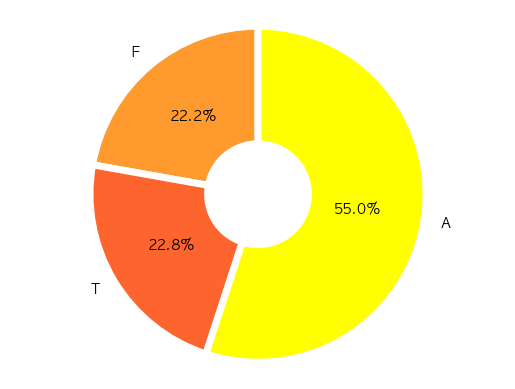

In [84]:
labels = ['F', 'T', 'A']
score = [FTA_gain['상대가중치'][0], FTA_gain['상대가중치'][1], FTA_gain['상대가중치'][2]]
colors = ['#FE9A2E', '#FE642E', '#FFFF00']
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, ax = plt.subplots()
ax.pie(score, labels=labels, colors=colors, autopct='%.1f%%', startangle=90, wedgeprops=wedgeprops)
ax.axis('equal')
plt.show()